# Setup

In [22]:
# Cell 1: Install dependencies
# Uncomment and run the following command if dependencies are not already installed.
# %pip install scikit-learn scikit-image SimpleITK nibabel nilearn albumentations seaborn pandas numpy matplotlib tqdm pydicom scipy
# %pip install umap-learn


In [1]:
# CUDA verification
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA device capability: {torch.cuda.get_device_capability(0)}")

CUDA available: True
CUDA device count: 1
CUDA device name: NVIDIA GeForce RTX 4070 Ti
CUDA device capability: (8, 9)


In [2]:
# Cell 2: Import statements and environment setup
import torch

def configure_gpu():
    """
    Configures GPU settings:
    - Detects CUDA device
    - Enables CUDNN benchmarking for improved performance on NVIDIA 4070Ti
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        # Enable CUDNN benchmark for optimized convolution algorithm selection
        torch.backends.cudnn.benchmark = True
        print(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        raise EnvironmentError("CUDA-compatible GPU not found. Please check your GPU configuration.")

def print_gpu_memory_stats():
    """
    Prints current GPU memory usage for monitoring.
    """
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 2)
        reserved = torch.cuda.memory_reserved() / (1024 ** 2)
        print(f"GPU Memory Allocated: {allocated:.2f} MB")
        print(f"GPU Memory Reserved: {reserved:.2f} MB")
    else:
        print("CUDA not available.")

# Configure GPU on startup
configure_gpu()
print_gpu_memory_stats()

import warnings
warnings.filterwarnings('ignore')

Using GPU: NVIDIA GeForce RTX 4070 Ti
GPU Memory Allocated: 0.00 MB
GPU Memory Reserved: 0.00 MB


In [3]:
# Cell 3: GPU Setup and Memory Management
import os
import logging
import warnings
import pandas as pd

# Configure logging for quality assurance (logs will be written to data_ingestion.log)
logging.basicConfig(level=logging.INFO, filename="data_ingestion.log", filemode="w",
                    format="%(asctime)s - %(levelname)s - %(message)s")

def collect_files(base_dir):
    """
    Recursively collects DICOM files only from the expected folders:
    - PPMI_Images_PD: Label "PD"
    - PPMI_Images_SWEDD: Label "SWEDD"
    - PPMI_Images_Cont: Label "Control"

    Excludes any file containing "br_raw" in its path and logs all skipped folders.

    :param base_dir: Base directory containing the Images folder.
    :return: (included_files, excluded_files)
             included_files: list of tuples (full_path, label)
             excluded_files: list of file paths that were excluded.
    """
    included_files = []
    excluded_files = []

    # Define the expected folders and corresponding labels
    expected_folders = {
        "PPMI_Images_PD": "PD",
        "PPMI_Images_SWEDD": "SWEDD",
        "PPMI_Images_Cont": "Control"
    }

    # Iterate over immediate subdirectories in base_dir
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder in expected_folders:
            logging.info(f"Processing folder: {folder_path}")
            # Recursively traverse the expected folder
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".dcm"):
                        full_path = os.path.join(root, file)
                        # Exclude any file with "br_raw" in its full path
                        if "br_raw" in full_path:
                            excluded_files.append(full_path)
                            logging.info(f"Excluding raw file: {full_path}")
                        else:
                            included_files.append((full_path, expected_folders[folder]))
        else:
            logging.info(f"Skipping folder: {folder_path}")

    return included_files, excluded_files

def generate_dataframe(included_files):
    """
    Creates a DataFrame from the list of validated file paths.

    :param included_files: List of tuples (file_path, label)
    :return: DataFrame with columns 'file_path' and 'label'
    """
    df = pd.DataFrame(included_files, columns=["file_path", "label"])
    return df

def save_qa_report(total_files, included_count, excluded_count, output_path="data_ingestion_QA_report.csv"):
    """
    Generates and saves a QA report of the file collection process.

    :param total_files: Total number of DICOM files encountered.
    :param included_count: Count of files included after filtering.
    :param excluded_count: Count of files excluded.
    :param output_path: File path for the QA report CSV.
    """
    exclusion_ratio = excluded_count / total_files if total_files > 0 else 0
    qa_report = {
        "total_files": total_files,
        "included_files": included_count,
        "excluded_files": excluded_count,
        "exclusion_ratio": exclusion_ratio,
    }
    qa_df = pd.DataFrame([qa_report])
    qa_df.to_csv(output_path, index=False)
    logging.info("QA report saved to %s", output_path)

    if exclusion_ratio > 0.5:
        warnings.warn(f"High proportion of raw files excluded: {exclusion_ratio:.2%}")


## Data Ingestion

In [4]:
# !pip install pydicom
# !pip install nibabel

In [5]:
# Cell 4: Data Ingestion Pipeline
import pydicom
import numpy as np

def load_dicom(file_path):
    """
    Loads and processes a DICOM file:
    - Reads the file using pydicom.
    - Converts the pixel array to float32.
    - Applies RescaleSlope and RescaleIntercept if available.

    :param file_path: Path to the DICOM file.
    :return: Tuple (processed_pixel_array, dicom_metadata)
    """
    try:
        ds = pydicom.dcmread(file_path)
    except Exception as e:
        raise IOError(f"Error reading DICOM file {file_path}: {e}")

    # Extract pixel array and convert to float32
    pixel_array = ds.pixel_array.astype(np.float32)

    # Apply rescaling if attributes are present
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        slope = ds.RescaleSlope
        intercept = ds.RescaleIntercept
        pixel_array = pixel_array * slope + intercept

    return pixel_array, ds

In [6]:
# Cell 5: Execute Data Ingestion Pipeline
# Define the base directory containing the "Images" folder (adjust if necessary)
base_dir = "Images"

# Collect files from only the expected subdirectories
included_files, excluded_files = collect_files(base_dir)

# Create a DataFrame for the validated file paths and their labels
df = generate_dataframe(included_files)

# Final validation: Ensure that no "br_raw" files are included
if df["file_path"].str.contains("br_raw").any():
    raise ValueError("Validation failed: 'br_raw' files detected in the final dataset!")

# Save the validated file paths to CSV for reproducibility
df.to_csv("validated_file_paths.csv", index=False)
print("Validated file paths saved to validated_file_paths.csv")

# Generate and save the QA report
total_files = len(included_files) + len(excluded_files)
save_qa_report(total_files, len(included_files), len(excluded_files))
print("QA report generated and saved as data_ingestion_QA_report.csv")


Validated file paths saved to validated_file_paths.csv
QA report generated and saved as data_ingestion_QA_report.csv


## Data Visualization

Loading file for group PD: Images/PPMI_Images_PD/109619/Reconstructed_DaTSCAN/2022-10-27_13_23_14.0/I1644648/PPMI_109619_NM_Reconstructed_DaTSCAN_Br_20221123111648610_1_S1177762_I1644648.dcm
Loading file for group SWEDD: Images/PPMI_Images_SWEDD/4000/Reconstructed_DaTSCAN/2011-06-29_11_40_14.0/I339029/PPMI_4000_NM_Reconstructed_DaTSCAN_Br_20121009132322207_1_S117665_I339029.dcm
Loading file for group Control: Images/PPMI_Images_Cont/3853/Reconstructed_DaTSCAN/2011-05-18_13_22_30.0/I337835/PPMI_3853_NM_Reconstructed_DaTSCAN_Br_20121002162111333_1_S117662_I337835.dcm


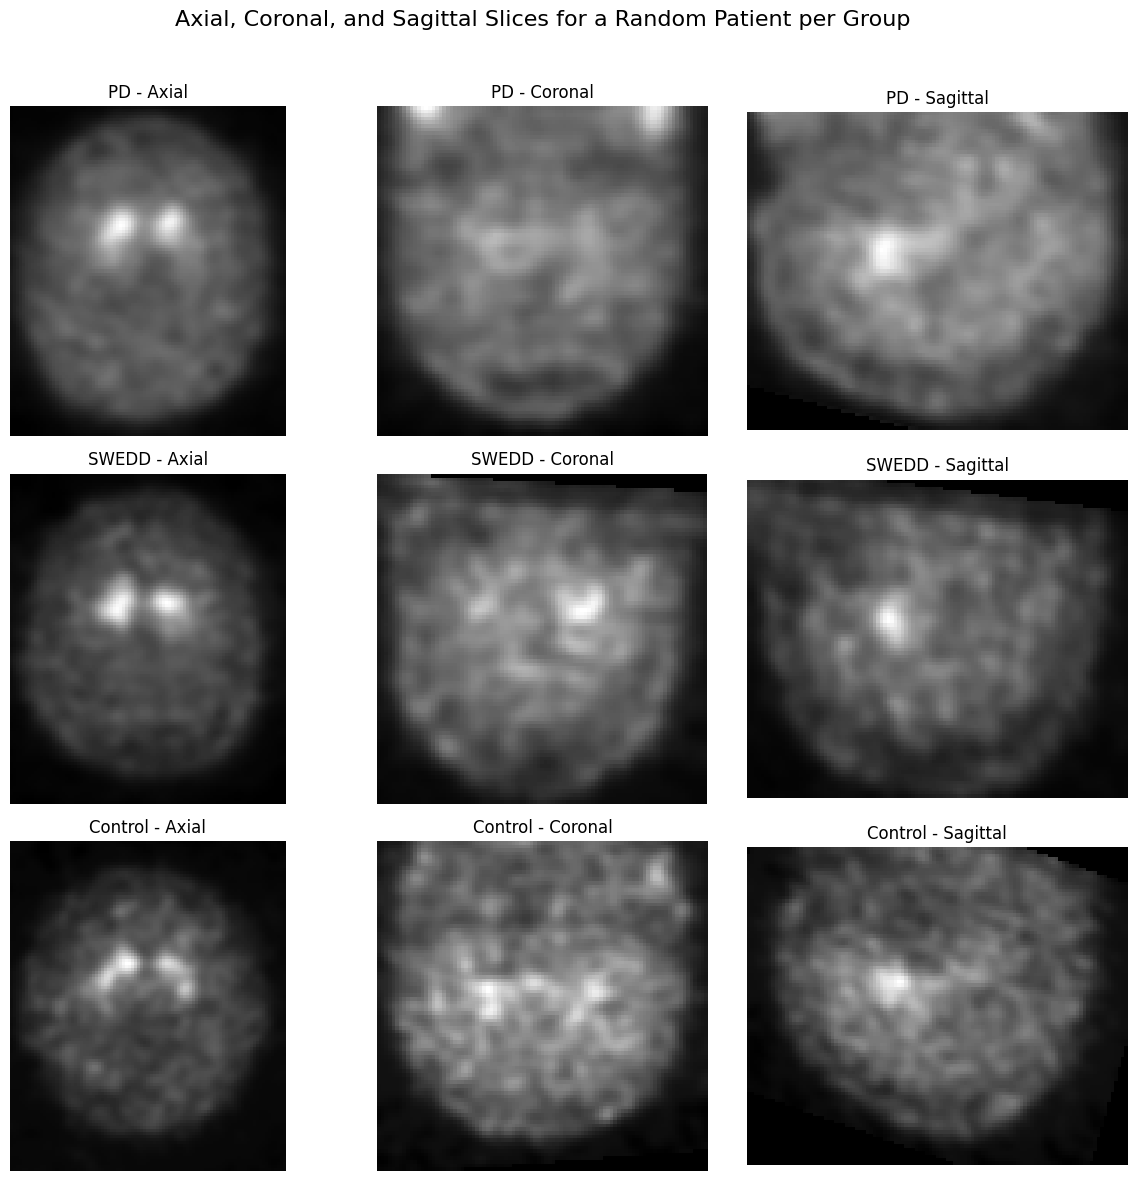

In [7]:
# Cell 6: Visualize One Axial, Coronal, and Sagittal Slice for a Random Patient per Group

import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Read the validated file paths CSV generated earlier
df = pd.read_csv("validated_file_paths.csv")

# Function to extract the three orthogonal slices from a 3D volume
def extract_slices(volume):
    """
    Given a 3D volume, returns one axial, one coronal, and one sagittal slice.
    Assumes volume shape is (depth, height, width).
    """
    d, h, w = volume.shape
    axial = volume[d // 2, :, :]         # Axial: slice along depth
    coronal = volume[:, h // 2, :]        # Coronal: slice along height
    sagittal = volume[:, :, w // 2]       # Sagittal: slice along width
    return axial, coronal, sagittal

# List of groups and their expected labels
groups = {"PD": "PD", "SWEDD": "SWEDD", "Control": "Control"}
maskH = nib.load('rmask_ICV.nii')
mask = maskH.get_fdata()>0.5
mask = np.transpose(mask,[2, 1, 0])
mask = np.flip(mask,axis=1)
# Create a figure with one row per group and three columns for the views
fig, axes = plt.subplots(nrows=len(groups), ncols=3, figsize=(12, 4 * len(groups)))
fig.suptitle("Axial, Coronal, and Sagittal Slices for a Random Patient per Group", fontsize=16)

for i, (group_key, group_label) in enumerate(groups.items()):
    # Filter DataFrame for the current group
    group_df = df[df["label"] == group_label]
    if group_df.empty:
        print(f"No data found for group {group_label}")
        continue

    # Select a random file from the group
    random_file = group_df.sample(1)["file_path"].values[0]
    print(f"Loading file for group {group_label}: {random_file}")

    # Load the DICOM volume using the previously defined load_dicom() function
    volume, _ = load_dicom(random_file)

    # Verify the volume is 3D (if not, skip or raise an error)
    if volume.ndim != 3:
        raise ValueError(f"Expected 3D volume, got shape {volume.shape} for file: {random_file}")

    axial, coronal, sagittal = extract_slices(volume)

    # Plot Axial slice
    ax = axes[i, 0]
    ax.imshow(axial, cmap="gray")
    ax.set_title(f"{group_label} - Axial")
    ax.axis("off")

    # Plot Coronal slice
    ax = axes[i, 1]
    ax.imshow(coronal, cmap="gray")
    ax.set_title(f"{group_label} - Coronal")
    ax.axis("off")

    # Plot Sagittal slice
    ax = axes[i, 2]
    ax.imshow(sagittal, cmap="gray")
    ax.set_title(f"{group_label} - Sagittal")
    ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## Data Preprocessing

### Intensity Normalization and Volume Preprocessing

### Brain Masking

In [8]:
#!pip install scikit-image

(64, 109, 91)
(64, 128, 128)


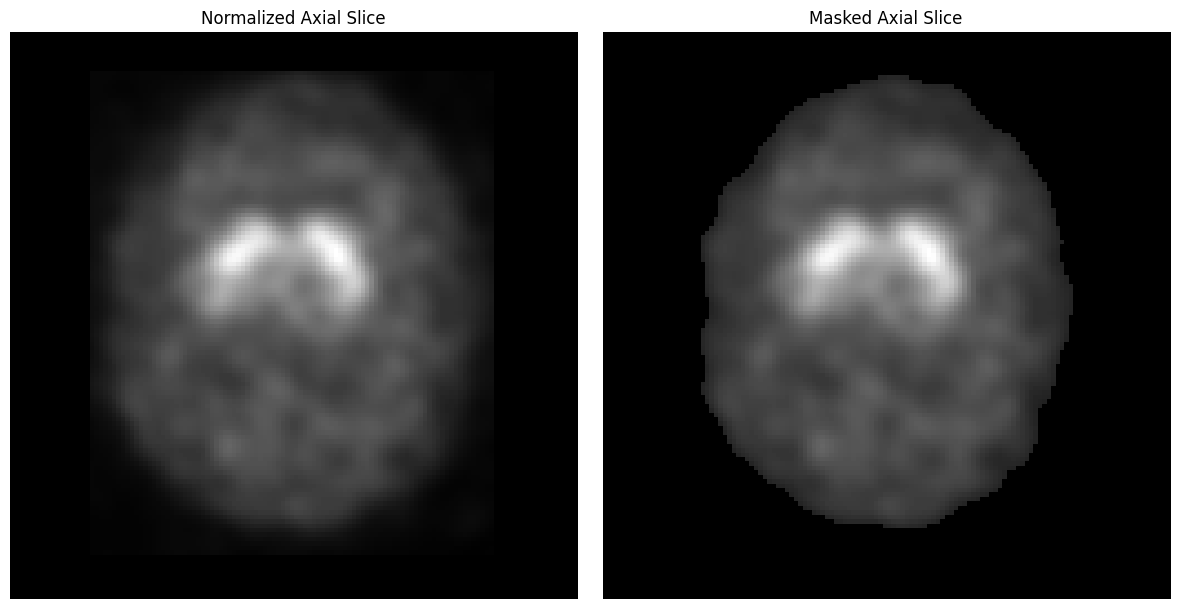

In [9]:
# Cell 7: Data Preprocessing – Brain Masking

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from skimage.morphology import binary_closing, ball

def resize_volume(volume, target_shape=(64, 128, 128)):
    """
    Resizes the volume to the target shape using zero-padding or center cropping.

    Args:
        volume: Input 3D volume as numpy array with shape (d, h, w)
        target_shape: Desired output shape as tuple (d_new, h_new, w_new)

    Returns:
        Resized volume with shape target_shape
    """
    def get_pad_amounts(current_size, target_size):
        """Helper to calculate padding amounts"""
        if current_size >= target_size:
            return 0, 0
        diff = target_size - current_size
        pad_before = diff // 2
        pad_after = diff - pad_before
        return pad_before, pad_after

    current_shape = volume.shape
    resized = volume.copy()

    # Calculate padding/cropping for each dimension
    pads = [get_pad_amounts(current_shape[i], target_shape[i]) for i in range(3)]

    # Apply padding if needed
    if any(sum(p) > 0 for p in pads):
        resized = np.pad(
            resized,
            pad_width=pads,
            mode="constant",
            constant_values=0
        )

    # Apply cropping if needed
    for i in range(3):
        if current_shape[i] > target_shape[i]:
            # Calculate slicing indices
            start = (current_shape[i] - target_shape[i]) // 2
            end = start + target_shape[i]
            # Apply slice
            if i == 0:
                resized = resized[start:end, :, :]
            elif i == 1:
                resized = resized[:, start:end, :]
            else:
                resized = resized[:, :, start:end]

    return resized

def process_volume(volume, target_shape=(64, 128, 128)):
    """
    Process a 3D volume by:
    1. Normalizing intensity (truncating negatives and min-max scaling)
    2. Resizing to target_shape
    3. Generating a brain mask via Otsu thresholding and morphological closing

    Args:
        volume: Input 3D volume
        target_shape: Desired output shape (depth, height, width)

    Returns:
        norm_vol: Normalized and resized volume
        mask: Brain mask
        masked_vol: Masked volume
    """
    # 1. Intensity normalization
    # volume = np.clip(volume, a_min=0, a_max=None)
    # vmin, vmax = volume.min(), volume.max()
    # if vmax > vmin:
    #     norm_vol = (volume - vmin) / (vmax - vmin)
    # else:
    #     norm_vol = volume - vmin
    

    # 2. Resize the normalized volume
    norm_vol = resize_volume(volume-volume.min(), target_shape=target_shape)
    mask = np.zeros((64,128,128),dtype=bool)
    mask[20:40,82:103,43:82]=1    
    norm_vol /= np.mean(norm_vol[mask])    

    # 3. Compute brain mask
    thresh = threshold_otsu(norm_vol)
    mask = norm_vol > thresh
    mask = binary_closing(mask, footprint=ball(2))
    masked_vol = norm_vol * mask

    return norm_vol, mask, masked_vol

# Demonstration: Load one sample DICOM file (using the first file in your validated DataFrame)
sample_file = df.iloc[0]["file_path"]
original_volume, _ = load_dicom(sample_file)
original_volume = original_volume[9:73,:,:]

# Process the volume with our new function
norm_vol, mask, masked_vol = process_volume(original_volume, target_shape=(64,128,128))

print(original_volume.shape)
print(norm_vol.shape)

# Extract an axial (middle) slice from both the normalized volume and the masked volume
axial_norm = norm_vol[norm_vol.shape[0]//2, :, :]
axial_masked = masked_vol[masked_vol.shape[0]//2, :, :]

# Plot side-by-side for comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(axial_norm, cmap="gray")
axes[0].set_title("Normalized Axial Slice")
axes[0].axis("off")

axes[1].imshow(axial_masked, cmap="gray")
axes[1].set_title("Masked Axial Slice")
axes[1].axis("off")

plt.tight_layout()
plt.show()


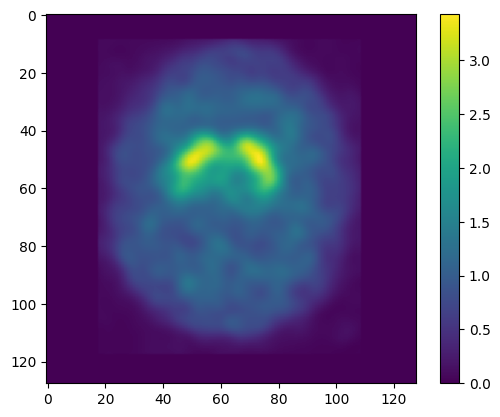

In [10]:
# Cell 8: Data Preprocessing – Visualization (heatmap)
plt.imshow(norm_vol[32,:,:])
plt.colorbar()



## Dataloader Creation (with Shape Validation)

In [11]:
# !pip install ipywidgets

In [12]:
# Cell 9: Dataset Implementation with GPU Memory Management
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import gc
import numpy as np
import os
import psutil
import time
from sklearn.model_selection import train_test_split

def print_memory_stats():
    """Print memory usage statistics"""
    if torch.cuda.is_available():
        print("\nGPU Memory Usage:")
        print(f"Allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
        print(f"Cached: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
    print(f"CPU Memory Usage: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")

class OnDemandDataset(Dataset):
    """
    Memory-efficient dataset that loads volumes on demand rather than all at once
    """
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
        
        # Load mask once
        try:
            maskH = nib.load('rmask_ICV.nii')
            self.mask = maskH.get_fdata() > 0.5
            self.mask = np.transpose(self.mask, [2, 1, 0])
            self.mask = np.flip(self.mask, axis=1)
            print("✅ Brain mask loaded successfully")
        except Exception as e:
            print(f"⚠️ Warning: Could not load brain mask: {e}")
            print("⚠️ Creating a dummy mask instead")
            self.mask = np.ones((128, 128, 128), dtype=bool)
        
        # Verify all paths exist
        missing_files = []
        for idx, row in dataframe.iterrows():
            if not os.path.exists(row["file_path"]):
                missing_files.append(row["file_path"])
        
        if missing_files:
            print(f"⚠️ Warning: {len(missing_files)} files not found!")
            print(f"First few missing files: {missing_files[:3]}")
        else:
            print(f"✅ All {len(dataframe)} file paths are valid")

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.df)

    def __getitem__(self, idx):
        """Load a single volume on demand"""
        try:
            # Get file path
            file_path = self.df.iloc[idx]["file_path"]
            
            # Load and process volume
            volume, _ = load_dicom(file_path)
            
            # Apply mask
            volume -= volume.min()
            volume = volume * self.mask
            
            # Apply processing
            norm_vol, _, _ = process_volume(volume[9:73, :, :], target_shape=(64, 128, 128))
            
            # Convert to tensor
            volume_tensor = torch.from_numpy(np.expand_dims(norm_vol, axis=0)).float()
            
            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }
        except Exception as e:
            print(f"Error processing file {self.df.iloc[idx]['file_path']}: {e}")
            # Return a zero tensor as fallback
            return {
                "volume": torch.zeros((1, 64, 128, 128), dtype=torch.float32),
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }

class BatchLoadDataset(Dataset):
    """
    Memory-efficient dataset that processes data in small batches 
    and caches the processed results
    """
    def __init__(self, dataframe, batch_size=32, transform=None):
        self.df = dataframe
        self.transform = transform
        self.data_cache = {}  # Cache for processed data
        
        # Load mask once
        try:
            maskH = nib.load('rmask_ICV.nii')
            self.mask = maskH.get_fdata() > 0.5
            self.mask = np.transpose(self.mask, [2, 1, 0])
            self.mask = np.flip(self.mask, axis=1)
            print("✅ Brain mask loaded successfully")
        except Exception as e:
            print(f"⚠️ Warning: Could not load brain mask: {e}")
            print("⚠️ Creating a dummy mask instead")
            self.mask = np.ones((128, 128, 128), dtype=bool)
        
        # Pre-process data in batches to avoid memory issues
        total_batches = (len(dataframe) + batch_size - 1) // batch_size
        print(f"Pre-processing {len(dataframe)} samples in {total_batches} batches...")
        
        for batch_idx in tqdm(range(total_batches)):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, len(dataframe))
            
            for idx in range(start_idx, end_idx):
                try:
                    file_path = dataframe.iloc[idx]["file_path"]
                    
                    # Load DICOM
                    volume, _ = load_dicom(file_path)
                    volume -= volume.min()
                    volume = volume * self.mask
                    
                    # Process volume
                    norm_vol, _, _ = process_volume(volume[9:73, :, :], target_shape=(64, 128, 128))
                    
                    # Store in cache (using index as key)
                    self.data_cache[idx] = norm_vol
                    
                except Exception as e:
                    print(f"Error processing file {dataframe.iloc[idx]['file_path']}: {e}")
                    self.data_cache[idx] = np.zeros((64, 128, 128), dtype=np.float32)
            
            # Force garbage collection after each batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            # Print memory stats every few batches
            if batch_idx % 5 == 0:
                print_memory_stats()
        
        print("✅ Data pre-processing complete")

    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.df)

    def __getitem__(self, idx):
        """Get a cached pre-processed volume"""
        try:
            # Get the pre-processed volume from cache
            norm_vol = self.data_cache[idx]
            
            # Convert to tensor
            volume_tensor = torch.from_numpy(np.expand_dims(norm_vol, axis=0)).float()
            
            return {
                "volume": volume_tensor,
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }
        except Exception as e:
            print(f"Error retrieving item {idx}: {e}")
            # Return a zero tensor as fallback
            return {
                "volume": torch.zeros((1, 64, 128, 128), dtype=torch.float32),
                "label": self.df.iloc[idx]["label"],
                "path": self.df.iloc[idx]["file_path"]
            }

def create_dataloaders(df, batch_size=4, train_split=0.8, on_demand=True):
    """Create train and validation dataloaders with stratified split"""
    # Stratified split to maintain group distributions
    train_df, val_df = train_test_split(
        df,
        test_size=1-train_split,
        stratify=df['label'],
        random_state=42
    )

    print("\nTraining set distribution:")
    print(train_df['label'].value_counts())
    print("\nValidation set distribution:")
    print(val_df['label'].value_counts())

    # Create datasets with appropriate strategy
    if on_demand:
        print("Using on-demand data loading strategy (lighter on memory but slower)")
        train_dataset = OnDemandDataset(train_df)
        val_dataset = OnDemandDataset(val_df)
    else:
        print("Using batch pre-processing strategy (faster but more memory intensive)")
        train_dataset = BatchLoadDataset(train_df)
        val_dataset = BatchLoadDataset(val_df)

    # Create dataloaders with optimized settings
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,  # Reduced from 6 to prevent hanging
        pin_memory=True,
        persistent_workers=False  # Changed from True to avoid memory issues
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,  # Reduced from 6 to prevent hanging
        pin_memory=True,
        persistent_workers=False  # Changed from True to avoid memory issues
    )

    return train_loader, val_loader

# Test the dataloader with a small batch
if __name__ == "__main__":
    print("Testing dataloader with small batch...")
    start_time = time.time()
    
    # Create dataloaders with a smaller batch size for testing
    train_loader, val_loader = create_dataloaders(df, batch_size=2, on_demand=True)
    
    # Try to load a single batch
    print("Fetching a single batch...")
    for batch in train_loader:
        print(f"Batch loaded successfully!")
        print(f"Batch shape: {batch['volume'].shape}")
        print(f"Labels: {batch['label']}")
        break
    
    print(f"Dataloader test completed in {time.time() - start_time:.2f} seconds")
    print_memory_stats()

Testing dataloader with small batch...

Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64
Using on-demand data loading strategy (lighter on memory but slower)
✅ Brain mask loaded successfully
✅ All 2388 file paths are valid
✅ Brain mask loaded successfully
✅ All 598 file paths are valid
Fetching a single batch...
Batch loaded successfully!
Batch shape: torch.Size([2, 1, 64, 128, 128])
Labels: ['PD', 'PD']
Dataloader test completed in 10.65 seconds

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 829.20 MB


### LP Ram Loader

In [13]:
# class LPRamDataset(Dataset):
#     def __init__(self, dataframe, transform=None):
#         self.df = dataframe
#         self.transform = transform
#         maskH = nib.load('rmask_ICV.nii')
#         mask = maskH.get_fdata()>0.5
#         mask = np.transpose(mask,[2, 1, 0])
#         mask = np.flip(mask,axis=1)        
#         self.npArr = np.zeros((len(dataframe),1,64,128,128),dtype=np.float32)

#         counter=0
#         for _, row in dataframe.iterrows():
#             try:
#                 file_path = row["file_path"]

#             # Load DICOM
#                 volume, _ = load_dicom(file_path) 
#                 volume -= volume.min()
#          #       print(counter)
#          #       print(volume.shape)
#         #        print(mask.shape)
#                 volume *= mask
#                 norm_vol, _, masked_vol = process_volume(volume[9:73,:,:], target_shape=(64, 128, 128))
#                 self.npArr[counter,0,:,:,:]=norm_vol
#                 counter +=1
#            #     delete volume, norm_vol, masked_vol
#             except Exception as e:
#                 print(f"Error processing file {row['file_path']}: {e}") 
#         self.npArr = self.npArr[:counter,:,:,:,:]
#  #       self.immArr = torch.from_numpy(self.npArr).float().to("cuda")        
#   #      delete volume, masked_vol, mask
#         gc.collect()

#     def __len__(self):
#         """Return the total number of samples in the dataset"""
#         return len(self.df)

#     def __getitem__(self, idx):
#       #      print(self.immArr.shape)
#  #           print(idx)
#             volume_tensor = torch.from_numpy(self.npArr[idx, :, :, :, :])
#             return {
#                 "volume": volume_tensor,
#                 "label": self.df.iloc[idx]["label"],
#                 "path":self.df.iloc[idx]["file_path"]
#             }


# def create_dataloaders(df, batch_size=4, train_split=0.8):
#     """Create train and validation dataloaders with stratified split"""
#     # Stratified split to maintain group distributions
#     train_df, val_df = train_test_split(
#         df,
#         test_size=1-train_split,
#         stratify=df['label'],
#         random_state=42
#     )

#     print("\nTraining set distribution:")
#     print(train_df['label'].value_counts())
#     print("\nValidation set distribution:")
#     print(val_df['label'].value_counts())

#     # Create datasets

#     # Create dataloaders
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=0,  # No multiprocessing for debugging
#         pin_memory=True
#     )

#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=0,  # No multiprocessing for debugging
#         pin_memory=True
#     )

#     return train_loader, val_loader


# Exploratory Data Analysis (EDA)

In [14]:
# !pip install seaborn

Starting Memory-Efficient EDA...

Creating memory-efficient dataloaders...

Training set distribution:
label
PD         2043
Control     235
SWEDD       110
Name: count, dtype: int64

Validation set distribution:
label
PD         512
Control     59
SWEDD       27
Name: count, dtype: int64
Using on-demand data loading strategy (lighter on memory but slower)
✅ Brain mask loaded successfully
✅ All 2388 file paths are valid
✅ Brain mask loaded successfully
✅ All 598 file paths are valid

Analyzing training dataset (limited samples)...
Analyzing dataset statistics (memory-efficient version)...


Computing statistics:   2%|▏         | 24/1194 [00:03<02:39,  7.32it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Computing statistics:   2%|▏         | 24/1194 [00:03<02:46,  7.01it/s]


Processed 50 samples (limit: 50)
Successfully analyzed 50 samples

Plotting intensity distributions...


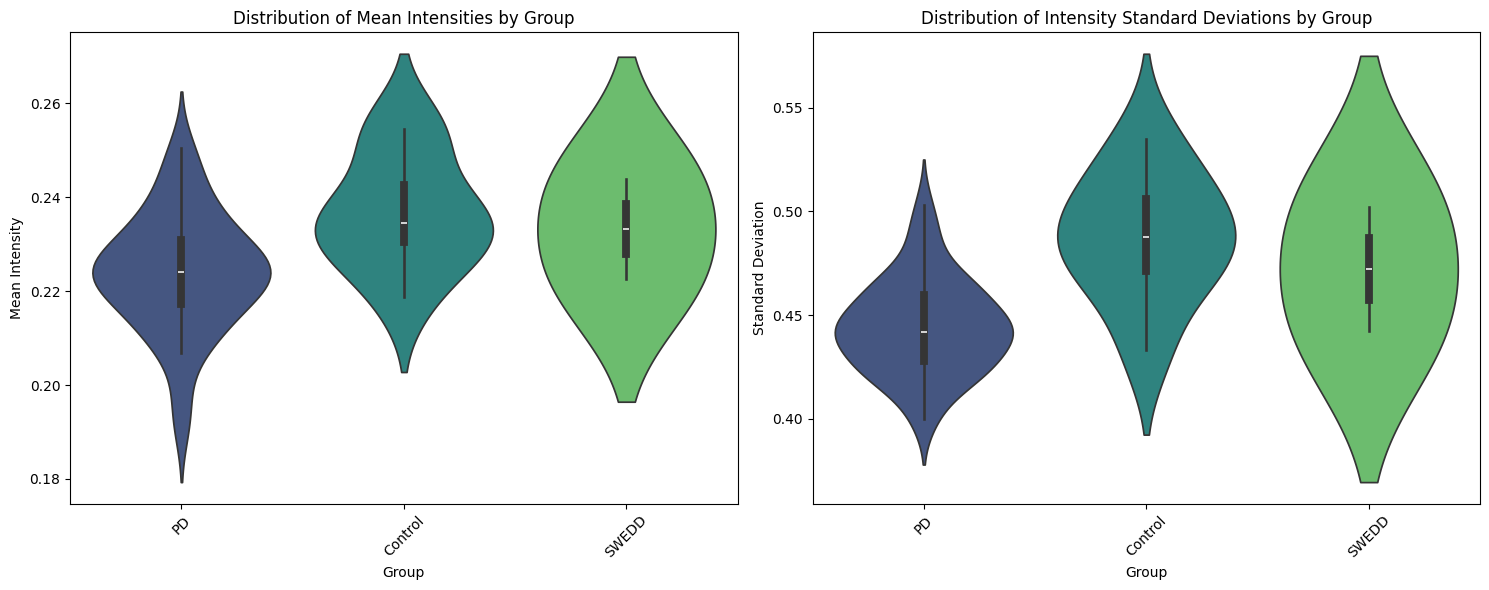


Plotting group statistics...


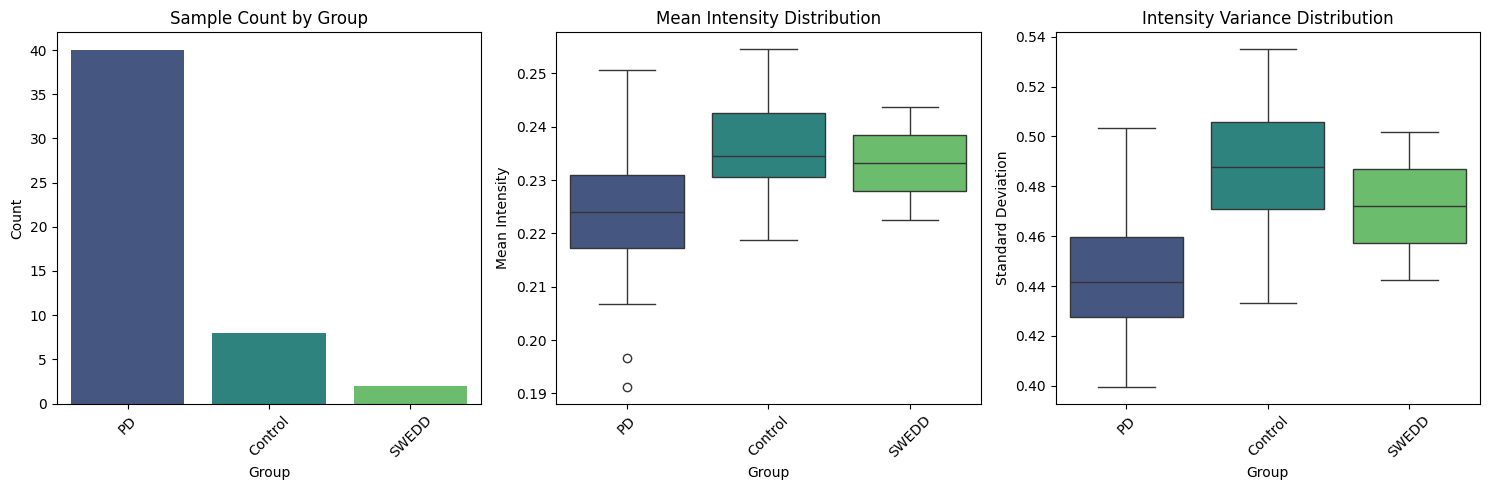


Visualizing example slices...


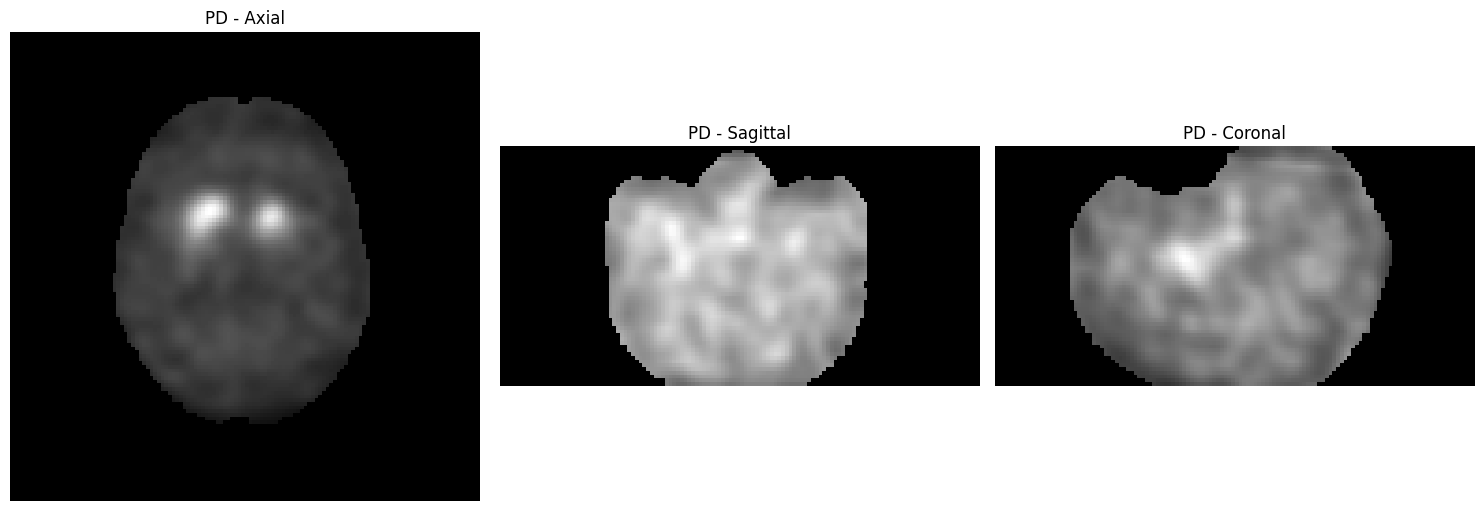


Summary Statistics by Group:
          mean           std         min         max       
          mean    std   mean    std mean  std   mean    std
label                                                      
Control  0.237  0.012  0.488  0.031  0.0  0.0  5.369  1.081
PD       0.224  0.012  0.444  0.023  0.0  0.0  3.591  0.661
SWEDD    0.233  0.015  0.472  0.042  0.0  0.0  4.231  0.856

EDA completed in 10.10 seconds!

GPU Memory Usage:
Allocated: 0.00 MB
Cached: 0.00 MB
CPU Memory Usage: 898.73 MB


In [15]:
# Cell 10: Optimized EDA Implementation
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import torch
import time
import gc

def create_memory_efficient_dataloaders(df, batch_size=2, train_split=0.8):
    """
    Create train and validation dataloaders with optimized memory usage
    """
    # Reuse the create_dataloaders function from Cell 9
    return create_dataloaders(df, batch_size=batch_size, train_split=train_split, on_demand=True)

def analyze_dataset_statistics_efficiently(dataloader, max_samples=100):
    """
    Analyzes dataset statistics with improved memory efficiency
    Returns: Dictionary of statistical measures
    
    This function limits the number of samples to process and
    ensures proper memory cleanup between batches.
    """
    print("Analyzing dataset statistics (memory-efficient version)...")
    stats = defaultdict(list)
    
    samples_processed = 0
    
    try:
        for batch in tqdm(dataloader, desc="Computing statistics"):
            volumes = batch['volume']
            labels = batch['label']
            paths = batch['path']
            
            # Process each volume in the batch
            for vol_idx, (volume, label, path) in enumerate(zip(volumes, labels, paths)):
                # Extract statistics without loading the entire volume into memory again
                vol_data = volume.numpy().flatten()
                
                # Only compute basic statistics to avoid memory issues
                stats['mean'].append(float(np.mean(vol_data)))
                stats['std'].append(float(np.std(vol_data)))
                stats['min'].append(float(np.min(vol_data)))
                stats['max'].append(float(np.max(vol_data)))
                stats['label'].append(label)
                stats['path'].append(path)
                
                samples_processed += 1
                
            # Memory cleanup after each batch
            del volumes, labels, paths
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            gc.collect()
            
            # Check if we've processed enough samples
            if samples_processed >= max_samples:
                print(f"Processed {samples_processed} samples (limit: {max_samples})")
                break
                
    except Exception as e:
        print(f"Error during statistical analysis: {str(e)}")
        import traceback
        traceback.print_exc()
    
    # Convert to DataFrame for easier analysis
    stats_df = pd.DataFrame(stats)
    print(f"Successfully analyzed {len(stats_df)} samples")
    
    return stats_df

def plot_intensity_distributions(stats_df):
    """
    Creates violin plots of intensity distributions by group
    """
    plt.figure(figsize=(15, 6))

    # Plot intensity distributions
    plt.subplot(1, 2, 1)
    sns.violinplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Distribution of Mean Intensities by Group')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Distribution of Intensity Standard Deviations by Group')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_group_statistics(stats_df):
    """
    Plots statistical summaries by group using lightweight operations
    """
    plt.figure(figsize=(15, 5))

    # Group counts
    plt.subplot(1, 3, 1)
    group_counts = stats_df['label'].value_counts()
    sns.barplot(x=group_counts.index, y=group_counts.values, palette='viridis')
    plt.title('Sample Count by Group')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

    # Box plots - more memory efficient than complex plots
    plt.subplot(1, 3, 2)
    sns.boxplot(data=stats_df, x='label', y='mean', palette='viridis')
    plt.title('Mean Intensity Distribution')
    plt.xlabel('Group')
    plt.ylabel('Mean Intensity')
    plt.xticks(rotation=45)

    # Simple boxplot instead of violin plot
    plt.subplot(1, 3, 3)
    sns.boxplot(data=stats_df, x='label', y='std', palette='viridis')
    plt.title('Intensity Variance Distribution')
    plt.xlabel('Group')
    plt.ylabel('Standard Deviation')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def visualize_sample_slices(dataloader, samples_per_group=1):
    """
    Visualizes a limited number of samples from each group
    with efficient memory handling
    """
    # Keep track of samples seen per group
    samples_seen = defaultdict(int)
    samples_data = {}
    
    # Get one sample from each group
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        for i, (vol, label) in enumerate(zip(volumes, labels)):
            # Skip if we already have enough samples for this group
            if samples_seen[label] >= samples_per_group:
                continue
            
            # Store the sample
            samples_data[f"{label}_{samples_seen[label]}"] = vol.cpu().numpy()
            samples_seen[label] += 1
        
        # Stop if we have enough samples from each group
        if all(samples_seen[label] >= samples_per_group for label in set(labels)):
            break
    
    # Visualize the samples
    plt.figure(figsize=(15, 5 * len(samples_data)))
    
    for i, (key, vol) in enumerate(samples_data.items()):
        # Extract label
        label = key.split('_')[0]
        
        # Get middle slices
        vol = vol.squeeze()  # Remove channel dimension
        axial_slice = vol[vol.shape[0]//2, :, :]
        sagittal_slice = vol[:, vol.shape[1]//2, :]
        coronal_slice = vol[:, :, vol.shape[2]//2]
        
        # Plot slices
        plt.subplot(len(samples_data), 3, i*3 + 1)
        plt.imshow(axial_slice, cmap='gray')
        plt.title(f'{label} - Axial')
        plt.axis('off')
        
        plt.subplot(len(samples_data), 3, i*3 + 2)
        plt.imshow(sagittal_slice, cmap='gray')
        plt.title(f'{label} - Sagittal')
        plt.axis('off')
        
        plt.subplot(len(samples_data), 3, i*3 + 3)
        plt.imshow(coronal_slice, cmap='gray')
        plt.title(f'{label} - Coronal')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run optimized EDA
if __name__ == "__main__":
    start_time = time.time()
    print("Starting Memory-Efficient EDA...")
    
    # Create dataloaders with small batch size
    print("\nCreating memory-efficient dataloaders...")
    train_loader, val_loader = create_memory_efficient_dataloaders(df, batch_size=2)
    
    # Analyze a limited subset of the training data
    print("\nAnalyzing training dataset (limited samples)...")
    train_stats = analyze_dataset_statistics_efficiently(train_loader, max_samples=50)
    
    # Plot distributions and statistics
    print("\nPlotting intensity distributions...")
    plot_intensity_distributions(train_stats)
    
    print("\nPlotting group statistics...")
    plot_group_statistics(train_stats)
    
    # Visualize a few examples
    print("\nVisualizing example slices...")
    visualize_sample_slices(train_loader, samples_per_group=1)
    
    # Print summary statistics by group
    print("\nSummary Statistics by Group:")
    summary_stats = train_stats.groupby('label').agg({
        'mean': ['mean', 'std'],
        'std': ['mean', 'std'],
        'min': ['mean', 'std'],
        'max': ['mean', 'std']
    }).round(3)
    print(summary_stats)
    
    # Memory cleanup
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print(f"\nEDA completed in {time.time() - start_time:.2f} seconds!")
    print_memory_stats()

### Slice Intensity Variance Analysis

In [16]:
def analyze_slice_variance(dataloader, num_samples_per_group=5):
    """
    Analyzes slice-wise variance across different views for each patient group
    """
    print("Analyzing slice-wise variance patterns...")

    # Initialize storage for variances
    group_variances = {
        'PD': {'axial': [], 'coronal': [], 'sagittal': []},
        'Control': {'axial': [], 'coronal': [], 'sagittal': []},
        'SWEDD': {'axial': [], 'coronal': [], 'sagittal': []}
    }
    sample_counts = {'PD': 0, 'Control': 0, 'SWEDD': 0}

    try:
        for batch in tqdm(dataloader, desc="Computing slice variances"):
            volumes = batch['volume']
            labels = batch['label']

            for volume, label in zip(volumes, labels):
                label = label if isinstance(label, str) else label.item()

                if sample_counts[label] >= num_samples_per_group:
                    continue

                # Get volume data
                vol_data = volume.squeeze().numpy()
                d, h, w = vol_data.shape

                # Compute variance for each slice in each view
                axial_var = [np.var(vol_data[i, :, :]) for i in range(d)]
                coronal_var = [np.var(vol_data[:, i, :]) for i in range(h)]
                sagittal_var = [np.var(vol_data[:, :, i]) for i in range(w)]

                # Store variances
                group_variances[label]['axial'].append(axial_var)
                group_variances[label]['coronal'].append(coronal_var)
                group_variances[label]['sagittal'].append(sagittal_var)

                sample_counts[label] += 1

            # Check if we have enough samples from each group
            if all(count >= num_samples_per_group for count in sample_counts.values()):
                break

            # Memory cleanup
            del volumes, labels
            gc.collect()
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"Error during variance analysis: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

    # Compute average variances across samples for each group
    avg_variances = {}
    for group in group_variances:
        avg_variances[group] = {
            view: np.mean(variances, axis=0)
            for view, variances in group_variances[group].items()
        }

    return avg_variances

# Plot the slice variance results
def plot_slice_variances(avg_variances):
    """
    Creates line plots for slice-wise variance analysis
    """
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    for idx, view in enumerate(views):
        ax = axes[idx]

        for group in avg_variances:
            variances = avg_variances[group][view]
            ax.plot(range(len(variances)), variances, label=group)

        ax.set_title(f'{view.capitalize()} View - Slice-wise Variance')
        ax.set_xlabel('Slice Index')
        ax.set_ylabel('Average Variance')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()



Analyzing slice-wise variance patterns...
Analyzing slice-wise variance patterns...


Computing slice variances:   4%|▍         | 47/1194 [00:06<02:40,  7.13it/s]



Plotting slice-wise variance analysis...


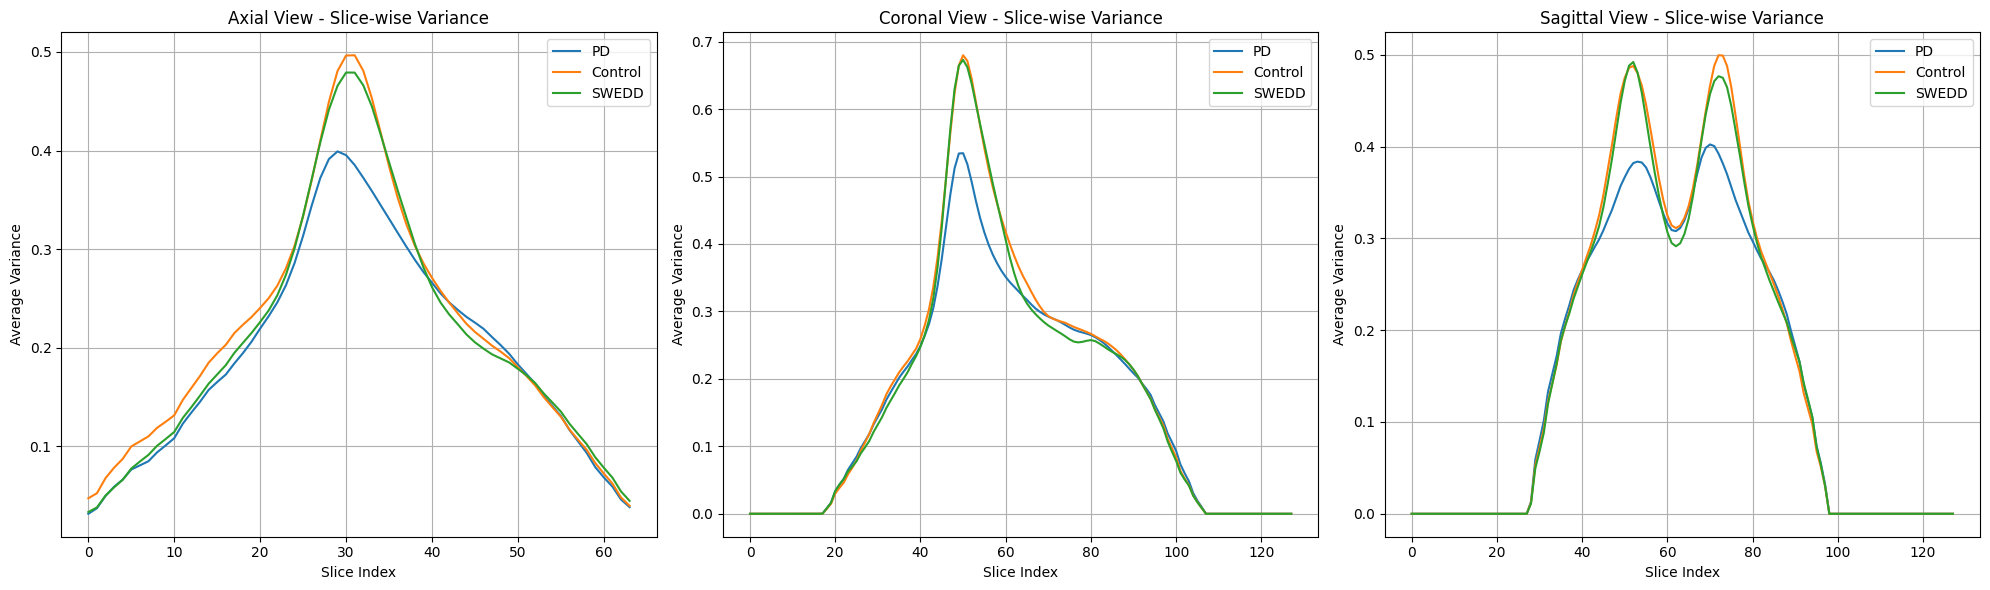

In [17]:
# Analyze slice-wise variance
print("\nAnalyzing slice-wise variance patterns...")
avg_variances = analyze_slice_variance(train_loader, num_samples_per_group=5)

if avg_variances is not None:
    print("\nPlotting slice-wise variance analysis...")
    plot_slice_variances(avg_variances)

# Model Phase

## 1. Autoencoder

### Model Setup

In [18]:
# Cell 11: Optimized Autoencoder with Memory Management
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU activation."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    """3D Encoder network optimized for 64×128×128 input volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # (1, 64, 128, 128) -> (16, 64, 128, 128)

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # -> (32, 32, 64, 64)
            ConvBlock(32, 32)               # -> (32, 32, 64, 64)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # -> (64, 16, 32, 32)
            ConvBlock(64, 64)               # -> (64, 16, 32, 32)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # -> (128, 8, 16, 16)
            ConvBlock(128, 128)             # -> (128, 8, 16, 16)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # -> (256, 4, 8, 8)
            ConvBlock(256, 256)             # -> (256, 4, 8, 8)
        )

        # Project to latent space
        self.flatten_size = 256 * 4 * 8 * 8
        self.fc = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        x = self.init_conv(x)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Flatten and project to latent space
        flat = torch.flatten(d4, start_dim=1)
        z = self.fc(flat)

        return z

class Decoder(nn.Module):
    """3D Decoder network optimized for 64×128×128 output volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 4 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(256, 128),
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(128, 64),
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(64, 32),
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(32, 16),
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 4, 8, 8)

        # Upsampling
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)

        # Final convolution
        x = self.final_conv(x)

        return x

class BaseAutoencoder(nn.Module):
    """Memory-optimized 3D Autoencoder for 64×128×128 medical volumes."""
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        return reconstruction

    def encode(self, x):
        """Encode input to latent space"""
        z = self.encoder(x)
        return z

    def decode(self, z):
        """Decode from latent space (for generation)"""
        return self.decoder(z)

# Memory and GPU test function
def test_autoencoder(batch_size=2):
    """Test the autoencoder with dummy data and verify memory usage."""
    print("\nTesting Autoencoder Architecture...")

    try:
        # Create model and move to GPU
        model = BaseAutoencoder(latent_dim=256)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Print model summary
        num_params = sum(p.numel() for p in model.parameters())
        print(f"\nModel Parameters: {num_params:,}")

        # Create dummy input (64x128x128 volume)
        dummy_input = torch.randn(batch_size, 1, 64, 128, 128, device=device)

        # Print initial memory usage
        print("\nInitial GPU Memory Usage:")
        print_memory_stats()

        # Test encoding
        print("\nTesting encoder...")
        with torch.no_grad():
            latent = model.encode(dummy_input)
        print(f"Input shape: {dummy_input.shape}")
        print(f"Latent shape: {latent.shape}")

        # Test full forward pass
        print("\nTesting forward pass...")
        with torch.no_grad():
            output = model(dummy_input)

        # Print output shape and final memory usage
        print(f"Output shape: {output.shape}")
        print("\nFinal GPU Memory Usage:")
        print_memory_stats()

        # Verify shapes
        assert output.shape == dummy_input.shape, f"Shape mismatch: {output.shape} vs {dummy_input.shape}"

        # Clean up
        del model, dummy_input, output, latent
        torch.cuda.empty_cache()

        print("\nAutoencoder test completed successfully!")
        return True

    except Exception as e:
        print(f"Error testing autoencoder: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

# Run test if this cell is executed
if __name__ == "__main__":
    test_autoencoder(batch_size=2)


Testing Autoencoder Architecture...

Model Parameters: 38,912,721

Initial GPU Memory Usage:

GPU Memory Usage:
Allocated: 156.48 MB
Cached: 172.00 MB
CPU Memory Usage: 915.63 MB

Testing encoder...
Input shape: torch.Size([2, 1, 64, 128, 128])
Latent shape: torch.Size([2, 256])

Testing forward pass...
Output shape: torch.Size([2, 1, 64, 128, 128])

Final GPU Memory Usage:

GPU Memory Usage:
Allocated: 172.61 MB
Cached: 624.00 MB
CPU Memory Usage: 1214.96 MB

Autoencoder test completed successfully!


In [19]:
# Cell 12: Training Configuration and Utilities
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp as amp
import math

class TrainingConfig:
    """Training configuration optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        # Model parameters
        self.latent_dim = kwargs.get('latent_dim', 256)
        
        # Training parameters
        self.learning_rate = kwargs.get('learning_rate', 1e-4)
        self.batch_size = kwargs.get('batch_size', 4)
        self.accumulation_steps = kwargs.get('accumulation_steps', 4)
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 10)
        
        # Optimization
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)
        self.weight_decay = kwargs.get('weight_decay', 1e-5)
        self.gradient_clip = kwargs.get('gradient_clip', 1.0)
        
        # Dataloader parameters
        self.num_workers = kwargs.get('num_workers', 2)
        self.pin_memory = kwargs.get('pin_memory', True)
        
        # Checkpoint parameters
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'autoencoder')
        self.save_interval = kwargs.get('save_interval', 5)
        
        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)
        
        # Print configuration summary
        print(f"\n{'='*50}")
        print(f"TRAINING CONFIGURATION")
        print(f"{'='*50}")
        print(f"Model: {self.model_name} with latent dim {self.latent_dim}")
        print(f"Batch size: {self.batch_size} × {self.accumulation_steps} steps = {self.batch_size * self.accumulation_steps} effective")
        print(f"Learning rate: {self.learning_rate}")
        print(f"Mixed precision: {'Enabled' if self.use_mixed_precision else 'Disabled'}")
        print(f"Epochs: {self.epochs} with patience {self.early_stopping_patience}")
        print(f"Dataloader workers: {self.num_workers}")
        print(f"Checkpoints saved to: {self.checkpoint_dir}")
        print(f"{'='*50}\n")

class EarlyStopping:
    """Early stopping handler with patience"""
    def __init__(self, patience=10, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                improvement = self.best_loss - val_loss
                print(f"Validation loss improved by {improvement:.6f}")
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            return True  # Model improved
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered. Best epoch was {self.best_epoch}.")
            return False  # Model didn't improve

class CheckpointHandler:
    """Handles saving and loading of model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.best_model_path = self.checkpoint_dir / f"{model_name}_best.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"
        
        # Ensure directory exists
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses, is_best=False):
        """Save model checkpoint and training metadata"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        
        # Always save latest checkpoint
        torch.save(checkpoint, self.checkpoint_path)
        
        # Save best model separately if this is the best model
        if is_best:
            torch.save(model.state_dict(), self.best_model_path)
            print(f"Saved best model to {self.best_model_path}")

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer=None, scheduler=None, device=None):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            print(f"No checkpoint found at {self.checkpoint_path}")
            return None

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
        # Load checkpoint
        checkpoint = torch.load(self.checkpoint_path, map_location=device)
        
        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Optionally load optimizer and scheduler states
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
        if scheduler is not None and checkpoint['scheduler_state_dict'] is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        
        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint['train_losses'],
            'val_losses': checkpoint['val_losses']
        }

def create_optimizer(model, config):
    """Create optimizer with weight decay and parameter grouping"""
    # Separate parameters that should have weight decay from those that shouldn't
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if 'bias' in name or 'bn' in name:
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    # Create parameter groups
    param_groups = [
        {'params': decay_params, 'weight_decay': config.weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]
    
    # Create optimizer
    optimizer = optim.AdamW(param_groups, lr=config.learning_rate)
    
    return optimizer

def create_scheduler(optimizer, config):
    """Create learning rate scheduler"""
    return ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, min_lr=0.0, last_epoch=-1):
    """Create a cosine learning rate schedule with warmup"""
    def lr_lambda(current_step):
        # Warmup
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        
        # Cosine decay
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        factor = 0.5 * (1.0 + math.cos(math.pi * progress))
        return max(min_lr, factor)
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch)

# Test configuration if this cell is executed
if __name__ == "__main__":
    config = TrainingConfig(
        latent_dim=256,
        batch_size=2,
        accumulation_steps=8,
        learning_rate=1e-4,
        epochs=100,
        model_name="autoencoder_test"
    )
    
    model = BaseAutoencoder(config.latent_dim)
    optimizer = create_optimizer(model, config)
    scheduler = create_scheduler(optimizer, config)
    
    print("Configuration and utilities loaded successfully!")


TRAINING CONFIGURATION
Model: autoencoder_test with latent dim 256
Batch size: 2 × 8 steps = 16 effective
Learning rate: 0.0001
Mixed precision: Enabled
Epochs: 100 with patience 10
Dataloader workers: 2
Checkpoints saved to: checkpoints

Configuration and utilities loaded successfully!


In [20]:
# Cell 13: Training Loop Implementation
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import gc
import time

def train_autoencoder(model, train_loader, val_loader, config=None):
    """Optimized training loop with GPU memory management and progress tracking"""
    if config is None:
        config = TrainingConfig()

    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = nn.MSELoss()
    optimizer = create_optimizer(model, config)
    scheduler = create_scheduler(optimizer, config)
    early_stopping = EarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)

    # Training tracking variables
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    start_time = time.time()

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler, device)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    # Calculate total steps for progress tracking
    total_steps = len(train_loader) * config.epochs

    # Training loop
    try:
        # Create progress bar for total training
        total_pbar = tqdm(total=total_steps, desc="Total Progress", position=0)
        total_pbar.update(start_epoch * len(train_loader))
        
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            epoch_loss = 0
            optimizer.zero_grad()  # Zero gradients at epoch start

            train_pbar = tqdm(train_loader, 
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False, 
                            position=1)

            for batch_idx, batch in enumerate(train_pbar):
                try:
                    # Move data to device
                    volumes = batch['volume'].to(device, non_blocking=True)
                    
                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps

                    # Mixed precision backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0 or (batch_idx + 1 == len(train_loader)):
                        # Clip gradients to prevent exploding gradients
                        if config.gradient_clip > 0:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                        
                        # Update weights
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track loss (using the non-scaled loss for reporting)
                    batch_loss = loss.item() * config.accumulation_steps
                    epoch_loss += batch_loss
                    
                    # Update progress bars
                    train_pbar.set_postfix({'loss': f"{batch_loss:.6f}"})
                    total_pbar.update(1)

                    # Memory cleanup
                    del volumes, reconstructed, loss
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Cleaning up...")
                        torch.cuda.empty_cache()
                        gc.collect()
                        # Skip this batch and continue
                        continue
                    raise e

            # Calculate average training loss
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            model.eval()
            val_loss = 0
            
            val_pbar = tqdm(val_loader, 
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False,
                          position=1)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed = model(volumes)
                        loss = criterion(reconstructed, volumes)
                        val_loss += loss.item()
                        
                        val_pbar.set_postfix({'loss': f"{loss.item():.6f}"})

                        # Memory cleanup
                        del volumes, reconstructed, loss
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            torch.cuda.empty_cache()
                            gc.collect()
                            continue
                        raise e

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Check if this is the best model
            is_best = avg_val_loss < best_val_loss
            if is_best:
                best_val_loss = avg_val_loss

            # Save checkpoint
            if (epoch + 1) % config.save_interval == 0 or is_best or (epoch + 1 == config.epochs):
                checkpoint_handler.save(
                    model, optimizer, scheduler,
                    epoch, train_losses, val_losses,
                    is_best=is_best
                )

            # Print epoch summary
            elapsed_time = time.time() - start_time
            time_per_epoch = elapsed_time / (epoch - start_epoch + 1) if epoch >= start_epoch else 0
            est_time_left = time_per_epoch * (config.epochs - epoch - 1)
            
            print(f"\nEpoch {epoch+1}/{config.epochs} completed in {time_per_epoch:.2f}s")
            print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
            print(f"Learning rate: {optimizer.param_groups[0]['lr']:.8f}")
            print(f"Est. time remaining: {est_time_left/60:.2f} minutes")
            print_memory_stats()
            
            # Early stopping check
            if early_stopping(avg_val_loss, epoch):
                if early_stopping.early_stop:
                    print("\nEarly stopping triggered!")
                    break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
        # Still save the model
        checkpoint_handler.save(
            model, optimizer, scheduler,
            epoch, train_losses, val_losses,
            is_best=False
        )

    finally:
        # Close progress bars
        if 'total_pbar' in locals():
            total_pbar.close()
        
        # Plot training history
        plt.figure(figsize=(12, 5))
        
        # Plot full history
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Full Training History')
        plt.legend()
        plt.grid(True)
        
        # Plot recent history (last 30 epochs or full history if < 30 epochs)
        plt.subplot(1, 2, 2)
        recent = min(30, len(train_losses))
        if recent > 5:  # Only plot recent if we have enough epochs
            plt.plot(train_losses[-recent:], label='Train Loss')
            plt.plot(val_losses[-recent:], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Last {recent} Epochs')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

        # Print final training summary
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/60:.2f} minutes")
        print(f"Best validation loss: {best_val_loss:.6f}")
        
        return train_losses, val_losses, model

### Training


TRAINING CONFIGURATION
Model: autoencoder_v1 with latent dim 256
Batch size: 8 × 8 steps = 64 effective
Learning rate: 0.0001
Mixed precision: Enabled
Epochs: 100 with patience 10
Dataloader workers: 4
Checkpoints saved to: checkpoints


Starting training...
Loaded checkpoint from epoch 99
Resuming training from epoch 100


Total Progress: 100%|██████████| 119400/119400 [00:00<00:00, 1138181585.45it/s]


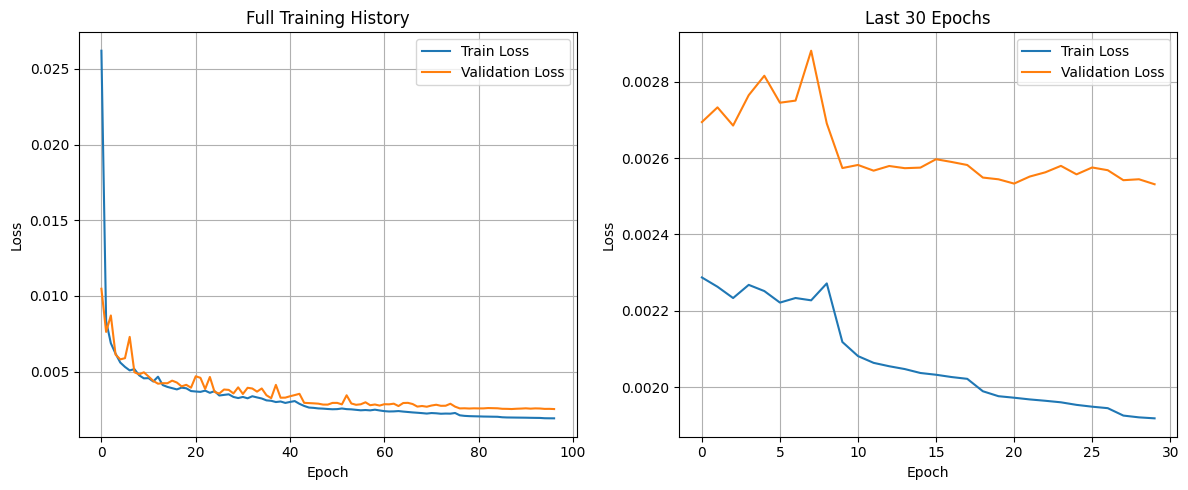


Training completed in 0.06 minutes
Best validation loss: inf


In [ ]:
# Run training if this cell is executed
if __name__ == "__main__":
   
    # Initialize model
    model = BaseAutoencoder(latent_dim=256)
    
    # Create configuration
    config = TrainingConfig(
    latent_dim=256,
    batch_size=8,              # Increased from 2 to 8
    accumulation_steps=8,      # Increased from 4 to 8 (effective batch size = 64)
    learning_rate=1e-4,
    epochs=100,
    early_stopping_patience=10,
    use_mixed_precision=True,
    num_workers=4,             # Increased from 2 to 4
    model_name="autoencoder_v1"
)
    
    # Train model
    print("\nStarting training...")
    train_losses, val_losses, trained_model = train_autoencoder(
        model, train_loader, val_loader, config
    )


### Evaluation and Result Visualization

In [23]:
# Cell 14: Model Evaluation and Visualization
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm

def load_trained_model(checkpoint_dir, model_name, latent_dim=256):
    """Load best trained model for evaluation"""
    model_path = Path(checkpoint_dir) / f"{model_name}_best.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"
    
    if not model_path.exists():
        # Try loading checkpoint if best model doesn't exist
        model_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
        if not model_path.exists():
            raise FileNotFoundError(f"No model found at {model_path}")
        
        # Load from checkpoint
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = BaseAutoencoder(latent_dim=latent_dim)
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        # Load best model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = BaseAutoencoder(latent_dim=latent_dim)
        model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Load training history
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
    else:
        metadata = {"train_losses": [], "val_losses": []}
    
    model.eval()
    model.to(device)
    
    return model, metadata

def plot_training_history(metadata):
    """Plot training and validation loss history"""
    plt.figure(figsize=(12, 5))
    
    train_losses = metadata["train_losses"]
    val_losses = metadata["val_losses"]
    
    # Plot full history
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Full Training History')
    plt.legend()
    plt.grid(True)
    
    # Plot recent history (last 30 epochs or all if < 30)
    plt.subplot(1, 2, 2)
    recent = min(30, len(train_losses))
    if recent > 5:  # Only plot recent history if we have enough epochs
        plt.plot(train_losses[-recent:], label='Train Loss')
        plt.plot(val_losses[-recent:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Last {recent} Epochs')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_reconstruction_samples(model, dataloader, num_samples=3):
    """Visualize original vs reconstructed volumes for samples from the dataset"""
    device = next(model.parameters()).device
    
    # Get samples from dataloader
    samples = []
    labels = []
    
    for batch in dataloader:
        volumes = batch['volume']
        batch_labels = batch['label']
        
        for i in range(min(len(volumes), num_samples - len(samples))):
            samples.append(volumes[i:i+1])
            labels.append(batch_labels[i])
            
        if len(samples) >= num_samples:
            break
    
    # Visualize each sample
    with torch.no_grad():
        for idx, (sample, label) in enumerate(zip(samples, labels)):
            # Get original volume
            orig_vol = sample.to(device)
            
            # Generate reconstruction
            reconstructed = model(orig_vol)
            
            # Move to CPU for visualization
            orig_vol = orig_vol.cpu().squeeze().numpy()
            recon_vol = reconstructed.cpu().squeeze().numpy()
            
            # Create figure for this sample
            fig = plt.figure(figsize=(15, 10))
            plt.suptitle(f"Sample {idx+1} - Group: {label}", fontsize=16)
            
            # Define slice indices (midpoint by default)
            z_slice = orig_vol.shape[0] // 2
            y_slice = orig_vol.shape[1] // 2
            x_slice = orig_vol.shape[2] // 2
            
            # Plot original slices
            plt.subplot(2, 3, 1)
            plt.imshow(orig_vol[z_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Axial")
            plt.axis('off')
            
            plt.subplot(2, 3, 2)
            plt.imshow(orig_vol[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Coronal")
            plt.axis('off')
            
            plt.subplot(2, 3, 3)
            plt.imshow(orig_vol[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Sagittal")
            plt.axis('off')
            
            # Plot reconstructed slices
            plt.subplot(2, 3, 4)
            plt.imshow(recon_vol[z_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Reconstructed - Axial")
            plt.axis('off')
            
            plt.subplot(2, 3, 5)
            plt.imshow(recon_vol[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
            plt.title("Reconstructed - Coronal")
            plt.axis('off')
            
            plt.subplot(2, 3, 6)
            plt.imshow(recon_vol[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Reconstructed - Sagittal")
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def compute_reconstruction_error(model, dataloader):
    """Compute detailed reconstruction error metrics on validation set"""
    device = next(model.parameters()).device
    criterion = nn.MSELoss(reduction='none')
    
    total_mse = 0
    total_samples = 0
    error_by_label = {}
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            labels = batch['label']
            
            # Get reconstructions
            reconstructed = model(volumes)
            
            # Compute MSE loss per sample
            mse = criterion(reconstructed, volumes)
            
            # Average over dimensions
            mse = mse.mean(dim=(1, 2, 3, 4)).cpu().numpy()
            
            # Track overall error
            total_mse += mse.sum()
            total_samples += volumes.shape[0]
            
            # Track error by label
            for i, label in enumerate(labels):
                if label not in error_by_label:
                    error_by_label[label] = []
                error_by_label[label].append(mse[i])
    
    # Calculate overall metrics
    avg_mse = total_mse / total_samples
    rmse = np.sqrt(avg_mse)
    
    print("\nReconstruction Error Metrics:")
    print(f"Overall MSE: {avg_mse:.6f}")
    print(f"Overall RMSE: {rmse:.6f}")
    
    # Calculate metrics by group
    print("\nReconstruction Error by Group:")
    for label, errors in error_by_label.items():
        group_mse = np.mean(errors)
        group_rmse = np.sqrt(group_mse)
        group_std = np.std(errors)
        print(f"{label}:")
        print(f"  MSE: {group_mse:.6f} ± {group_std:.6f}")
        print(f"  RMSE: {group_rmse:.6f}")
    
    # Plot error distribution by group
    plt.figure(figsize=(10, 6))
    for label, errors in error_by_label.items():
        plt.hist(errors, alpha=0.5, label=label, bins=20)
    
    plt.title("Reconstruction Error Distribution by Group")
    plt.xlabel("Mean Squared Error")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return avg_mse, error_by_label

def extract_latent_vectors(model, dataloader, max_samples=None):
    """Extract latent vectors from all samples in the dataloader"""
    device = next(model.parameters()).device
    
    latent_vectors = []
    labels = []
    paths = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting latent vectors"):
            volumes = batch['volume'].to(device)
            batch_labels = batch['label']
            batch_paths = batch['path']
            
            # Extract latent vectors
            z = model.encode(volumes)
            
            # Store results
            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch_labels)
            paths.extend(batch_paths)
            
            # Check if we have enough samples
            if max_samples and len(labels) >= max_samples:
                latent_vectors = np.vstack(latent_vectors)
                latent_vectors = latent_vectors[:max_samples]
                labels = labels[:max_samples]
                paths = paths[:max_samples]
                break
    
    # Stack all latent vectors if we didn't break early
    if isinstance(latent_vectors[0], np.ndarray):
        latent_vectors = np.vstack(latent_vectors)
    
    return latent_vectors, labels, paths

def visualize_latent_space(latent_vectors, labels, method='tsne'):
    """Visualize latent space using t-SNE or PCA"""
    plt.figure(figsize=(10, 8))
    
    # Create label-to-color mapping for consistent colors
    unique_labels = list(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Apply dimensionality reduction
    if method.lower() == 'tsne':
        print("Computing t-SNE projection...")
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(latent_vectors) - 1))
        title = 't-SNE Visualization of Latent Space'
    else:
        print("Computing PCA projection...")
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Space'
    
    # Apply reduction
    reduced_vecs = reducer.fit_transform(latent_vectors)
    
    # Create scatter plot
    for label in unique_labels:
        # Get indices where this label appears
        indices = [i for i, l in enumerate(labels) if l == label]
        
        # Plot these points
        plt.scatter(
            reduced_vecs[indices, 0], 
            reduced_vecs[indices, 1],
            label=label, 
            color=label_to_color[label], 
            alpha=0.7,
            edgecolor='w',
            s=100
        )
    
    plt.title(title, fontsize=14)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Group", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return reduced_vecs

def plot_latent_dimension_activation(latent_vectors, labels):
    """Analyze activation patterns of latent dimensions"""
    # Create a DataFrame with latent dimensions and labels
    import pandas as pd
    
    # First, convert labels to categorical for better plotting
    unique_labels = list(set(labels))
    label_map = {label: i for i, label in enumerate(unique_labels)}
    label_indices = [label_map[label] for label in labels]
    
    # Create DataFrames
    latent_df = pd.DataFrame(latent_vectors)
    latent_df['label'] = labels
    
    # Compute mean activation by group
    mean_activations = {}
    for label in unique_labels:
        group_vectors = latent_vectors[np.array(labels) == label]
        mean_activations[label] = np.mean(group_vectors, axis=0)
    
    # Identify top discriminative dimensions
    activation_matrix = np.vstack([mean_activations[label] for label in unique_labels])
    variance = np.var(activation_matrix, axis=0)
    top_dims = np.argsort(variance)[-10:]  # Top 10 dimensions
    
    # Plot mean activation for top dimensions
    plt.figure(figsize=(14, 6))
    
    # Plot heatmap
    plt.subplot(1, 2, 1)
    heatmap_data = pd.DataFrame({
        f"Dim {i}": [mean_activations[label][i] for label in unique_labels]
        for i in top_dims
    })
    heatmap_data.index = unique_labels
    
    sns.heatmap(heatmap_data, cmap='coolwarm', center=0, 
               annot=True, fmt=".2f", cbar_kws={'label': 'Mean Activation'})
    plt.title("Mean Activation of Top Discriminative Dimensions")
    
    # Plot box plots for top 5 dimensions
    plt.subplot(1, 2, 2)
    
    # Create data for boxplot
    plot_data = []
    labels_for_plot = []
    positions = []
    
    for i, dim in enumerate(top_dims[:5]):  # Top 5 for clarity
        for j, label in enumerate(unique_labels):
            group_values = latent_vectors[np.array(labels) == label, dim]
            plot_data.append(group_values)
            labels_for_plot.append(f"{label}")
            positions.append(i + j * 0.25)
    
    # Create boxplot
    boxplot = plt.boxplot(plot_data, positions=positions, patch_artist=True, widths=0.15)
    
    # Customize boxplot colors
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    for i, label in enumerate(unique_labels):
        indices = [j for j, l in enumerate(labels_for_plot) if l == label]
        for idx in indices:
            boxplot['boxes'][idx].set_facecolor(colors[i])
    
    # Add labels and ticks
    plt.xticks([i + (len(unique_labels) - 1) * 0.125 for i in range(5)], 
              [f"Dim {d}" for d in top_dims[:5]])
    plt.title("Distribution of Top 5 Discriminative Dimensions")
    plt.ylabel("Activation Value")
    
    # Add legend
    for i, label in enumerate(unique_labels):
        plt.plot([], [], 'o', color=colors[i], label=label)
    plt.legend(title="Group")
    
    plt.tight_layout()
    plt.show()
    
    return top_dims

def find_outliers(model, dataloader, threshold_std=2.5):
    """Identify outliers based on reconstruction error"""
    device = next(model.parameters()).device
    criterion = nn.MSELoss(reduction='none')
    
    all_errors = []
    all_paths = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Finding outliers"):
            volumes = batch['volume'].to(device)
            paths = batch['path']
            labels = batch['label']
            
            # Get reconstructions
            reconstructed = model(volumes)
            
            # Compute MSE loss per sample
            mse = criterion(reconstructed, volumes)
            
            # Average over dimensions
            mse = mse.mean(dim=(1, 2, 3, 4)).cpu().numpy()
            
            # Store results
            all_errors.extend(mse)
            all_paths.extend(paths)
            all_labels.extend(labels)
    
    # Convert to numpy arrays
    all_errors = np.array(all_errors)
    
    # Compute statistics
    mean_error = np.mean(all_errors)
    std_error = np.std(all_errors)
    
    # Find outliers (samples with error > mean + threshold_std * std)
    threshold = mean_error + threshold_std * std_error
    outlier_indices = np.where(all_errors > threshold)[0]
    
    print(f"\nOutlier Analysis:")
    print(f"Mean error: {mean_error:.6f}")
    print(f"Error standard deviation: {std_error:.6f}")
    print(f"Outlier threshold: {threshold:.6f}")
    print(f"Found {len(outlier_indices)} outliers out of {len(all_errors)} samples ({len(outlier_indices)/len(all_errors)*100:.2f}%)")
    
    # Create dictionary of outliers
    outliers = {
        all_paths[i]: {
            'error': all_errors[i],
            'label': all_labels[i],
            'z_score': (all_errors[i] - mean_error) / std_error
        }
        for i in outlier_indices
    }
    
    # Plot error distribution with outlier threshold
    plt.figure(figsize=(10, 6))
    plt.hist(all_errors, bins=30, alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold_std} std)')
    plt.title("Reconstruction Error Distribution")
    plt.xlabel("Mean Squared Error")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return outliers, all_errors, all_paths, all_labels

def visualize_outliers(model, outliers, threshold=0.01):
    """Visualize the top outliers with highest reconstruction error"""
    device = next(model.parameters()).device
    
    # Sort outliers by error (descending)
    sorted_outliers = sorted(outliers.items(), key=lambda x: x[1]['error'], reverse=True)
    
    # Visualize top outliers
    num_outliers = min(5, len(sorted_outliers))
    
    for i in range(num_outliers):
        path, info = sorted_outliers[i]
        error = info['error']
        label = info['label']
        z_score = info['z_score']
        
        try:
            # Load the original volume
            with torch.no_grad():
                # Load DICOM file
                original_volume, _ = load_dicom(path)
                original_volume = original_volume[9:73, :, :]
                
                # Process volume
                norm_vol, _, _ = process_volume(original_volume, target_shape=(64, 128, 128))
                
                # Convert to tensor and add batch dimension
                vol_tensor = torch.from_numpy(np.expand_dims(norm_vol, axis=(0, 1))).float().to(device)
                
                # Get reconstruction
                reconstructed = model(vol_tensor)
                
                # Move tensors to CPU and remove batch and channel dimensions
                vol_np = vol_tensor.cpu().squeeze().numpy()
                recon_np = reconstructed.cpu().squeeze().numpy()
                
                # Create figure
                fig = plt.figure(figsize=(15, 10))
                plt.suptitle(f"Outlier {i+1}: {path.split('/')[-1]}\nGroup: {label}, Error: {error:.6f}, Z-score: {z_score:.2f}", fontsize=14)
                
                # Define slice indices
                z_slice = vol_np.shape[0] // 2
                y_slice = vol_np.shape[1] // 2
                x_slice = vol_np.shape[2] // 2
                
                # Plot original axial slice
                plt.subplot(2, 3, 1)
                plt.imshow(vol_np[z_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Original - Axial")
                plt.axis('off')
                
                # Plot original coronal slice
                plt.subplot(2, 3, 2)
                plt.imshow(vol_np[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
                plt.title("Original - Coronal")
                plt.axis('off')
                
                # Plot original sagittal slice
                plt.subplot(2, 3, 3)
                plt.imshow(vol_np[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Original - Sagittal")
                plt.axis('off')
                
                # Plot reconstructed axial slice
                plt.subplot(2, 3, 4)
                plt.imshow(recon_np[z_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Reconstructed - Axial")
                plt.axis('off')
                
                # Plot reconstructed coronal slice
                plt.subplot(2, 3, 5)
                plt.imshow(recon_np[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
                plt.title("Reconstructed - Coronal")
                plt.axis('off')
                
                # Plot reconstructed sagittal slice
                plt.subplot(2, 3, 6)
                plt.imshow(recon_np[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
                plt.title("Reconstructed - Sagittal")
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
        except Exception as e:
            print(f"Error visualizing outlier {path}: {e}")

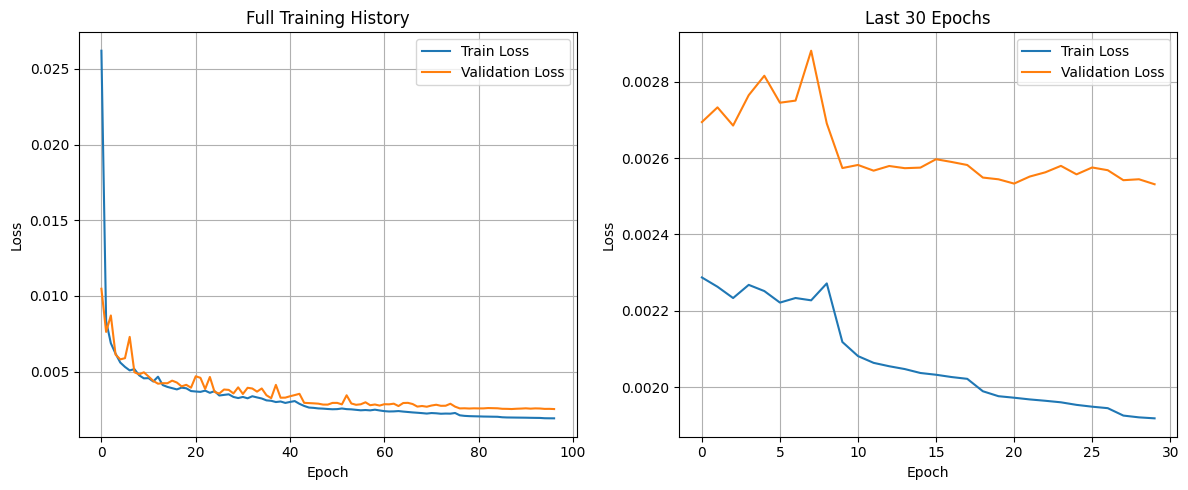

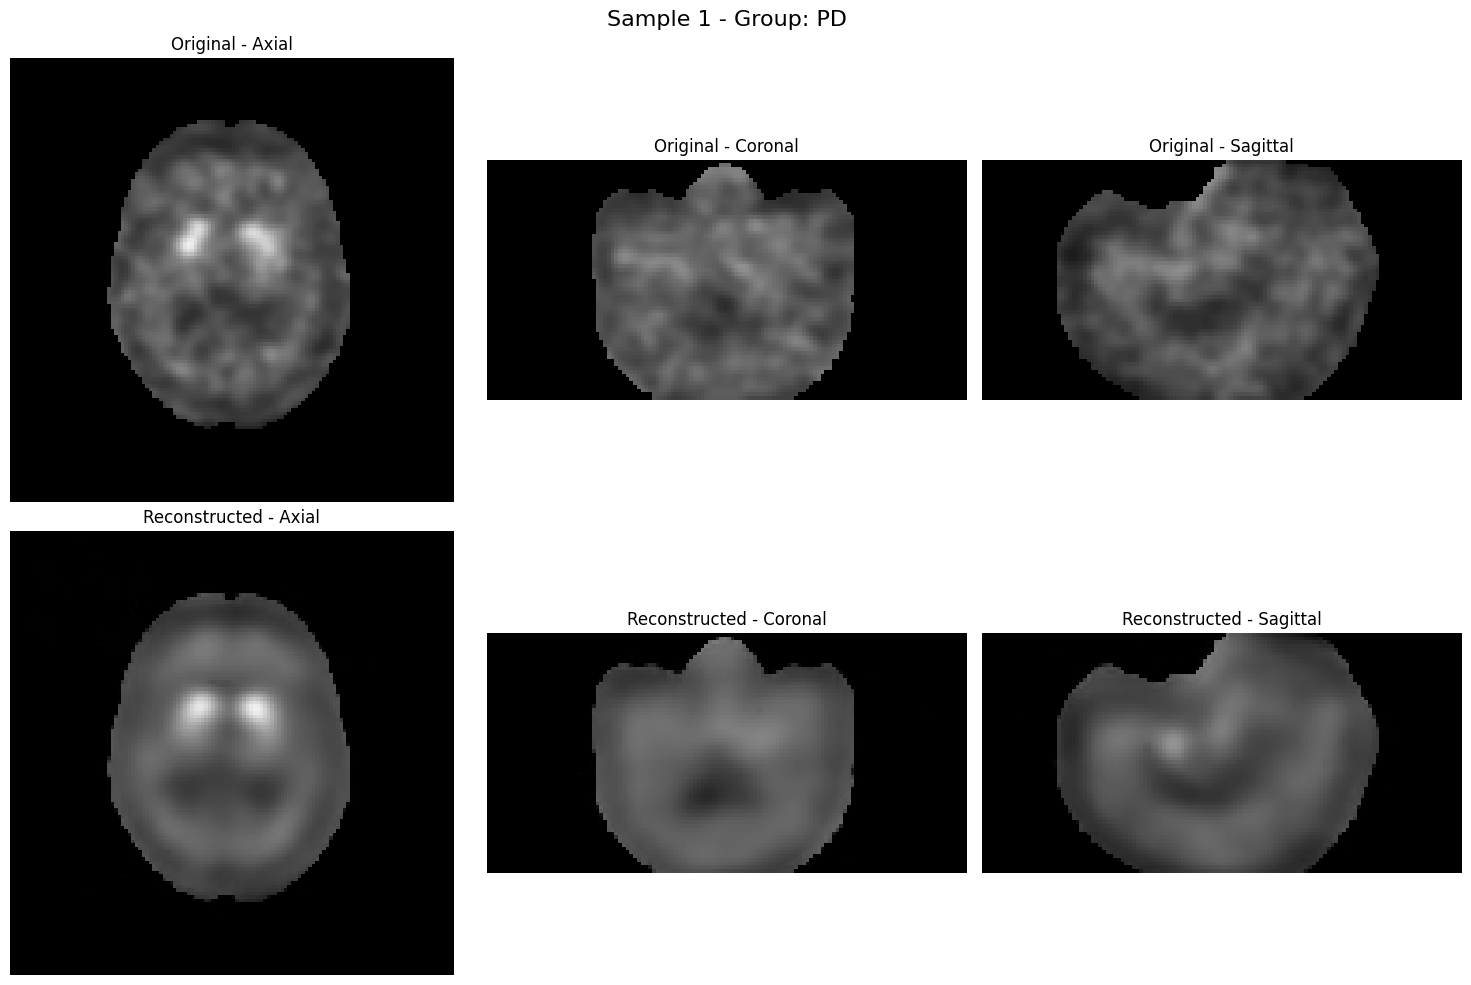

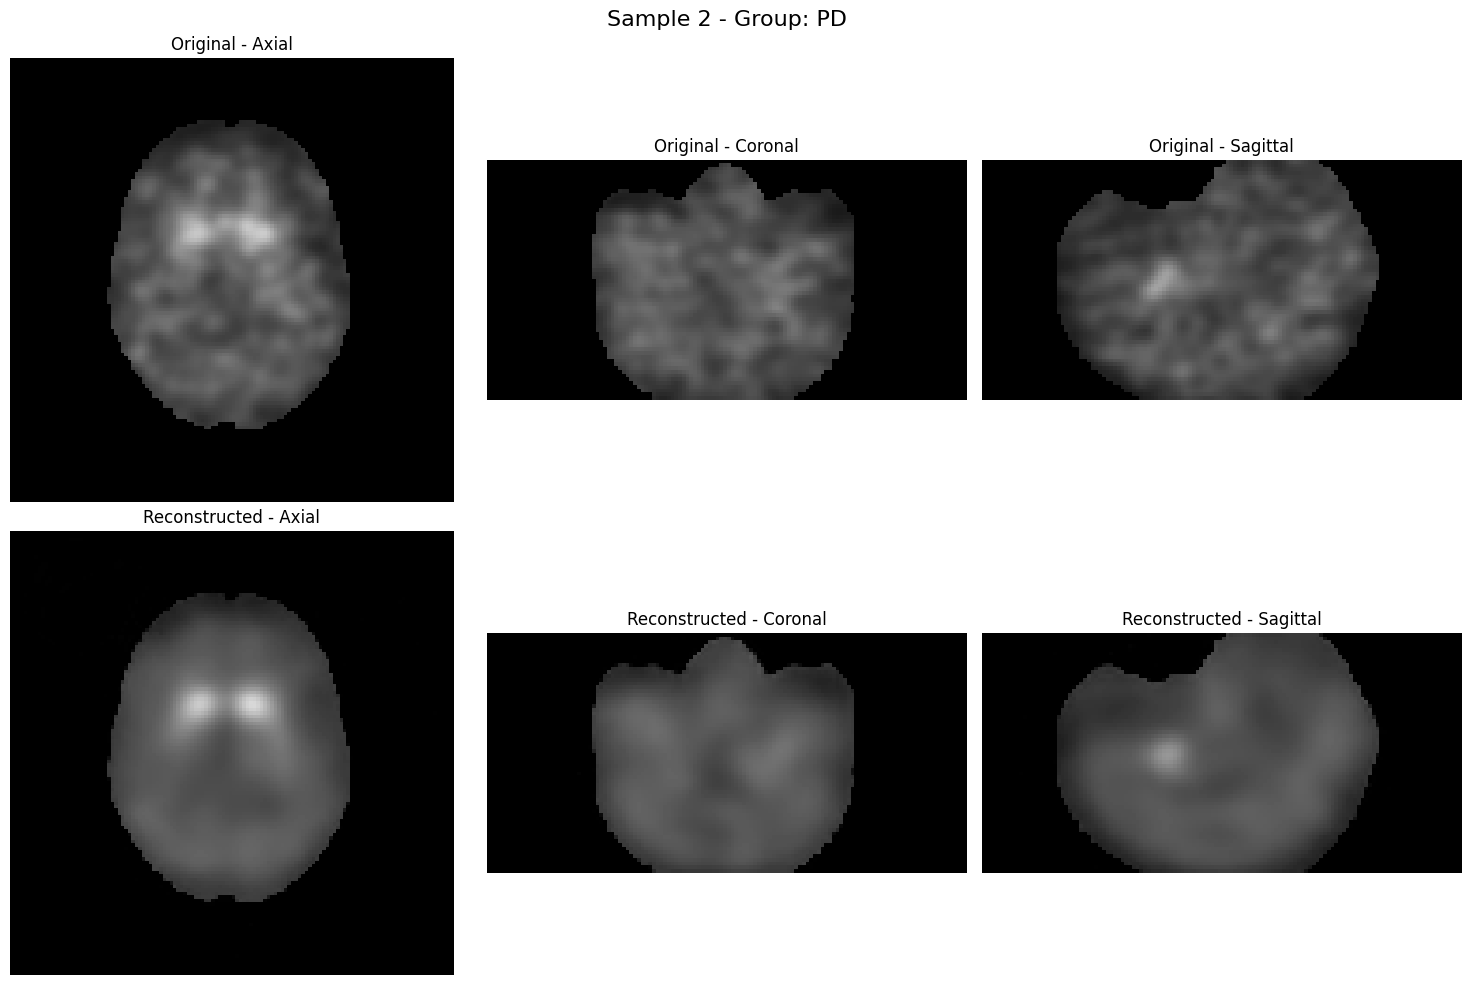

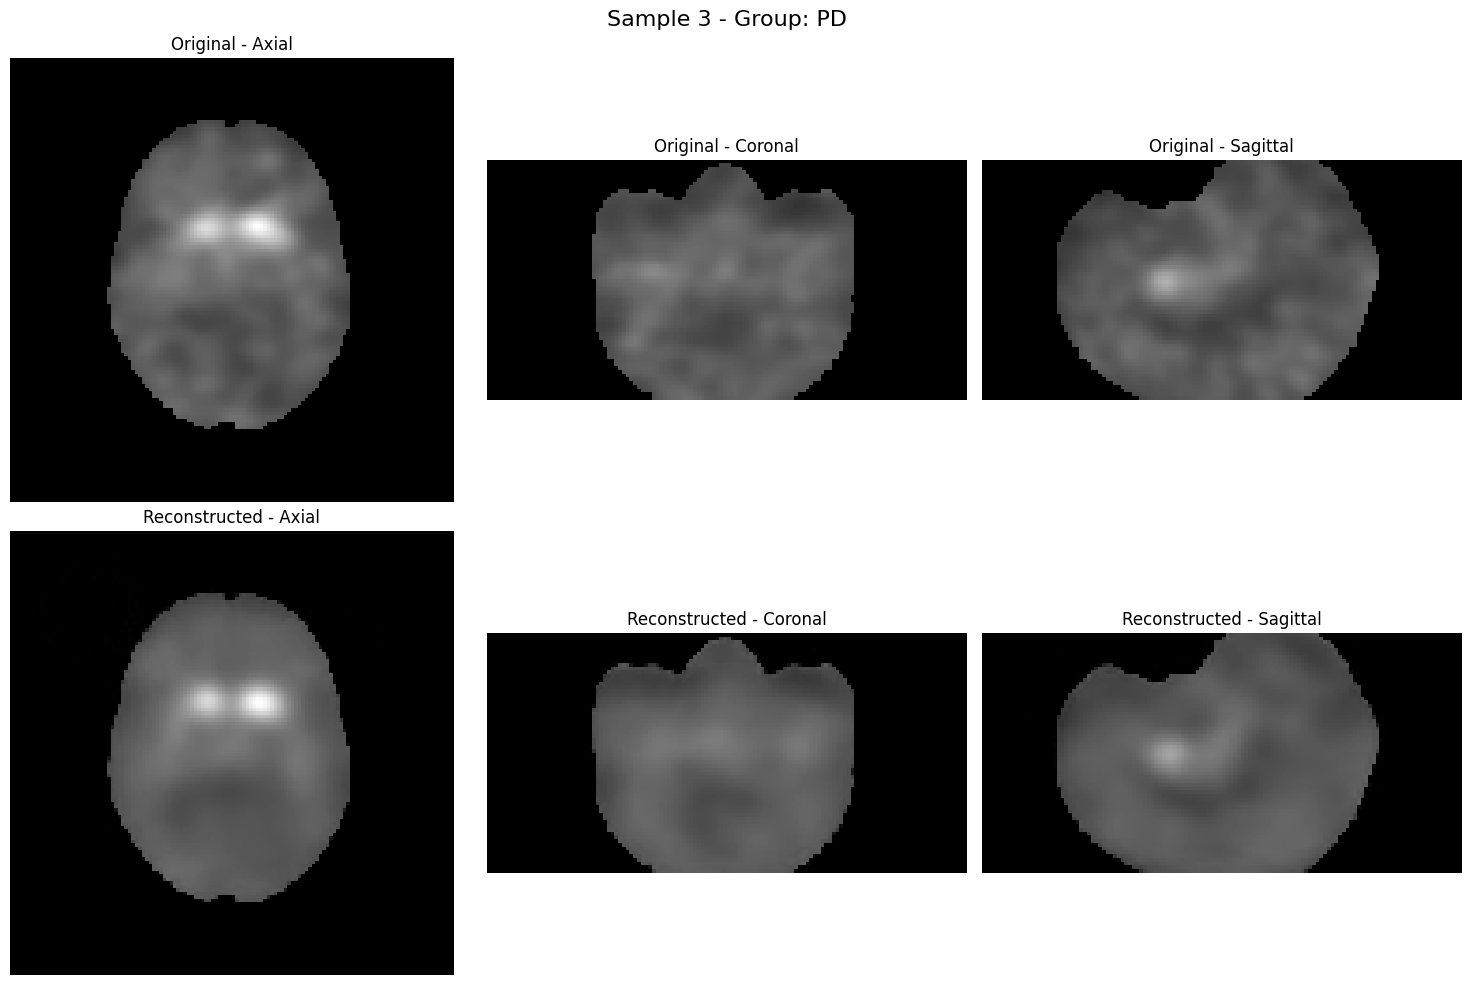

Computing metrics:   5%|▍         | 14/299 [00:01<00:20, 13.77it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Computing metrics:  21%|██▏       | 64/299 [00:04<00:18, 12.78it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Computing metrics:  49%|████▉     | 148/299 [00:10<00:10, 14.79it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Computing metrics: 100%|██████████| 299/299 [00:20<00:00, 14.46it/s]



Reconstruction Error Metrics:
Overall MSE: 0.002531
Overall RMSE: 0.050312

Reconstruction Error by Group:
PD:
  MSE: 0.002480 ± 0.001436
  RMSE: 0.049804
Control:
  MSE: 0.002993 ± 0.001054
  RMSE: 0.054708
SWEDD:
  MSE: 0.002486 ± 0.001273
  RMSE: 0.049863


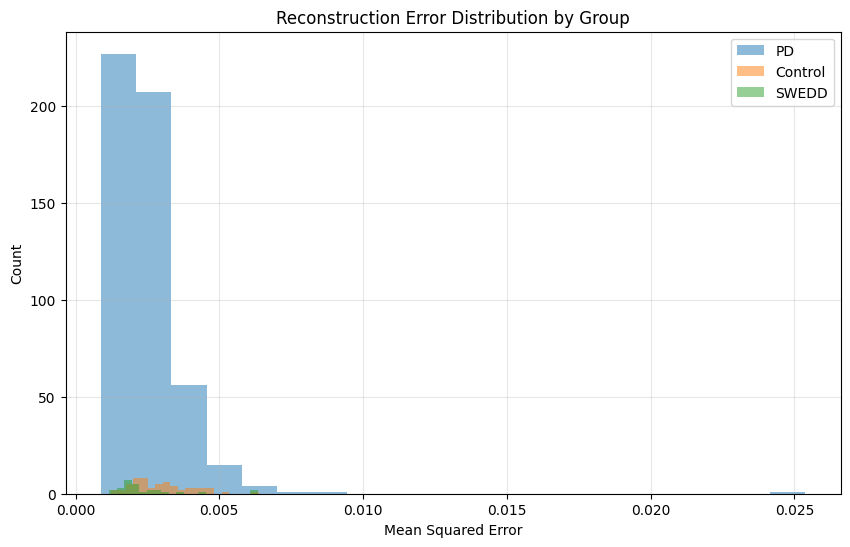

Extracting latent vectors:   4%|▍         | 13/299 [00:00<00:17, 16.22it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Extracting latent vectors:  21%|██        | 62/299 [00:05<00:14, 16.45it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Extracting latent vectors:  33%|███▎      | 99/299 [00:07<00:16, 12.42it/s]


Computing t-SNE projection...


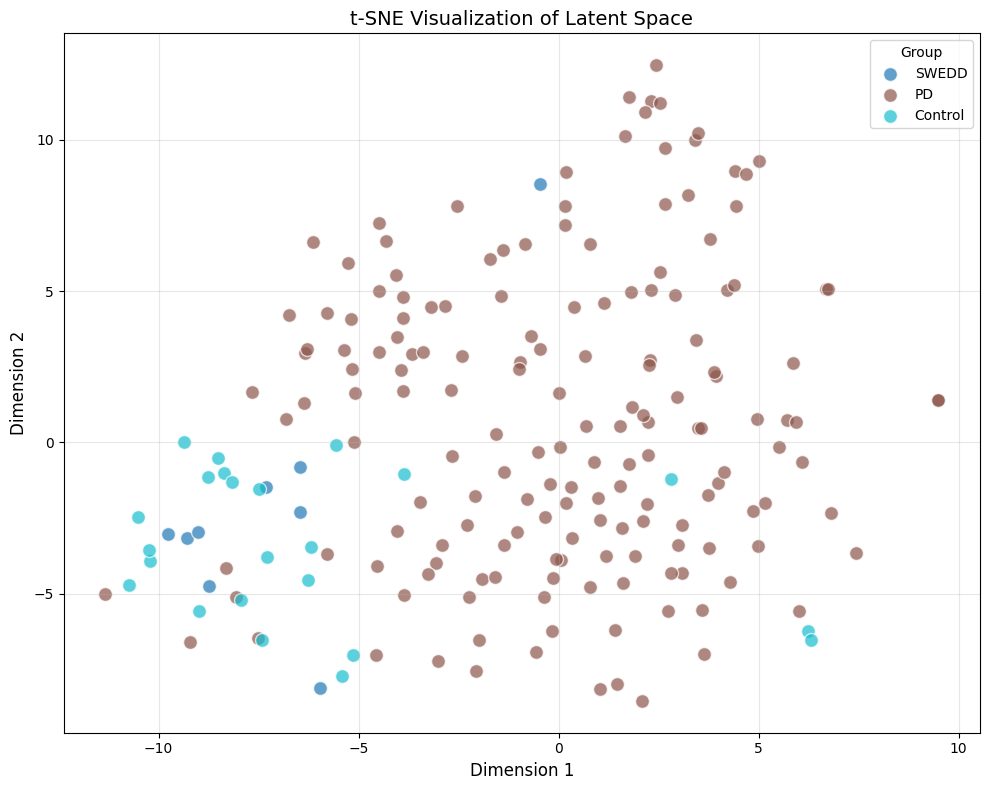

Computing PCA projection...


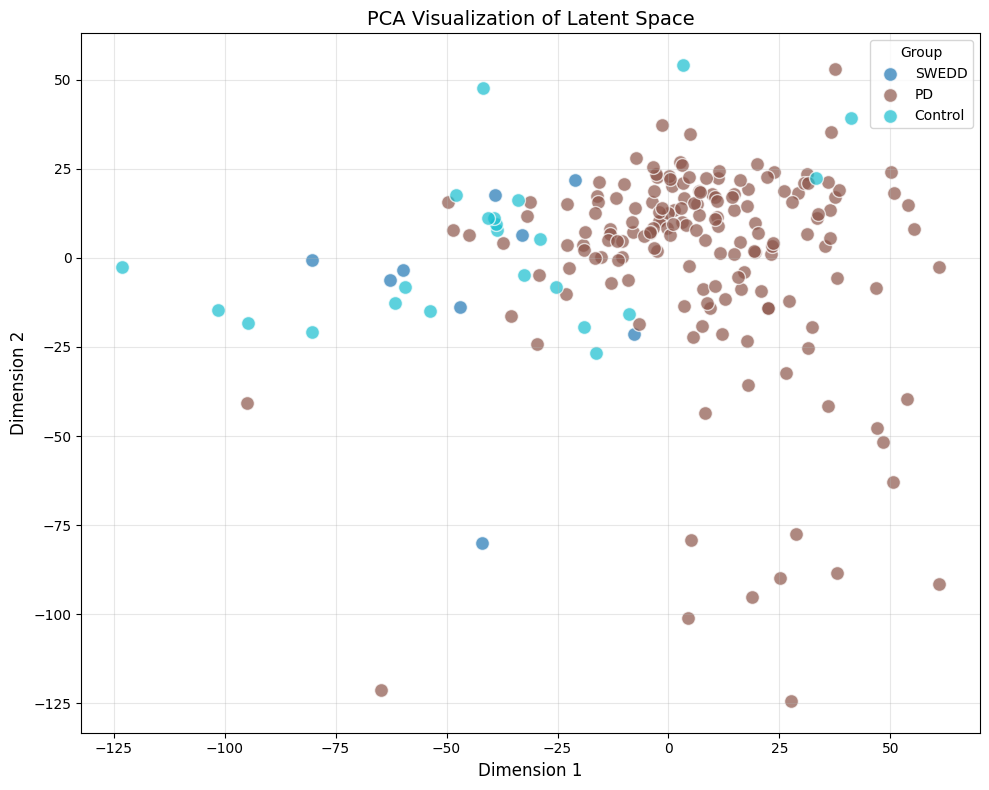

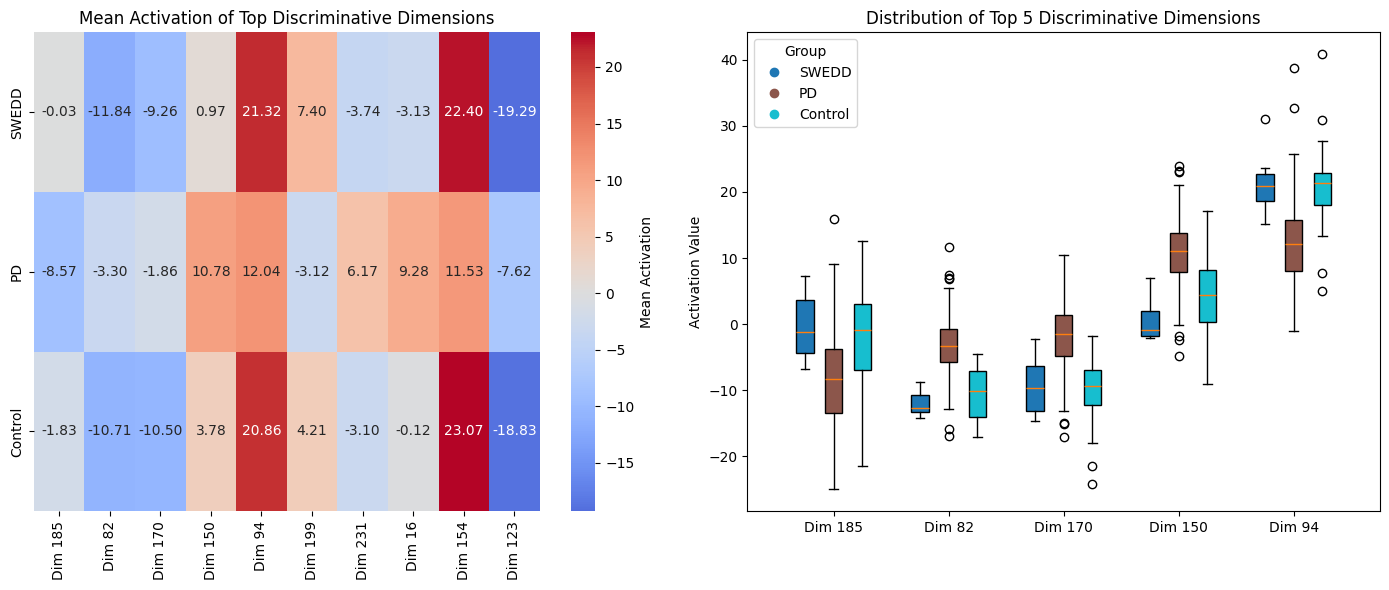

Finding outliers:   4%|▍         | 13/299 [00:00<00:17, 16.38it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Finding outliers:  21%|██        | 62/299 [00:03<00:13, 17.61it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Finding outliers:  49%|████▉     | 146/299 [00:08<00:08, 17.73it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Finding outliers: 100%|██████████| 299/299 [00:16<00:00, 18.39it/s]


Outlier Analysis:
Mean error: 0.002531
Error standard deviation: 0.001404
Outlier threshold: 0.006042
Found 10 outliers out of 598 samples (1.67%)


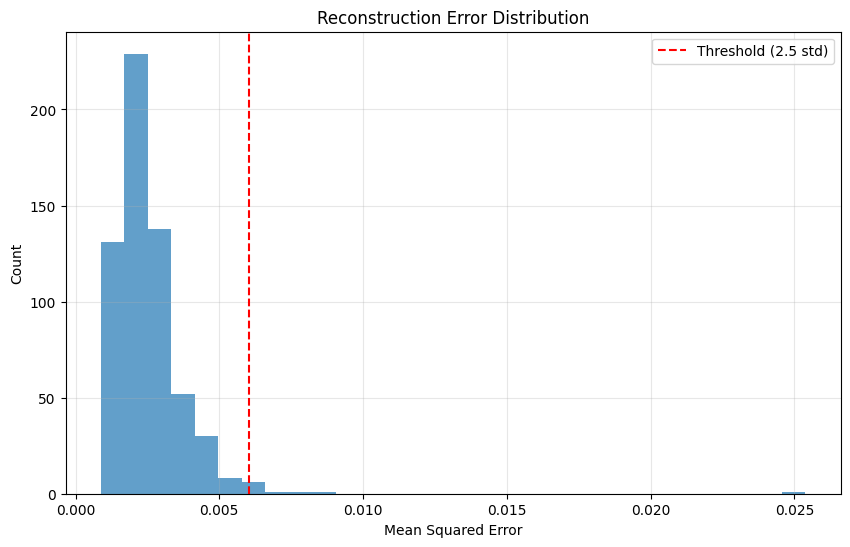

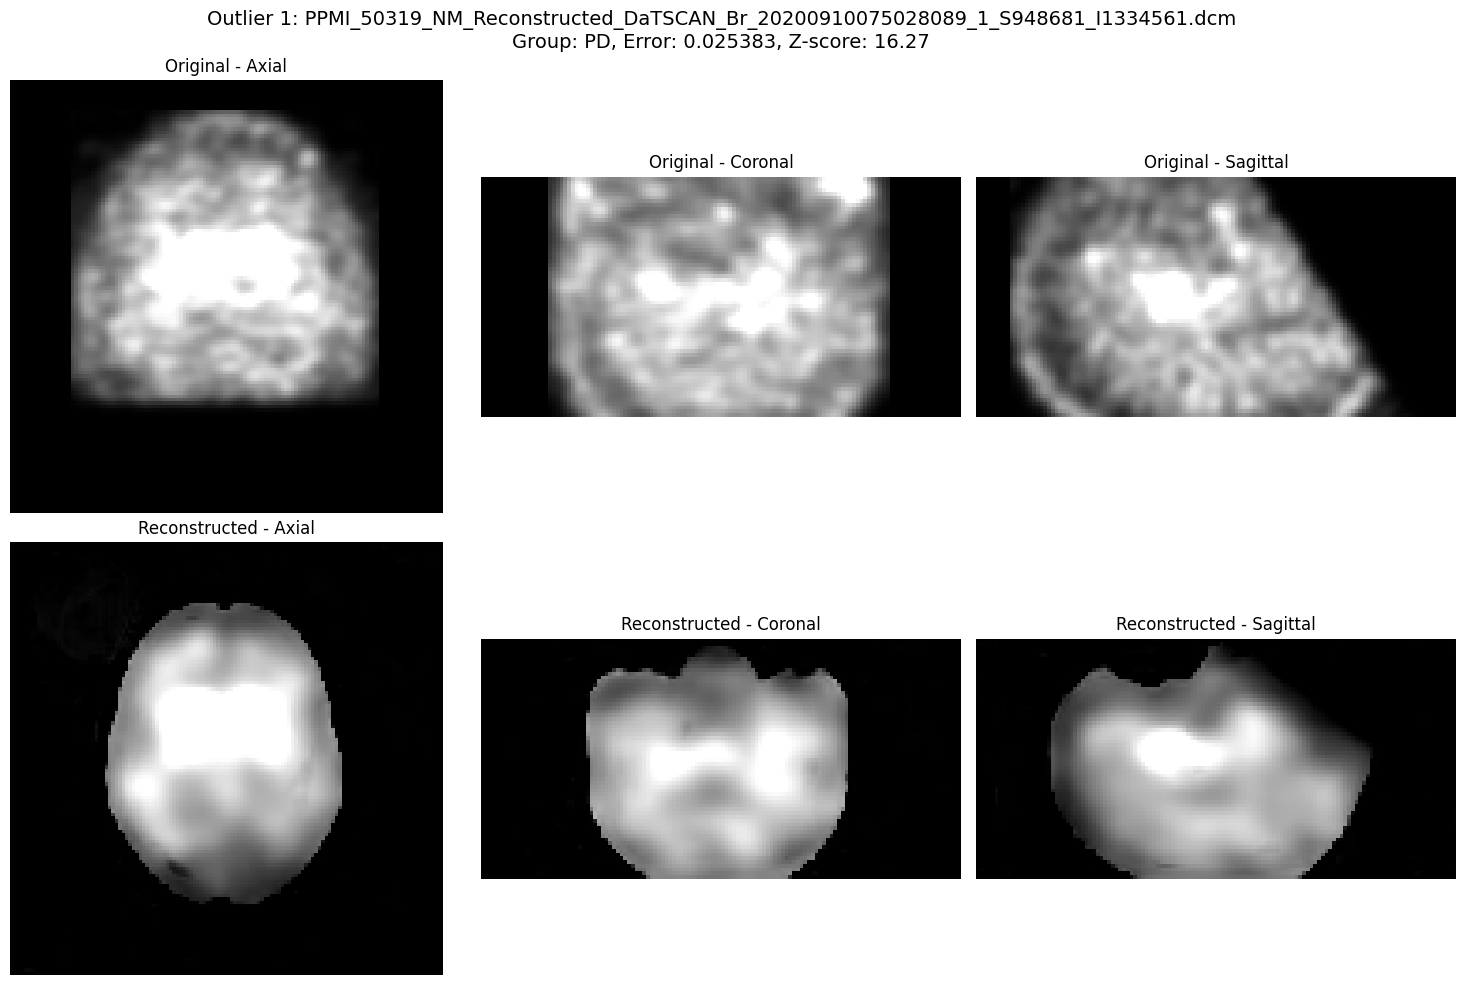

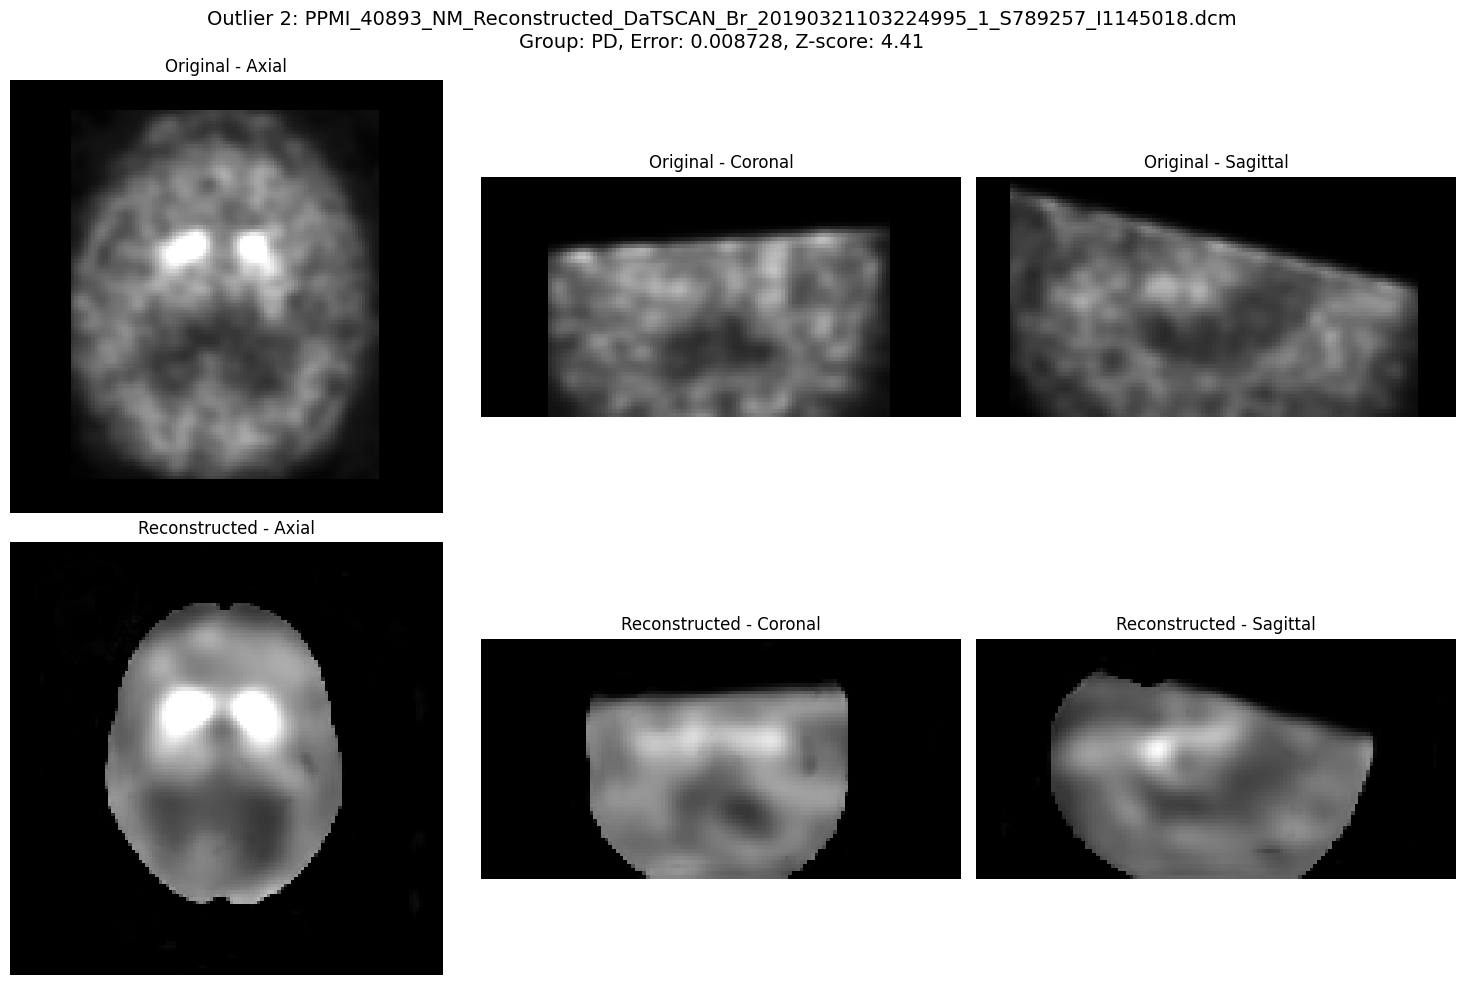

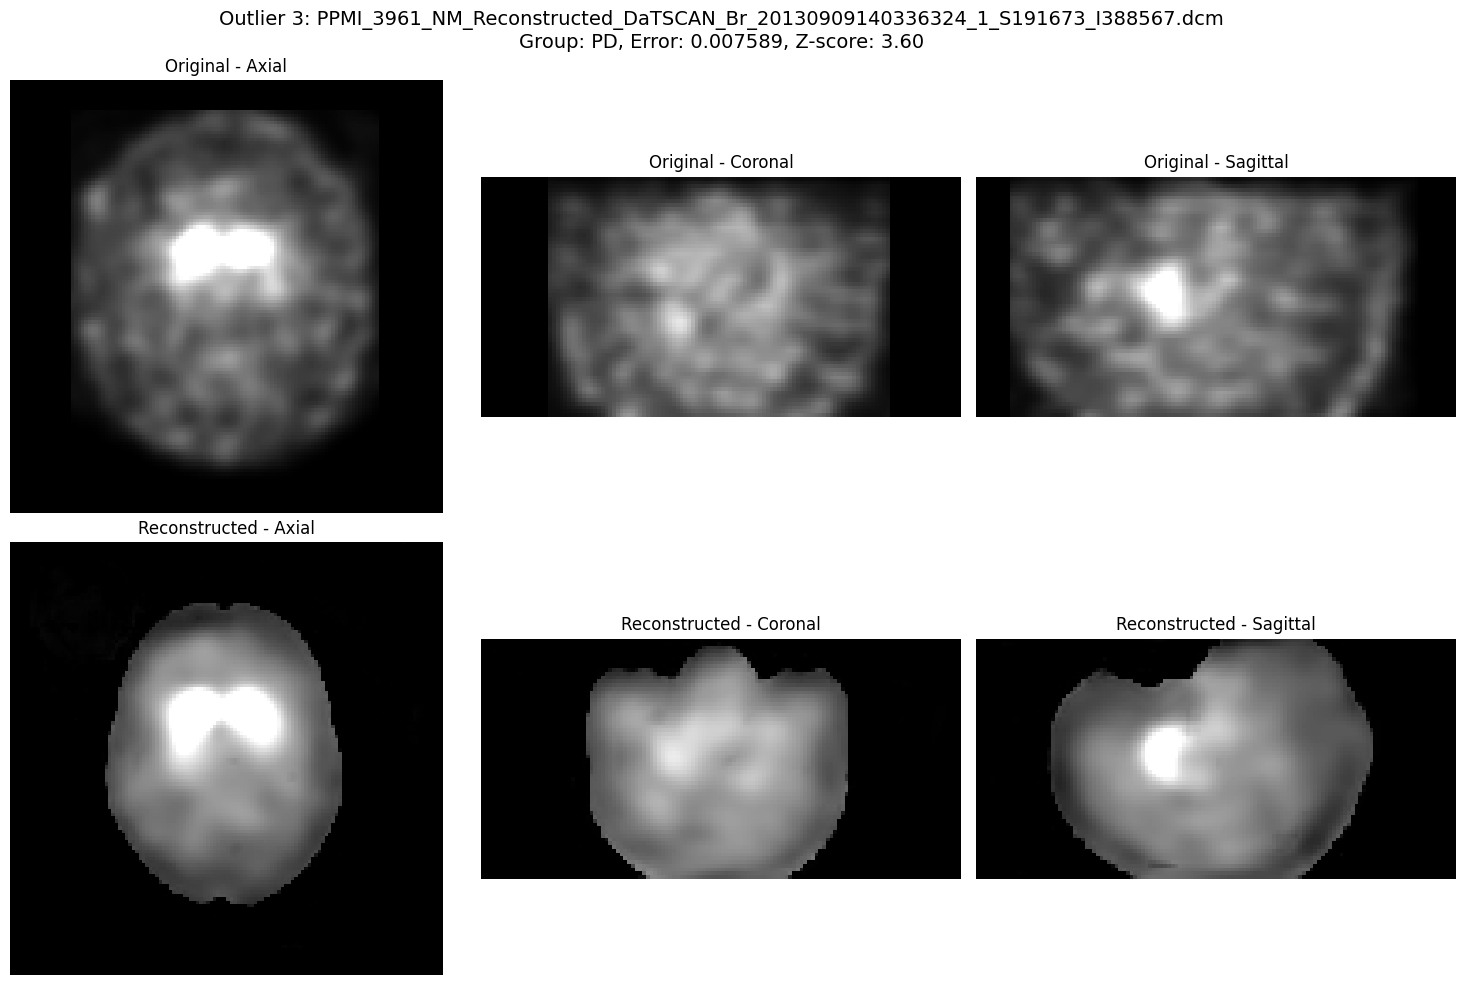

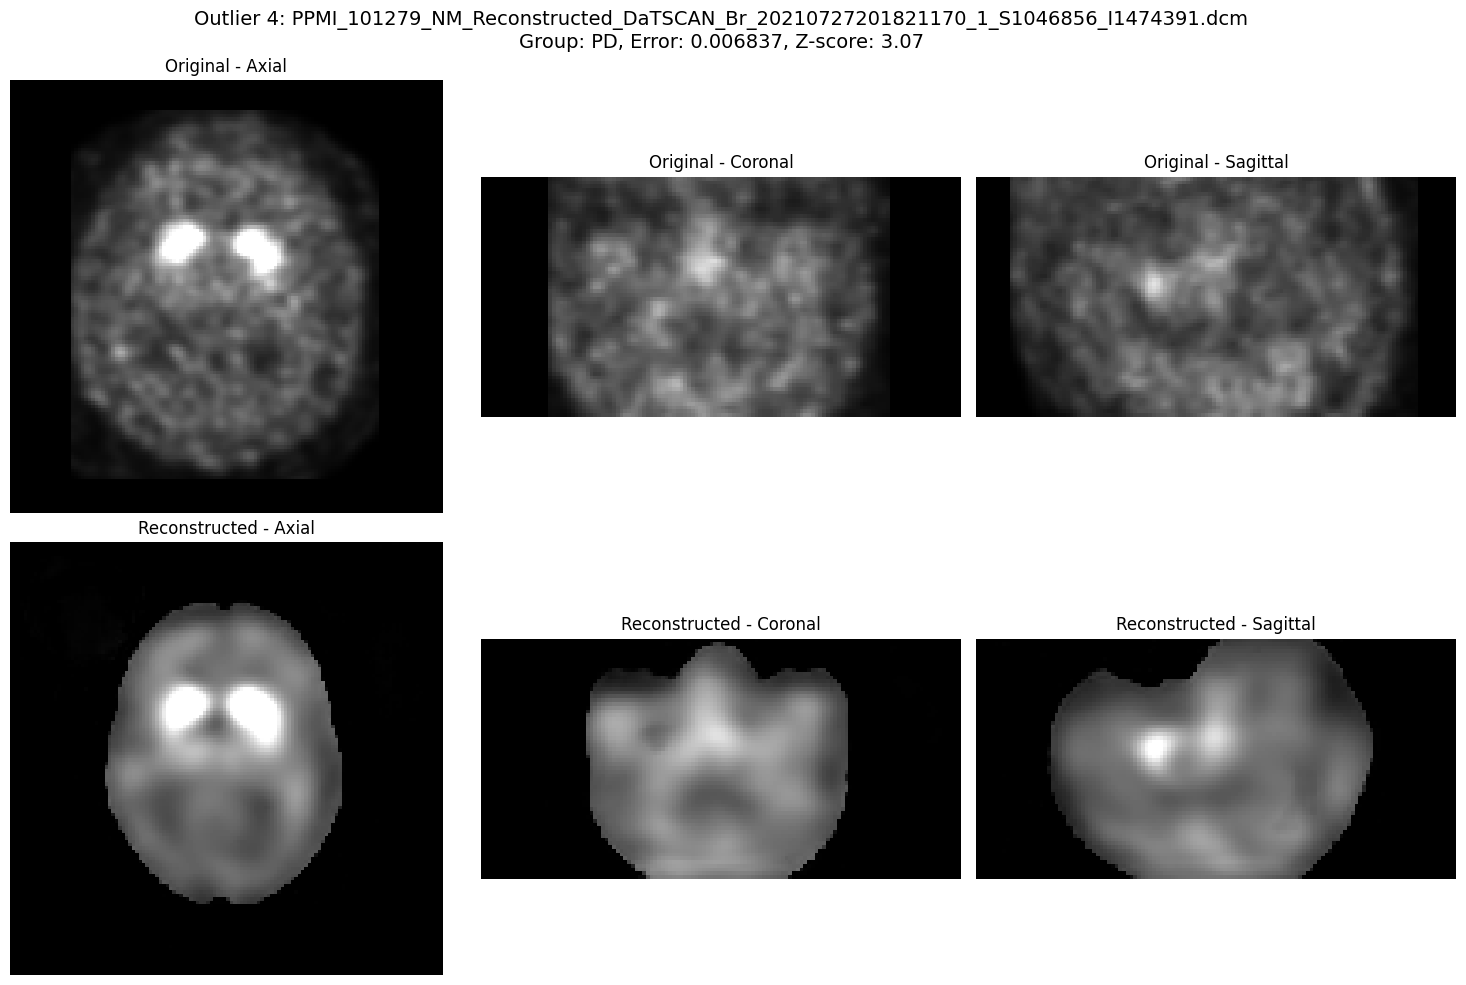

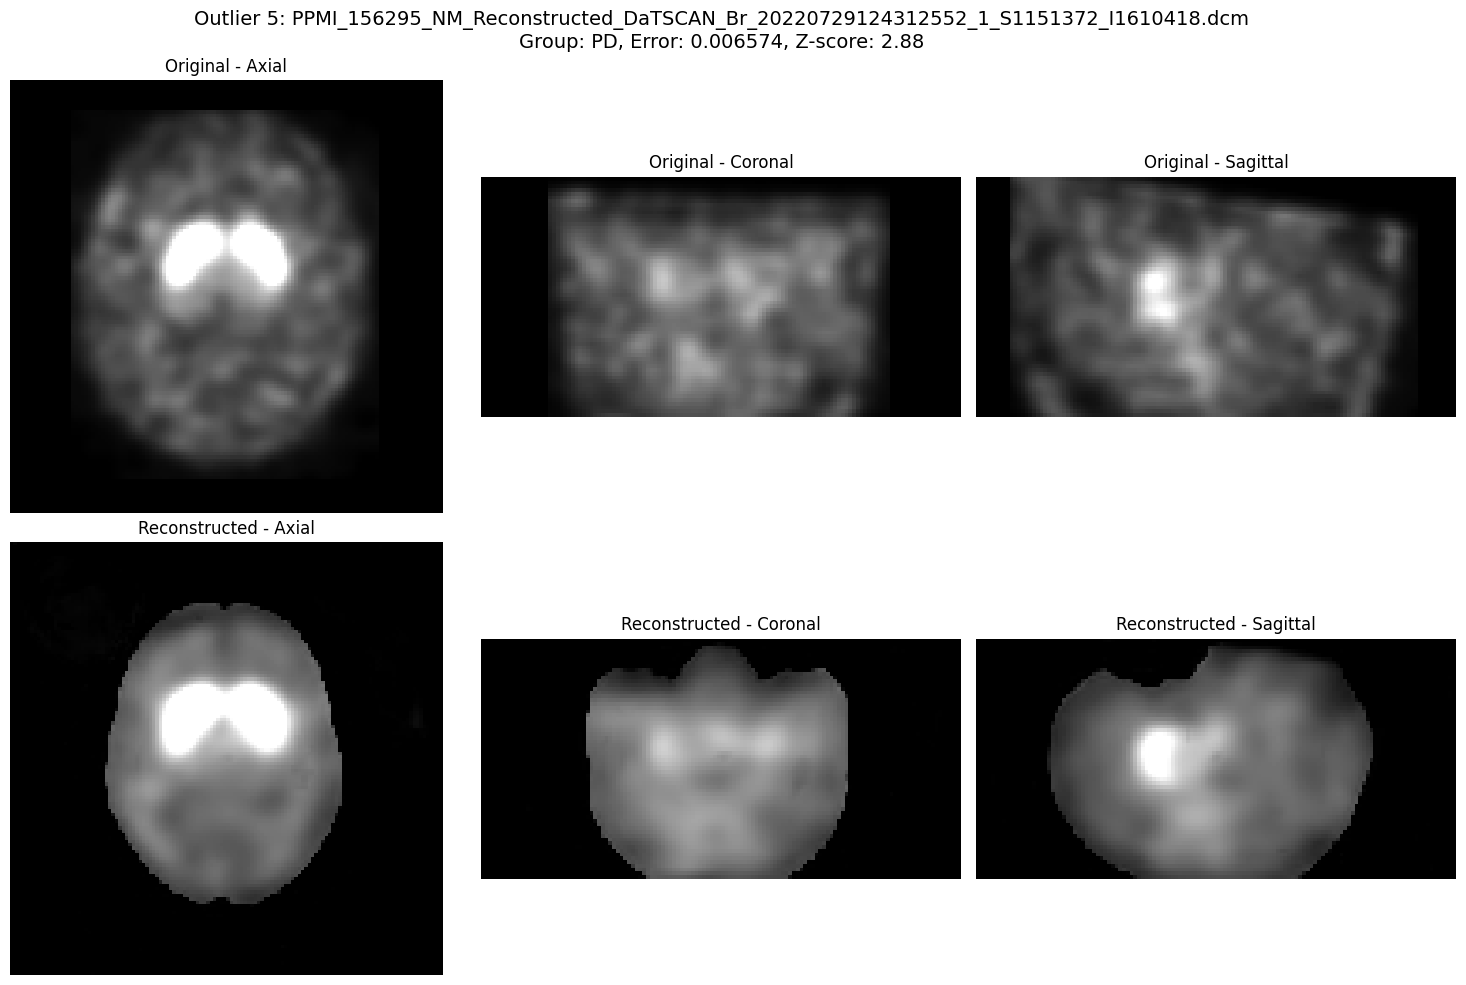

In [24]:
# Run evaluation if this cell is executed
if __name__ == "__main__":
    # Uncomment the following to run evaluation

    # Load model and metadata
    model, metadata = load_trained_model('checkpoints', 'autoencoder_v1', latent_dim=256)
    
    # Plot training history
    plot_training_history(metadata)
    
    # Visualize reconstructions
    visualize_reconstruction_samples(model, val_loader, num_samples=3)
    
    # Compute reconstruction error
    avg_mse, error_by_label = compute_reconstruction_error(model, val_loader)
    
    # Extract and visualize latent space
    latent_vectors, labels, paths = extract_latent_vectors(model, val_loader, max_samples=200)
    reduced_vecs = visualize_latent_space(latent_vectors, labels, method='tsne')
    reduced_vecs = visualize_latent_space(latent_vectors, labels, method='pca')
    
    # Analyze latent dimensions
    top_dims = plot_latent_dimension_activation(latent_vectors, labels)
    
    # Find and visualize outliers
    outliers, all_errors, all_paths, all_labels = find_outliers(model, val_loader, threshold_std=2.5)
    visualize_outliers(model, outliers)

In [25]:
# Cell 14b: Visualizing Latent Dimensions in Brain Space
import torch
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

def visualize_latent_dimension(model, dataloader, dimension_idx, alpha=5.0, group=None):
    """
    Visualize what a specific latent dimension represents by modifying it
    and observing the effect on brain reconstruction.
    
    Parameters:
        model: Trained autoencoder model
        dataloader: DataLoader containing samples
        dimension_idx: The latent dimension to manipulate (e.g., 231)
        alpha: Strength of the dimension manipulation
        group: Optional filter for specific patient group (e.g., 'PD', 'Control')
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Find a suitable sample (optionally from specific group)
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        paths = batch['path']
        
        if group is not None:
            # Find samples from the specified group
            group_indices = [i for i, label in enumerate(labels) if label == group]
            if not group_indices:
                continue
            # Use the first matching sample
            idx = group_indices[0]
            sample = volumes[idx:idx+1].to(device)
            sample_label = labels[idx]
            sample_path = paths[idx]
        else:
            # Just use the first sample
            sample = volumes[0:1].to(device)
            sample_label = labels[0]
            sample_path = paths[0]
        
        break  # Exit after finding a sample
    
    with torch.no_grad():
        # Encode the sample to get its latent representation
        z = model.encode(sample)
        
        # Create modified latent vectors
        z_plus = z.clone()
        z_minus = z.clone()
        
        # Modify the specific dimension
        z_plus[0, dimension_idx] += alpha
        z_minus[0, dimension_idx] -= alpha
        
        # Decode the original and modified latent vectors
        original_reconstruction = model.decode(z)
        plus_reconstruction = model.decode(z_plus)
        minus_reconstruction = model.decode(z_minus)
        
        # Move tensors to CPU and convert to numpy for visualization
        original_vol = original_reconstruction.cpu().squeeze().numpy()
        plus_vol = plus_reconstruction.cpu().squeeze().numpy()
        minus_vol = minus_reconstruction.cpu().squeeze().numpy()
        
        # Calculate the difference maps
        plus_diff = plus_vol - original_vol
        minus_diff = minus_vol - original_vol
        
        # Set up the figure
        fig = plt.figure(figsize=(18, 15))
        plt.suptitle(f"Visualization of Dimension {dimension_idx} in Brain Space\nPatient Group: {sample_label}", fontsize=16)
        
        # Define slice indices for visualization
        z_indices = [original_vol.shape[0]//4, original_vol.shape[0]//2, 3*original_vol.shape[0]//4]
        y_indices = [original_vol.shape[1]//2]
        x_indices = [original_vol.shape[2]//2]
        
        # Create a custom colormap for difference maps
        diff_cmap = LinearSegmentedColormap.from_list('diff_cmap', ['blue', 'lightgray', 'red'], N=256)
        
        # Plot the axial slices
        for i, z_idx in enumerate(z_indices):
            # Original reconstruction
            ax = plt.subplot(5, 3, i+1)
            plt.imshow(original_vol[z_idx], cmap='gray')
            plt.title(f"Original (Axial z={z_idx})" if i == 0 else f"Axial z={z_idx}")
            plt.axis('off')
            
            # Increased dimension
            ax = plt.subplot(5, 3, i+4)
            plt.imshow(plus_vol[z_idx], cmap='gray')
            plt.title(f"Dim {dimension_idx} + {alpha}" if i == 0 else "")
            plt.axis('off')
            
            # Decreased dimension
            ax = plt.subplot(5, 3, i+7)
            plt.imshow(minus_vol[z_idx], cmap='gray')
            plt.title(f"Dim {dimension_idx} - {alpha}" if i == 0 else "")
            plt.axis('off')
            
            # Difference map (increased - original)
            ax = plt.subplot(5, 3, i+10)
            im = plt.imshow(plus_diff[z_idx], cmap=diff_cmap, vmin=-0.5, vmax=0.5)
            plt.title(f"Difference (+)" if i == 0 else "")
            plt.axis('off')
            
            # Difference map (decreased - original)
            ax = plt.subplot(5, 3, i+13)
            plt.imshow(minus_diff[z_idx], cmap=diff_cmap, vmin=-0.5, vmax=0.5)
            plt.title(f"Difference (-)" if i == 0 else "")
            plt.axis('off')
        
        # Add colorbar for difference maps
        cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.3])
        cbar = plt.colorbar(im, cax=cbar_ax)
        cbar.set_label('Difference Intensity')
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.92, right=0.9)
        plt.show()
        
        # Return both the sample info and reconstructions for further analysis
        return {
            'label': sample_label,
            'path': sample_path,
            'original': original_vol,
            'plus': plus_vol,
            'minus': minus_vol,
            'plus_diff': plus_diff,
            'minus_diff': minus_diff
        }

def explore_top_dimensions(model, dataloader, dimensions, groups=None):
    """
    Explore the top discriminative dimensions across different patient groups.
    
    Parameters:
        model: Trained autoencoder model
        dataloader: DataLoader containing samples
        dimensions: List of dimension indices to explore
        groups: List of groups to include (default is all groups)
    """
    if groups is None:
        # Get all unique groups from the first batch
        for batch in dataloader:
            groups = list(set(batch['label']))
            break
    
    for dimension in dimensions:
        print(f"\n{'='*80}")
        print(f"Exploring Dimension {dimension}")
        print(f"{'='*80}")
        
        for group in groups:
            print(f"\nVisualizing for group: {group}")
            results = visualize_latent_dimension(model, dataloader, dimension, alpha=8.0, group=group)
            
            # Optional: compute statistics about the affected regions
            plus_diff = results['plus_diff']
            minus_diff = results['minus_diff']
            
            # Calculate the average absolute effect size
            mean_effect = (np.mean(np.abs(plus_diff)) + np.mean(np.abs(minus_diff))) / 2
            
            # Find the regions most affected (top 5% of voxels)
            top_voxels_plus = np.percentile(np.abs(plus_diff), 95)
            top_voxels_minus = np.percentile(np.abs(minus_diff), 95)
            
            print(f"  Mean effect size: {mean_effect:.5f}")
            print(f"  Top 5% threshold: +{top_voxels_plus:.5f}, -{top_voxels_minus:.5f}")
            
            # Optional: Add a small delay for better visualization
            import time
            time.sleep(1)

def generate_feature_importance_map(model, dataloader, dimension_idx, group=None, num_samples=5):
    """
    Generate a more robust feature importance map for a specific dimension
    by aggregating effects across multiple samples.
    
    Parameters:
        model: Trained autoencoder model
        dataloader: DataLoader containing samples
        dimension_idx: The latent dimension to analyze
        group: Optional filter for specific patient group
        num_samples: Number of samples to aggregate
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Storage for aggregated results
    aggregated_plus_diff = None
    aggregated_minus_diff = None
    sample_count = 0
    
    # Find samples (optionally from specific group)
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        if group is not None:
            # Find samples from the specified group
            group_indices = [i for i, label in enumerate(labels) if label == group]
            indices = group_indices
        else:
            # Use all samples in batch
            indices = range(len(volumes))
        
        for idx in indices:
            if sample_count >= num_samples:
                break
                
            sample = volumes[idx:idx+1].to(device)
            
            with torch.no_grad():
                # Encode the sample
                z = model.encode(sample)
                
                # Create modified latent vectors
                z_plus = z.clone()
                z_minus = z.clone()
                
                # Modify the specific dimension
                z_plus[0, dimension_idx] += 5.0
                z_minus[0, dimension_idx] -= 5.0
                
                # Decode the vectors
                original_reconstruction = model.decode(z)
                plus_reconstruction = model.decode(z_plus)
                minus_reconstruction = model.decode(z_minus)
                
                # Calculate the difference maps
                plus_diff = (plus_reconstruction - original_reconstruction).cpu().squeeze().numpy()
                minus_diff = (minus_reconstruction - original_reconstruction).cpu().squeeze().numpy()
                
                # Aggregate the difference maps
                if aggregated_plus_diff is None:
                    aggregated_plus_diff = plus_diff
                    aggregated_minus_diff = minus_diff
                else:
                    aggregated_plus_diff += plus_diff
                    aggregated_minus_diff += minus_diff
                
                sample_count += 1
        
        if sample_count >= num_samples:
            break
    
    # Average the difference maps
    aggregated_plus_diff /= sample_count
    aggregated_minus_diff /= sample_count
    
    # Compute absolute importance map (average of plus and minus effects)
    importance_map = (np.abs(aggregated_plus_diff) + np.abs(aggregated_minus_diff)) / 2
    
    # Visualize the importance map
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(f"Feature Importance Map for Dimension {dimension_idx}" + 
                (f" (Group: {group})" if group else ""), fontsize=16)
    
    # Plot axial, coronal, and sagittal views
    z_slice = importance_map.shape[0] // 2
    y_slice = importance_map.shape[1] // 2
    x_slice = importance_map.shape[2] // 2
    
    plt.subplot(1, 3, 1)
    plt.imshow(importance_map[z_slice], cmap='hot')
    plt.title(f"Axial (z={z_slice})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(importance_map[:, y_slice, :], cmap='hot')
    plt.title(f"Coronal (y={y_slice})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(importance_map[:, :, x_slice], cmap='hot')
    plt.title(f"Sagittal (x={x_slice})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return importance_map

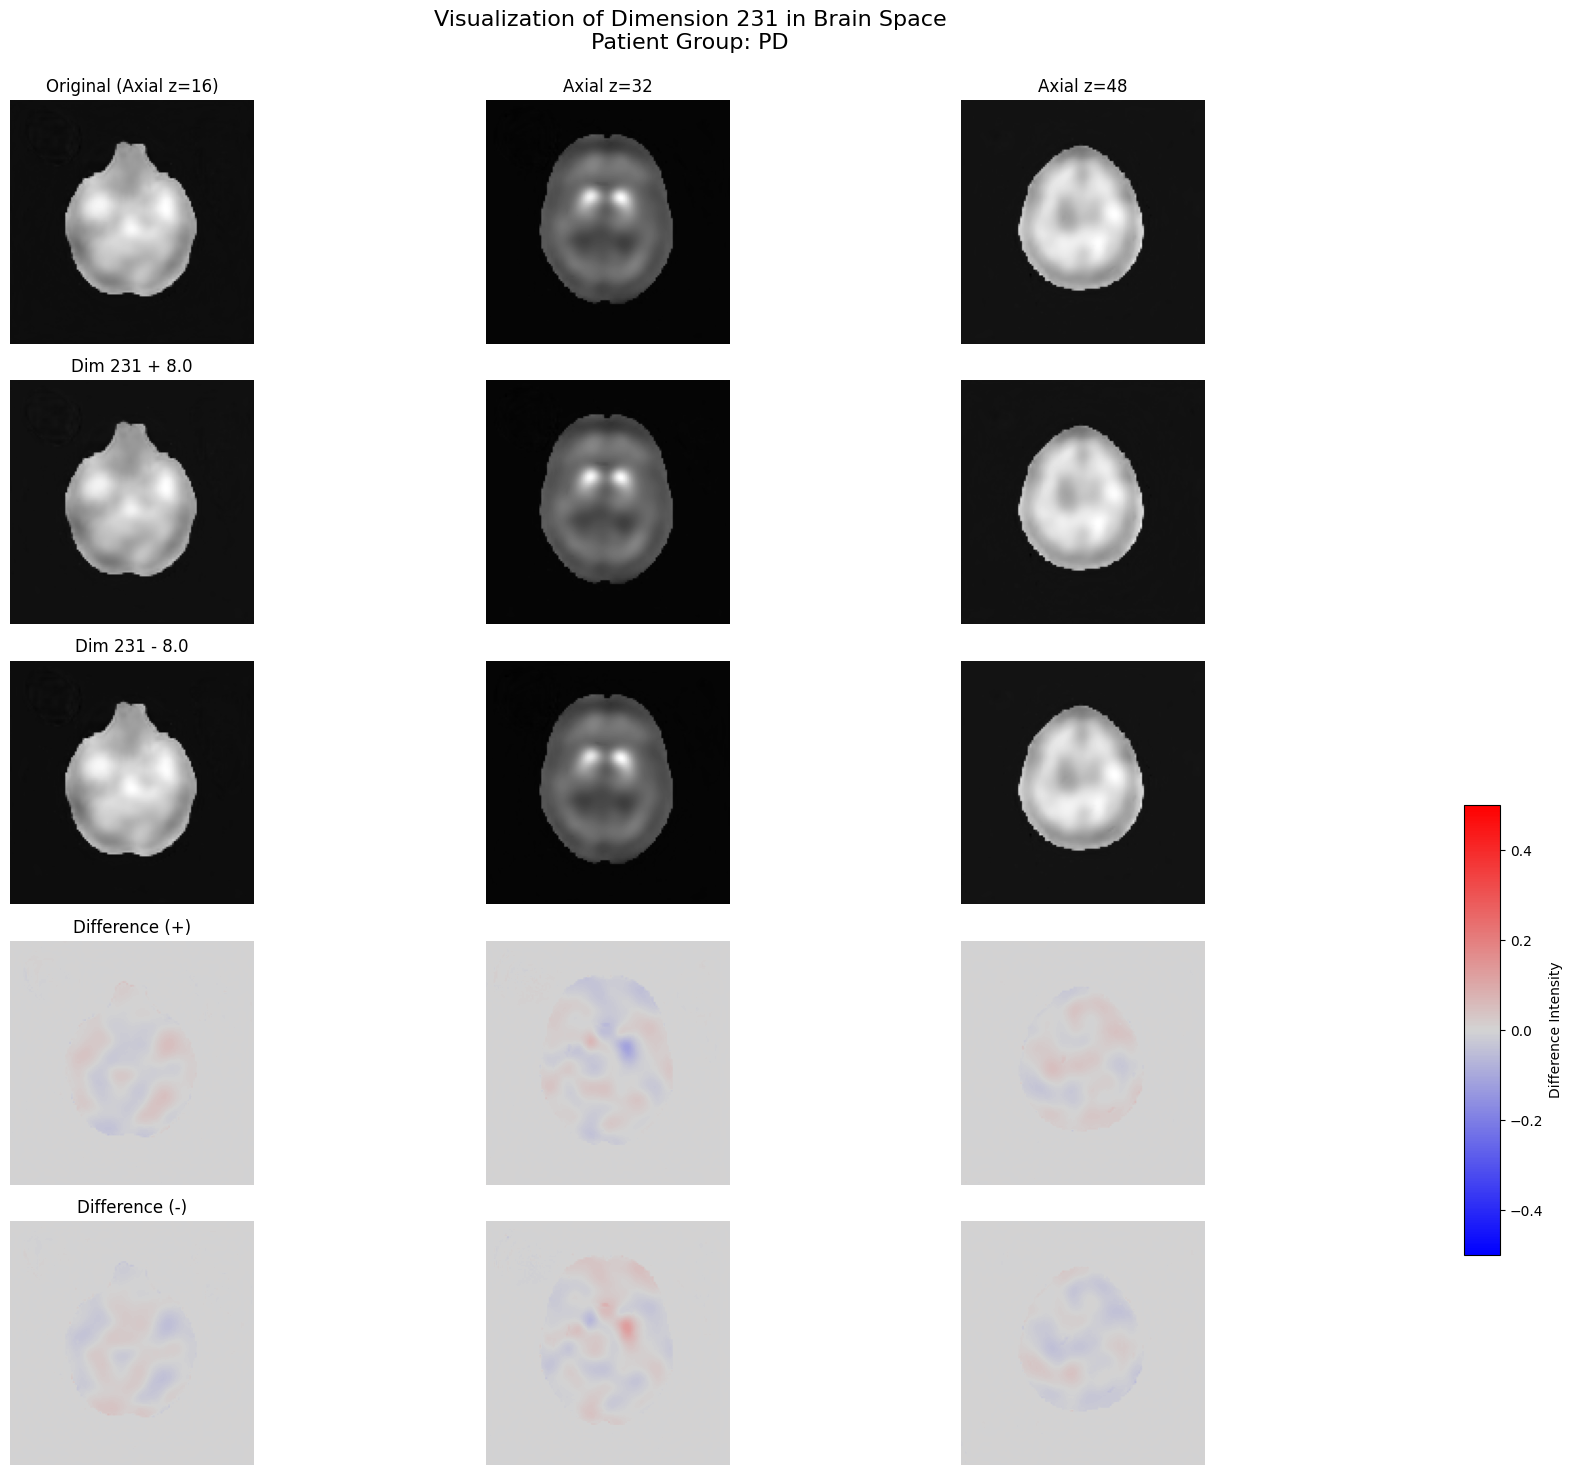


Exploring Dimension 231

Visualizing for group: PD


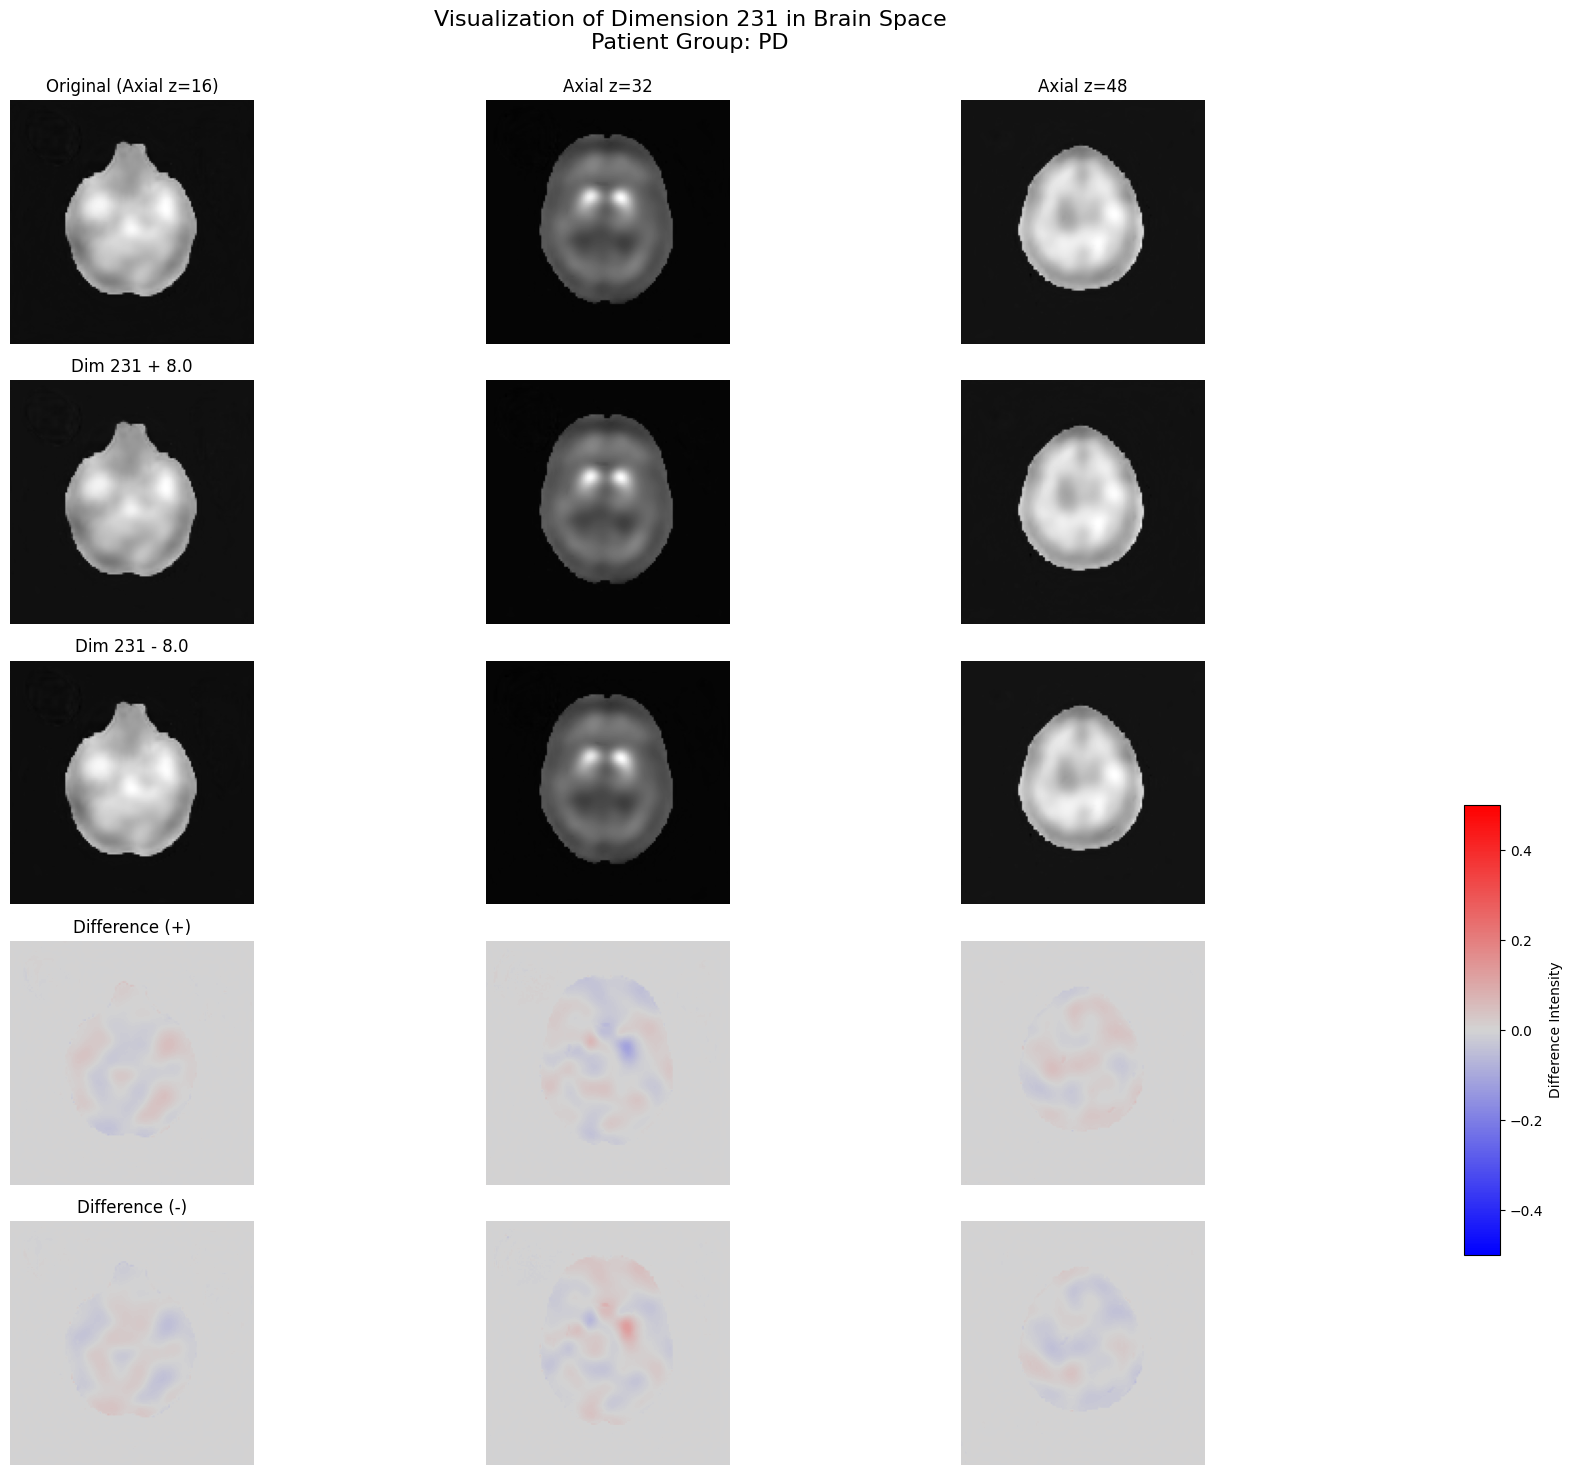

  Mean effect size: 0.00337
  Top 5% threshold: +0.02094, -0.02112

Visualizing for group: Control


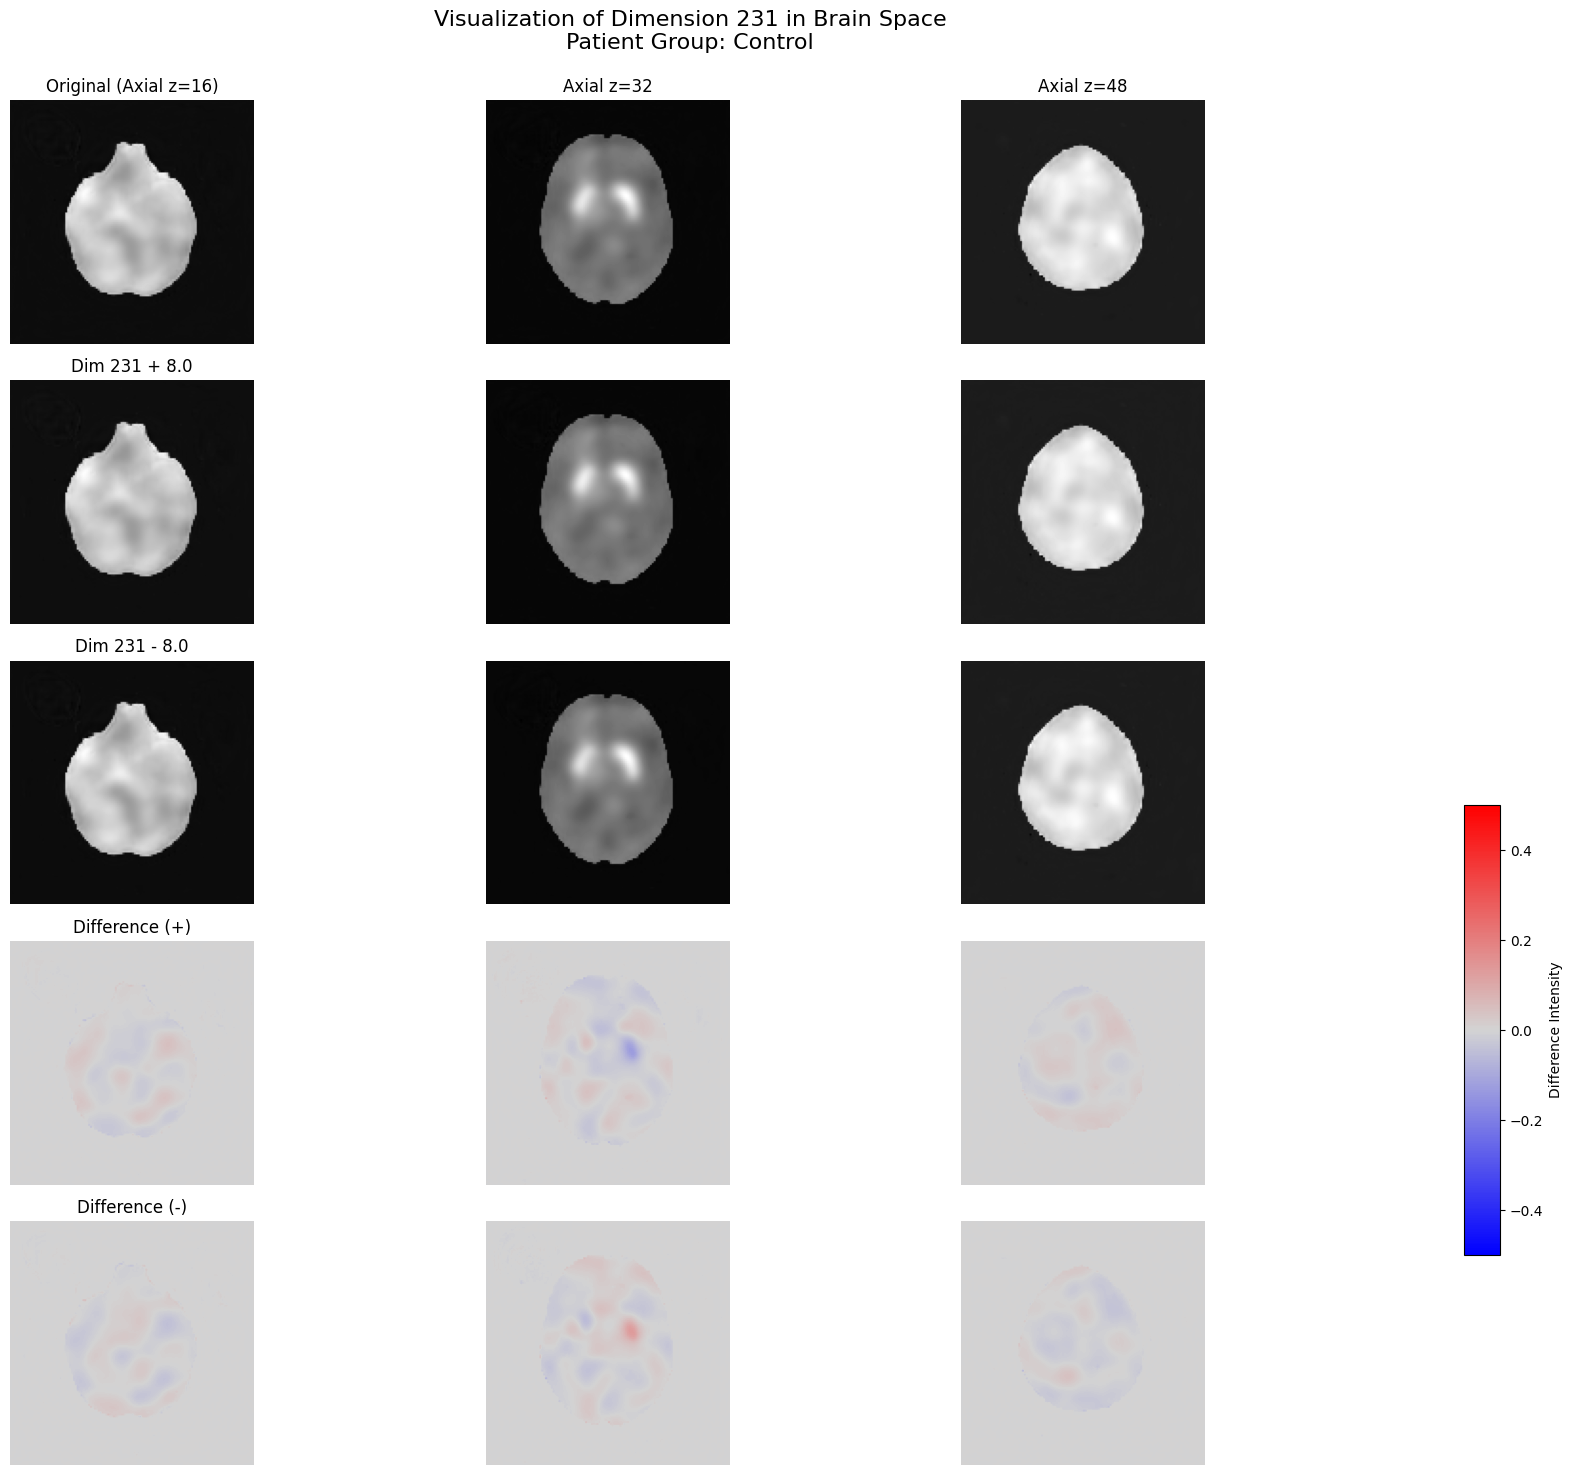

  Mean effect size: 0.00332
  Top 5% threshold: +0.02045, -0.02056

Visualizing for group: SWEDD


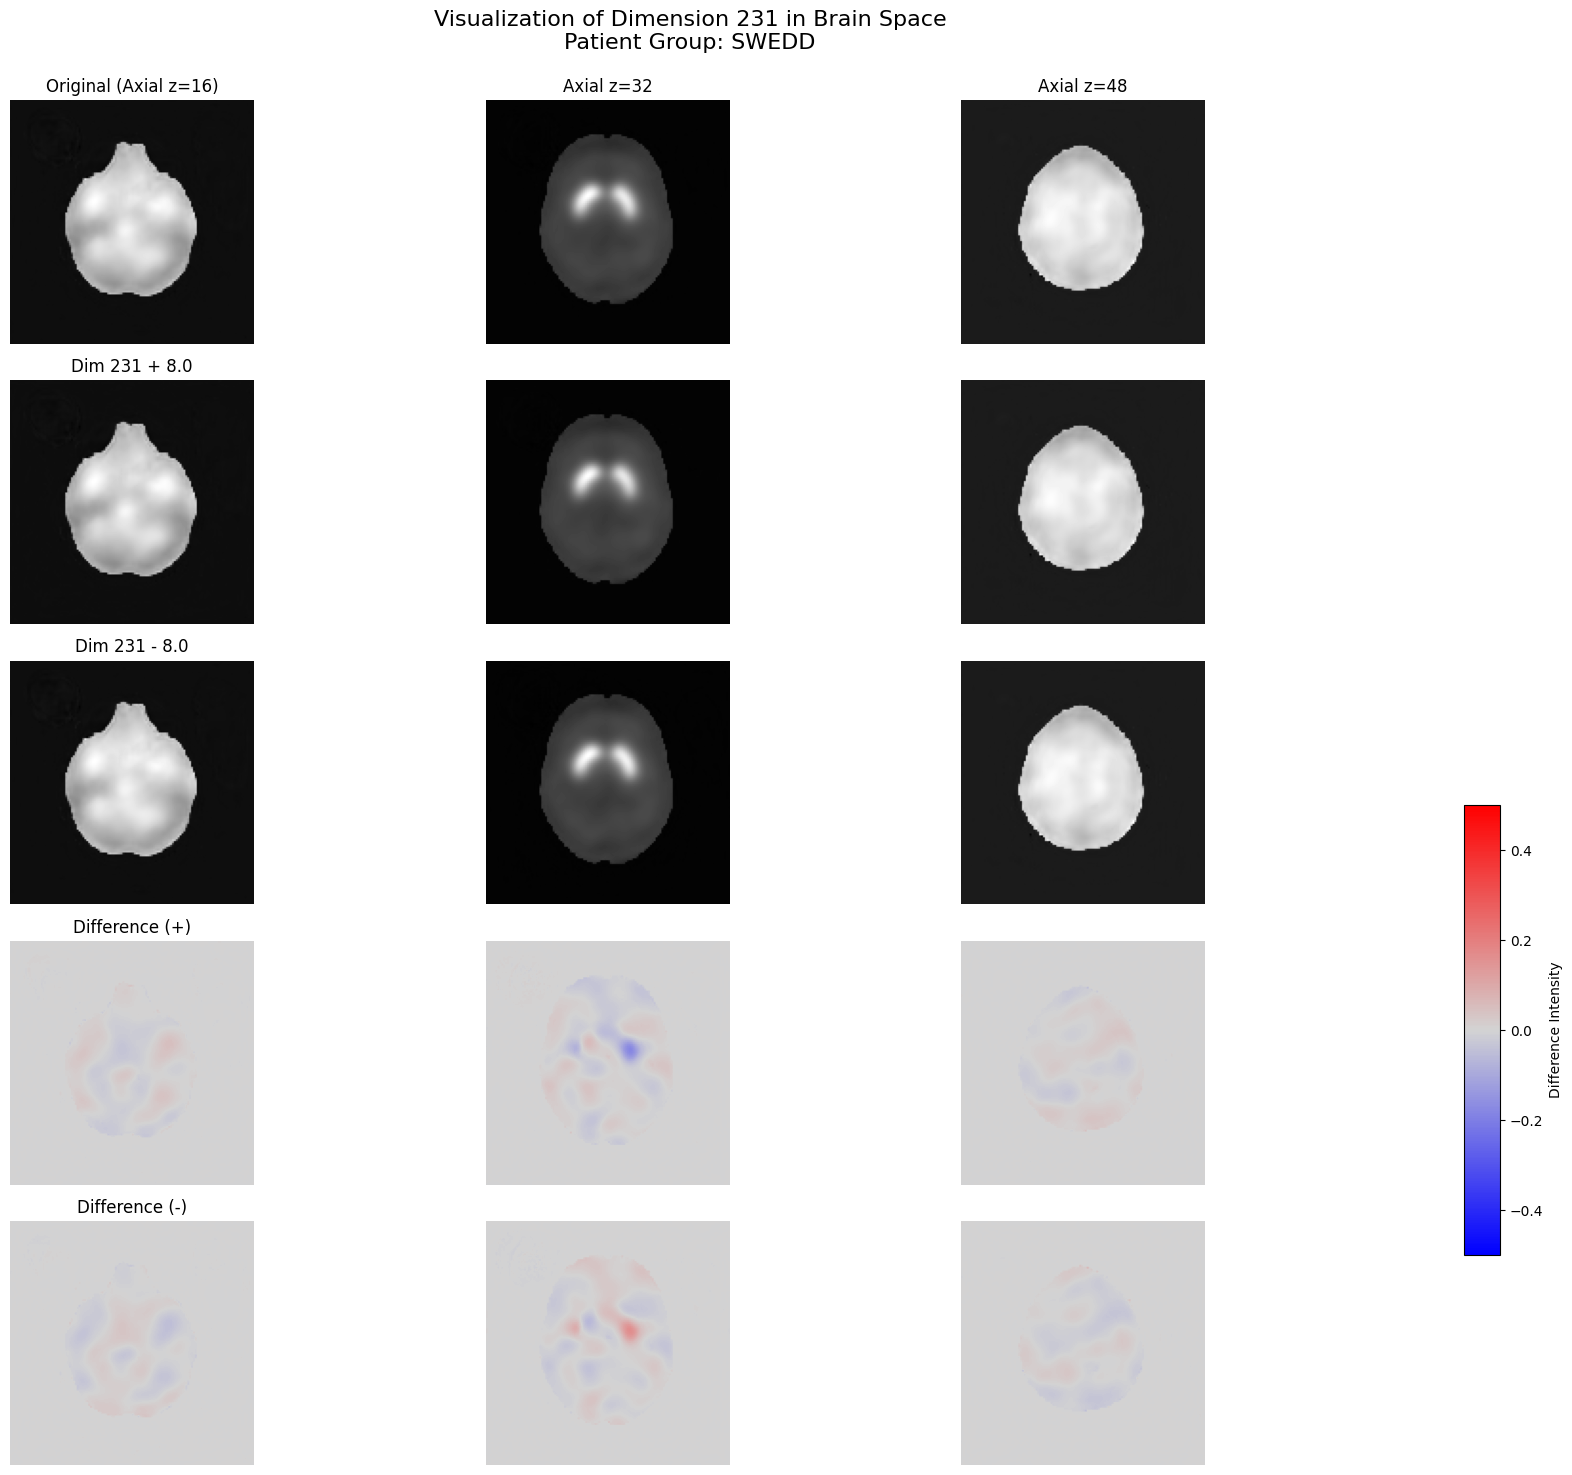

  Mean effect size: 0.00331
  Top 5% threshold: +0.02049, -0.02053

Exploring Dimension 94

Visualizing for group: PD


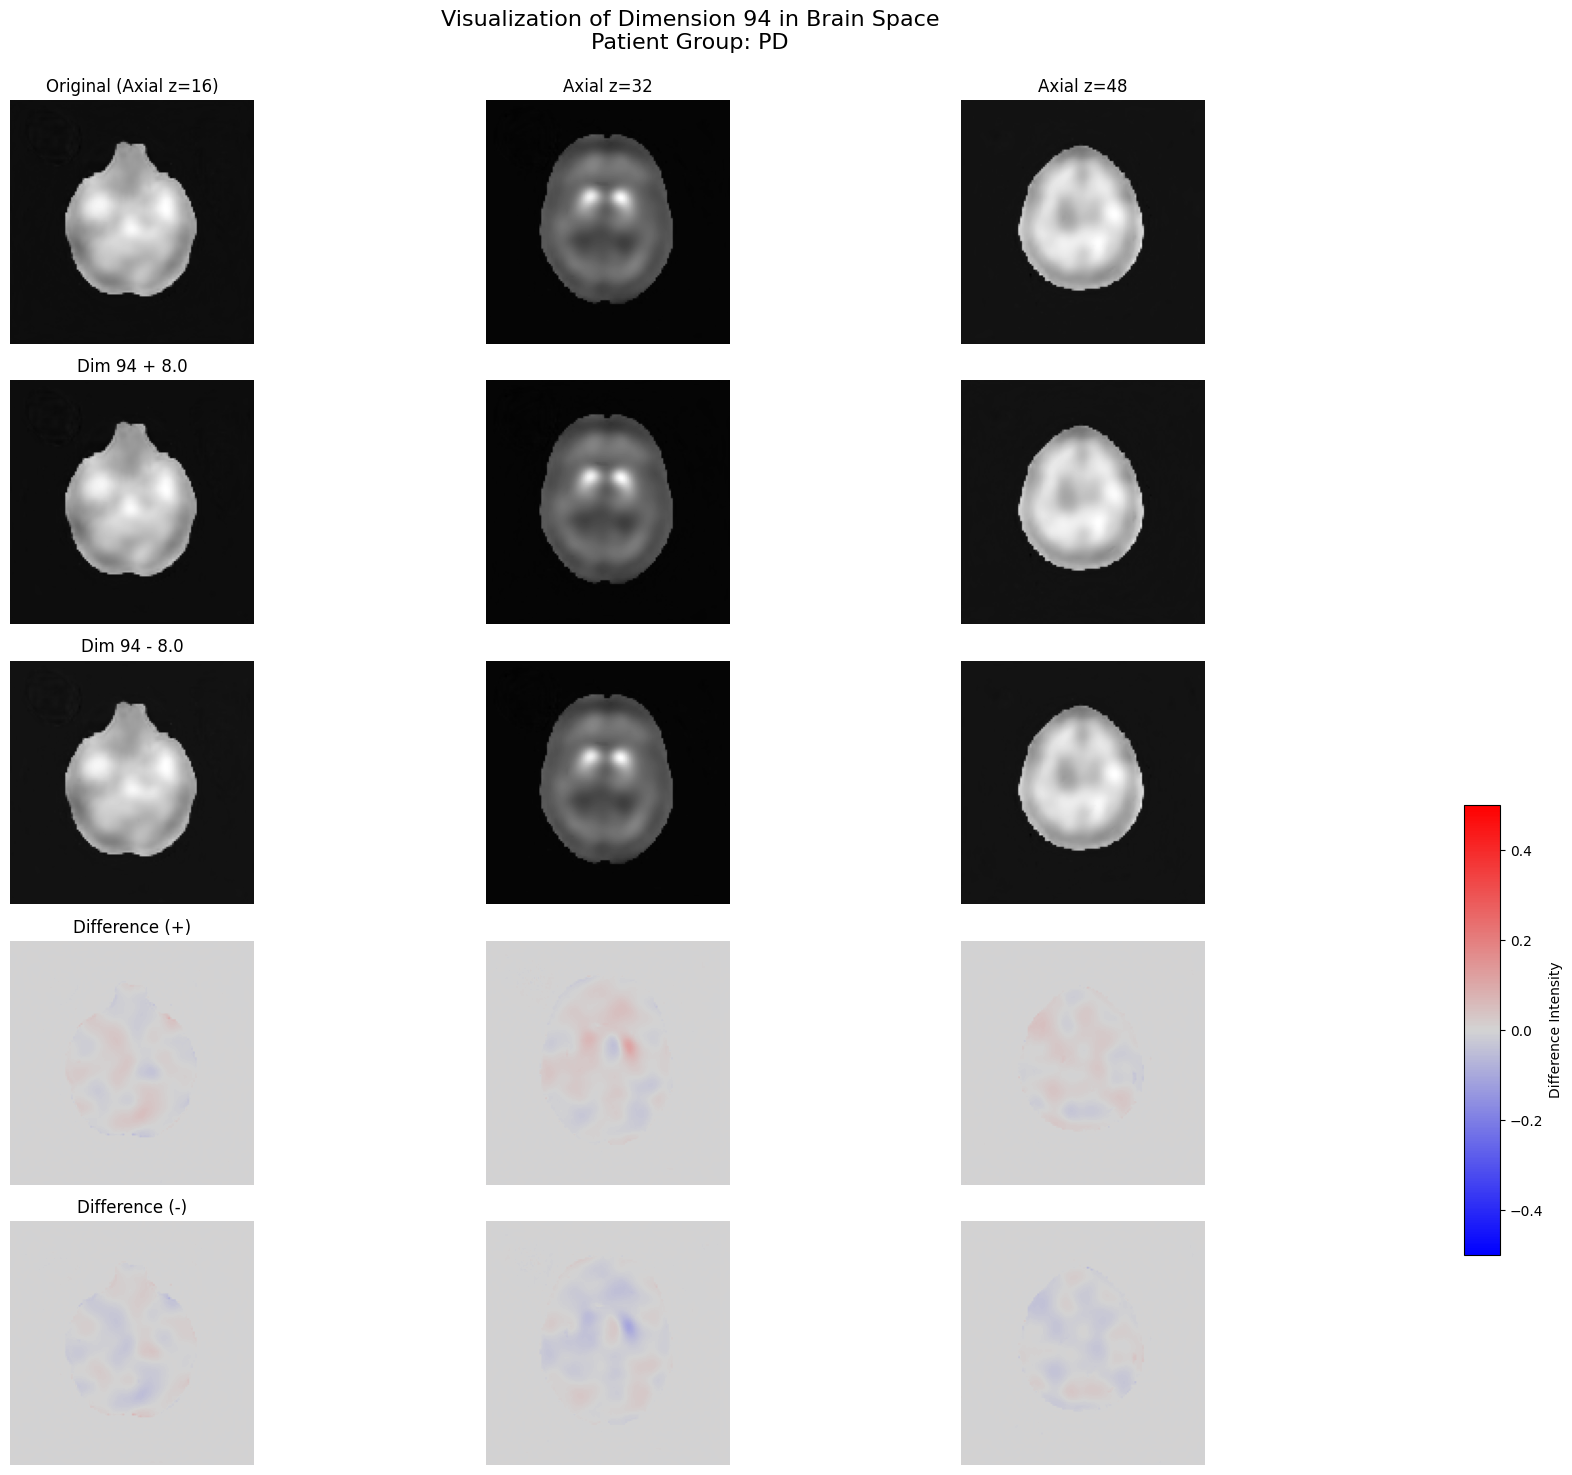

  Mean effect size: 0.00296
  Top 5% threshold: +0.01847, -0.01872

Visualizing for group: Control


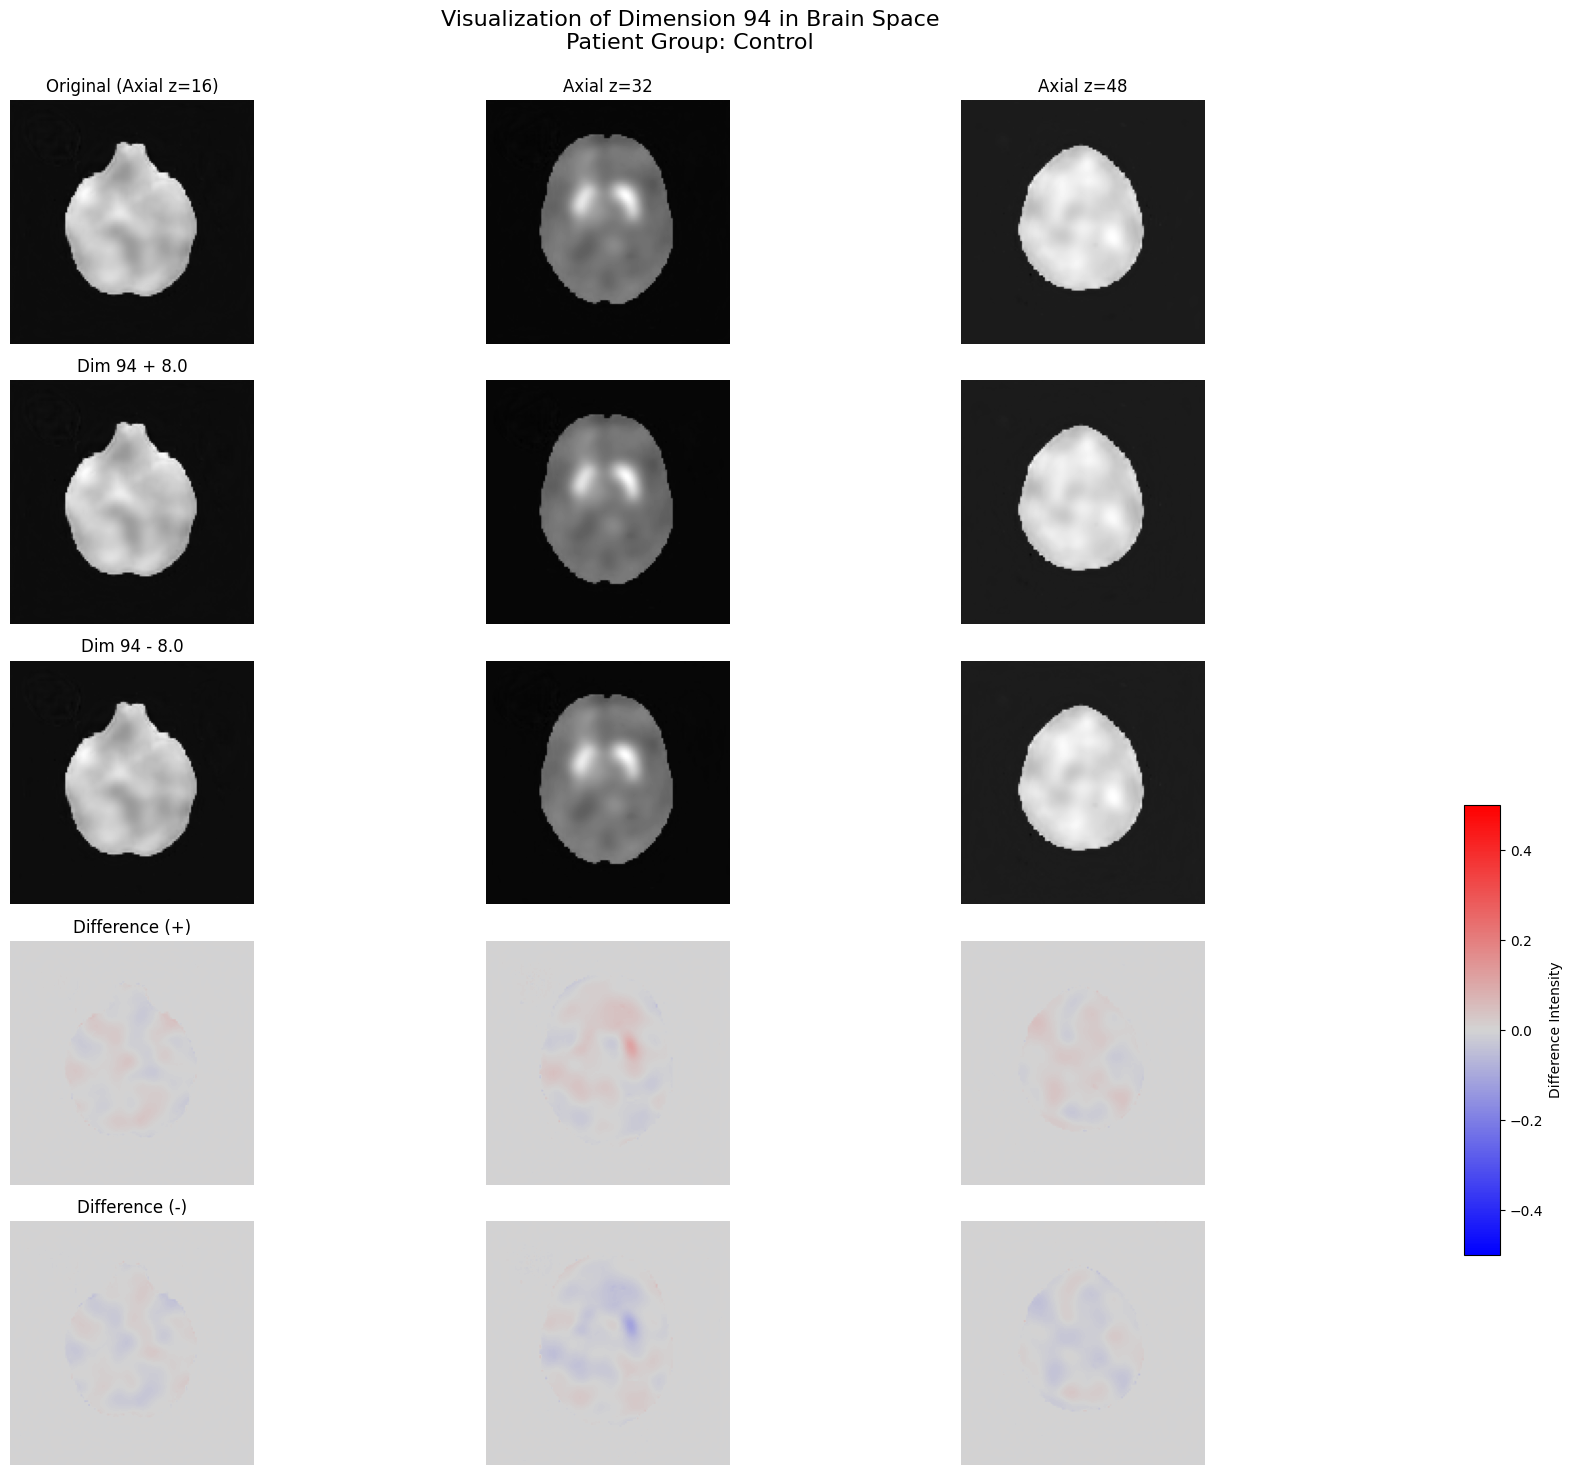

  Mean effect size: 0.00291
  Top 5% threshold: +0.01808, -0.01832

Visualizing for group: SWEDD


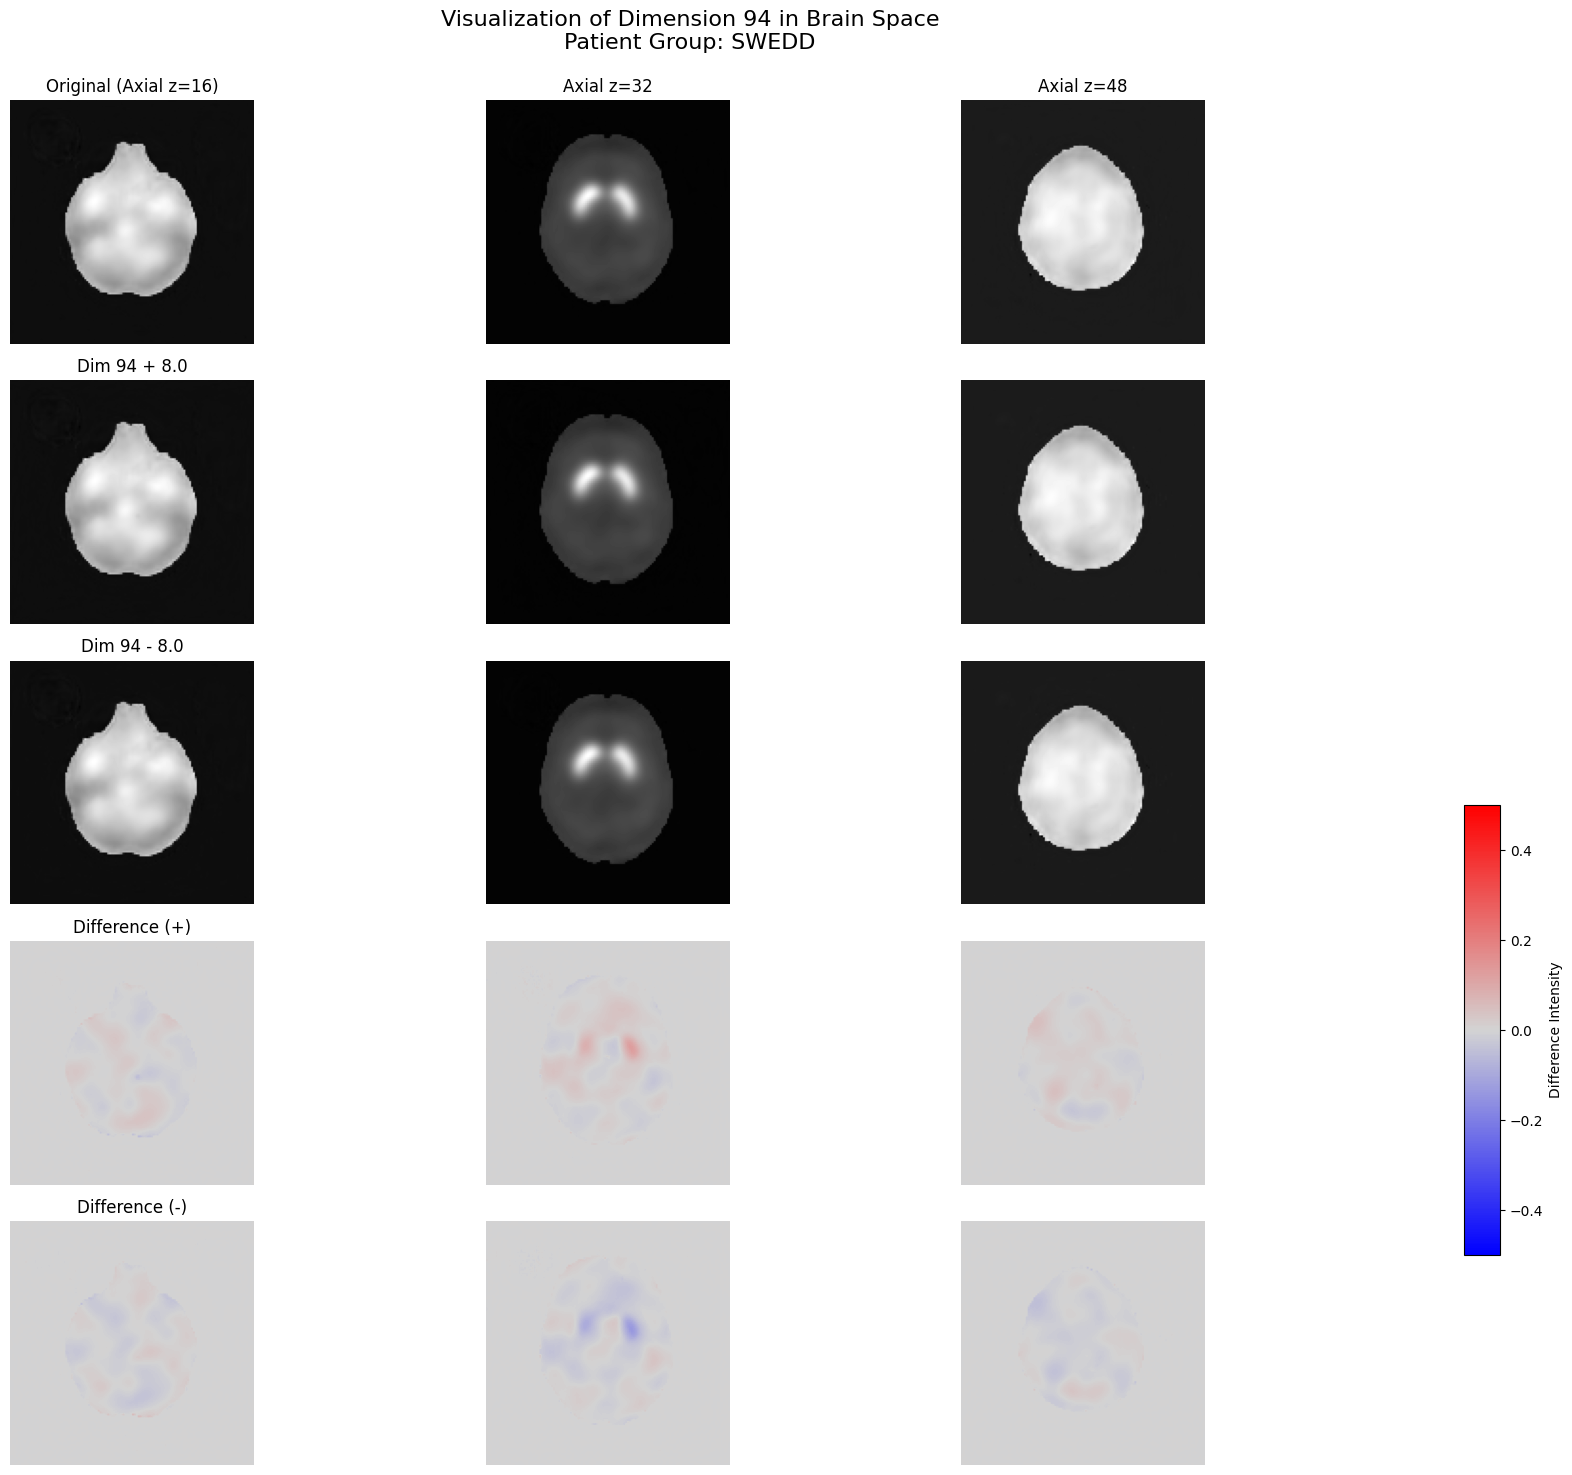

  Mean effect size: 0.00281
  Top 5% threshold: +0.01739, -0.01753

Exploring Dimension 154

Visualizing for group: PD


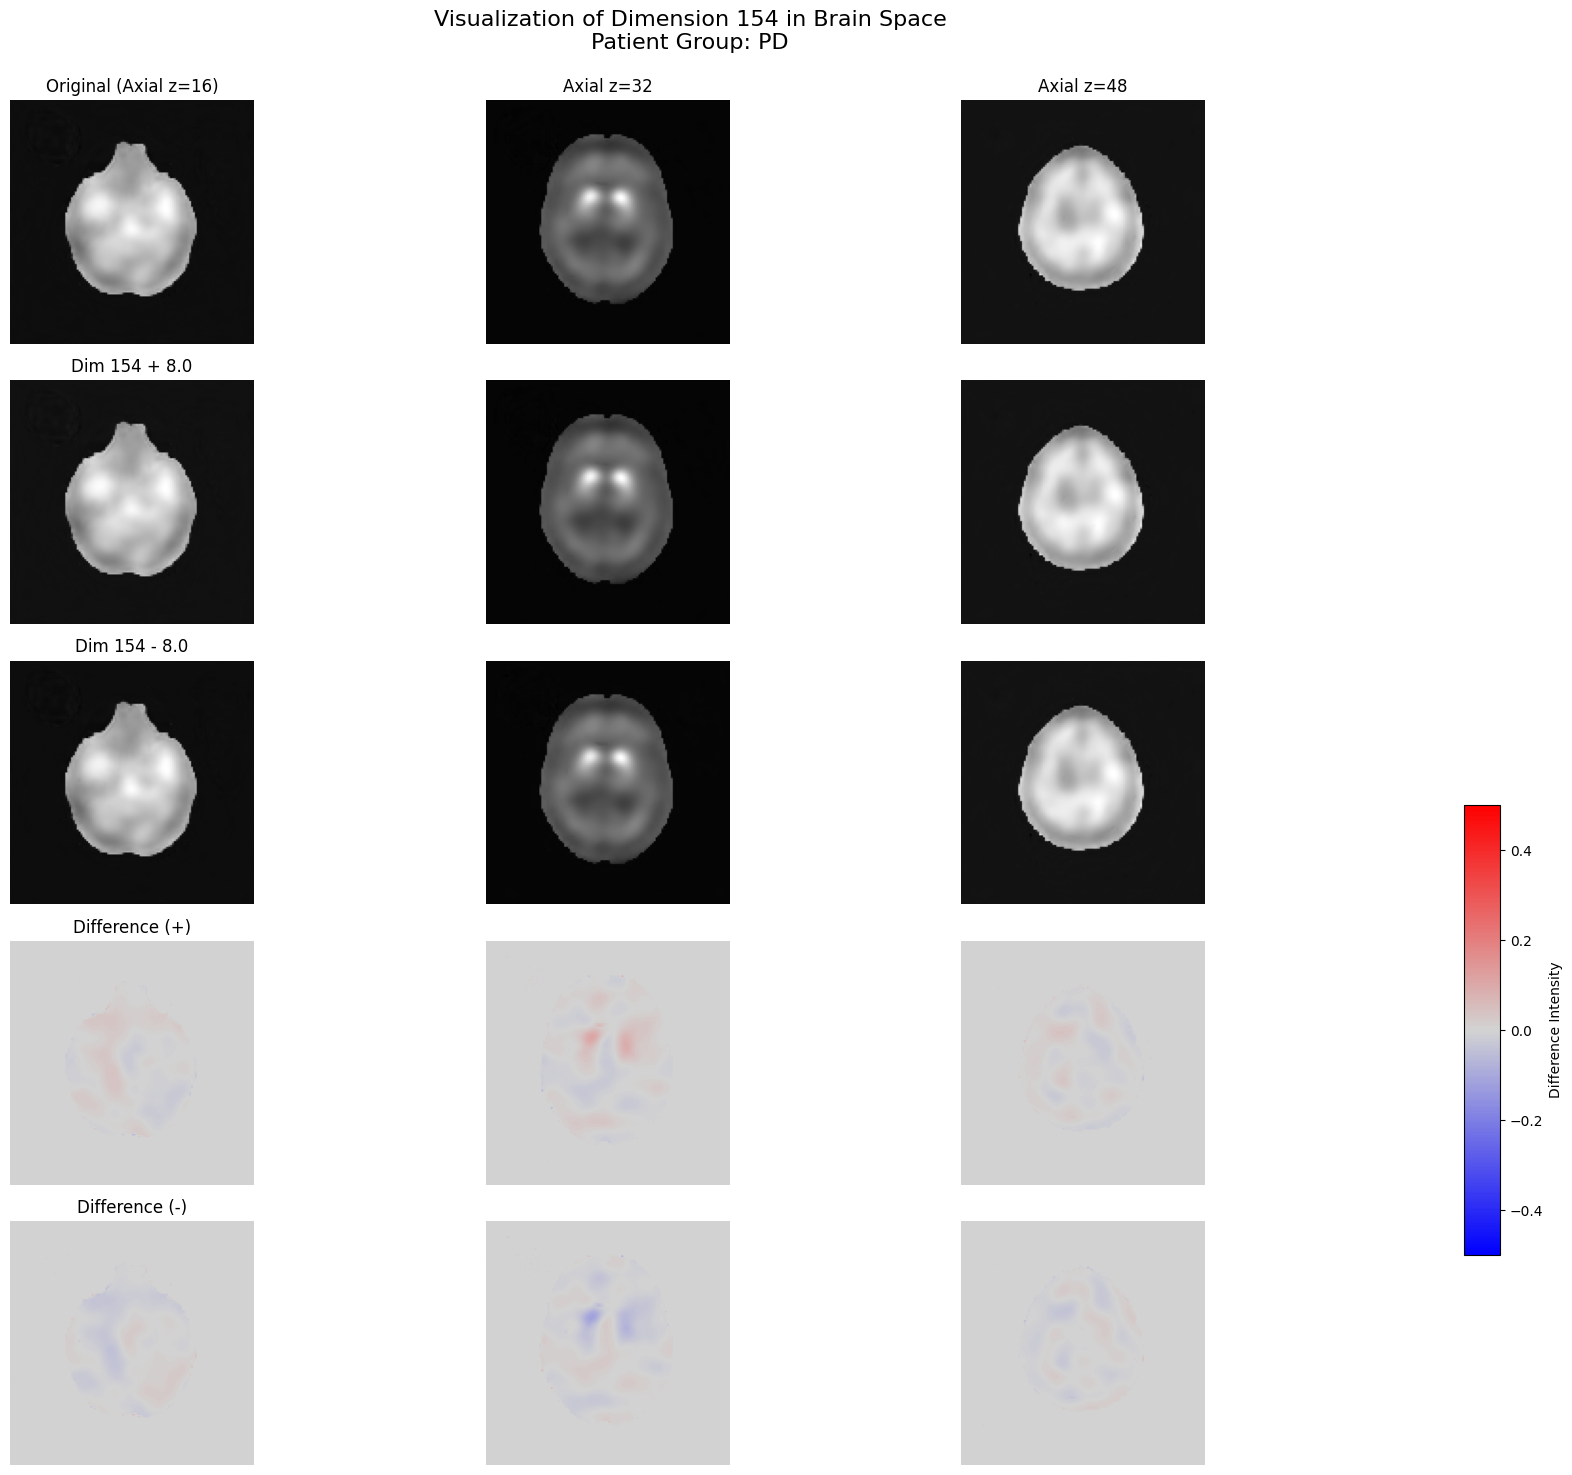

  Mean effect size: 0.00289
  Top 5% threshold: +0.01791, -0.01780

Visualizing for group: Control


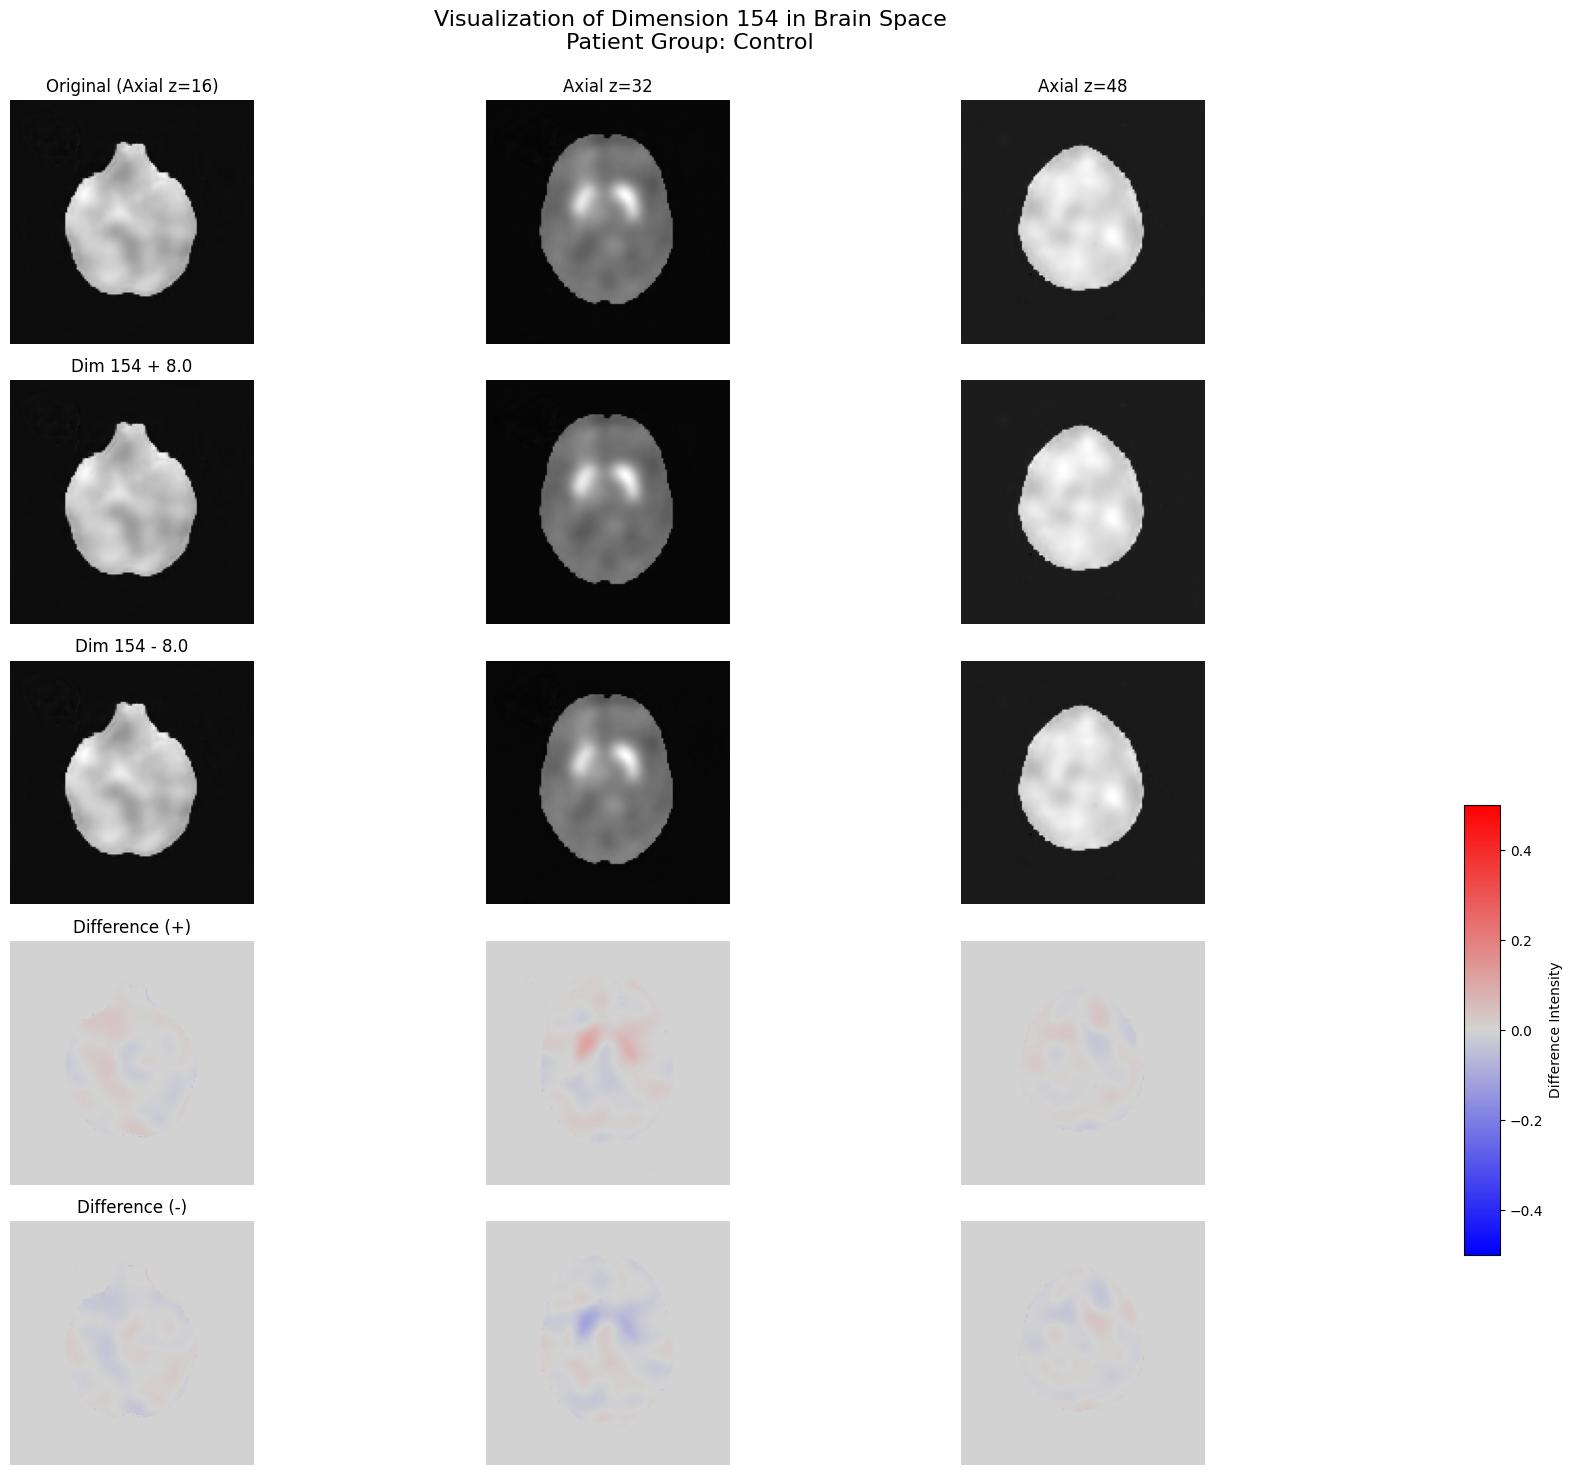

  Mean effect size: 0.00301
  Top 5% threshold: +0.01851, -0.01854

Visualizing for group: SWEDD


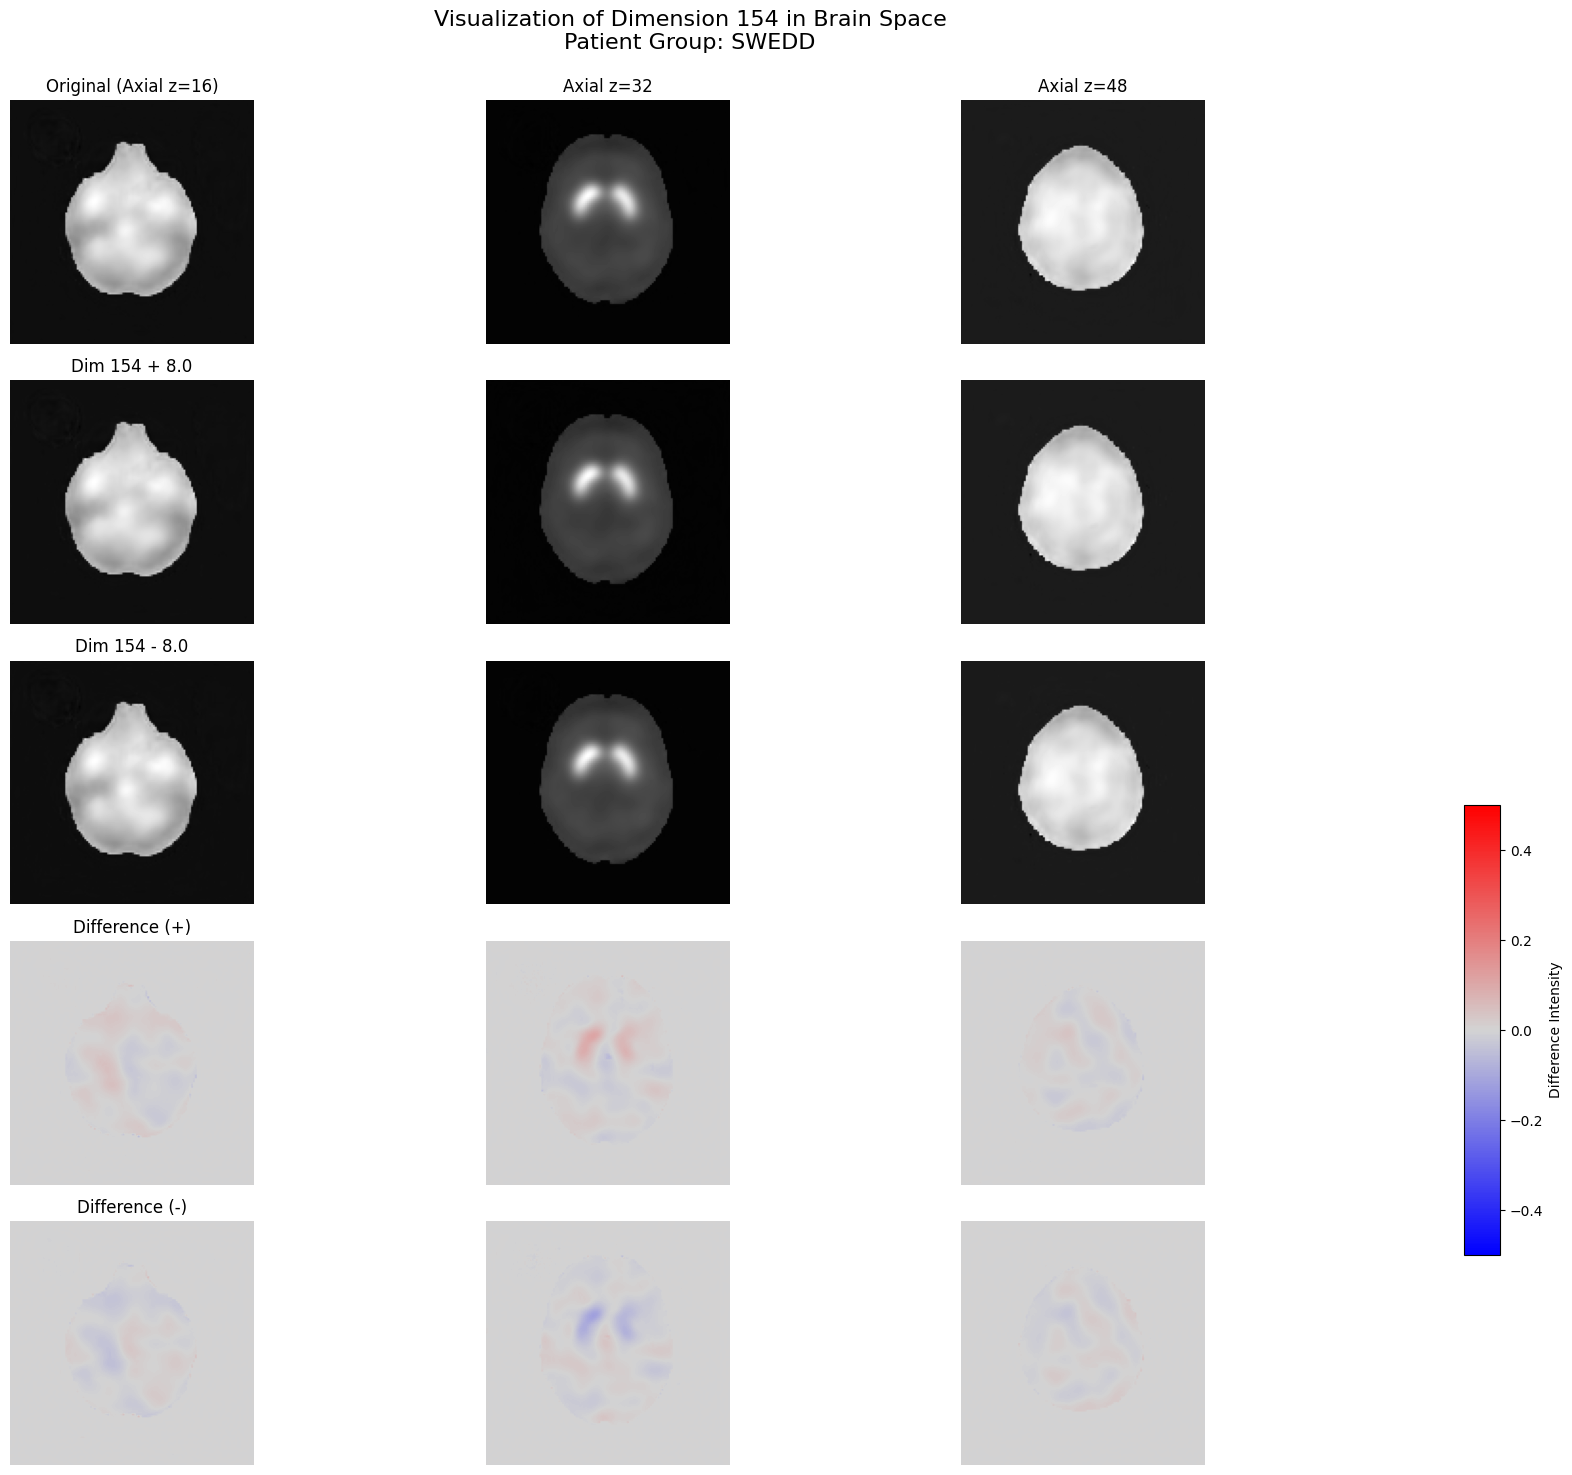

  Mean effect size: 0.00290
  Top 5% threshold: +0.01780, -0.01774


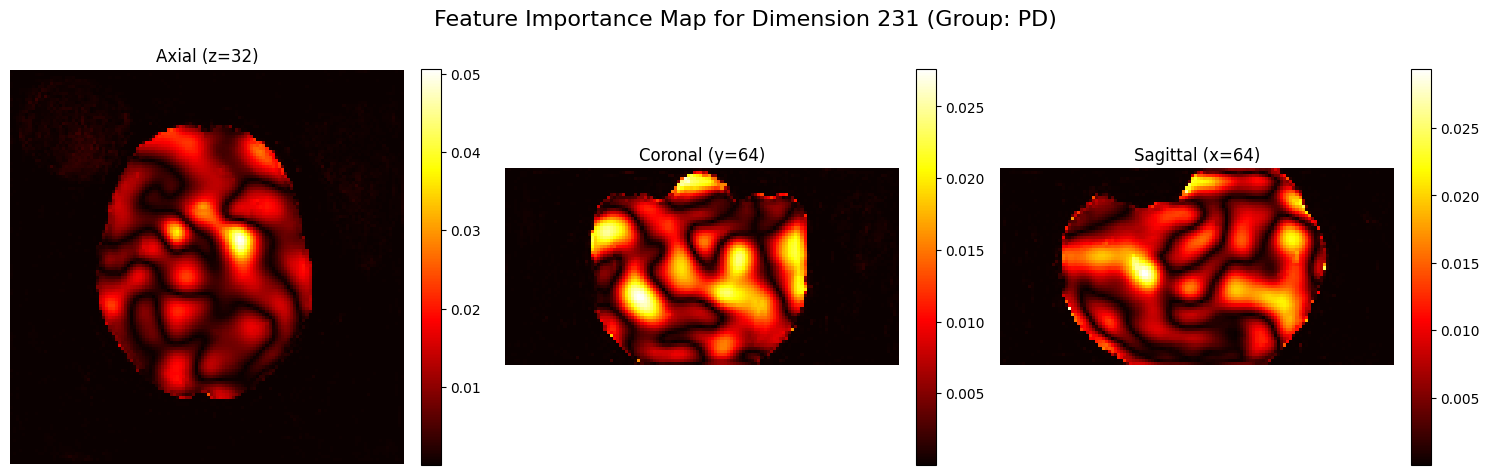

In [26]:
# Example usage
if __name__ == "__main__":
    # Load your trained model first
    model, metadata = load_trained_model('checkpoints', 'autoencoder_v1', latent_dim=256)
    
    # Example 1: Visualize one specific important dimension for a specific group
    # This shows what happens when you increase or decrease this dimension
    visualize_latent_dimension(model, val_loader, dimension_idx=231, alpha=8.0, group='PD')
    
    # Example 2: Compare the same dimension across different patient groups
    # Uncomment to see how the same dimension affects different groups
    explore_top_dimensions(model, val_loader, dimensions=[231, 94, 154], groups=['PD', 'Control', 'SWEDD'])
    
    # Example 3: Generate a feature importance map by aggregating across multiple samples
    # This shows which brain regions are most affected by this dimension
    generate_feature_importance_map(model, val_loader, dimension_idx=231, group='PD', num_samples=5)

1. latent 512: MSE val 0.006006; RMSE: 0.0775
2. latent 256: MSE val 0.0067
3. latent 128: MSE val 0.0087

1. masked latent 128: 0.004508
2. masked latent 256: 0.004092

In [ ]:
# Cell 15: Latent Space Analysis
import torch
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

def extract_latent_representations(model, dataloader, device):
    """
    Extract latent representations and corresponding labels for all samples
    """
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting latent representations"):
            volumes = batch['volume'].to(device)
            # Get latent vectors using the encode method
            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch['label'])

            # Clean up memory
            del volumes, z
            torch.cuda.empty_cache()

    return np.vstack(latent_vectors), np.array(labels)

def visualize_latent_space(latent_vectors, labels, method='tsne'):
    """
    Visualize latent space using t-SNE or PCA
    """
    plt.figure(figsize=(12, 8))

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        title = 't-SNE Visualization of Latent Space'
    else:
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Space'

    # Reduce dimensionality
    reduced_vecs = reducer.fit_transform(latent_vectors)

    # Create scatter plot
    unique_labels = np.unique(labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        mask = labels == label
        plt.scatter(reduced_vecs[mask, 0], reduced_vecs[mask, 1],
                   label=label, color=color, alpha=0.6)

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    return reduced_vecs

def analyze_latent_dimensions(latent_vectors, labels):
    """
    Analyze the distribution of values in each latent dimension
    """
    plt.figure(figsize=(15, 6))

    # Plot distribution of latent values per group
    unique_labels = np.unique(labels)

    # Compute mean activation per dimension for each group
    mean_activations = defaultdict(list)
    for label in unique_labels:
        mask = labels == label
        mean_activations[label] = np.mean(latent_vectors[mask], axis=0)

    # Plot heatmap of mean activations
    activation_matrix = np.vstack([mean_activations[label] for label in unique_labels])
    plt.subplot(1, 2, 1)
    sns.heatmap(activation_matrix, xticklabels=False, yticklabels=unique_labels)
    plt.title('Mean Latent Dimension Activation by Group')
    plt.xlabel('Latent Dimensions')
    plt.ylabel('Group')

    # Plot top discriminative dimensions
    variance_ratio = np.var(activation_matrix, axis=0)
    top_dims = np.argsort(variance_ratio)[-5:]  # Top 5 dimensions

    plt.subplot(1, 2, 2)
    for label in unique_labels:
        mask = labels == label
        plt.boxplot([latent_vectors[mask, dim] for dim in top_dims],
                   positions=np.arange(len(top_dims)) + (unique_labels == label).nonzero()[0][0] * 0.3,
                   widths=0.2, label=label)

    plt.title('Distribution of Top 5 Discriminative Dimensions')
    plt.xlabel('Dimension Index')
    plt.ylabel('Activation')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    # Load model and move to device
    model, _ = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Extract latent representations
    latent_vecs, labels = extract_latent_representations(model, val_loader, device)

    # Visualize using t-SNE and PCA
    print("Generating t-SNE visualization...")
    tsne_coords = visualize_latent_space(latent_vecs, labels, method='tsne')

    print("\nGenerating PCA visualization...")
    pca_coords = visualize_latent_space(latent_vecs, labels, method='pca')

    # Analyze latent dimensions
    print("\nAnalyzing latent dimensions...")
    analyze_latent_dimensions(latent_vecs, labels)

In [ ]:
# Cell 16: Region-based Reconstruction Analysis
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass

def analyze_reconstruction_quality_by_region(model, dataloader, device):
    """
    Analyze reconstruction quality in different brain regions
    """
    model.eval()
    region_errors = defaultdict(list)

    # Define regions of interest (approximate coordinates for DaTSCAN)
    regions = {
        'Left Striatum': (slice(54, 74), slice(54, 74), slice(44, 64)),
        'Right Striatum': (slice(54, 74), slice(54, 74), slice(64, 84)),
        'Background': (slice(0, 20), slice(0, 20), slice(0, 20))
    }

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing reconstruction quality"):
            volumes = batch['volume'].to(device)
            reconstructed = model(volumes)

            # Calculate error for each region
            for vol_idx in range(volumes.shape[0]):
                orig = volumes[vol_idx, 0].cpu().numpy()
                recon = reconstructed[vol_idx, 0].cpu().numpy()

                for region_name, coords in regions.items():
                    orig_region = orig[coords]
                    recon_region = recon[coords]
                    mse = np.mean((orig_region - recon_region) ** 2)
                    region_errors[region_name].append(mse)

            # Clean up
            del volumes, reconstructed
            torch.cuda.empty_cache()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.boxplot([region_errors[region] for region in regions.keys()],
                labels=regions.keys())
    plt.title('Reconstruction Error by Brain Region')
    plt.ylabel('Mean Squared Error')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Print summary statistics
    print("\nReconstruction Error Statistics by Region:")
    for region in regions.keys():
        errors = region_errors[region]
        print(f"\n{region}:")
        print(f"Mean MSE: {np.mean(errors):.6f}")
        print(f"Std MSE: {np.std(errors):.6f}")
        print(f"Min MSE: {np.min(errors):.6f}")
        print(f"Max MSE: {np.max(errors):.6f}")

# Run the analysis
if __name__ == "__main__":
    print("Analyzing reconstruction quality by region...")
    analyze_reconstruction_quality_by_region(model, val_loader, device)

In [ ]:
# Cell 17: Latent Space Clinical Correlation
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_latent_clinical_correlation(latent_vectors, labels):
    """
    Analyze correlation between latent dimensions and clinical groups
    """
    # Convert labels to numeric for correlation analysis
    label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
    numeric_labels = np.array([label_mapping[label] for label in labels])

    # Calculate correlation between each latent dimension and the clinical groups
    correlations = []
    p_values = []

    for dim_idx in range(latent_vectors.shape[1]):
        corr, p_val = spearmanr(latent_vectors[:, dim_idx], numeric_labels)
        correlations.append(corr)
        p_values.append(p_val)

    # Plot correlation heatmap
    plt.figure(figsize=(15, 5))

    # Plot correlations
    plt.subplot(1, 2, 1)
    significant_dims = np.array(p_values) < 0.05
    plt.bar(range(len(correlations)), correlations,
            color=['red' if sig else 'gray' for sig in significant_dims])
    plt.title('Correlation of Latent Dimensions with Clinical Groups')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)

    # Plot most discriminative dimensions
    top_dims = np.argsort(np.abs(correlations))[-5:]
    plt.subplot(1, 2, 2)
    for label in np.unique(labels):
        mask = labels == label
        values = latent_vectors[mask][:, top_dims]
        plt.violinplot(values, positions=range(len(top_dims)),
                      showmeans=True, showextrema=True)

    plt.title('Distribution of Top Discriminative Dimensions')
    plt.xlabel('Dimension Index')
    plt.ylabel('Activation')
    plt.tight_layout()
    plt.show()

    # Print summary of most significant dimensions
    print("\nTop 5 Most Discriminative Dimensions:")
    for dim_idx in top_dims:
        print(f"\nDimension {dim_idx}:")
        print(f"Correlation: {correlations[dim_idx]:.3f}")
        print(f"P-value: {p_values[dim_idx]:.3e}")

# Run the analysis
if __name__ == "__main__":
    print("Analyzing latent space clinical correlations...")
    analyze_latent_clinical_correlation(latent_vecs, labels)

### Synthetic Brain Generation

In [ ]:
# Cell 18: Synthetic Brain Generation
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def generate_synthetic_brain(model, dataloader, condition='PD', num_samples=5):
    """
    Generate synthetic brain scans by manipulating the latent space

    Args:
        model: Trained autoencoder model
        dataloader: DataLoader containing the validation set
        condition: Target condition ('PD', 'Control', or 'SWEDD')
        num_samples: Number of synthetic samples to generate
    """
    device = next(model.parameters()).device
    model.eval()

    # First, get latent representations of real brains
    print("Extracting latent representations...")
    latent_vectors = []
    conditions = []

    with torch.no_grad():
        for batch in dataloader:
            volumes = batch['volume'].to(device)
            labels = batch['label']

            # Get latent vectors
            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            conditions.extend(labels)

            del volumes, z
            torch.cuda.empty_cache()

    latent_vectors = np.vstack(latent_vectors)
    conditions = np.array(conditions)

    # Calculate mean and covariance of latent vectors for target condition
    target_mask = conditions == condition
    target_vectors = latent_vectors[target_mask]
    latent_mean = np.mean(target_vectors, axis=0)
    latent_cov = np.cov(target_vectors.T)

    # Generate new latent vectors by sampling from learned distribution
    print(f"\nGenerating synthetic {condition} brains...")
    synthetic_vectors = np.random.multivariate_normal(
        latent_mean,
        latent_cov + 1e-6 * np.eye(latent_cov.shape[0]),  # Add small value to ensure positive definiteness
        size=num_samples
    )

    # Convert to torch tensor and move to device
    synthetic_vectors = torch.tensor(synthetic_vectors, dtype=torch.float32).to(device)

    # Generate synthetic brains using decoder
    with torch.no_grad():
        synthetic_brains = model.decode(synthetic_vectors)

    # Visualize results
    fig = plt.figure(figsize=(15, 3*num_samples))

    for i in range(num_samples):
        brain = synthetic_brains[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Synthetic {condition} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Synthetic {condition} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Synthetic {condition} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    return synthetic_brains

def interpolate_between_conditions(model, dataloader, start_condition='Control', end_condition='PD', steps=5):
    """
    Generate interpolated brains between two conditions
    """
    device = next(model.parameters()).device
    model.eval()

    # Get latent representations
    print("Extracting latent representations...")
    latent_vectors = []
    conditions = []

    with torch.no_grad():
        for batch in dataloader:
            volumes = batch['volume'].to(device)
            labels = batch['label']

            z = model.encode(volumes)
            latent_vectors.append(z.cpu().numpy())
            conditions.extend(labels)

            del volumes, z
            torch.cuda.empty_cache()

    latent_vectors = np.vstack(latent_vectors)
    conditions = np.array(conditions)

    # Get mean latent vectors for both conditions
    start_mean = np.mean(latent_vectors[conditions == start_condition], axis=0)
    end_mean = np.mean(latent_vectors[conditions == end_condition], axis=0)

    # Create interpolation steps
    alphas = np.linspace(0, 1, steps)
    interpolated_vectors = np.array([
        (1 - alpha) * start_mean + alpha * end_mean
        for alpha in alphas
    ])

    # Generate interpolated brains
    interpolated_vectors = torch.tensor(interpolated_vectors, dtype=torch.float32).to(device)

    with torch.no_grad():
        interpolated_brains = model.decode(interpolated_vectors)

    # Visualize interpolation
    fig = plt.figure(figsize=(15, 3*steps))

    for i in range(steps):
        brain = interpolated_brains[i, 0].cpu().numpy()

        # Get middle slices
        axial = brain[brain.shape[0]//2, :, :]
        sagittal = brain[:, brain.shape[1]//2, :]
        coronal = brain[:, :, brain.shape[2]//2]

        # Plot
        plt.subplot(steps, 3, i*3 + 1)
        plt.imshow(axial, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Axial' if i == 0 else '')
        plt.axis('off')

        plt.subplot(steps, 3, i*3 + 2)
        plt.imshow(sagittal, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Sagittal' if i == 0 else '')
        plt.axis('off')

        plt.subplot(steps, 3, i*3 + 3)
        plt.imshow(coronal, cmap='gray')
        plt.title(f'Interpolation {i/(steps-1):.1f} - Coronal' if i == 0 else '')
        plt.axis('off')

    plt.suptitle(f'Interpolation from {start_condition} to {end_condition}')
    plt.tight_layout()
    plt.show()

    return interpolated_brains

# Run the generation
if __name__ == "__main__":
    # Load model
    model, _ = load_checkpoint_for_evaluation('checkpoints', 'autoencoder')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Generate synthetic brains for each condition
    print("\nGenerating synthetic Control brains...")
    synthetic_control = generate_synthetic_brain(model, val_loader, condition='Control')

    print("\nGenerating synthetic PD brains...")
    synthetic_pd = generate_synthetic_brain(model, val_loader, condition='PD')

    print("\nGenerating synthetic SWEDD brains...")
    synthetic_swedd = generate_synthetic_brain(model, val_loader, condition='SWEDD')

    # Generate interpolation between conditions
    print("\nGenerating interpolation from Control to PD...")
    interpolated = interpolate_between_conditions(model, val_loader)

## 2. Variational Autoencoder (VAE)

### Model Setup

In [27]:
# Cell 19: Optimized VAE Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class VAE(nn.Module):
    """
    3D Variational Autoencoder optimized for 64×128×128 medical volumes with
    memory-efficient implementation for NVIDIA 4070Ti.
    """
    def __init__(self, latent_dim=256):
        super().__init__()
        self.encoder = VAEEncoder(latent_dim)
        self.decoder = VAEDecoder(latent_dim)
        # Enable CUDNN benchmarking for optimal performance
        torch.backends.cudnn.benchmark = True
        self.latent_dim = latent_dim

    def reparameterize(self, mu, log_var):
        """
        Reparameterization trick to enable backpropagation through sampling.
        """
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu

    def forward(self, x):
        # Encode input to get mean and variance of latent distribution
        mu, log_var = self.encoder(x)

        # Sample from latent distribution
        z = self.reparameterize(mu, log_var)

        # Decode sampled latent vector
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var
    
    def encode(self, x):
        """Encode input to latent parameters without sampling"""
        mu, log_var = self.encoder(x)
        return mu, log_var
    
    def generate(self, z=None, num_samples=1):
        """Generate samples from latent space or random samples"""
        device = next(self.parameters()).device
        
        if z is None:
            # Generate random latent vectors
            z = torch.randn(num_samples, self.latent_dim, device=device)
        
        # Decode latent vectors to generate samples
        with torch.no_grad():
            samples = self.decoder(z)
        
        return samples

class ConvBlock(nn.Module):
    """Memory-efficient convolutional block with batch normalization and ReLU."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.block = nn.Sequential(OrderedDict([
            ('conv', nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)),
            ('bn', nn.BatchNorm3d(out_channels)),
            ('relu', nn.ReLU(inplace=True))  # inplace ReLU for memory efficiency
        ]))

    def forward(self, x):
        return self.block(x)

class VAEEncoder(nn.Module):
    """3D Encoder network with probabilistic latent space."""
    def __init__(self, latent_dim=256):
        super().__init__()

        # Initial feature extraction
        self.init_conv = ConvBlock(1, 16)  # 64×128×128 -> same size

        # Downsampling path with progressive channel increase
        self.down1 = nn.Sequential(
            ConvBlock(16, 32, stride=2),    # -> 32×64×64
            ConvBlock(32, 32)
        )

        self.down2 = nn.Sequential(
            ConvBlock(32, 64, stride=2),    # -> 16×32×32
            ConvBlock(64, 64)
        )

        self.down3 = nn.Sequential(
            ConvBlock(64, 128, stride=2),   # -> 8×16×16
            ConvBlock(128, 128)
        )

        self.down4 = nn.Sequential(
            ConvBlock(128, 256, stride=2),  # -> 4×8×8
            ConvBlock(256, 256)
        )

        # Project to latent parameters
        self.flatten_size = 256 * 4 * 8 * 8
        self.fc_mu = nn.Linear(self.flatten_size, latent_dim)
        self.fc_var = nn.Linear(self.flatten_size, latent_dim)

    def forward(self, x):
        # Initial convolution
        x = self.init_conv(x)

        # Downsampling
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.down4(x)

        # Flatten and project to latent parameters
        flat = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(flat)
        log_var = self.fc_var(flat)

        return mu, log_var

class VAEDecoder(nn.Module):
    """3D Decoder network with skip connections."""
    def __init__(self, latent_dim=256):
        super().__init__()

        self.flatten_size = 256 * 4 * 8 * 8
        self.fc = nn.Linear(latent_dim, self.flatten_size)

        # Upsampling path with trilinear upsampling for better quality
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(256, 128),
            ConvBlock(128, 128)
        )

        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(128, 64),
            ConvBlock(64, 64)
        )

        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(64, 32),
            ConvBlock(32, 32)
        )

        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=False),
            ConvBlock(32, 16),
            ConvBlock(16, 16)
        )

        # Final convolution
        self.final_conv = nn.Conv3d(16, 1, kernel_size=1)

    def forward(self, z):
        # Reshape from latent space
        x = self.fc(z)
        x = x.view(-1, 256, 4, 8, 8)

        # Upsampling
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        x = self.up4(x)

        # Final convolution (no activation to allow for negative values if needed)
        x = self.final_conv(x)

        return x

# Custom loss function for VAE
class VAELoss(nn.Module):
    """
    VAE loss combining reconstruction loss and KL divergence
    with beta parameter to control the trade-off.
    """
    def __init__(self, beta=0.005, beta_warmup_steps=2000):
        super().__init__()
        self.beta_base = beta
        self.beta_warmup_steps = beta_warmup_steps
        self.current_step = 0
        
    def forward(self, recon_x, x, mu, log_var):
        """
        Calculate VAE loss with annealed beta.
        
        Args:
            recon_x: Reconstructed volume
            x: Original volume
            mu: Mean of latent distribution
            log_var: Log variance of latent distribution
        """
        # Reconstruction loss (mean squared error)
        recon_loss = F.mse_loss(recon_x, x, reduction='mean')
        
        # KL divergence
        # See Appendix B from VAE paper: https://arxiv.org/pdf/1312.6114.pdf
        kl_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Calculate beta with warmup
        beta = min(self.beta_base, 
                  self.beta_base * (self.current_step / self.beta_warmup_steps)
                  if self.beta_warmup_steps > 0 else self.beta_base)
        
        # Increment step counter
        self.current_step += 1
        
        # Total loss
        total_loss = recon_loss + beta * kl_loss
        
        return total_loss, recon_loss, kl_loss, beta

# Test VAE with dummy data
def test_vae(batch_size=2, latent_dim=256):
    """Test the VAE architecture and memory usage with dummy data."""
    print("\nTesting VAE Architecture...")

    try:
        # Create model and move to GPU
        model = VAE(latent_dim=latent_dim)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        
        # Create loss function
        vae_loss = VAELoss(beta=0.005)

        # Print model summary
        num_params = sum(p.numel() for p in model.parameters())
        print(f"\nVAE Model Parameters: {num_params:,}")

        # Create dummy input
        dummy_input = torch.randn(batch_size, 1, 64, 128, 128, device=device)

        # Test forward pass
        print("\nTesting forward pass...")
        print_memory_stats()
        with torch.no_grad():
            recon, mu, log_var = model(dummy_input)
        
        # Test loss calculation
        loss, recon_loss, kl_loss, beta = vae_loss(recon, dummy_input, mu, log_var)
        
        print(f"\nInput shape: {dummy_input.shape}")
        print(f"Latent mu shape: {mu.shape}")
        print(f"Output shape: {recon.shape}")
        print(f"\nLoss values:")
        print(f"Total loss: {loss.item():.6f}")
        print(f"Reconstruction loss: {recon_loss.item():.6f}")
        print(f"KL loss: {kl_loss.item():.6f}")
        print(f"Beta value: {beta:.6f}")
        
        # Check memory usage
        print("\nGPU Memory After Forward Pass:")
        print_memory_stats()

        # Clean up
        del model, dummy_input, recon, mu, log_var
        torch.cuda.empty_cache()

        print("\nVAE test completed successfully!")
        return True

    except Exception as e:
        print(f"Error testing VAE: {str(e)}")
        import traceback
        traceback.print_exc()
        return False

In [28]:
# Run test if this cell is executed
if __name__ == "__main__":
    test_vae(batch_size=2, latent_dim=256)


Testing VAE Architecture...

VAE Model Parameters: 55,690,193

Testing forward pass...

GPU Memory Usage:
Allocated: 377.58 MB
Cached: 1272.00 MB
CPU Memory Usage: 1648.40 MB

Input shape: torch.Size([2, 1, 64, 128, 128])
Latent mu shape: torch.Size([2, 256])
Output shape: torch.Size([2, 1, 64, 128, 128])

Loss values:
Total loss: 1.245541
Reconstruction loss: 1.245541
KL loss: 0.126696
Beta value: 0.000000

GPU Memory After Forward Pass:

GPU Memory Usage:
Allocated: 393.59 MB
Cached: 1272.00 MB
CPU Memory Usage: 1664.99 MB

VAE test completed successfully!


In [32]:
# Cell 20: VAE Training Configuration and Training Loop
import os
import json
import time
from pathlib import Path
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.cuda.amp as amp
import gc
import torch

class VAEConfig:
    """Configuration for VAE training optimized for NVIDIA 4070Ti"""
    def __init__(self, **kwargs):
        # Model parameters
        self.latent_dim = kwargs.get('latent_dim', 256)
        
        # Training parameters
        self.learning_rate = kwargs.get('learning_rate', 5e-5)
        self.batch_size = kwargs.get('batch_size', 8)
        self.accumulation_steps = kwargs.get('accumulation_steps', 8)  # Effective batch size of 64
        self.epochs = kwargs.get('epochs', 100)
        self.early_stopping_patience = kwargs.get('early_stopping_patience', 15)
        
        # Loss parameters
        self.beta = kwargs.get('beta', 0.005)  # KL divergence weight
        self.beta_warmup_steps = kwargs.get('beta_warmup_steps', 2000)
        
        # Optimization
        self.use_mixed_precision = kwargs.get('use_mixed_precision', True)
        self.weight_decay = kwargs.get('weight_decay', 1e-6)
        self.gradient_clip = kwargs.get('gradient_clip', 1.0)
        
        # Dataloader parameters
        self.num_workers = kwargs.get('num_workers', 4)
        self.pin_memory = kwargs.get('pin_memory', True)
        
        # Checkpoint parameters
        self.checkpoint_dir = kwargs.get('checkpoint_dir', 'checkpoints')
        self.model_name = kwargs.get('model_name', 'vae_model')
        self.save_interval = kwargs.get('save_interval', 5)
        
        # Create checkpoint directory
        Path(self.checkpoint_dir).mkdir(parents=True, exist_ok=True)
        
        # Print configuration summary
        print(f"\n{'='*50}")
        print(f"VAE TRAINING CONFIGURATION")
        print(f"{'='*50}")
        print(f"Model: {self.model_name} with latent dim {self.latent_dim}")
        print(f"Batch size: {self.batch_size} × {self.accumulation_steps} steps = {self.batch_size * self.accumulation_steps} effective")
        print(f"Learning rate: {self.learning_rate}")
        print(f"Beta (KL weight): {self.beta} with {self.beta_warmup_steps} warmup steps")
        print(f"Mixed precision: {'Enabled' if self.use_mixed_precision else 'Disabled'}")
        print(f"Epochs: {self.epochs} with patience {self.early_stopping_patience}")
        print(f"Dataloader workers: {self.num_workers}")
        print(f"Checkpoints saved to: {self.checkpoint_dir}")
        print(f"{'='*50}\n")

class VAECheckpointHandler:
    """Handles saving and loading of VAE model checkpoints"""
    def __init__(self, checkpoint_dir, model_name):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.model_name = model_name
        self.checkpoint_path = self.checkpoint_dir / f"{model_name}_checkpoint.pth"
        self.best_model_path = self.checkpoint_dir / f"{model_name}_best.pth"
        self.metadata_path = self.checkpoint_dir / f"{model_name}_metadata.json"
        
        # Ensure directory exists
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)

    def save(self, model, optimizer, scheduler, epoch, train_losses, val_losses, 
           train_recon_losses, train_kl_losses, val_recon_losses, val_kl_losses,
           is_best=False):
        """Save VAE checkpoint with additional VAE-specific metrics"""
        # Save model checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_recon_losses': train_recon_losses,
            'train_kl_losses': train_kl_losses,
            'val_recon_losses': val_recon_losses,
            'val_kl_losses': val_kl_losses
        }
        
        # Save checkpoint
        torch.save(checkpoint, self.checkpoint_path)
        
        # Save best model separately if this is the best model
        if is_best:
            torch.save(model.state_dict(), self.best_model_path)
            print(f"Saved best model to {self.best_model_path}")

        # Save metadata
        metadata = {
            'last_epoch': epoch,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_recon_losses': train_recon_losses,
            'train_kl_losses': train_kl_losses,
            'val_recon_losses': val_recon_losses,
            'val_kl_losses': val_kl_losses,
            'timestamp': time.strftime("%Y-%m-%d %H:%M:%S")
        }
        with open(self.metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)

    def load(self, model, optimizer=None, scheduler=None, device=None):
        """Load model checkpoint and return training metadata"""
        if not self.checkpoint_path.exists():
            print(f"No checkpoint found at {self.checkpoint_path}")
            return None

        if device is None:
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
        # Load checkpoint
        checkpoint = torch.load(self.checkpoint_path, map_location=device)
        
        # Load model state
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Optionally load optimizer and scheduler states
        if optimizer is not None and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
        if scheduler is not None and checkpoint.get('scheduler_state_dict') is not None:
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
        
        return {
            'epoch': checkpoint['epoch'],
            'train_losses': checkpoint.get('train_losses', []),
            'val_losses': checkpoint.get('val_losses', []),
            'train_recon_losses': checkpoint.get('train_recon_losses', []),
            'train_kl_losses': checkpoint.get('train_kl_losses', []),
            'val_recon_losses': checkpoint.get('val_recon_losses', []),
            'val_kl_losses': checkpoint.get('val_kl_losses', [])
        }

def create_vae_optimizer(model, config):
    """Create optimizer with parameter groups for VAE"""
    # Separate parameters that should have weight decay from those that shouldn't
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if 'bias' in name or 'bn' in name:
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    # Create parameter groups
    param_groups = [
        {'params': decay_params, 'weight_decay': config.weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]
    
    # Create optimizer
    optimizer = optim.AdamW(param_groups, lr=config.learning_rate)
    
    return optimizer

def create_vae_scheduler(optimizer, config):
    """Create learning rate scheduler"""
    return ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True,
        min_lr=1e-6
    )

class VAEEarlyStopping:
    """Early stopping handler with patience for VAE"""
    def __init__(self, patience=10, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.min_delta:
            if self.verbose:
                improvement = self.best_loss - val_loss
                print(f"Validation loss improved by {improvement:.6f}")
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
            return True  # Model improved
        else:
            self.counter += 1
            if self.verbose:
                print(f"Early stopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"Early stopping triggered. Best epoch was {self.best_epoch}.")
            return False  # Model didn't improve

def train_vae(model, train_loader, val_loader, config=None):
    """Memory-optimized VAE training loop with mixed precision and gradient accumulation"""
    if config is None:
        config = VAEConfig()

    # Set up device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = VAELoss(beta=config.beta, beta_warmup_steps=config.beta_warmup_steps)
    optimizer = create_vae_optimizer(model, config)
    scheduler = create_vae_scheduler(optimizer, config)
    early_stopping = VAEEarlyStopping(patience=config.early_stopping_patience)
    checkpoint_handler = VAECheckpointHandler(config.checkpoint_dir, config.model_name)

    # Mixed precision setup
    scaler = amp.GradScaler(enabled=config.use_mixed_precision)

    # Training tracking variables
    train_losses = []
    val_losses = []
    train_recon_losses = []
    train_kl_losses = []
    val_recon_losses = []
    val_kl_losses = []
    best_val_loss = float('inf')
    start_time = time.time()

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler, device)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data.get('train_losses', [])
        val_losses = checkpoint_data.get('val_losses', [])
        train_recon_losses = checkpoint_data.get('train_recon_losses', [])
        train_kl_losses = checkpoint_data.get('train_kl_losses', [])
        val_recon_losses = checkpoint_data.get('val_recon_losses', [])
        val_kl_losses = checkpoint_data.get('val_kl_losses', [])
        print(f"Resuming training from epoch {start_epoch}")

    # Calculate total steps for progress tracking
    total_steps = len(train_loader) * config.epochs

    # Training loop
    try:
        # Create progress bar for total training
        total_pbar = tqdm(total=total_steps, desc="Total Progress", position=0)
        total_pbar.update(start_epoch * len(train_loader))
        
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            epoch_loss = 0
            epoch_recon_loss = 0
            epoch_kl_loss = 0
            current_beta = 0
            optimizer.zero_grad()  # Zero gradients at epoch start

            train_pbar = tqdm(train_loader, 
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False, 
                            position=1)

            for batch_idx, batch in enumerate(train_pbar):
                try:
                    # Move data to device
                    volumes = batch['volume'].to(device, non_blocking=True)
                    
                    # Mixed precision forward pass
                    with amp.autocast(enabled=config.use_mixed_precision):
                        reconstructed, mu, log_var = model(volumes)
                        loss, recon_loss, kl_loss, beta = criterion(reconstructed, volumes, mu, log_var)
                        current_beta = beta
                        # Scale loss by accumulation steps
                        loss = loss / config.accumulation_steps

                    # Mixed precision backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (batch_idx + 1) % config.accumulation_steps == 0 or (batch_idx + 1 == len(train_loader)):
                        # Clip gradients to prevent exploding gradients
                        if config.gradient_clip > 0:
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip)
                        
                        # Update weights
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track loss (using the non-scaled loss for reporting)
                    batch_loss = loss.item() * config.accumulation_steps
                    epoch_loss += batch_loss
                    epoch_recon_loss += recon_loss.item()
                    epoch_kl_loss += kl_loss.item()
                    
                    # Update progress bars
                    train_pbar.set_postfix({
                        'loss': f"{batch_loss:.6f}",
                        'recon': f"{recon_loss.item():.6f}",
                        'kl': f"{kl_loss.item():.6f}",
                        'beta': f"{beta:.6f}"
                    })
                    total_pbar.update(1)

                    # Memory cleanup
                    del volumes, reconstructed, mu, log_var, loss, recon_loss, kl_loss
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {batch_idx}. Cleaning up...")
                        torch.cuda.empty_cache()
                        gc.collect()
                        # Skip this batch and continue
                        continue
                    else:
                        print(f"RuntimeError: {str(e)}")
                        raise e
                except Exception as e:
                    print(f"Unexpected error: {str(e)}")
                    import traceback
                    traceback.print_exc()
                    raise e

            # Calculate average training losses
            avg_train_loss = epoch_loss / len(train_loader)
            avg_train_recon_loss = epoch_recon_loss / len(train_loader)
            avg_train_kl_loss = epoch_kl_loss / len(train_loader)
            
            train_losses.append(avg_train_loss)
            train_recon_losses.append(avg_train_recon_loss)
            train_kl_losses.append(avg_train_kl_loss)

            # Validation phase
            model.eval()
            val_loss = 0
            val_recon_loss_sum = 0
            val_kl_loss_sum = 0
            
            val_pbar = tqdm(val_loader, 
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False,
                          position=1)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        reconstructed, mu, log_var = model(volumes)
                        loss, recon_loss, kl_loss, _ = criterion(reconstructed, volumes, mu, log_var)
                        
                        val_loss += loss.item()
                        val_recon_loss_sum += recon_loss.item()
                        val_kl_loss_sum += kl_loss.item()
                        
                        val_pbar.set_postfix({
                            'loss': f"{loss.item():.6f}",
                            'recon': f"{recon_loss.item():.6f}",
                            'kl': f"{kl_loss.item():.6f}"
                        })

                        # Memory cleanup
                        del volumes, reconstructed, mu, log_var, loss, recon_loss, kl_loss
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            torch.cuda.empty_cache()
                            gc.collect()
                            continue
                        else:
                            print(f"RuntimeError during validation: {str(e)}")
                            raise e
                    except Exception as e:
                        print(f"Unexpected error during validation: {str(e)}")
                        import traceback
                        traceback.print_exc()
                        raise e

            # Calculate average validation losses
            avg_val_loss = val_loss / len(val_loader)
            avg_val_recon_loss = val_recon_loss_sum / len(val_loader)
            avg_val_kl_loss = val_kl_loss_sum / len(val_loader)
            
            val_losses.append(avg_val_loss)
            val_recon_losses.append(avg_val_recon_loss)
            val_kl_losses.append(avg_val_kl_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Check if this is the best model
            is_best = avg_val_loss < best_val_loss
            if is_best:
                best_val_loss = avg_val_loss

            # Save checkpoint
            if (epoch + 1) % config.save_interval == 0 or is_best or (epoch + 1 == config.epochs):
                # Save additional loss components
                checkpoint_handler.save(
                    model, optimizer, scheduler,
                    epoch, train_losses, val_losses, 
                    train_recon_losses, train_kl_losses,
                    val_recon_losses, val_kl_losses,
                    is_best=is_best
                )

            # Print epoch summary
            elapsed_time = time.time() - start_time
            time_per_epoch = elapsed_time / (epoch - start_epoch + 1) if epoch >= start_epoch else 0
            est_time_left = time_per_epoch * (config.epochs - epoch - 1)
            
            print(f"\nEpoch {epoch+1}/{config.epochs} completed in {time_per_epoch:.2f}s")
            print(f"Train Loss: {avg_train_loss:.6f} (Recon: {avg_train_recon_loss:.6f}, KL: {avg_train_kl_loss:.6f})")
            print(f"Val Loss: {avg_val_loss:.6f} (Recon: {avg_val_recon_loss:.6f}, KL: {avg_val_kl_loss:.6f})")
            print(f"Learning rate: {optimizer.param_groups[0]['lr']:.8f}")
            print(f"Beta value: {current_beta:.6f}")
            print(f"Est. time remaining: {est_time_left/60:.2f} minutes")
            print_memory_stats()
            
            # Early stopping check
            if early_stopping(avg_val_loss, epoch):
                if early_stopping.early_stop:
                    print("\nEarly stopping triggered!")
                    break

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")
        # Still save the model
        checkpoint_handler.save(
            model, optimizer, scheduler,
            epoch, train_losses, val_losses,
            train_recon_losses, train_kl_losses,
            val_recon_losses, val_kl_losses,
            is_best=False
        )

    finally:
        # Close progress bars
        if 'total_pbar' in locals():
            total_pbar.close()
        
        # Plot training history
        plt.figure(figsize=(15, 10))
        
        # Plot total loss
        plt.subplot(2, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Total Loss')
        plt.title('Total Loss History')
        plt.legend()
        plt.grid(True)
        
        # Plot reconstruction loss
        plt.subplot(2, 2, 2)
        plt.plot(train_recon_losses, label='Train Recon Loss')
        plt.plot(val_recon_losses, label='Val Recon Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction Loss')
        plt.title('Reconstruction Loss History')
        plt.legend()
        plt.grid(True)
        
        # Plot KL loss
        plt.subplot(2, 2, 3)
        plt.plot(train_kl_losses, label='Train KL Loss')
        plt.plot(val_kl_losses, label='Val KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('KL Divergence Loss')
        plt.title('KL Divergence Loss History')
        plt.legend()
        plt.grid(True)
        
        # Plot recent total loss (last 30 epochs or all if < 30)
        plt.subplot(2, 2, 4)
        recent = min(30, len(train_losses))
        if recent > 5:  # Only plot recent history if we have enough epochs
            plt.plot(train_losses[-recent:], label='Train Loss')
            plt.plot(val_losses[-recent:], label='Validation Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Total Loss')
            plt.title(f'Last {recent} Epochs')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

        # Print final training summary
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time/60:.2f} minutes")
        print(f"Best validation loss: {best_val_loss:.6f}")
        
        return {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_recon_losses': train_recon_losses,
            'train_kl_losses': train_kl_losses,
            'val_recon_losses': val_recon_losses,
            'val_kl_losses': val_kl_losses,
            'best_val_loss': best_val_loss,
            'model': model
        }

### Training


VAE TRAINING CONFIGURATION
Model: vae_model_v1 with latent dim 256
Batch size: 8 × 8 steps = 64 effective
Learning rate: 5e-05
Beta (KL weight): 0.005 with 2000 warmup steps
Mixed precision: Enabled
Epochs: 100 with patience 15
Dataloader workers: 4
Checkpoints saved to: checkpoints

Loaded checkpoint from epoch 0
Resuming training from epoch 1


Total Progress:   1%|          | 1195/119400 [00:00<01:00, 1938.73it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   1%|▏         | 1736/119400 [00:42<2:13:35, 14.68it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   2%|▏         | 1868/119400 [00:54<2:16:36, 14.34it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   2%|▏         | 1874/119400 [00:54<3:09:35, 10.33it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   2%|▏         | 2158/119400 [01:14<2:14:44, 14.50it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   2%|▏         | 2362/119400 [01:31<2:18:53, 14.05it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   2%|▏         | 2388/119400 [01:33<2:19:20, 14.00it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Epoch 2/100 [Val]:   4%|▍         | 13/299 [00:00<00:16, 17.73it/s, loss=0.013316, recon=0.010036, kl=1.086738]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   2%|▏         | 2388/119400 [01:45<2:19:20, 14.00it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 2/100 completed in 117.90s
Train Loss: 0.013613 (Recon: 0.011642, KL: 2.404642)
Val Loss: 0.014410 (Recon: 0.011104, KL: 0.984368)
Learning rate: 0.00005000
Beta value: 0.002983
Est. time remaining: 192.57 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.41 MB
Validation loss improved by inf


Total Progress:   2%|▏         | 2523/119400 [02:04<2:16:29, 14.27it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   2%|▏         | 2915/119400 [02:34<2:11:43, 14.74it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   3%|▎         | 3285/119400 [03:03<2:19:06, 13.91it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   3%|▎         | 3339/119400 [03:06<2:14:59, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   3%|▎         | 3395/119400 [03:10<2:13:08, 14.52it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   3%|▎         | 3529/119400 [03:20<2:12:41, 14.55it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   3%|▎         | 3581/119400 [03:23<2:19:03, 13.88it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   3%|▎         | 3582/119400 [03:36<2:19:03, 13.88it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 3/100 completed in 115.31s
Train Loss: 0.012636 (Recon: 0.009917, KL: 0.581869)
Val Loss: 0.011131 (Recon: 0.008672, KL: 0.491920)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 186.42 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.41 MB
Validation loss improved by 0.003279


Total Progress:   3%|▎         | 4000/119400 [04:17<2:13:28, 14.41it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   3%|▎         | 4002/119400 [04:17<2:12:09, 14.55it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   3%|▎         | 4012/119400 [04:18<2:11:34, 14.62it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   3%|▎         | 4048/119400 [04:20<2:14:12, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   4%|▎         | 4216/119400 [04:32<2:15:42, 14.15it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:   4%|▎         | 4316/119400 [04:42<2:12:19, 14.50it/s] loss=0.010581, recon=0.008752, kl=0.365891, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   4%|▍         | 4776/119400 [05:17<2:18:27, 13.80it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   4%|▍         | 4776/119400 [05:34<2:18:27, 13.80it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 4/100 completed in 113.62s
Train Loss: 0.011295 (Recon: 0.009071, KL: 0.444934)
Val Loss: 0.010655 (Recon: 0.008610, KL: 0.409085)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 181.79 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.41 MB
Validation loss improved by 0.000476


Total Progress:   4%|▍         | 4813/119400 [05:37<2:21:35, 13.49it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   4%|▍         | 4951/119400 [05:50<2:14:58, 14.13it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Epoch 5/100 [Train]:  15%|█▍        | 175/1194 [00:15<01:12, 14.13it/s, loss=0.094238, recon=0.089838, kl=0.879996, beta=0.005000]

Total Progress:   4%|▍         | 5169/119400 [06:05<2:18:56, 13.70it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   4%|▍         | 5201/119400 [06:07<2:17:05, 13.88it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   4%|▍         | 5221/119400 [06:09<2:13:58, 14.20it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   5%|▍         | 5765/119400 [06:53<2:10:39, 14.49it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   5%|▍         | 5969/119400 [07:07<2:13:25, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   5%|▌         | 5970/119400 [07:25<2:13:24, 14.17it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 5/100 completed in 113.44s
Train Loss: 0.010295 (Recon: 0.008522, KL: 0.354567)
Val Loss: 0.008737 (Recon: 0.007118, KL: 0.323827)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 179.61 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.43 MB
Validation loss improved by 0.001918


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   5%|▌         | 6133/119400 [07:39<2:10:26, 14.47it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   5%|▌         | 6207/119400 [07:44<2:10:28, 14.46it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   5%|▌         | 6217/119400 [07:45<2:13:52, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   5%|▌         | 6557/119400 [08:12<2:36:10, 12.04it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:   6%|▌         | 6601/119400 [08:15<2:12:26, 14.19it/s] loss=0.008862, recon=0.007472, kl=0.278055, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   6%|▌         | 7163/119400 [08:57<2:11:48, 14.19it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 

Epoch 6/100 [Val]:   5%|▍         | 14/299 [00:03<00:40,  7.06it/s, loss=0.009049, recon=0.007260, kl=0.357851]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   6%|▌         | 7164/119400 [09:13<2:11:48, 14.19it/s]


Epoch 6/100 completed in 112.33s
Train Loss: 0.009241 (Recon: 0.007766, KL: 0.295051)
Val Loss: 0.010370 (Recon: 0.008717, KL: 0.330517)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 175.99 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.44 MB
Early stopping counter: 1/15


Total Progress:   6%|▌         | 7207/119400 [09:19<2:14:42, 13.88it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   6%|▋         | 7517/119400 [09:43<2:12:34, 14.07it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   6%|▋         | 7761/119400 [10:00<2:10:09, 14.29it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   7%|▋         | 7951/119400 [10:16<2:10:57, 14.18it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8203/119400 [10:34<2:18:54, 13.34it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8287/119400 [10:43<2:27:06, 12.59it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8357/119400 [10:48<2:13:58, 13.81it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8358/119400 [11:01<2:13:58, 13.81it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 7/100 completed in 113.15s
Train Loss: 0.010249 (Recon: 0.008165, KL: 0.416748)
Val Loss: 0.008099 (Recon: 0.006853, KL: 0.249301)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 175.38 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.44 MB
Validation loss improved by 0.000638


Total Progress:   7%|▋         | 8400/119400 [11:16<2:22:40, 12.97it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8472/119400 [11:22<2:18:33, 13.34it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8606/119400 [11:31<2:11:51, 14.00it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   7%|▋         | 8914/119400 [11:55<2:08:30, 14.33it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   8%|▊         | 8968/119400 [11:59<2:08:19, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   8%|▊         | 9210/119400 [12:19<2:10:34, 14.06it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   8%|▊         | 9552/119400 [12:43<2:12:57, 13.77it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   8%|▊         | 9552/119400 [13:02<2:12:57, 13.77it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 8/100 completed in 112.84s
Train Loss: 0.008513 (Recon: 0.007277, KL: 0.247205)
Val Loss: 0.007400 (Recon: 0.006166, KL: 0.246909)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 173.02 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Validation loss improved by 0.000699


Total Progress:   8%|▊         | 9904/119400 [13:31<2:09:33, 14.09it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   9%|▊         | 10434/119400 [14:11<2:06:57, 14.30it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10506/119400 [14:16<2:06:47, 14.31it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10614/119400 [14:24<2:03:20, 14.70it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10692/119400 [14:32<2:04:38, 14.54it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10732/119400 [14:35<2:04:59, 14.49it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10746/119400 [14:36<2:09:42, 13.96it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10746/119400 [14:50<2:09:42, 13.96it/s]


Epoch 9/100 completed in 112.18s
Train Loss: 0.008599 (Recon: 0.007258, KL: 0.268287)
Val Loss: 0.007940 (Recon: 0.006509, KL: 0.286069)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 170.13 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 1/15


Total Progress:   9%|▉         | 10904/119400 [15:05<2:04:11, 14.56it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10946/119400 [15:08<2:08:16, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:   9%|▉         | 10984/119400 [15:11<2:05:51, 14.36it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   9%|▉         | 11078/119400 [15:18<2:05:29, 14.39it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:   9%|▉         | 11252/119400 [15:30<2:05:06, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  10%|▉         | 11736/119400 [16:09<2:03:16, 14.56it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  10%|█         | 11940/119400 [16:24<2:09:06, 13.87it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  10%|█         | 11940/119400 [16:41<2:09:06, 13.87it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 10/100 completed in 112.28s
Train Loss: 0.008214 (Recon: 0.006992, KL: 0.244422)
Val Loss: 0.007222 (Recon: 0.006087, KL: 0.227144)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 168.42 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.43 MB
Validation loss improved by 0.000178


Total Progress:  10%|█         | 12491/119400 [17:26<2:02:15, 14.57it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  10%|█         | 12535/119400 [17:29<2:06:13, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  11%|█         | 12579/119400 [17:32<2:03:26, 14.42it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  11%|█         | 12863/119400 [17:55<2:07:38, 13.91it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  11%|█         | 12971/119400 [18:03<2:03:23, 14.38it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  11%|█         | 13083/119400 [18:10<2:02:38, 14.45it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  11%|█         | 13133/119400 [18:17<14:09:22,  2.09it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  11%|█         | 13134/119400 [18:29<14:09:21,  2.09it/s]


Epoch 11/100 completed in 111.85s
Train Loss: 0.008366 (Recon: 0.007015, KL: 0.270148)
Val Loss: 0.007846 (Recon: 0.006625, KL: 0.244302)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 165.91 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.43 MB
Early stopping counter: 1/15


Total Progress:  11%|█         | 13399/119400 [18:54<2:06:54, 13.92it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  11%|█▏        | 13531/119400 [19:03<2:01:50, 14.48it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  11%|█▏        | 13551/119400 [19:04<2:06:26, 13.95it/s]


Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Epoch 12/100 [Train]:  35%|███▍      | 417/1194 [00:32<00:55, 14.00it/s, loss=0.008821, recon=0.007298, kl=0.304624, beta=0.005000]

Total Progress:  11%|█▏        | 13633/119400 [19:10<2:06:02, 13.99it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  12%|█▏        | 14121/119400 [19:48<2:10:46, 13.42it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  12%|█▏        | 14197/119400 [19:56<2:45:07, 10.62it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  12%|█▏        | 14327/119400 [20:05<2:03:12, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 



Epoch 12/100 [Val]:  21%|██        | 63/299 [00:03<00:12, 19.16it/s, loss=0.009849, recon=0.008552, kl=0.259446]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  12%|█▏        | 14328/119400 [20:18<2:03:12, 14.21it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 12/100 completed in 111.79s
Train Loss: 0.007767 (Recon: 0.006665, KL: 0.220386)
Val Loss: 0.007207 (Recon: 0.006023, KL: 0.236740)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 163.96 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.44 MB
Validation loss improved by 0.000015


Total Progress:  12%|█▏        | 14552/119400 [20:42<2:05:21, 13.94it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  12%|█▏        | 14612/119400 [20:46<2:00:42, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  12%|█▏        | 14710/119400 [20:53<1:59:50, 14.56it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  13%|█▎        | 14930/119400 [21:11<2:01:28, 14.33it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  13%|█▎        | 15190/119400 [21:30<2:05:54, 13.80it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  13%|█▎        | 15368/119400 [21:45<2:09:18, 13.41it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  13%|█▎        | 15522/119400 [21:57<2:10:28, 13.27it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 

Epoch 13/100 [Val]:  21%|██        | 62/299 [00:04<00:15, 15.16it/s, loss=0.009906, recon=0.008701, kl=0.240988]

Total Progress:  13%|█▎        | 15522/119400 [22:08<2:10:28, 13.27it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 13/100 completed in 112.19s
Train Loss: 0.007922 (Recon: 0.006758, KL: 0.232942)
Val Loss: 0.006888 (Recon: 0.005794, KL: 0.218718)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 162.68 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.44 MB
Validation loss improved by 0.000319


Total Progress:  13%|█▎        | 15562/119400 [22:23<2:07:07, 13.61it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  13%|█▎        | 15686/119400 [22:32<1:59:51, 14.42it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  13%|█▎        | 15778/119400 [22:41<2:04:02, 13.92it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  14%|█▎        | 16225/119400 [23:15<1:57:38, 14.62it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  14%|█▍        | 16493/119400 [23:33<1:59:38, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  14%|█▍        | 16612/119400 [23:44<7:18:41,  3.91it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  14%|█▍        | 16716/119400 [23:52<2:03:48, 13.82it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  14%|█▍        | 16716/119400 [24:07<2:03:48, 13.82it/s]


Epoch 14/100 completed in 111.82s
Train Loss: 0.007651 (Recon: 0.006527, KL: 0.224790)
Val Loss: 0.006925 (Recon: 0.005947, KL: 0.195601)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 160.27 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 1/15


Total Progress:  14%|█▍        | 16941/119400 [24:26<2:01:20, 14.07it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  14%|█▍        | 17017/119400 [24:31<1:58:14, 14.43it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  14%|█▍        | 17133/119400 [24:39<2:00:48, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  15%|█▍        | 17525/119400 [25:09<1:59:53, 14.16it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  15%|█▍        | 17613/119400 [25:16<1:59:12, 14.23it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  15%|█▍        | 17619/119400 [25:16<1:57:34, 14.43it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  15%|█▍        | 17909/119400 [25:39<1:59:17, 14.18it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  15%|█▌        | 17910/119400 [25:58<1:59:16, 14.18it/s]


Epoch 15/100 completed in 111.85s
Train Loss: 0.007529 (Recon: 0.006469, KL: 0.212043)
Val Loss: 0.007819 (Recon: 0.006754, KL: 0.213053)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 158.45 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.44 MB
Early stopping counter: 2/15


Total Progress:  15%|█▌        | 17953/119400 [26:03<2:01:21, 13.93it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  15%|█▌        | 18155/119400 [26:17<1:57:33, 14.35it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  15%|█▌        | 18371/119400 [26:35<1:57:05, 14.38it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 18617/119400 [26:52<2:00:50, 13.90it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 18713/119400 [27:01<2:54:20,  9.63it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 18723/119400 [27:02<2:06:11, 13.30it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 19103/119400 [27:29<1:57:29, 14.23it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 19104/119400 [27:46<1:57:29, 14.23it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 16/100 completed in 111.73s
Train Loss: 0.007339 (Recon: 0.006293, KL: 0.209240)
Val Loss: 0.006702 (Recon: 0.005719, KL: 0.196613)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 156.42 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.44 MB
Validation loss improved by 0.000186


Total Progress:  16%|█▌        | 19166/119400 [27:54<1:54:54, 14.54it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 19252/119400 [28:00<1:54:57, 14.52it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 19278/119400 [28:02<1:54:18, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  16%|█▌        | 19349/119400 [28:10<1:56:51, 14.27it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 19717/119400 [28:35<1:54:51, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20202/119400 [29:15<1:54:42, 14.41it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20298/119400 [29:22<2:00:53, 13.66it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20298/119400 [29:34<2:00:53, 13.66it/s]


Epoch 17/100 completed in 111.49s
Train Loss: 0.007272 (Recon: 0.006264, KL: 0.201579)
Val Loss: 0.007542 (Recon: 0.006543, KL: 0.199657)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 154.23 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 1/15


Total Progress:  17%|█▋        | 20331/119400 [29:40<2:10:06, 12.69it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20571/119400 [30:00<1:56:30, 14.14it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20577/119400 [30:00<1:52:44, 14.61it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20815/119400 [30:20<1:52:52, 14.56it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  17%|█▋        | 20893/119400 [30:26<1:53:54, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  18%|█▊        | 21267/119400 [30:55<1:57:26, 13.93it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  18%|█▊        | 21491/119400 [31:10<2:10:12, 12.53it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  18%|█▊        | 21492/119400 [31:25<2:10:11, 12.53it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 18/100 completed in 111.63s
Train Loss: 0.007195 (Recon: 0.006196, KL: 0.199912)
Val Loss: 0.006434 (Recon: 0.005477, KL: 0.191320)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 152.56 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Validation loss improved by 0.000268


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  18%|█▊        | 21787/119400 [31:55<9:38:31,  2.81it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  19%|█▊        | 22095/119400 [32:17<1:53:27, 14.29it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  19%|█▊        | 22123/119400 [32:19<2:02:38, 13.22it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  19%|█▊        | 22219/119400 [32:28<3:46:35,  7.15it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  19%|█▉        | 22643/119400 [33:02<2:03:31, 13.05it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  19%|█▉        | 22685/119400 [33:05<2:00:55, 13.33it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 19/100 completed in 111.59s
Train Loss: 0.013120 (Recon: 0.009582, KL: 0.707619)
Val Loss: 0.013073 (Recon: 0.011383, KL: 0.337990)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 150.64 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 1/15


Total Progress:  19%|█▉        | 22687/119400 [33:23<71:17:20,  2.65s/it]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  19%|█▉        | 22693/119400 [33:23<25:47:56,  1.04it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  19%|█▉        | 22971/119400 [33:45<1:50:00, 14.61it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  19%|█▉        | 23153/119400 [33:58<1:51:04, 14.44it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  19%|█▉        | 23203/119400 [34:01<1:51:33, 14.37it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  20%|█▉        | 23755/119400 [34:45<1:49:53, 14.51it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  20%|█▉        | 23879/119400 [34:53<1:50:38, 14.39it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 20/100 completed in 111.55s
Train Loss: 0.007887 (Recon: 0.006836, KL: 0.210199)
Val Loss: 0.006683 (Recon: 0.005771, KL: 0.182320)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 148.74 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 2/15


Total Progress:  20%|██        | 24306/119400 [35:46<1:57:15, 13.52it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  20%|██        | 24328/119400 [35:47<1:52:12, 14.12it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  20%|██        | 24404/119400 [35:53<1:50:15, 14.36it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  21%|██        | 24594/119400 [36:06<1:49:59, 14.37it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  21%|██        | 24602/119400 [36:06<1:49:21, 14.45it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  21%|██        | 24864/119400 [36:27<1:50:13, 14.29it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  21%|██        | 25074/119400 [36:42<2:05:45, 12.50it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 21/100 completed in 111.33s
Train Loss: 0.007070 (Recon: 0.006158, KL: 0.182367)
Val Loss: 0.006562 (Recon: 0.005642, KL: 0.184121)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 146.58 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 3/15


Total Progress:  21%|██        | 25078/119400 [37:01<52:19:49,  2.00s/it]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 25776/119400 [37:52<1:45:53, 14.74it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 25824/119400 [37:58<1:47:58, 14.44it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26000/119400 [38:10<1:46:39, 14.59it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26130/119400 [38:19<1:51:08, 13.99it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26241/119400 [38:30<1:48:58, 14.25it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26267/119400 [38:32<1:49:08, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 22/100 completed in 111.10s
Train Loss: 0.006989 (Recon: 0.006073, KL: 0.183365)
Val Loss: 0.006680 (Recon: 0.005649, KL: 0.206204)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 144.43 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 4/15


Total Progress:  22%|██▏       | 26283/119400 [38:48<6:37:05,  3.91it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26517/119400 [39:07<1:48:13, 14.30it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26579/119400 [39:11<1:45:30, 14.66it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  22%|██▏       | 26793/119400 [39:26<1:46:09, 14.54it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  23%|██▎       | 26906/119400 [39:37<1:44:07, 14.81it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  23%|██▎       | 27154/119400 [39:54<1:45:23, 14.59it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  23%|██▎       | 27462/119400 [40:18<1:50:34, 13.86it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  23%|██▎       | 27462/119400 [40:28<1:50:34, 13.86it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 23/100 completed in 111.00s
Train Loss: 0.006942 (Recon: 0.006023, KL: 0.183638)
Val Loss: 0.006343 (Recon: 0.005511, KL: 0.166268)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 142.45 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Validation loss improved by 0.000091


Total Progress:  23%|██▎       | 27489/119400 [40:41<2:31:12, 10.13it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  23%|██▎       | 27535/119400 [40:44<1:49:04, 14.04it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  23%|██▎       | 27853/119400 [41:06<1:43:23, 14.76it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  24%|██▎       | 28187/119400 [41:31<1:43:22, 14.71it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  24%|██▎       | 28259/119400 [41:37<1:44:46, 14.50it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  24%|██▍       | 28477/119400 [41:54<1:43:41, 14.61it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  24%|██▍       | 28655/119400 [42:07<1:44:53, 14.42it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  24%|██▍       | 28656/119400 [42:19<1:44:53, 14.42it/s]


Epoch 24/100 completed in 110.91s
Train Loss: 0.006948 (Recon: 0.005973, KL: 0.195019)
Val Loss: 0.006392 (Recon: 0.005554, KL: 0.167514)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 140.49 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Early stopping counter: 1/15


Total Progress:  24%|██▍       | 28769/119400 [42:33<1:45:41, 14.29it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  24%|██▍       | 28801/119400 [42:35<1:45:14, 14.35it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  24%|██▍       | 28879/119400 [42:40<1:43:42, 14.55it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  24%|██▍       | 29071/119400 [42:56<1:44:03, 14.47it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  25%|██▍       | 29275/119400 [43:10<1:45:43, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  25%|██▍       | 29479/119400 [43:27<1:42:05, 14.68it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  25%|██▍       | 29849/119400 [43:56<2:35:13,  9.62it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  25%|██▌       | 29850/119400 [44:08<2:35:12,  9.62it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 25/100 completed in 110.83s
Train Loss: 0.006772 (Recon: 0.005893, KL: 0.175823)
Val Loss: 0.006238 (Recon: 0.005357, KL: 0.176369)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 138.54 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.45 MB
Validation loss improved by 0.000104


Total Progress:  25%|██▌       | 30122/119400 [44:36<1:45:35, 14.09it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  25%|██▌       | 30212/119400 [44:42<1:43:31, 14.36it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  25%|██▌       | 30316/119400 [44:49<1:42:34, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  25%|██▌       | 30376/119400 [44:54<1:45:18, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  26%|██▌       | 30736/119400 [45:22<1:41:54, 14.50it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  26%|██▌       | 30895/119400 [45:36<1:42:27, 14.40it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  26%|██▌       | 31043/119400 [45:46<1:42:27, 14.37it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 26/100 completed in 110.70s
Train Loss: 0.006686 (Recon: 0.005820, KL: 0.173176)
Val Loss: 0.006393 (Recon: 0.005435, KL: 0.191641)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 136.53 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.46 MB
Early stopping counter: 1/15


Total Progress:  26%|██▌       | 31237/119400 [46:18<1:45:00, 13.99it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  26%|██▌       | 31261/119400 [46:19<1:43:13, 14.23it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  26%|██▋       | 31345/119400 [46:25<1:41:49, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  26%|██▋       | 31611/119400 [46:46<1:39:26, 14.71it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  27%|██▋       | 31883/119400 [47:05<1:39:12, 14.70it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  27%|██▋       | 32137/119400 [47:26<2:07:42, 11.39it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  27%|██▋       | 32237/119400 [47:33<1:41:37, 14.30it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  27%|██▋       | 32238/119400 [47:47<1:41:37, 14.30it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 27/100 completed in 110.76s
Train Loss: 0.006554 (Recon: 0.005713, KL: 0.168059)
Val Loss: 0.006094 (Recon: 0.005225, KL: 0.173718)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 134.76 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.46 MB
Validation loss improved by 0.000145


Total Progress:  27%|██▋       | 32261/119400 [47:55<3:10:48,  7.61it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  27%|██▋       | 32748/119400 [48:32<1:39:00, 14.59it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  27%|██▋       | 32782/119400 [48:34<1:41:15, 14.26it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  28%|██▊       | 32836/119400 [48:38<1:37:33, 14.79it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  28%|██▊       | 32978/119400 [48:51<2:13:26, 10.79it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  28%|██▊       | 33138/119400 [49:02<1:44:25, 13.77it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  28%|██▊       | 33432/119400 [49:25<1:42:37, 13.96it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 28/100 completed in 110.69s
Train Loss: 0.006596 (Recon: 0.005726, KL: 0.174039)
Val Loss: 0.006065 (Recon: 0.005310, KL: 0.150927)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 132.82 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.46 MB
Validation loss improved by 0.000029


Total Progress:  28%|██▊       | 33613/119400 [49:58<1:38:23, 14.53it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  29%|██▊       | 34284/119400 [50:47<1:37:36, 14.53it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34400/119400 [50:56<1:39:42, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34445/119400 [51:01<2:25:15,  9.75it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34535/119400 [51:08<1:37:45, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34605/119400 [51:13<1:38:31, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34625/119400 [51:14<1:39:35, 14.19it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 29/100 completed in 110.55s
Train Loss: 0.006498 (Recon: 0.005664, KL: 0.166800)
Val Loss: 0.006155 (Recon: 0.005272, KL: 0.176732)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 130.82 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2291.46 MB
Early stopping counter: 1/15


Total Progress:  29%|██▉       | 34665/119400 [51:35<1:51:39, 12.65it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34727/119400 [51:39<1:36:33, 14.62it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 34911/119400 [51:52<1:37:30, 14.44it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  29%|██▉       | 35079/119400 [52:06<6:17:21,  3.72it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  30%|██▉       | 35663/119400 [52:50<1:35:03, 14.68it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  30%|██▉       | 35755/119400 [52:56<1:38:57, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  30%|██▉       | 35819/119400 [53:00<1:37:37, 14.27it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 

Epoch 30/100 [Val]:  48%|████▊     | 144/299 [00:07<00:07, 19.95it/s, loss=0.008422, recon=0.006500, kl=0.384352]

Total Progress:  30%|███       | 35820/119400 [53:14<1:37:37, 14.27it/s]


Epoch 30/100 completed in 110.57s
Train Loss: 0.006528 (Recon: 0.005682, KL: 0.169170)
Val Loss: 0.007913 (Recon: 0.005994, KL: 0.383828)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 129.00 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2292.55 MB
Early stopping counter: 2/15


Total Progress:  30%|███       | 35840/119400 [53:22<3:33:14,  6.53it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  30%|███       | 35930/119400 [53:28<1:36:03, 14.48it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  30%|███       | 35964/119400 [53:31<1:40:53, 13.78it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  30%|███       | 36226/119400 [53:51<1:33:49, 14.77it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  31%|███       | 36562/119400 [54:17<3:10:42,  7.24it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  31%|███       | 36780/119400 [54:33<1:37:14, 14.16it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  31%|███       | 37013/119400 [54:52<1:37:36, 14.07it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  31%|███       | 37014/119400 [55:02<1:37:36, 14.07it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 31/100 completed in 110.52s
Train Loss: 0.006687 (Recon: 0.005747, KL: 0.187938)
Val Loss: 0.005996 (Recon: 0.005141, KL: 0.171024)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 127.10 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Validation loss improved by 0.000068


Total Progress:  31%|███       | 37058/119400 [55:13<1:36:00, 14.29it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  31%|███       | 37150/119400 [55:19<1:36:26, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  31%|███▏      | 37484/119400 [55:45<1:31:45, 14.88it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  32%|███▏      | 38025/119400 [56:28<3:48:16,  5.94it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  32%|███▏      | 38051/119400 [56:30<1:34:15, 14.38it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  32%|███▏      | 38149/119400 [56:37<1:31:56, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  32%|███▏      | 38207/119400 [56:41<1:35:16, 14.20it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 32/100 completed in 110.57s
Train Loss: 0.006496 (Recon: 0.005630, KL: 0.173291)
Val Loss: 0.005703 (Recon: 0.004937, KL: 0.153226)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 125.32 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Validation loss improved by 0.000293


Total Progress:  32%|███▏      | 38513/119400 [57:23<1:36:46, 13.93it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  32%|███▏      | 38709/119400 [57:39<1:32:13, 14.58it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 38931/119400 [57:55<1:34:03, 14.26it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39155/119400 [58:13<1:32:50, 14.41it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39223/119400 [58:18<1:31:20, 14.63it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39281/119400 [58:22<1:35:08, 14.03it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39401/119400 [58:30<1:34:16, 14.14it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39402/119400 [58:41<1:34:16, 14.14it/s]


Epoch 33/100 completed in 110.46s
Train Loss: 0.006381 (Recon: 0.005550, KL: 0.166185)
Val Loss: 0.005921 (Recon: 0.005062, KL: 0.171820)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 123.34 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.20 MB
Early stopping counter: 1/15


Total Progress:  33%|███▎      | 39425/119400 [58:50<2:43:20,  8.16it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39527/119400 [58:57<1:30:40, 14.68it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39795/119400 [59:18<1:33:49, 14.14it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  33%|███▎      | 39809/119400 [59:19<1:30:28, 14.66it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  34%|███▎      | 40215/119400 [59:51<1:31:35, 14.41it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  34%|███▍      | 40487/119400 [1:00:10<1:33:01, 14.14it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  34%|███▍      | 40595/119400 [1:00:21<1:32:24, 14.21it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 34/100 completed in 110.37s
Train Loss: 0.006282 (Recon: 0.005488, KL: 0.158845)
Val Loss: 0.006147 (Recon: 0.005248, KL: 0.179886)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 121.41 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Early stopping counter: 2/15


Total Progress:  34%|███▍      | 40699/119400 [1:00:43<1:29:58, 14.58it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  34%|███▍      | 40809/119400 [1:00:54<1:30:58, 14.40it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  34%|███▍      | 41069/119400 [1:01:12<1:32:09, 14.16it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  34%|███▍      | 41119/119400 [1:01:15<1:31:03, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  35%|███▍      | 41393/119400 [1:01:37<1:29:10, 14.58it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  35%|███▍      | 41777/119400 [1:02:06<1:27:58, 14.70it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Epoch 35/100 [Val]:   4%|▍         | 12/299 [00:00<00:15, 18.92it/s, loss=0.004157, recon=0.003525, kl=0.126515]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  35%|███▌      | 41790/119400 [1:02:18<1:30:11, 14.34it/s]


Epoch 35/100 completed in 110.32s
Train Loss: 0.006538 (Recon: 0.005634, KL: 0.180791)
Val Loss: 0.006112 (Recon: 0.005353, KL: 0.151805)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 119.51 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Early stopping counter: 3/15


Total Progress:  35%|███▌      | 42114/119400 [1:02:50<1:29:07, 14.45it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  35%|███▌      | 42316/119400 [1:03:07<1:26:54, 14.78it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  36%|███▌      | 42470/119400 [1:03:18<1:30:30, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  36%|███▌      | 42504/119400 [1:03:20<1:29:26, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  36%|███▌      | 42636/119400 [1:03:29<1:26:16, 14.83it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  36%|███▌      | 42850/119400 [1:03:47<1:27:31, 14.58it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  36%|███▌      | 42984/119400 [1:03:56<1:31:43, 13.89it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  36%|███▌      | 42984/119400 [1:04:08<1:31:43, 13.89it/s]


Epoch 36/100 completed in 110.30s
Train Loss: 0.010700 (Recon: 0.007546, KL: 0.630830)
Val Loss: 0.006760 (Recon: 0.005996, KL: 0.152654)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 117.65 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 4/15


Total Progress:  36%|███▌      | 43233/119400 [1:04:32<1:28:42, 14.31it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  36%|███▋      | 43441/119400 [1:04:49<1:29:06, 14.21it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 43585/119400 [1:04:59<1:28:30, 14.28it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 43733/119400 [1:05:12<4:24:45,  4.76it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 43969/119400 [1:05:28<1:28:55, 14.14it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 44077/119400 [1:05:36<1:28:15, 14.23it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 44177/119400 [1:05:46<1:37:44, 12.83it/s] 

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 44178/119400 [1:05:57<1:37:44, 12.83it/s]


Epoch 37/100 completed in 110.20s
Train Loss: 0.006696 (Recon: 0.005880, KL: 0.163245)
Val Loss: 0.005781 (Recon: 0.005075, KL: 0.141226)
Learning rate: 0.00005000
Beta value: 0.005000
Est. time remaining: 115.71 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Early stopping counter: 5/15


Total Progress:  37%|███▋      | 44303/119400 [1:06:10<1:26:31, 14.47it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  37%|███▋      | 44329/119400 [1:06:12<1:26:53, 14.40it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45224/119400 [1:07:22<9:51:29,  2.09it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45298/119400 [1:07:27<1:26:50, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45324/119400 [1:07:29<1:24:32, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45340/119400 [1:07:30<1:25:04, 14.51it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45372/119400 [1:07:33<1:27:18, 14.13it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45372/119400 [1:07:45<1:27:18, 14.13it/s]


Epoch 38/100 completed in 110.10s
Train Loss: 0.006331 (Recon: 0.005568, KL: 0.152664)
Val Loss: 0.005881 (Recon: 0.005105, KL: 0.155158)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 113.77 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 6/15


Total Progress:  38%|███▊      | 45417/119400 [1:07:51<1:25:33, 14.41it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45457/119400 [1:07:56<1:39:20, 12.41it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45687/119400 [1:08:12<1:24:33, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  38%|███▊      | 45823/119400 [1:08:22<1:24:33, 14.50it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  39%|███▊      | 46151/119400 [1:08:47<1:25:23, 14.30it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 46381/119400 [1:09:06<1:26:43, 14.03it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 46565/119400 [1:09:19<1:24:23, 14.38it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 46566/119400 [1:09:36<1:24:23, 14.38it/s]


Epoch 39/100 completed in 110.09s
Train Loss: 0.006132 (Recon: 0.005368, KL: 0.152796)
Val Loss: 0.005895 (Recon: 0.005141, KL: 0.150941)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 111.92 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Early stopping counter: 7/15


Total Progress:  39%|███▉      | 46767/119400 [1:09:51<1:25:45, 14.12it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 46779/119400 [1:09:52<1:23:30, 14.49it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 46815/119400 [1:09:55<1:24:58, 14.24it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 46941/119400 [1:10:06<7:08:32,  2.82it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  39%|███▉      | 47111/119400 [1:10:18<1:23:37, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  40%|███▉      | 47397/119400 [1:10:41<1:24:50, 14.15it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  40%|███▉      | 47759/119400 [1:11:06<1:23:59, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  40%|████      | 47760/119400 [1:11:24<1:23:59, 14.22it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 40/100 completed in 110.06s
Train Loss: 0.006159 (Recon: 0.005362, KL: 0.159464)
Val Loss: 0.005701 (Recon: 0.004920, KL: 0.156302)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 110.06 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.21 MB
Validation loss improved by 0.000002


Total Progress:  40%|████      | 48096/119400 [1:11:52<1:25:22, 13.92it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  40%|████      | 48158/119400 [1:11:57<1:20:08, 14.82it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  41%|████      | 48364/119400 [1:12:11<1:20:23, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  41%|████      | 48782/119400 [1:12:42<1:19:33, 14.79it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 48814/119400 [1:12:45<1:33:44, 12.55it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  41%|████      | 48882/119400 [1:12:52<1:22:02, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  41%|████      | 48954/119400 [1:12:57<1:22:43, 14.19it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  41%|████      | 48954/119400 [1:13:12<1:22:43, 14.19it/s]


Epoch 41/100 completed in 109.96s
Train Loss: 0.007398 (Recon: 0.005998, KL: 0.280091)
Val Loss: 0.007808 (Recon: 0.005565, KL: 0.448638)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 108.13 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 1/15


Total Progress:  41%|████      | 49136/119400 [1:13:28<1:19:50, 14.67it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 49578/119400 [1:14:01<1:21:16, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 49766/119400 [1:14:14<1:19:41, 14.56it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 49846/119400 [1:14:20<1:19:48, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 49958/119400 [1:14:30<1:20:19, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 49970/119400 [1:14:31<1:20:56, 14.30it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 50148/119400 [1:14:43<1:22:02, 14.07it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 50148/119400 [1:15:03<1:22:02, 14.07it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 42/100 completed in 110.01s
Train Loss: 0.006337 (Recon: 0.005503, KL: 0.166848)
Val Loss: 0.005602 (Recon: 0.004875, KL: 0.145519)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 106.34 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000099


Total Progress:  42%|████▏     | 50471/119400 [1:15:27<1:19:58, 14.36it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  42%|████▏     | 50541/119400 [1:15:35<1:32:56, 12.35it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 50771/119400 [1:15:50<1:17:04, 14.84it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 50807/119400 [1:15:53<1:22:19, 13.89it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 50994/119400 [1:16:09<1:18:46, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 51092/119400 [1:16:16<1:21:03, 14.05it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 51342/119400 [1:16:33<1:20:30, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 51342/119400 [1:16:51<1:20:30, 14.09it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 43/100 completed in 109.99s
Train Loss: 0.005995 (Recon: 0.005268, KL: 0.145459)
Val Loss: 0.005517 (Recon: 0.004796, KL: 0.144038)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 104.49 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000086


Total Progress:  43%|████▎     | 51679/119400 [1:17:20<1:20:27, 14.03it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 51805/119400 [1:17:28<1:18:25, 14.37it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  43%|████▎     | 51851/119400 [1:17:32<1:17:05, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▎     | 52116/119400 [1:17:53<1:15:20, 14.88it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▎     | 52196/119400 [1:17:58<1:16:14, 14.69it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 52334/119400 [1:18:08<1:19:12, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 52536/119400 [1:18:25<1:19:17, 14.05it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 52536/119400 [1:18:39<1:19:17, 14.05it/s]


Epoch 44/100 completed in 109.91s
Train Loss: 0.005937 (Recon: 0.005220, KL: 0.143374)
Val Loss: 0.005595 (Recon: 0.004817, KL: 0.155783)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 102.58 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 1/15


Total Progress:  44%|████▍     | 52593/119400 [1:18:44<1:17:47, 14.31it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 52738/119400 [1:18:57<1:16:53, 14.45it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 52832/119400 [1:19:03<1:19:29, 13.96it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 53032/119400 [1:19:17<1:18:33, 14.08it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  44%|████▍     | 53100/119400 [1:19:25<1:17:05, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  45%|████▍     | 53702/119400 [1:20:09<1:15:21, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 53730/119400 [1:20:11<1:18:28, 13.95it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 53730/119400 [1:20:30<1:18:28, 13.95it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 45/100 completed in 109.95s
Train Loss: 0.006139 (Recon: 0.005270, KL: 0.173693)
Val Loss: 0.005485 (Recon: 0.004769, KL: 0.143185)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 100.78 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000031


Total Progress:  45%|████▌     | 53948/119400 [1:20:47<1:16:04, 14.34it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 54016/119400 [1:20:51<1:13:39, 14.79it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 54107/119400 [1:21:00<7:43:09,  2.35it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  45%|████▌     | 54143/119400 [1:21:03<1:16:34, 14.20it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 54447/119400 [1:21:24<1:13:54, 14.65it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 54840/119400 [1:21:54<1:12:48, 14.78it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  46%|████▌     | 54924/119400 [1:22:00<1:16:14, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 46/100 completed in 109.87s
Train Loss: 0.005968 (Recon: 0.005231, KL: 0.147244)
Val Loss: 0.005573 (Recon: 0.004834, KL: 0.147763)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 98.88 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 1/15


Total Progress:  46%|████▌     | 54952/119400 [1:22:20<1:41:47, 10.55it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  46%|████▋     | 55378/119400 [1:22:52<1:12:24, 14.74it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  46%|████▋     | 55440/119400 [1:22:56<1:13:26, 14.52it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 55526/119400 [1:23:02<1:26:58, 12.24it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 55768/119400 [1:23:22<1:11:50, 14.76it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 55916/119400 [1:23:32<1:15:22, 14.04it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 56118/119400 [1:23:49<1:14:38, 14.13it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 47/100 completed in 109.84s
Train Loss: 0.005882 (Recon: 0.005165, KL: 0.143519)
Val Loss: 0.005467 (Recon: 0.004705, KL: 0.152548)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 97.02 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000018


Total Progress:  47%|████▋     | 56289/119400 [1:24:21<1:12:44, 14.46it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  47%|████▋     | 56379/119400 [1:24:27<1:11:31, 14.69it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 56829/119400 [1:25:01<1:12:27, 14.39it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  48%|████▊     | 56835/119400 [1:25:02<1:11:42, 14.54it/s]oss=0.005734, recon=0.005027, kl=0.141567, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 56941/119400 [1:25:09<1:11:05, 14.64it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 57164/119400 [1:25:27<1:11:03, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 57312/119400 [1:25:38<1:15:29, 13.71it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 57312/119400 [1:25:58<1:15:29, 13.71it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 48/100 completed in 109.88s
Train Loss: 0.005844 (Recon: 0.005123, KL: 0.144289)
Val Loss: 0.005401 (Recon: 0.004688, KL: 0.142487)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 95.23 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000067


Total Progress:  48%|████▊     | 57357/119400 [1:26:01<1:12:25, 14.28it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 57399/119400 [1:26:04<1:10:17, 14.70it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 57511/119400 [1:26:12<1:10:06, 14.71it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  48%|████▊     | 57545/119400 [1:26:14<1:13:26, 14.04it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▊     | 57921/119400 [1:26:43<1:12:36, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58401/119400 [1:27:20<1:12:46, 13.97it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58505/119400 [1:27:27<1:11:55, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58506/119400 [1:27:46<1:11:55, 14.11it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 49/100 completed in 109.88s
Train Loss: 0.005833 (Recon: 0.005120, KL: 0.142452)
Val Loss: 0.005381 (Recon: 0.004670, KL: 0.142079)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 93.40 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000020


Total Progress:  49%|████▉     | 58554/119400 [1:27:52<1:12:16, 14.03it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58739/119400 [1:28:07<1:23:41, 12.08it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58775/119400 [1:28:10<1:10:26, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58815/119400 [1:28:13<1:10:08, 14.39it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  49%|████▉     | 58829/119400 [1:28:14<1:10:04, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 59485/119400 [1:29:02<1:11:25, 13.98it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|████▉     | 59699/119400 [1:29:20<1:10:09, 14.18it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  50%|█████     | 59700/119400 [1:29:34<1:10:09, 14.18it/s]


Epoch 50/100 completed in 109.88s
Train Loss: 0.005800 (Recon: 0.005087, KL: 0.142450)
Val Loss: 0.005479 (Recon: 0.004748, KL: 0.146271)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 91.57 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 1/15


Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  50%|█████     | 60011/119400 [1:30:03<1:07:54, 14.58it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  50%|█████     | 60131/119400 [1:30:12<1:09:22, 14.24it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 60411/119400 [1:30:34<1:07:19, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████     | 60513/119400 [1:30:41<1:08:22, 14.35it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 60616/119400 [1:30:51<1:11:50, 13.64it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████     | 60894/119400 [1:31:11<1:08:58, 14.14it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 

Epoch 51/100 [Val]:  20%|██        | 61/299 [00:03<00:11, 20.15it/s, loss=0.004145, recon=0.003549, kl=0.119222]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  51%|█████     | 60894/119400 [1:31:25<1:08:58, 14.14it/s]


Epoch 51/100 completed in 109.92s
Train Loss: 0.005830 (Recon: 0.005102, KL: 0.145573)
Val Loss: 0.005392 (Recon: 0.004692, KL: 0.139915)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 89.77 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 2/15


Total Progress:  51%|█████     | 61043/119400 [1:31:40<1:07:58, 14.31it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 61255/119400 [1:31:58<1:09:13, 14.00it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 61317/119400 [1:32:02<1:06:41, 14.52it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 61445/119400 [1:32:11<1:06:28, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  51%|█████▏    | 61449/119400 [1:32:12<1:07:27, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 61551/119400 [1:32:19<1:08:39, 14.04it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 62087/119400 [1:33:02<1:21:48, 11.68it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 62088/119400 [1:33:13<1:21:48, 11.68it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 52/100 completed in 109.94s
Train Loss: 0.005838 (Recon: 0.005091, KL: 0.149328)
Val Loss: 0.005372 (Recon: 0.004704, KL: 0.133459)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 87.95 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000009


Total Progress:  52%|█████▏    | 62358/119400 [1:33:42<1:05:24, 14.53it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 62466/119400 [1:33:50<1:06:16, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  52%|█████▏    | 62596/119400 [1:33:59<1:06:08, 14.31it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Epoch 53/100 [Train]:  51%|█████     | 603/1194 [00:47<00:42, 14.00it/s, loss=0.005420, recon=0.004803, kl=0.123464, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  53%|█████▎    | 62974/119400 [1:34:28<1:05:51, 14.28it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 63248/119400 [1:34:50<1:06:02, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 63282/119400 [1:34:52<1:06:47, 14.00it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 53/100 completed in 109.88s
Train Loss: 0.005803 (Recon: 0.005065, KL: 0.147516)
Val Loss: 0.005534 (Recon: 0.004766, KL: 0.153706)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 86.07 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 1/15


Total Progress:  53%|█████▎    | 63386/119400 [1:35:18<1:05:40, 14.22it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 63400/119400 [1:35:19<1:04:18, 14.51it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  53%|█████▎    | 63552/119400 [1:35:29<1:03:59, 14.55it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 63946/119400 [1:35:59<1:04:39, 14.29it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▎    | 64046/119400 [1:36:06<1:03:56, 14.43it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 64232/119400 [1:36:22<1:02:25, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 64476/119400 [1:36:39<1:05:38, 13.95it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Epoch 54/100 [Val]:  20%|██        | 61/299 [00:03<00:12, 19.58it/s, loss=0.007506, recon=0.006362, kl=0.228843]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 64476/119400 [1:36:52<1:05:38, 13.95it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 54/100 completed in 109.92s
Train Loss: 0.005718 (Recon: 0.005005, KL: 0.142528)
Val Loss: 0.005307 (Recon: 0.004598, KL: 0.141699)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 84.27 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000065


Total Progress:  54%|█████▍    | 64520/119400 [1:37:03<1:04:12, 14.25it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  54%|█████▍    | 64588/119400 [1:37:08<1:03:57, 14.28it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 65252/119400 [1:37:59<1:02:57, 14.33it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 65388/119400 [1:38:08<1:03:19, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 65498/119400 [1:38:16<1:01:15, 14.66it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▍    | 65506/119400 [1:38:17<1:01:24, 14.63it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 65670/119400 [1:38:31<1:04:04, 13.98it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 55/100 completed in 109.91s
Train Loss: 0.005748 (Recon: 0.005020, KL: 0.145669)
Val Loss: 0.005305 (Recon: 0.004612, KL: 0.138522)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 82.43 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000002


Total Progress:  55%|█████▌    | 65762/119400 [1:38:56<1:00:27, 14.79it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 66088/119400 [1:39:21<1:01:56, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  55%|█████▌    | 66160/119400 [1:39:26<1:01:16, 14.48it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 66514/119400 [1:39:53<1:00:22, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 66698/119400 [1:40:09<1:00:57, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 66722/119400 [1:40:10<59:34, 14.74it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  56%|█████▌    | 66864/119400 [1:40:20<1:02:44, 13.95it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 56/100 completed in 109.85s
Train Loss: 0.005917 (Recon: 0.005111, KL: 0.161161)
Val Loss: 0.005866 (Recon: 0.005098, KL: 0.153569)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 80.56 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 1/15


Total Progress:  56%|█████▌    | 66902/119400 [1:40:41<1:03:18, 13.82it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  56%|█████▋    | 67166/119400 [1:41:00<59:41, 14.59it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 67662/119400 [1:41:37<59:14, 14.55it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 67680/119400 [1:41:38<1:00:33, 14.24it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 67776/119400 [1:41:47<1:00:08, 14.30it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 67938/119400 [1:41:59<1:00:53, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 68058/119400 [1:42:07<1:00:43, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 68058/119400 [1:42:19<1:00:43, 14.09it/s]


Epoch 57/100 completed in 109.85s
Train Loss: 0.005728 (Recon: 0.005011, KL: 0.143545)
Val Loss: 0.005322 (Recon: 0.004634, KL: 0.137479)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 78.73 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 2/15


Total Progress:  57%|█████▋    | 68341/119400 [1:42:45<59:51, 14.22it/s]   

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 68357/119400 [1:42:46<58:28, 14.55it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  57%|█████▋    | 68542/119400 [1:43:02<1:01:31, 13.78it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 68778/119400 [1:43:18<59:39, 14.14it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 68850/119400 [1:43:26<59:43, 14.11it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 69092/119400 [1:43:43<57:55, 14.48it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 69252/119400 [1:43:57<1:04:07, 13.03it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 69252/119400 [1:44:07<1:04:07, 13.03it/s]


Epoch 58/100 completed in 109.80s
Train Loss: 0.005847 (Recon: 0.005044, KL: 0.160593)
Val Loss: 0.005331 (Recon: 0.004640, KL: 0.138367)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 76.86 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 3/15


Total Progress:  58%|█████▊    | 69253/119400 [1:44:13<39:59:42,  2.87s/it]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 69627/119400 [1:44:41<56:40, 14.64it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  58%|█████▊    | 69805/119400 [1:44:54<57:36, 14.35it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▊    | 69871/119400 [1:45:01<1:25:00,  9.71it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  59%|█████▊    | 70031/119400 [1:45:13<56:03, 14.68it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 70165/119400 [1:45:22<58:10, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 70445/119400 [1:45:44<57:10, 14.27it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 70446/119400 [1:45:56<57:10, 14.27it/s]


Epoch 59/100 completed in 109.76s
Train Loss: 0.005743 (Recon: 0.004991, KL: 0.150342)
Val Loss: 0.005340 (Recon: 0.004584, KL: 0.151032)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 75.01 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 4/15


Total Progress:  59%|█████▉    | 70527/119400 [1:46:09<57:23, 14.19it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  59%|█████▉    | 70873/119400 [1:46:33<56:07, 14.41it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 71055/119400 [1:46:48<56:37, 14.23it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 71263/119400 [1:47:02<56:25, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 71429/119400 [1:47:17<54:42, 14.61it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 71537/119400 [1:47:24<55:43, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  60%|█████▉    | 71639/119400 [1:47:31<55:18, 14.39it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  60%|██████    | 71640/119400 [1:47:47<55:18, 14.39it/s]


Epoch 60/100 completed in 109.79s
Train Loss: 0.005704 (Recon: 0.004969, KL: 0.146922)
Val Loss: 0.005419 (Recon: 0.004593, KL: 0.165266)
Learning rate: 0.00002500
Beta value: 0.005000
Est. time remaining: 73.19 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 5/15


Total Progress:  60%|██████    | 71710/119400 [1:47:56<53:36, 14.82it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  60%|██████    | 71804/119400 [1:48:03<54:28, 14.56it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  60%|██████    | 72228/119400 [1:48:35<53:56, 14.57it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  61%|██████    | 72268/119400 [1:48:38<54:09, 14.50it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████    | 72769/119400 [1:49:15<54:53, 14.16it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Epoch 61/100 [Train]:  99%|█████████▉| 1188/1194 [01:30<00:02,  2.10it/s, loss=0.005440, recon=0.004820, kl=0.124004, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  61%|██████    | 72833/119400 [1:49:23<3:29:41,  3.70it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  61%|██████    | 72834/119400 [1:49:35<3:29:41,  3.70it/s]


Epoch 61/100 completed in 109.75s
Train Loss: 0.005716 (Recon: 0.004977, KL: 0.147954)
Val Loss: 0.005430 (Recon: 0.004724, KL: 0.141137)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 71.34 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 6/15


Total Progress:  61%|██████    | 72883/119400 [1:49:42<54:42, 14.17it/s]   

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  61%|██████▏   | 73150/119400 [1:50:03<52:38, 14.64it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 73619/119400 [1:50:39<53:36, 14.23it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 73689/119400 [1:50:43<52:28, 14.52it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 73721/119400 [1:50:46<51:39, 14.74it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 73829/119400 [1:50:53<52:31, 14.46it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 74027/119400 [1:51:10<53:10, 14.22it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 74028/119400 [1:51:23<53:10, 14.22it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 62/100 completed in 109.74s
Train Loss: 0.005589 (Recon: 0.004892, KL: 0.139405)
Val Loss: 0.005275 (Recon: 0.004547, KL: 0.145478)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 69.50 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000030


Total Progress:  62%|██████▏   | 74043/119400 [1:51:29<3:43:09,  3.39it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 74087/119400 [1:51:35<56:35, 13.35it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  62%|██████▏   | 74453/119400 [1:52:00<53:26, 14.02it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 74953/119400 [1:52:41<52:15, 14.18it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 74967/119400 [1:52:42<51:46, 14.30it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 75051/119400 [1:52:47<50:38, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 75221/119400 [1:52:59<52:14, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 75222/119400 [1:53:14<52:14, 14.09it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 63/100 completed in 109.78s
Train Loss: 0.005523 (Recon: 0.004838, KL: 0.137022)
Val Loss: 0.005187 (Recon: 0.004511, KL: 0.135080)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 67.70 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000088


Total Progress:  63%|██████▎   | 75558/119400 [1:53:47<52:05, 14.03it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 75588/119400 [1:53:49<49:51, 14.64it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  63%|██████▎   | 75800/119400 [1:54:03<49:38, 14.64it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  64%|██████▎   | 75894/119400 [1:54:10<51:00, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  64%|██████▎   | 76074/119400 [1:54:25<49:37, 14.55it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  64%|██████▍   | 76166/119400 [1:54:31<50:35, 14.24it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  64%|██████▍   | 76416/119400 [1:54:51<53:47, 13.32it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  64%|██████▍   | 76416/119400 [1:55:02<53:47, 13.32it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 64/100 completed in 109.78s
Train Loss: 0.005502 (Recon: 0.004816, KL: 0.137076)
Val Loss: 0.005140 (Recon: 0.004474, KL: 0.133048)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 65.87 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000047


Total Progress:  64%|██████▍   | 76438/119400 [1:55:11<1:28:47,  8.06it/s] 

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  64%|██████▍   | 76689/119400 [1:55:32<50:13, 14.17it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  64%|██████▍   | 76823/119400 [1:55:41<48:18, 14.69it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  65%|██████▍   | 77053/119400 [1:55:59<48:21, 14.60it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  65%|██████▍   | 77317/119400 [1:56:18<48:32, 14.45it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  65%|██████▍   | 77535/119400 [1:56:36<47:59, 14.54it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  65%|██████▍   | 77609/119400 [1:56:41<48:24, 14.39it/s]


Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 

Epoch 65/100 [Val]:   4%|▍         | 12/299 [00:00<00:15, 18.43it/s, loss=0.005971, recon=0.005188, kl=0.156682]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 65/100 completed in 109.81s
Train Loss: 0.005501 (Recon: 0.004815, KL: 0.137240)
Val Loss: 0.005116 (Recon: 0.004423, KL: 0.138575)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 64.06 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000024


Total Progress:  65%|██████▌   | 77668/119400 [1:57:06<48:00, 14.49it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  65%|██████▌   | 77832/119400 [1:57:18<47:28, 14.59it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  65%|██████▌   | 78134/119400 [1:57:41<46:53, 14.67it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 78224/119400 [1:57:48<46:53, 14.63it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 78556/119400 [1:58:13<47:54, 14.21it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 78744/119400 [1:58:26<45:59, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 78804/119400 [1:58:30<48:05, 14.07it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 78804/119400 [1:58:41<48:05, 14.07it/s]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 66/100 completed in 109.78s
Train Loss: 0.005494 (Recon: 0.004807, KL: 0.137411)
Val Loss: 0.005180 (Recon: 0.004444, KL: 0.147243)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 62.21 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 1/15


Total Progress:  66%|██████▌   | 78973/119400 [1:59:01<46:31, 14.48it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 78995/119400 [1:59:03<45:50, 14.69it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  66%|██████▌   | 79093/119400 [1:59:12<1:32:59,  7.22it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  66%|██████▋   | 79217/119400 [1:59:21<45:22, 14.76it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  67%|██████▋   | 79685/119400 [1:59:56<46:38, 14.19it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  67%|██████▋   | 79773/119400 [2:00:02<46:39, 14.15it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  67%|██████▋   | 79997/119400 [2:00:21<45:47, 14.34it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 67/100 completed in 109.74s
Train Loss: 0.005539 (Recon: 0.004824, KL: 0.142918)
Val Loss: 0.005141 (Recon: 0.004462, KL: 0.135774)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 60.36 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 2/15


Epoch 68/100 [Train]:  28%|██▊       | 332/1194 [00:25<00:58, 14.68it/s, loss=0.005325, recon=0.004713, kl=0.122498, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  67%|██████▋   | 80398/119400 [2:01:07<45:51, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  67%|██████▋   | 80578/119400 [2:01:22<3:49:24,  2.82it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  68%|██████▊   | 80710/119400 [2:01:32<45:28, 14.18it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  68%|██████▊   | 80836/119400 [2:01:40<45:32, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  68%|██████▊   | 81150/119400 [2:02:05<44:34, 14.30it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  68%|██████▊   | 81192/119400 [2:02:08<46:00, 13.84it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 68/100 completed in 109.70s
Train Loss: 0.005494 (Recon: 0.004801, KL: 0.138569)
Val Loss: 0.005139 (Recon: 0.004452, KL: 0.137247)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 58.51 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 3/15


Total Progress:  68%|██████▊   | 81202/119400 [2:02:24<6:50:56,  1.55it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  68%|██████▊   | 81406/119400 [2:02:41<43:18, 14.62it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  68%|██████▊   | 81640/119400 [2:02:58<44:12, 14.24it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  69%|██████▊   | 81941/119400 [2:03:21<42:46, 14.59it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  69%|██████▉   | 82143/119400 [2:03:38<42:27, 14.62it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  69%|██████▉   | 82167/119400 [2:03:39<42:24, 14.63it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  69%|██████▉   | 82385/119400 [2:03:55<42:38, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  69%|██████▉   | 82386/119400 [2:04:08<42:38, 14.47it/s]


Epoch 69/100 completed in 109.70s
Train Loss: 0.005463 (Recon: 0.004778, KL: 0.137012)
Val Loss: 0.005160 (Recon: 0.004449, KL: 0.142313)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 56.68 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 4/15


Total Progress:  69%|██████▉   | 82395/119400 [2:04:14<7:41:28,  1.34it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  69%|██████▉   | 82453/119400 [2:04:18<42:34, 14.46it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  69%|██████▉   | 82765/119400 [2:04:43<42:00, 14.54it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  70%|██████▉   | 83017/119400 [2:05:00<41:35, 14.58it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  70%|██████▉   | 83185/119400 [2:05:14<41:26, 14.56it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  70%|██████▉   | 83197/119400 [2:05:15<42:10, 14.31it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  70%|██████▉   | 83579/119400 [2:05:44<2:41:11,  3.70it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  70%|███████   | 83580/119400 [2:05:57<2:41:10,  3.70it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 70/100 completed in 109.70s
Train Loss: 0.005465 (Recon: 0.004777, KL: 0.137772)
Val Loss: 0.005104 (Recon: 0.004467, KL: 0.127337)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 54.85 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000012


Total Progress:  70%|███████   | 83745/119400 [2:06:17<1:39:33,  5.97it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  70%|███████   | 83785/119400 [2:06:20<41:11, 14.41it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  70%|███████   | 83897/119400 [2:06:28<41:27, 14.27it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  70%|███████   | 84073/119400 [2:06:41<40:48, 14.43it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  71%|███████   | 84224/119400 [2:06:54<40:40, 14.41it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  71%|███████   | 84388/119400 [2:07:05<41:21, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  71%|███████   | 84774/119400 [2:07:35<41:13, 14.00it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 71/100 completed in 109.67s
Train Loss: 0.005487 (Recon: 0.004773, KL: 0.142919)
Val Loss: 0.005124 (Recon: 0.004435, KL: 0.137711)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 53.01 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 1/15


Total Progress:  71%|███████   | 84948/119400 [2:08:06<39:15, 14.63it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  71%|███████   | 84968/119400 [2:08:07<39:45, 14.44it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  71%|███████▏  | 85090/119400 [2:08:16<39:02, 14.65it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  71%|███████▏  | 85262/119400 [2:08:30<40:24, 14.08it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 85456/119400 [2:08:44<38:55, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 85713/119400 [2:09:04<39:29, 14.22it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 85967/119400 [2:09:22<39:19, 14.17it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 85968/119400 [2:09:36<39:19, 14.17it/s]


Epoch 72/100 completed in 109.68s
Train Loss: 0.005812 (Recon: 0.004877, KL: 0.186978)
Val Loss: 0.005271 (Recon: 0.004519, KL: 0.150372)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 51.18 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 2/15


Total Progress:  72%|███████▏  | 86083/119400 [2:09:49<39:20, 14.12it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 86087/119400 [2:09:49<38:11, 14.54it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 86111/119400 [2:09:51<37:22, 14.84it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  72%|███████▏  | 86349/119400 [2:10:10<37:54, 14.53it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  73%|███████▎  | 86736/119400 [2:10:40<47:13, 11.53it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  73%|███████▎  | 86934/119400 [2:10:54<36:44, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  73%|███████▎  | 87162/119400 [2:11:12<1:03:56,  8.40it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  73%|███████▎  | 87162/119400 [2:11:24<1:03:56,  8.40it/s]


Epoch 73/100 completed in 109.64s
Train Loss: 0.005574 (Recon: 0.004833, KL: 0.148121)
Val Loss: 0.005284 (Recon: 0.004555, KL: 0.145742)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 49.34 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 3/15


Total Progress:  73%|███████▎  | 87517/119400 [2:11:56<37:28, 14.18it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  73%|███████▎  | 87747/119400 [2:12:12<37:42, 13.99it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  74%|███████▎  | 87793/119400 [2:12:18<1:12:04,  7.31it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  74%|███████▎  | 87803/119400 [2:12:18<43:38, 12.07it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  74%|███████▍  | 88237/119400 [2:12:51<40:15, 12.90it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  74%|███████▍  | 88315/119400 [2:12:56<36:19, 14.26it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  74%|███████▍  | 88355/119400 [2:12:59<35:49, 14.44it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  74%|███████▍  | 88356/119400 [2:13:12<35:49, 14.44it/s]


Epoch 74/100 completed in 109.61s
Train Loss: 0.005474 (Recon: 0.004769, KL: 0.141035)
Val Loss: 0.005176 (Recon: 0.004457, KL: 0.143866)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 47.50 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 4/15


Total Progress:  74%|███████▍  | 88523/119400 [2:13:30<35:07, 14.65it/s]   

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  74%|███████▍  | 88914/119400 [2:14:00<34:22, 14.78it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  75%|███████▍  | 89044/119400 [2:14:09<35:40, 14.18it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  75%|███████▍  | 89162/119400 [2:14:17<34:46, 14.49it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  75%|███████▍  | 89206/119400 [2:14:20<34:43, 14.49it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  75%|███████▍  | 89260/119400 [2:14:24<35:04, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  75%|███████▌  | 89550/119400 [2:14:47<43:12, 11.51it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  75%|███████▌  | 89550/119400 [2:15:03<43:12, 11.51it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 75/100 completed in 109.66s
Train Loss: 0.005428 (Recon: 0.004744, KL: 0.136615)
Val Loss: 0.005059 (Recon: 0.004400, KL: 0.131766)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 45.69 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Validation loss improved by 0.000045


Total Progress:  75%|███████▌  | 89752/119400 [2:15:23<34:09, 14.47it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90340/119400 [2:16:09<33:10, 14.60it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90466/119400 [2:16:18<33:41, 14.31it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90522/119400 [2:16:22<32:39, 14.74it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90708/119400 [2:16:35<32:32, 14.70it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90718/119400 [2:16:36<34:12, 13.98it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90744/119400 [2:16:40<38:10, 12.51it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90744/119400 [2:16:51<38:10, 12.51it/s]


Epoch 76/100 completed in 109.63s
Train Loss: 0.005420 (Recon: 0.004732, KL: 0.137685)
Val Loss: 0.005095 (Recon: 0.004375, KL: 0.143978)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 43.85 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 1/15


Total Progress:  76%|███████▌  | 90781/119400 [2:16:59<35:04, 13.60it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90855/119400 [2:17:04<32:07, 14.81it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  76%|███████▌  | 90897/119400 [2:17:07<33:39, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  76%|███████▋  | 91270/119400 [2:17:36<32:15, 14.54it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 91510/119400 [2:17:55<31:44, 14.64it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 91680/119400 [2:18:07<32:24, 14.26it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 91938/119400 [2:18:28<32:35, 14.04it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 91938/119400 [2:18:39<32:35, 14.04it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 77/100 completed in 109.64s
Train Loss: 0.005408 (Recon: 0.004713, KL: 0.138906)
Val Loss: 0.005059 (Recon: 0.004385, KL: 0.134826)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 42.03 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000000


Total Progress:  77%|███████▋  | 91992/119400 [2:18:53<31:01, 14.72it/s]   

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 92230/119400 [2:19:10<32:07, 14.10it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 92434/119400 [2:19:26<31:31, 14.26it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  77%|███████▋  | 92522/119400 [2:19:32<31:31, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 92622/119400 [2:19:39<30:46, 14.50it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 92846/119400 [2:19:58<30:37, 14.45it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 93132/119400 [2:20:18<30:50, 14.20it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 93132/119400 [2:20:30<30:50, 14.20it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 78/100 completed in 109.67s
Train Loss: 0.005396 (Recon: 0.004711, KL: 0.137030)
Val Loss: 0.005039 (Recon: 0.004413, KL: 0.125218)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 40.21 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000020


Total Progress:  78%|███████▊  | 93149/119400 [2:20:40<1:52:00,  3.91it/s] 

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 93265/119400 [2:20:48<30:17, 14.38it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 93275/119400 [2:20:49<29:53, 14.56it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  78%|███████▊  | 93293/119400 [2:20:50<31:07, 13.98it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  79%|███████▊  | 93767/119400 [2:21:26<29:45, 14.36it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  79%|███████▉  | 94067/119400 [2:21:49<28:52, 14.62it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  79%|███████▉  | 94325/119400 [2:22:10<29:37, 14.11it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 79/100 completed in 109.64s
Train Loss: 0.005398 (Recon: 0.004714, KL: 0.136706)
Val Loss: 0.005060 (Recon: 0.004360, KL: 0.139882)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 38.37 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Early stopping counter: 1/15


Total Progress:  79%|███████▉  | 94508/119400 [2:22:41<28:45, 14.43it/s]   

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  79%|███████▉  | 94750/119400 [2:22:58<29:02, 14.14it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  80%|███████▉  | 95018/119400 [2:23:19<28:06, 14.46it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  80%|███████▉  | 95148/119400 [2:23:28<27:25, 14.74it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  80%|███████▉  | 95158/119400 [2:23:29<28:24, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  80%|███████▉  | 95166/119400 [2:23:30<28:37, 14.11it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  80%|████████  | 95520/119400 [2:23:57<28:24, 14.01it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 80/100 completed in 109.67s
Train Loss: 0.005369 (Recon: 0.004684, KL: 0.136978)
Val Loss: 0.005114 (Recon: 0.004386, KL: 0.145469)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 36.56 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.22 MB
Early stopping counter: 2/15


Total Progress:  80%|████████  | 95654/119400 [2:24:27<27:08, 14.58it/s]   

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  80%|████████  | 95904/119400 [2:24:45<27:41, 14.14it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  81%|████████  | 96150/119400 [2:25:04<26:09, 14.81it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  81%|████████  | 96236/119400 [2:25:10<26:31, 14.56it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  81%|████████  | 96274/119400 [2:25:13<26:25, 14.58it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  81%|████████  | 96490/119400 [2:25:31<26:24, 14.46it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  81%|████████  | 96714/119400 [2:25:46<27:04, 13.97it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  81%|████████  | 96714/119400 [2:25:57<27:04, 13.97it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 81/100 completed in 109.67s
Train Loss: 0.005384 (Recon: 0.004691, KL: 0.138623)
Val Loss: 0.004964 (Recon: 0.004330, KL: 0.126807)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 34.73 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.23 MB
Validation loss improved by 0.000075


Epoch 82/100 [Train]:  27%|██▋       | 325/1194 [00:25<01:01, 14.06it/s, loss=0.005323, recon=0.004640, kl=0.136513, beta=0.005000]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  81%|████████▏ | 97069/119400 [2:26:35<25:43, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  81%|████████▏ | 97113/119400 [2:26:38<25:46, 14.41it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  82%|████████▏ | 97535/119400 [2:27:11<25:08, 14.50it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  82%|████████▏ | 97859/119400 [2:27:36<25:45, 13.94it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  82%|████████▏ | 97865/119400 [2:27:36<24:35, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  82%|████████▏ | 97907/119400 [2:27:39<25:25, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 82/100 completed in 109.64s
Train Loss: 0.005362 (Recon: 0.004690, KL: 0.134378)
Val Loss: 0.005169 (Recon: 0.004485, KL: 0.136786)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 32.89 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.32 MB
Early stopping counter: 1/15


Total Progress:  82%|████████▏ | 98102/119400 [2:28:11<24:39, 14.40it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  82%|████████▏ | 98440/119400 [2:28:35<23:49, 14.66it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 98665/119400 [2:28:53<23:23, 14.78it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 99049/119400 [2:29:22<23:17, 14.56it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 99053/119400 [2:29:23<23:59, 14.13it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 99091/119400 [2:29:25<23:06, 14.65it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 99101/119400 [2:29:26<23:40, 14.29it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 83/100 completed in 109.64s
Train Loss: 0.005384 (Recon: 0.004703, KL: 0.136088)
Val Loss: 0.005030 (Recon: 0.004360, KL: 0.134110)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 31.07 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2294.32 MB
Early stopping counter: 2/15


Total Progress:  83%|████████▎ | 99205/119400 [2:29:52<23:04, 14.58it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 99355/119400 [2:30:03<22:51, 14.61it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  83%|████████▎ | 99581/119400 [2:30:21<22:21, 14.77it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  84%|████████▎ | 99715/119400 [2:30:31<22:25, 14.63it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100130/119400 [2:31:02<22:09, 14.49it/s] 

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100164/119400 [2:31:04<22:00, 14.57it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100296/119400 [2:31:14<23:39, 13.46it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100296/119400 [2:31:25<23:39, 13.46it/s]


Epoch 84/100 completed in 109.62s
Train Loss: 0.005330 (Recon: 0.004651, KL: 0.135744)
Val Loss: 0.005006 (Recon: 0.004339, KL: 0.133387)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 29.23 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2303.54 MB
Early stopping counter: 3/15


Total Progress:  84%|████████▍ | 100539/119400 [2:31:49<22:11, 14.17it/s]   

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100573/119400 [2:31:52<21:47, 14.40it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100817/119400 [2:32:11<22:02, 14.05it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  84%|████████▍ | 100845/119400 [2:32:13<21:42, 14.25it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  85%|████████▍ | 101113/119400 [2:32:35<21:29, 14.18it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  85%|████████▍ | 101319/119400 [2:32:49<20:53, 14.42it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  85%|████████▍ | 101489/119400 [2:33:04<21:14, 14.05it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Epoch 85/100 [Val]:  21%|██        | 63/299 [00:03<00:13, 18.08it/s, loss=0.007167, recon=0.005961, kl=0.241245]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 85/100 completed in 109.61s
Train Loss: 0.005318 (Recon: 0.004641, KL: 0.135293)
Val Loss: 0.005156 (Recon: 0.004383, KL: 0.154678)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 27.40 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2304.96 MB
Early stopping counter: 4/15


Total Progress:  85%|████████▌ | 101501/119400 [2:33:22<2:35:41,  1.92it/s] 

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  85%|████████▌ | 101757/119400 [2:33:43<20:18, 14.48it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  85%|████████▌ | 101921/119400 [2:33:55<20:07, 14.48it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  86%|████████▌ | 102437/119400 [2:34:33<19:50, 14.25it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  86%|████████▌ | 102461/119400 [2:34:35<19:46, 14.27it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  86%|████████▌ | 102575/119400 [2:34:46<19:10, 14.62it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  86%|████████▌ | 102683/119400 [2:34:53<19:25, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 86/100 completed in 109.62s
Train Loss: 0.005321 (Recon: 0.004645, KL: 0.135207)
Val Loss: 0.004980 (Recon: 0.004351, KL: 0.125757)
Learning rate: 0.00001250
Beta value: 0.005000
Est. time remaining: 25.58 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2306.27 MB
Early stopping counter: 5/15


Total Progress:  86%|████████▌ | 102803/119400 [2:35:20<18:57, 14.59it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  86%|████████▋ | 103009/119400 [2:35:34<19:01, 14.36it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 103435/119400 [2:36:07<18:10, 14.63it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 103555/119400 [2:36:18<26:56,  9.80it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 103697/119400 [2:36:28<17:51, 14.66it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 103813/119400 [2:36:36<18:16, 14.22it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 103877/119400 [2:36:40<17:58, 14.40it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 103878/119400 [2:36:52<17:57, 14.40it/s]


Epoch 87/100 completed in 109.59s
Train Loss: 0.005321 (Recon: 0.004642, KL: 0.135799)
Val Loss: 0.005028 (Recon: 0.004329, KL: 0.139870)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 23.75 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2306.27 MB
Early stopping counter: 6/15


Total Progress:  87%|████████▋ | 104333/119400 [2:37:33<17:10, 14.62it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  87%|████████▋ | 104369/119400 [2:37:36<17:18, 14.47it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 104481/119400 [2:37:44<17:06, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 104521/119400 [2:37:46<17:03, 14.54it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 104669/119400 [2:37:59<16:39, 14.74it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 104795/119400 [2:38:08<16:40, 14.59it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 105072/119400 [2:38:30<17:31, 13.63it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 105072/119400 [2:38:40<17:31, 13.63it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 88/100 completed in 109.59s
Train Loss: 0.005271 (Recon: 0.004596, KL: 0.135056)
Val Loss: 0.004943 (Recon: 0.004300, KL: 0.128698)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 21.92 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2325.71 MB
Validation loss improved by 0.000021


Total Progress:  88%|████████▊ | 105187/119400 [2:38:57<16:36, 14.26it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 105207/119400 [2:39:01<1:23:46,  2.82it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  88%|████████▊ | 105489/119400 [2:39:20<16:26, 14.10it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  89%|████████▊ | 105745/119400 [2:39:41<16:00, 14.21it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  89%|████████▊ | 105817/119400 [2:39:46<15:52, 14.26it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  89%|████████▊ | 105863/119400 [2:39:49<15:19, 14.72it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  89%|████████▉ | 106265/119400 [2:40:19<15:41, 13.95it/s]  

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 89/100 completed in 109.62s
Train Loss: 0.005249 (Recon: 0.004581, KL: 0.133725)
Val Loss: 0.004937 (Recon: 0.004277, KL: 0.131956)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 20.10 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2330.97 MB
Validation loss improved by 0.000006


Total Progress:  89%|████████▉ | 106434/119400 [2:40:52<15:12, 14.21it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  89%|████████▉ | 106670/119400 [2:41:12<1:15:21,  2.82it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  90%|████████▉ | 107078/119400 [2:41:40<14:26, 14.23it/s]  


Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Epoch 90/100 [Train]:  68%|██████▊   | 812/1194 [00:59<00:26, 14.26it/s, loss=0.005117, recon=0.004389, kl=0.145499, beta=0.005000]

Total Progress:  90%|████████▉ | 107138/119400 [2:41:47<14:31, 14.07it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  90%|████████▉ | 107232/119400 [2:41:54<13:55, 14.56it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  90%|████████▉ | 107256/119400 [2:41:55<13:53, 14.57it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  90%|█████████ | 107460/119400 [2:42:09<14:06, 14.10it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 



Epoch 90/100 [Val]:  20%|██        | 61/299 [00:03<00:12, 19.30it/s, loss=0.006820, recon=0.005751, kl=0.213825]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  90%|█████████ | 107460/119400 [2:42:29<14:06, 14.10it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 90/100 completed in 109.62s
Train Loss: 0.005264 (Recon: 0.004583, KL: 0.136267)
Val Loss: 0.004930 (Recon: 0.004280, KL: 0.130042)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 18.27 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2336.77 MB
Validation loss improved by 0.000007


Total Progress:  90%|█████████ | 107530/119400 [2:42:35<13:31, 14.63it/s]   

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  90%|█████████ | 107716/119400 [2:42:51<16:06, 12.09it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  90%|█████████ | 107842/119400 [2:43:00<13:16, 14.51it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  90%|█████████ | 107856/119400 [2:43:01<13:10, 14.61it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  91%|█████████ | 108502/119400 [2:43:48<12:34, 14.44it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  91%|█████████ | 108582/119400 [2:43:57<13:40, 13.19it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  91%|█████████ | 108654/119400 [2:44:02<12:47, 14.00it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 91/100 completed in 109.60s
Train Loss: 0.005258 (Recon: 0.004578, KL: 0.136104)
Val Loss: 0.004959 (Recon: 0.004298, KL: 0.132248)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 16.44 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2336.77 MB
Early stopping counter: 1/15


Total Progress:  91%|█████████ | 108683/119400 [2:44:20<15:16, 11.70it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  91%|█████████ | 108887/119400 [2:44:37<12:21, 14.17it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  91%|█████████▏| 109165/119400 [2:44:56<11:39, 14.62it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  91%|█████████▏| 109167/119400 [2:44:56<12:02, 14.16it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 109379/119400 [2:45:14<11:26, 14.60it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 109836/119400 [2:45:49<10:55, 14.59it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 109848/119400 [2:45:50<11:29, 13.85it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 109848/119400 [2:46:08<11:29, 13.85it/s]

Saved best model to checkpoints/vae_model_v1_best.pth

Epoch 92/100 completed in 109.63s
Train Loss: 0.005242 (Recon: 0.004572, KL: 0.133870)
Val Loss: 0.004856 (Recon: 0.004232, KL: 0.124775)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 14.62 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2336.77 MB
Validation loss improved by 0.000075


Total Progress:  92%|█████████▏| 110041/119400 [2:46:24<11:06, 14.04it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 110045/119400 [2:46:24<10:51, 14.35it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 110179/119400 [2:46:34<10:36, 14.49it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  92%|█████████▏| 110423/119400 [2:46:53<10:14, 14.60it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 110453/119400 [2:46:55<10:18, 14.46it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 110827/119400 [2:47:24<09:55, 14.39it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 111041/119400 [2:47:39<09:50, 14.16it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Epoch 93/100 [Val]:  21%|██        | 63/299 [00:06<00:14, 16.11it/s, loss=0.006903, recon=0.005823, kl=0.215957]

Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 111042/119400 [2:47:57<09:50, 14.16it/s]


Epoch 93/100 completed in 109.60s
Train Loss: 0.005247 (Recon: 0.004573, KL: 0.134969)
Val Loss: 0.004956 (Recon: 0.004284, KL: 0.134380)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 12.79 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2338.41 MB
Early stopping counter: 1/15


Total Progress:  93%|█████████▎| 111095/119400 [2:48:01<09:31, 14.53it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 111235/119400 [2:48:11<09:38, 14.10it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 111483/119400 [2:48:31<09:13, 14.29it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 

Total Progress:  93%|█████████▎| 111525/119400 [2:48:34<09:02, 14.53it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  93%|█████████▎| 111571/119400 [2:48:37<09:31, 13.69it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  94%|█████████▍| 112207/119400 [2:49:27<08:11, 14.64it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  94%|█████████▍| 112235/119400 [2:49:29<08:19, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 94/100 completed in 109.58s
Train Loss: 0.005224 (Recon: 0.004559, KL: 0.132961)
Val Loss: 0.004975 (Recon: 0.004288, KL: 0.137369)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 10.96 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2340.96 MB
Early stopping counter: 2/15


Total Progress:  94%|█████████▍| 112303/119400 [2:49:49<08:15, 14.33it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  94%|█████████▍| 112325/119400 [2:49:51<08:22, 14.09it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  94%|█████████▍| 112763/119400 [2:50:24<07:42, 14.35it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  95%|█████████▍| 113154/119400 [2:50:54<07:07, 14.61it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  95%|█████████▍| 113170/119400 [2:50:55<07:02, 14.75it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  95%|█████████▍| 113360/119400 [2:51:11<07:05, 14.19it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  95%|█████████▌| 113430/119400 [2:51:16<07:09, 13.89it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  95%|█████████▌| 113430/119400 [2:51:36<07:09, 13.89it/s]


Epoch 95/100 completed in 109.60s
Train Loss: 0.005234 (Recon: 0.004562, KL: 0.134334)
Val Loss: 0.004900 (Recon: 0.004241, KL: 0.131705)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 9.13 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2340.96 MB
Early stopping counter: 3/15


Total Progress:  95%|█████████▌| 113517/119400 [2:51:43<06:58, 14.07it/s]  

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  95%|█████████▌| 113991/119400 [2:52:18<06:24, 14.08it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  96%|█████████▌| 114253/119400 [2:52:39<14:17,  6.01it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  96%|█████████▌| 114417/119400 [2:52:51<05:46, 14.39it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  96%|█████████▌| 114521/119400 [2:52:58<05:37, 14.44it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  96%|█████████▌| 114603/119400 [2:53:04<05:47, 13.81it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  96%|█████████▌| 114623/119400 [2:53:05<05:34, 14.28it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 96/100 completed in 109.57s
Train Loss: 0.005224 (Recon: 0.004550, KL: 0.134730)
Val Loss: 0.004893 (Recon: 0.004248, KL: 0.129046)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 7.30 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2340.96 MB
Early stopping counter: 4/15


Total Progress:  96%|█████████▌| 114725/119400 [2:53:31<05:23, 14.45it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  96%|█████████▋| 114945/119400 [2:53:49<05:20, 13.90it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  97%|█████████▋| 115435/119400 [2:54:25<04:40, 14.15it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  97%|█████████▋| 115647/119400 [2:54:40<04:14, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  97%|█████████▋| 115779/119400 [2:54:52<04:13, 14.27it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  97%|█████████▋| 115791/119400 [2:54:53<04:04, 14.73it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  97%|█████████▋| 115817/119400 [2:54:55<04:10, 14.32it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 97/100 completed in 109.55s
Train Loss: 0.005246 (Recon: 0.004565, KL: 0.136166)
Val Loss: 0.004924 (Recon: 0.004247, KL: 0.135254)
Learning rate: 0.00000625
Beta value: 0.005000
Est. time remaining: 5.48 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2340.96 MB
Early stopping counter: 5/15


Total Progress:  97%|█████████▋| 116267/119400 [2:55:44<03:42, 14.07it/s]  

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  97%|█████████▋| 116405/119400 [2:55:57<03:48, 13.10it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 116485/119400 [2:56:02<03:25, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 116531/119400 [2:56:05<03:22, 14.19it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 116945/119400 [2:56:37<02:47, 14.66it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 116997/119400 [2:56:41<02:49, 14.20it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 117011/119400 [2:56:42<02:48, 14.21it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 



Epoch 98/100 completed in 109.52s
Train Loss: 0.005239 (Recon: 0.004560, KL: 0.135746)
Val Loss: 0.004909 (Recon: 0.004257, KL: 0.130254)
Learning rate: 0.00000313
Beta value: 0.005000
Est. time remaining: 3.65 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2340.96 MB
Early stopping counter: 6/15


Total Progress:  98%|█████████▊| 117217/119400 [2:57:14<02:28, 14.69it/s]  

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 117405/119400 [2:57:28<02:21, 14.13it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  98%|█████████▊| 117488/119400 [2:57:36<02:13, 14.34it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  99%|█████████▊| 117804/119400 [2:57:58<01:52, 14.25it/s]

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress:  99%|█████████▉| 118106/119400 [2:58:22<01:28, 14.57it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress:  99%|█████████▉| 118110/119400 [2:58:22<01:31, 14.16it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress:  99%|█████████▉| 118206/119400 [2:58:29<01:26, 13.86it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress:  99%|█████████▉| 118206/119400 [2:58:41<01:26, 13.86it/s]


Epoch 99/100 completed in 109.52s
Train Loss: 0.005245 (Recon: 0.004539, KL: 0.141237)
Val Loss: 0.004869 (Recon: 0.004207, KL: 0.132489)
Learning rate: 0.00000313
Beta value: 0.005000
Est. time remaining: 1.83 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2348.07 MB
Early stopping counter: 7/15


Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094331434_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress: 100%|█████████▉| 118852/119400 [2:59:35<00:37, 14.70it/s]  

Error processing file Images/PPMI_Images_PD/3078/Reconstructed_DaTSCAN/2016-04-26_15_13_55.0/I1317553/PPMI_3078_NM_Reconstructed_DaTSCAN_Br_20200616094336526_1_S550149_I1317553.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress: 100%|█████████▉| 118934/119400 [2:59:41<00:32, 14.24it/s]

Error processing file Images/PPMI_Images_PD/3500/Reconstructed_DaTSCAN/2015-12-02_09_47_00.0/I770244/PPMI_3500_NM_Reconstructed_DaTSCAN_Br_20160829161451092__S494455_I770244.dcm: operands could not be broadcast together with shapes (120,128,128) (91,109,91) 


Total Progress: 100%|█████████▉| 118936/119400 [2:59:41<00:32, 14.25it/s]

Error processing file Images/PPMI_Images_PD/3107/Reconstructed_DaTSCAN/2016-04-05_13_38_35.0/I770243/PPMI_3107_NM_Reconstructed_DaTSCAN_Br_20160829161427801_1_S494457_I770243.dcm: operands could not be broadcast together with shapes (360,128,128) (91,109,91) 


Total Progress: 100%|█████████▉| 118962/119400 [2:59:45<00:37, 11.81it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094430112_56911_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress: 100%|█████████▉| 119204/119400 [3:00:03<00:13, 14.60it/s]

Error processing file Images/PPMI_Images_PD/3372/Reconstructed_DaTSCAN/2016-04-27_14_22_11.0/I1317554/PPMI_3372_NM_Reconstructed_DaTSCAN_Br_20200616094419794_56912_S910440_I1317554.dcm: operands could not be broadcast together with shapes (256,128,128) (91,109,91) 


Total Progress: 100%|██████████| 119400/119400 [3:00:19<00:00, 13.85it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Error processing file Images/PPMI_Images_PD/101281/Reconstructed_DaTSCAN/2021-04-13_13_45_25.0/I1474392/PPMI_101281_NM_Reconstructed_DaTSCAN_Br_20210727201856600_1_S1046857_I1474392.dcm: operands could not be broadcast together with shapes (48,128,128) (91,109,91) 


Total Progress: 100%|██████████| 119400/119400 [3:00:37<00:00, 11.02it/s]


Epoch 100/100 completed in 109.53s
Train Loss: 0.005187 (Recon: 0.004522, KL: 0.133070)
Val Loss: 0.004921 (Recon: 0.004249, KL: 0.134435)
Learning rate: 0.00000313
Beta value: 0.005000
Est. time remaining: 0.00 minutes

GPU Memory Usage:
Allocated: 1082.30 MB
Cached: 1478.00 MB
CPU Memory Usage: 2349.83 MB
Early stopping counter: 8/15


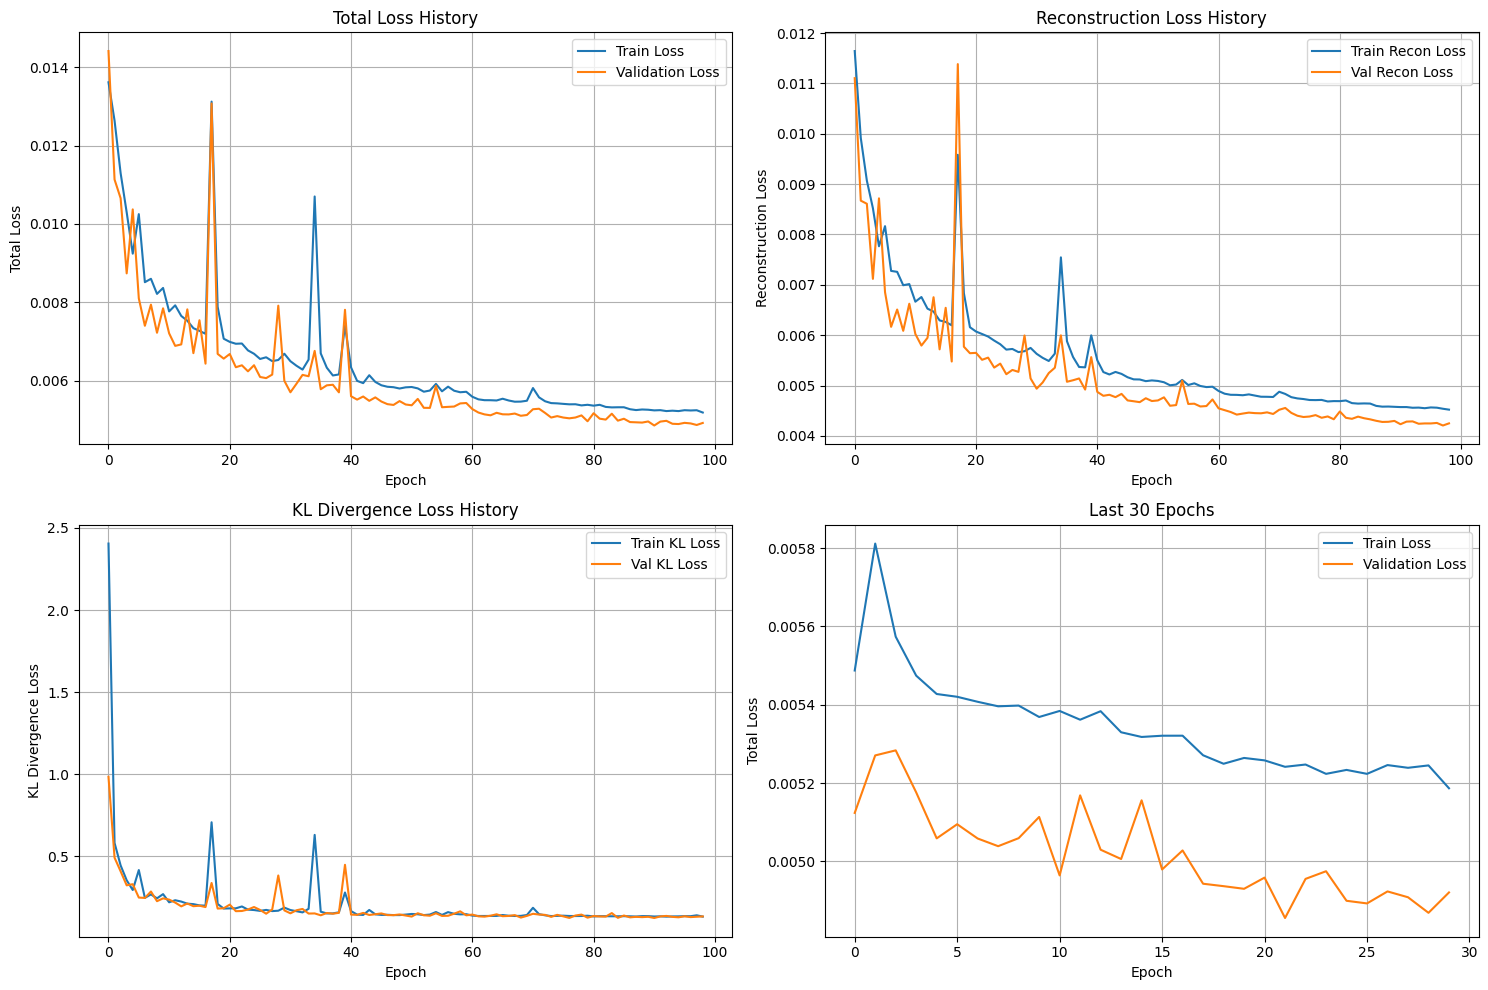


Training completed in 180.73 minutes
Best validation loss: 0.004856


In [33]:
# Example usage to train the VAE
if __name__ == "__main__":
    # Create the VAE model
    model = VAE(latent_dim=256)
    
    # Create VAE configuration
    config = VAEConfig(
        latent_dim=256,
        batch_size=8,
        accumulation_steps=8,  # Effective batch size = 64
        learning_rate=5e-5,
        epochs=100,
        beta=0.005,  # KL weight - smaller values prioritize reconstruction
        beta_warmup_steps=2000,
        early_stopping_patience=15,
        use_mixed_precision=True,
        num_workers=4,
        model_name="vae_model_v1"
    )
    
    # Train the VAE
    results = train_vae(model, train_loader, val_loader, config)

### Config

In [34]:
# Cell 21: VAE Evaluation and Comparison with Autoencoder
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from tqdm import tqdm

def load_trained_vae(checkpoint_dir, model_name='vae_model', latent_dim=256):
    """Load trained VAE model for evaluation"""
    model_path = Path(checkpoint_dir) / f"{model_name}_best.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"
    
    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VAE(latent_dim=latent_dim)
    
    if model_path.exists():
        # Load best model if available
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Loaded best VAE model from {model_path}")
    else:
        # Try loading checkpoint if best model doesn't exist
        checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
        if not checkpoint_path.exists():
            raise FileNotFoundError(f"No VAE model found at {model_path} or {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded VAE checkpoint from epoch {checkpoint['epoch']}")
    
    # Load training history
    if metadata_path.exists():
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        print(f"Loaded training history with {len(metadata['train_losses'])} epochs")
    else:
        metadata = {"train_losses": [], "val_losses": []}
        print("No metadata found, using empty history")
    
    model.eval()
    model.to(device)
    
    return model, metadata

def visualize_vae_reconstructions(model, dataloader, num_samples=3):
    """Visualize original vs reconstructed volumes from VAE"""
    device = next(model.parameters()).device
    
    # Get samples from dataloader
    samples = []
    labels = []
    
    for batch in dataloader:
        volumes = batch['volume']
        batch_labels = batch['label']
        
        for i in range(min(len(volumes), num_samples - len(samples))):
            samples.append(volumes[i:i+1])
            labels.append(batch_labels[i])
            
        if len(samples) >= num_samples:
            break
    
    # Visualize each sample with multiple reconstructions
    with torch.no_grad():
        for idx, (sample, label) in enumerate(zip(samples, labels)):
            # Get original volume
            orig_vol = sample.to(device)
            
            # Generate multiple reconstructions to visualize variability
            reconstructions = []
            for _ in range(3):  # Generate 3 different reconstructions
                recon, _, _ = model(orig_vol)
                reconstructions.append(recon.cpu().squeeze().numpy())
            
            # Move original to CPU for visualization
            orig_vol = orig_vol.cpu().squeeze().numpy()
            
            # Create figure for this sample
            fig = plt.figure(figsize=(15, 12))
            plt.suptitle(f"VAE Sample {idx+1} - Group: {label}", fontsize=16)
            
            # Define slice indices (midpoint by default)
            z_slice = orig_vol.shape[0] // 2
            y_slice = orig_vol.shape[1] // 2
            x_slice = orig_vol.shape[2] // 2
            
            # Plot original slices in first row
            plt.subplot(4, 3, 1)
            plt.imshow(orig_vol[z_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Axial")
            plt.axis('off')
            
            plt.subplot(4, 3, 2)
            plt.imshow(orig_vol[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Coronal")
            plt.axis('off')
            
            plt.subplot(4, 3, 3)
            plt.imshow(orig_vol[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
            plt.title("Original - Sagittal")
            plt.axis('off')
            
            # Plot multiple reconstructions to show variability
            for i, recon in enumerate(reconstructions):
                row = i + 1
                
                plt.subplot(4, 3, row*3 + 1)
                plt.imshow(recon[z_slice], cmap='gray', vmin=0, vmax=3)
                plt.title(f"Recon {row} - Axial")
                plt.axis('off')
                
                plt.subplot(4, 3, row*3 + 2)
                plt.imshow(recon[:, y_slice, :], cmap='gray', vmin=0, vmax=3)
                plt.title(f"Recon {row} - Coronal")
                plt.axis('off')
                
                plt.subplot(4, 3, row*3 + 3)
                plt.imshow(recon[:, :, x_slice], cmap='gray', vmin=0, vmax=3)
                plt.title(f"Recon {row} - Sagittal")
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()

def extract_vae_latent_vectors(model, dataloader, max_samples=None):
    """Extract latent vectors from VAE encoder"""
    device = next(model.parameters()).device
    
    latent_vectors = []
    labels = []
    paths = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting VAE latent vectors"):
            volumes = batch['volume'].to(device)
            batch_labels = batch['label']
            batch_paths = batch['path']
            
            # Extract latent vectors (mean only, ignore log_var)
            mu, _ = model.encode(volumes)
            
            # Store results
            latent_vectors.append(mu.cpu().numpy())
            labels.extend(batch_labels)
            paths.extend(batch_paths)
            
            # Check if we have enough samples
            if max_samples and len(labels) >= max_samples:
                latent_vectors = np.vstack(latent_vectors)
                latent_vectors = latent_vectors[:max_samples]
                labels = labels[:max_samples]
                paths = paths[:max_samples]
                break
    
    # Stack all latent vectors if we didn't break early
    if isinstance(latent_vectors[0], np.ndarray):
        latent_vectors = np.vstack(latent_vectors)
    
    return latent_vectors, labels, paths

def compare_latent_spaces(ae_vectors, vae_vectors, labels, method='tsne'):
    """Compare autoencoder and VAE latent spaces side by side"""
    plt.figure(figsize=(20, 8))
    
    # Create label-to-color mapping for consistent colors
    unique_labels = list(set(labels))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Apply dimensionality reduction to both latent spaces
    if method.lower() == 'tsne':
        print("Computing t-SNE projections...")
        reducer = TSNE(n_components=2, random_state=42, 
                     perplexity=min(30, len(ae_vectors) - 1))
        title = 't-SNE Visualization of Latent Spaces'
    else:
        print("Computing PCA projections...")
        reducer = PCA(n_components=2, random_state=42)
        title = 'PCA Visualization of Latent Spaces'
    
    # Apply reduction to AE vectors
    ae_reduced = reducer.fit_transform(ae_vectors)
    
    # Reset the random state for consistency before applying to VAE vectors
    if method.lower() == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, 
                     perplexity=min(30, len(vae_vectors) - 1))
    else:
        reducer = PCA(n_components=2, random_state=42)
    
    # Apply reduction to VAE vectors
    vae_reduced = reducer.fit_transform(vae_vectors)
    
    # Plot AE latent space
    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            ae_reduced[indices, 0], 
            ae_reduced[indices, 1],
            label=label, 
            color=label_to_color[label], 
            alpha=0.7,
            edgecolor='w',
            s=100
        )
    plt.title(f"Standard Autoencoder\n{method.upper()} Latent Space", fontsize=14)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Group", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Plot VAE latent space
    plt.subplot(1, 2, 2)
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            vae_reduced[indices, 0], 
            vae_reduced[indices, 1],
            label=label, 
            color=label_to_color[label], 
            alpha=0.7,
            edgecolor='w',
            s=100
        )
    plt.title(f"Variational Autoencoder\n{method.upper()} Latent Space", fontsize=14)
    plt.xlabel("Dimension 1", fontsize=12)
    plt.ylabel("Dimension 2", fontsize=12)
    plt.legend(title="Group", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return ae_reduced, vae_reduced

def generate_vae_samples(model, num_samples=5):
    """Generate synthetic brain scans from random latent vectors"""
    device = next(model.parameters()).device
    
    # Generate random latent vectors
    z = torch.randn(num_samples, model.latent_dim, device=device)
    
    # Generate samples
    with torch.no_grad():
        samples = model.decoder(z)
    
    # Visualize generated samples
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i in range(num_samples):
        sample = samples[i, 0].cpu().numpy()
        
        # Get middle slices
        z_slice = sample.shape[0] // 2
        y_slice = sample.shape[1] // 2
        x_slice = sample.shape[2] // 2
        
        # Plot slices
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(sample[z_slice], cmap='gray')
        plt.title(f"Sample {i+1} - Axial" if i == 0 else "")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(sample[:, y_slice, :], cmap='gray')
        plt.title(f"Sample {i+1} - Coronal" if i == 0 else "")
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(sample[:, :, x_slice], cmap='gray')
        plt.title(f"Sample {i+1} - Sagittal" if i == 0 else "")
        plt.axis('off')
    
    plt.suptitle("Generated Brain Scans from VAE Random Sampling", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return samples

def interpolate_between_groups(ae_model, vae_model, dataloader, start_group='Control', end_group='PD', steps=5):
    """Compare interpolation between groups for both AE and VAE"""
    device = next(ae_model.parameters()).device
    
    # Get a sample from each group
    start_sample = None
    end_sample = None
    
    for batch in dataloader:
        volumes = batch['volume']
        labels = batch['label']
        
        for i, (volume, label) in enumerate(zip(volumes, labels)):
            if label == start_group and start_sample is None:
                start_sample = volume.unsqueeze(0)
            elif label == end_group and end_sample is None:
                end_sample = volume.unsqueeze(0)
                
        if start_sample is not None and end_sample is not None:
            break
    
    if start_sample is None or end_sample is None:
        print(f"Couldn't find samples for both {start_group} and {end_group}")
        return
    
    # Move to device
    start_sample = start_sample.to(device)
    end_sample = end_sample.to(device)
    
    # Get latent vectors for AE
    with torch.no_grad():
        start_z_ae = ae_model.encode(start_sample)
        end_z_ae = ae_model.encode(end_sample)
    
    # Get latent vectors for VAE (use mu only)
    with torch.no_grad():
        start_z_vae, _ = vae_model.encode(start_sample)
        end_z_vae, _ = vae_model.encode(end_sample)
    
    # Create interpolation steps
    alphas = np.linspace(0, 1, steps)
    
    # Interpolate in AE latent space
    ae_interpolated = []
    for alpha in alphas:
        z = (1 - alpha) * start_z_ae + alpha * end_z_ae
        with torch.no_grad():
            reconstructed = ae_model.decode(z)
            ae_interpolated.append(reconstructed.cpu().squeeze().numpy())
    
    # Interpolate in VAE latent space
    vae_interpolated = []
    for alpha in alphas:
        z = (1 - alpha) * start_z_vae + alpha * end_z_vae
        with torch.no_grad():
            reconstructed = vae_model.decoder(z)
            vae_interpolated.append(reconstructed.cpu().squeeze().numpy())
    
    # Visualize interpolation
    plt.figure(figsize=(15, 5 * steps))
    
    # Plot first row title
    plt.figtext(0.25, 0.98, "Standard Autoencoder", fontsize=14, ha='center')
    plt.figtext(0.75, 0.98, "Variational Autoencoder", fontsize=14, ha='center')
    
    for i, alpha in enumerate(alphas):
        # Get a slice index (middle)
        z_slice = ae_interpolated[i].shape[0] // 2
        
        # Plot AE interpolation
        plt.subplot(steps, 2, i*2 + 1)
        plt.imshow(ae_interpolated[i][z_slice], cmap='gray')
        plt.title(f"α = {alpha:.2f}" if i == 0 else "")
        plt.axis('off')
        
        # Plot VAE interpolation
        plt.subplot(steps, 2, i*2 + 2)
        plt.imshow(vae_interpolated[i][z_slice], cmap='gray')
        plt.title(f"α = {alpha:.2f}" if i == 0 else "")
        plt.axis('off')
    
    plt.suptitle(f"Interpolation from {start_group} to {end_group}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return ae_interpolated, vae_interpolated

Loading trained Autoencoder...

Loading trained VAE...
Loaded best VAE model from checkpoints/vae_model_v1_best.pth
Loaded training history with 99 epochs

Visualizing VAE reconstructions...


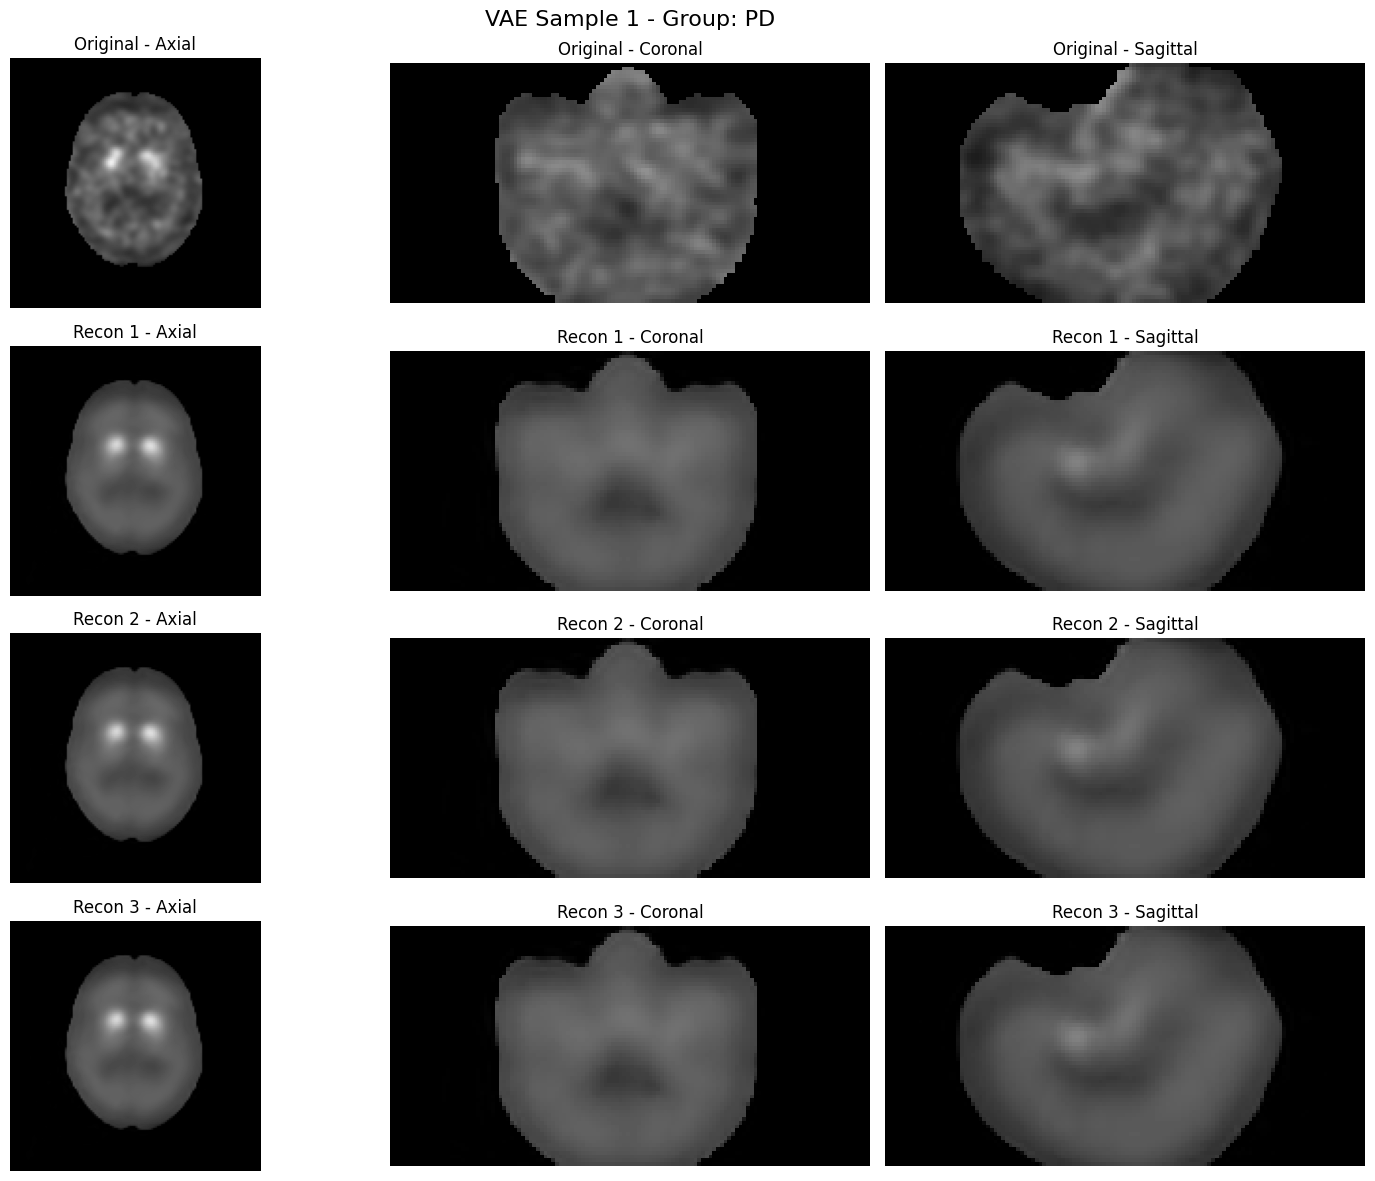

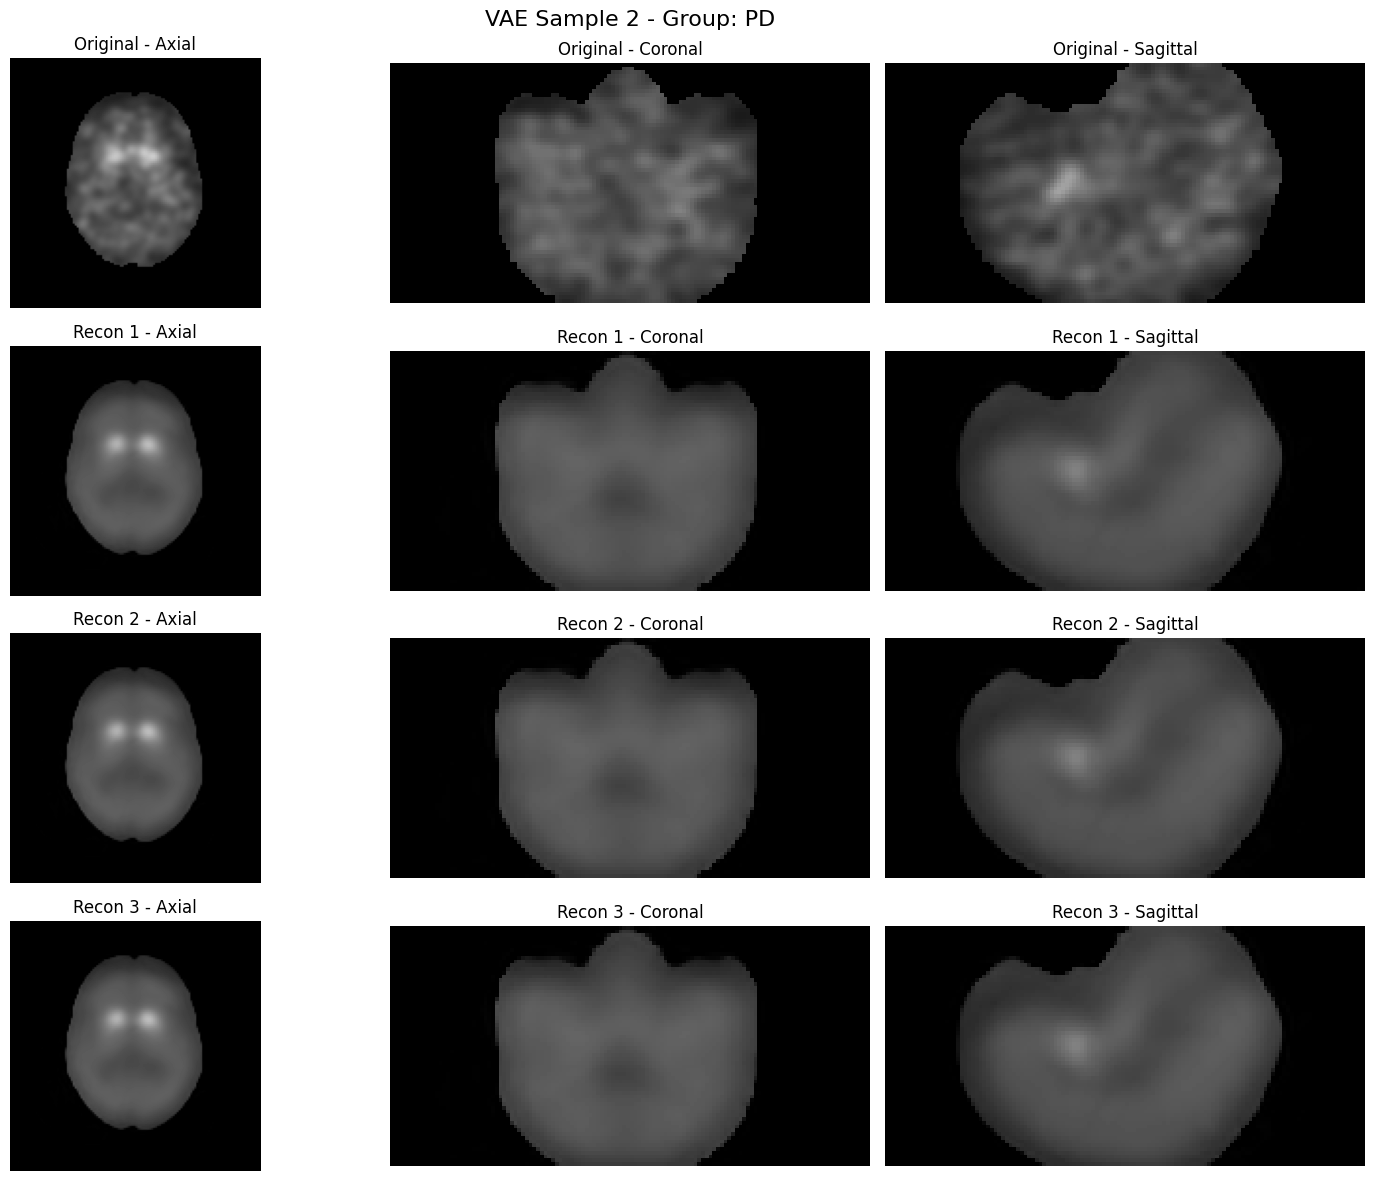

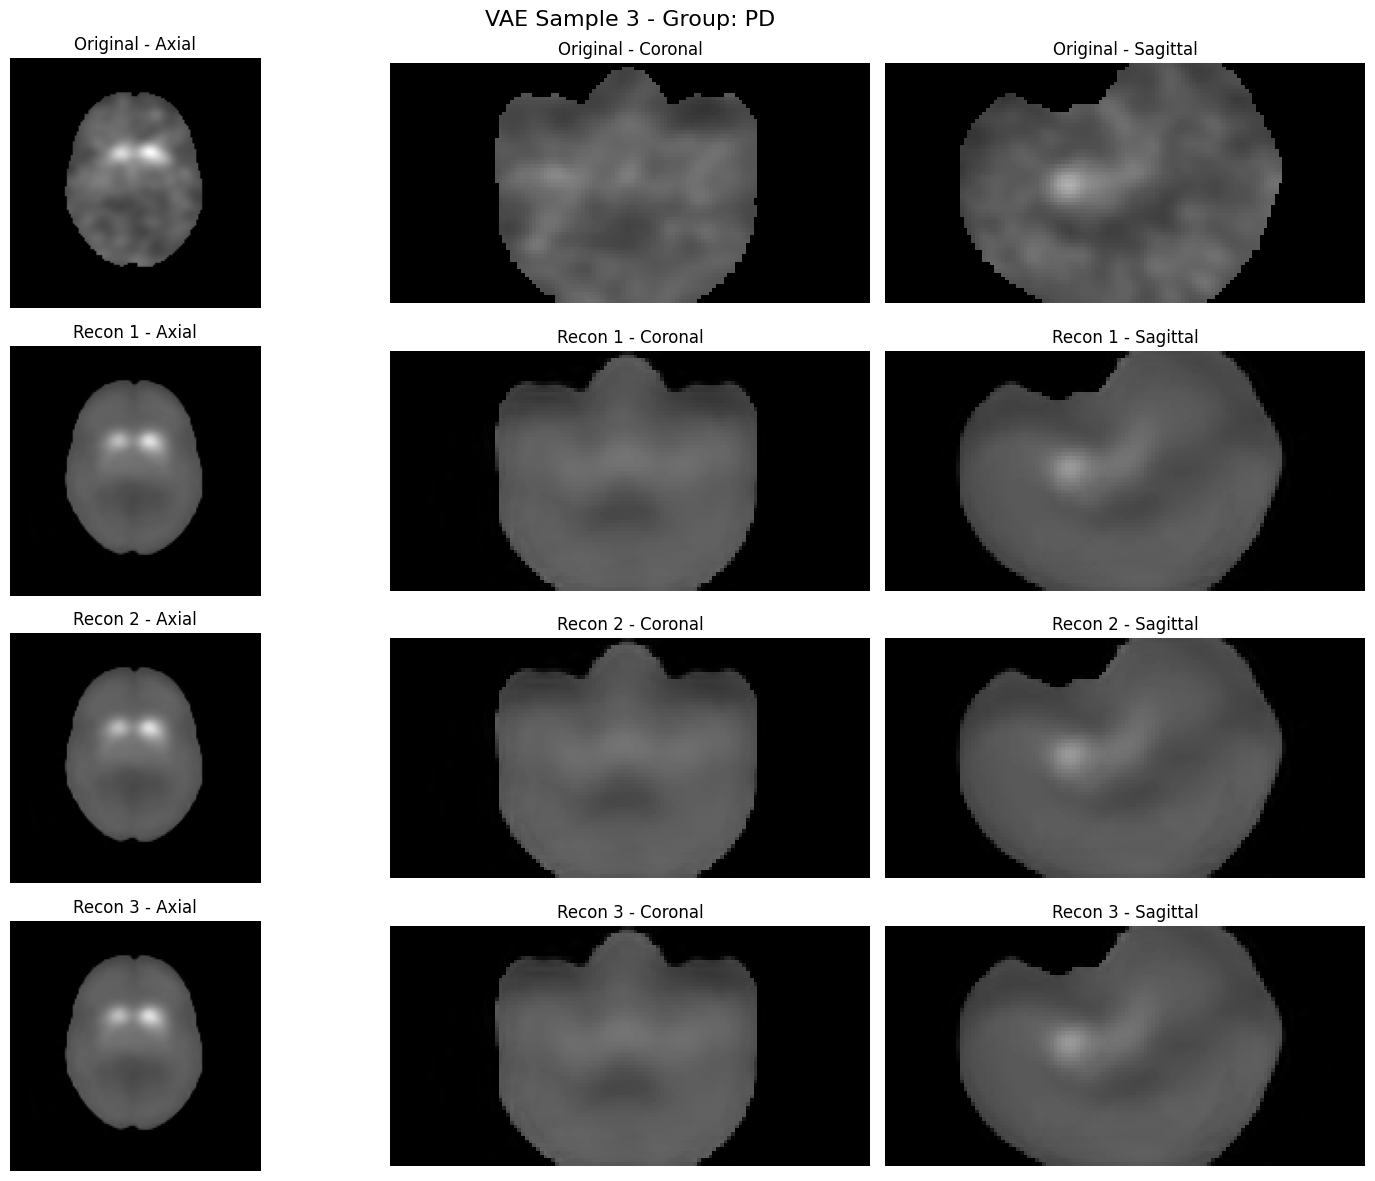


Extracting latent vectors from Autoencoder...


Extracting latent vectors:   4%|▍         | 12/299 [00:00<00:14, 20.44it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Extracting latent vectors:  21%|██        | 63/299 [00:03<00:11, 19.99it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Extracting latent vectors:  33%|███▎      | 99/299 [00:07<00:15, 12.88it/s]



Extracting latent vectors from VAE...


Extracting VAE latent vectors:   4%|▍         | 13/299 [00:00<00:15, 18.65it/s]

Error processing file Images/PPMI_Images_PD/3863/Reconstructed_DaTSCAN/2013-03-13_13_29_21.0/I449248/PPMI_3863_NM_Reconstructed_DaTSCAN_Br_20141022165646607_1_S202944_I449248.dcm: operands could not be broadcast together with shapes (60,128,128) (91,109,91) 


Extracting VAE latent vectors:  21%|██        | 62/299 [00:03<00:10, 22.35it/s]

Error processing file Images/PPMI_Images_PD/3179/Reconstructed_DaTSCAN/2016-08-18_13_51_47.0/I1317564/PPMI_3179_NM_Reconstructed_DaTSCAN_Br_20200616100643787_1_S550153_I1317564.dcm: operands could not be broadcast together with shapes (480,128,128) (91,109,91) 


Extracting VAE latent vectors:  33%|███▎      | 99/299 [00:04<00:10, 19.92it/s]



Comparing latent spaces with t-SNE...
Computing t-SNE projections...


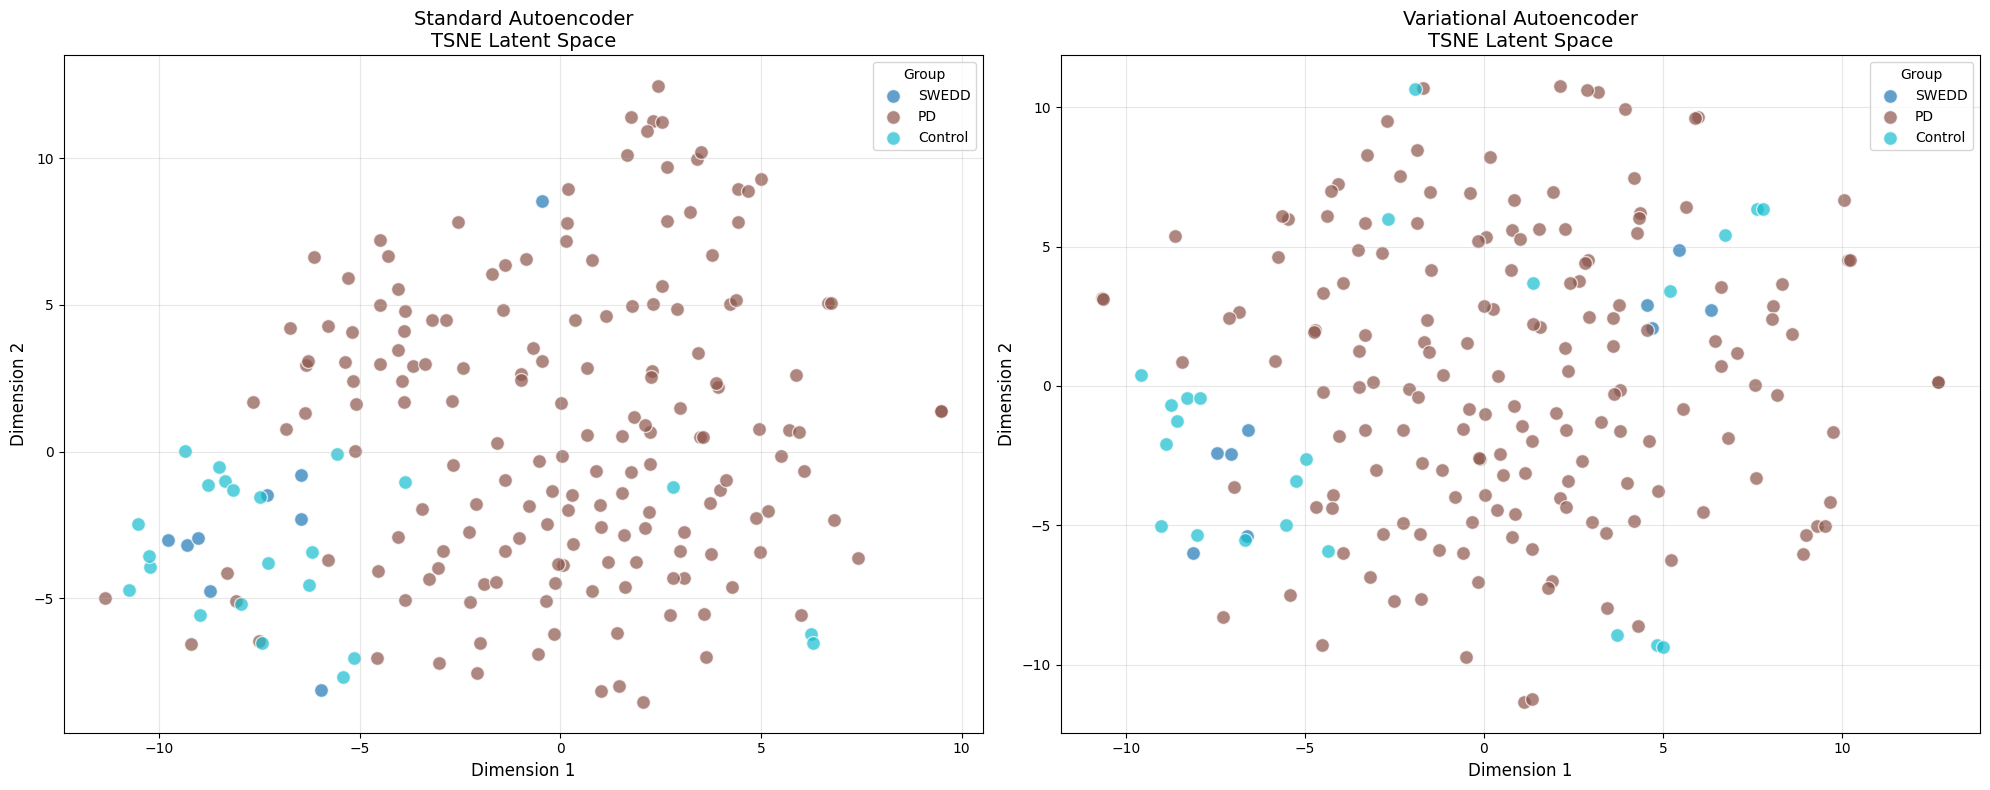


Comparing latent spaces with PCA...
Computing PCA projections...


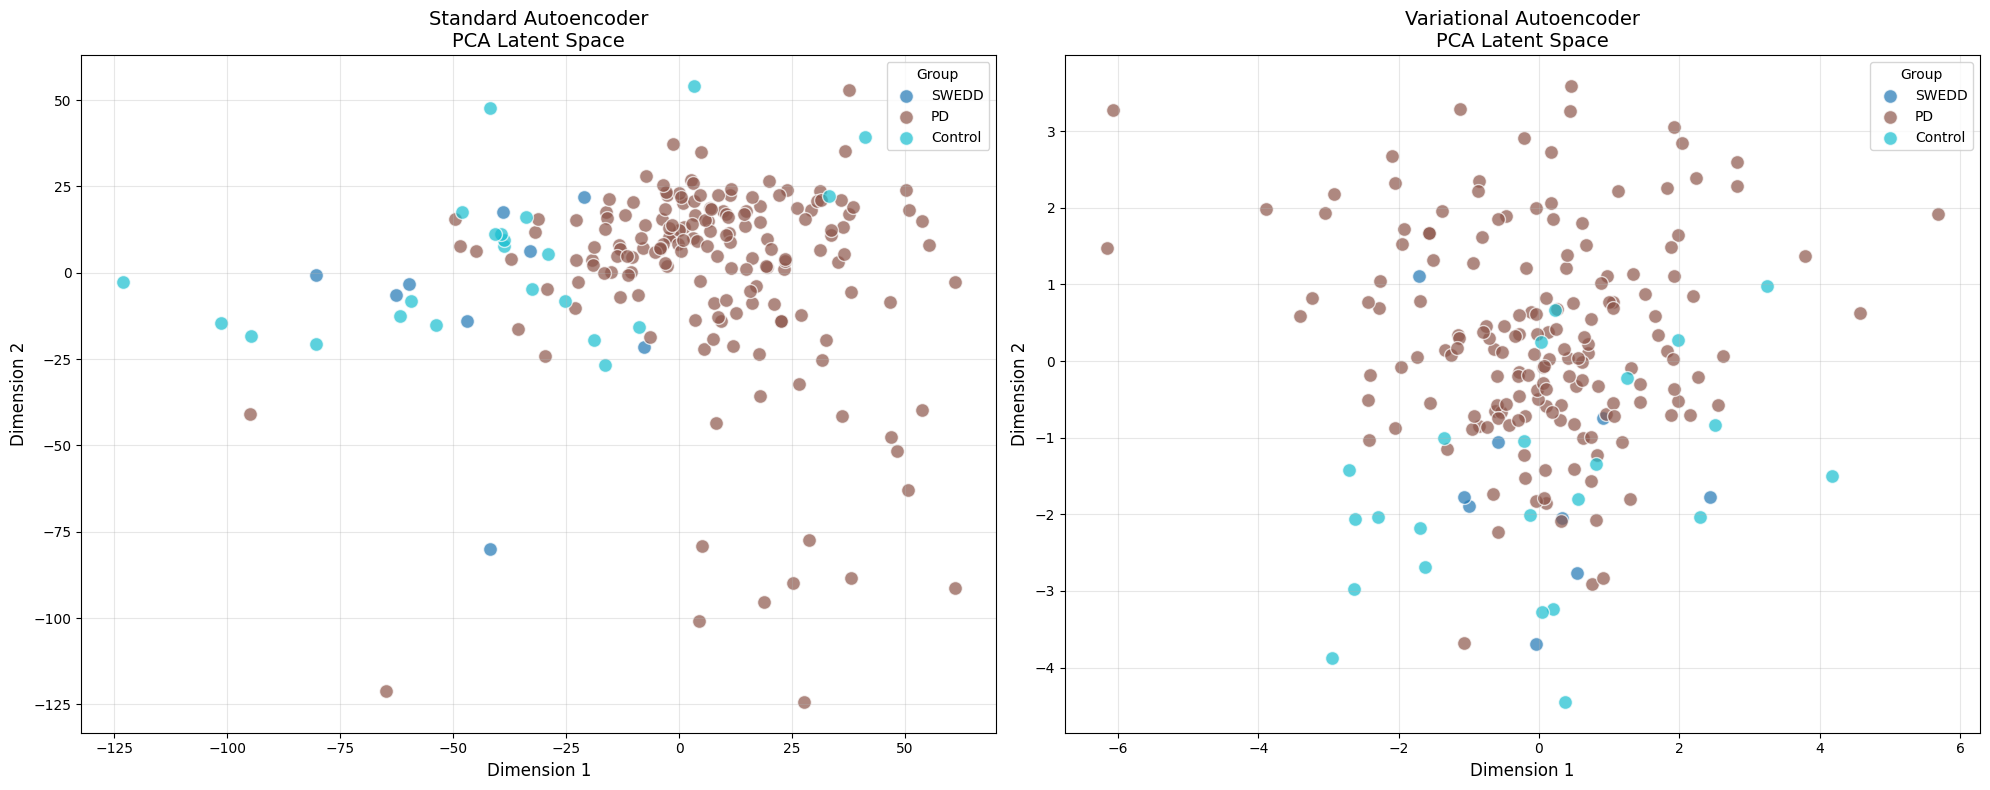


Generating synthetic brain scans from VAE...


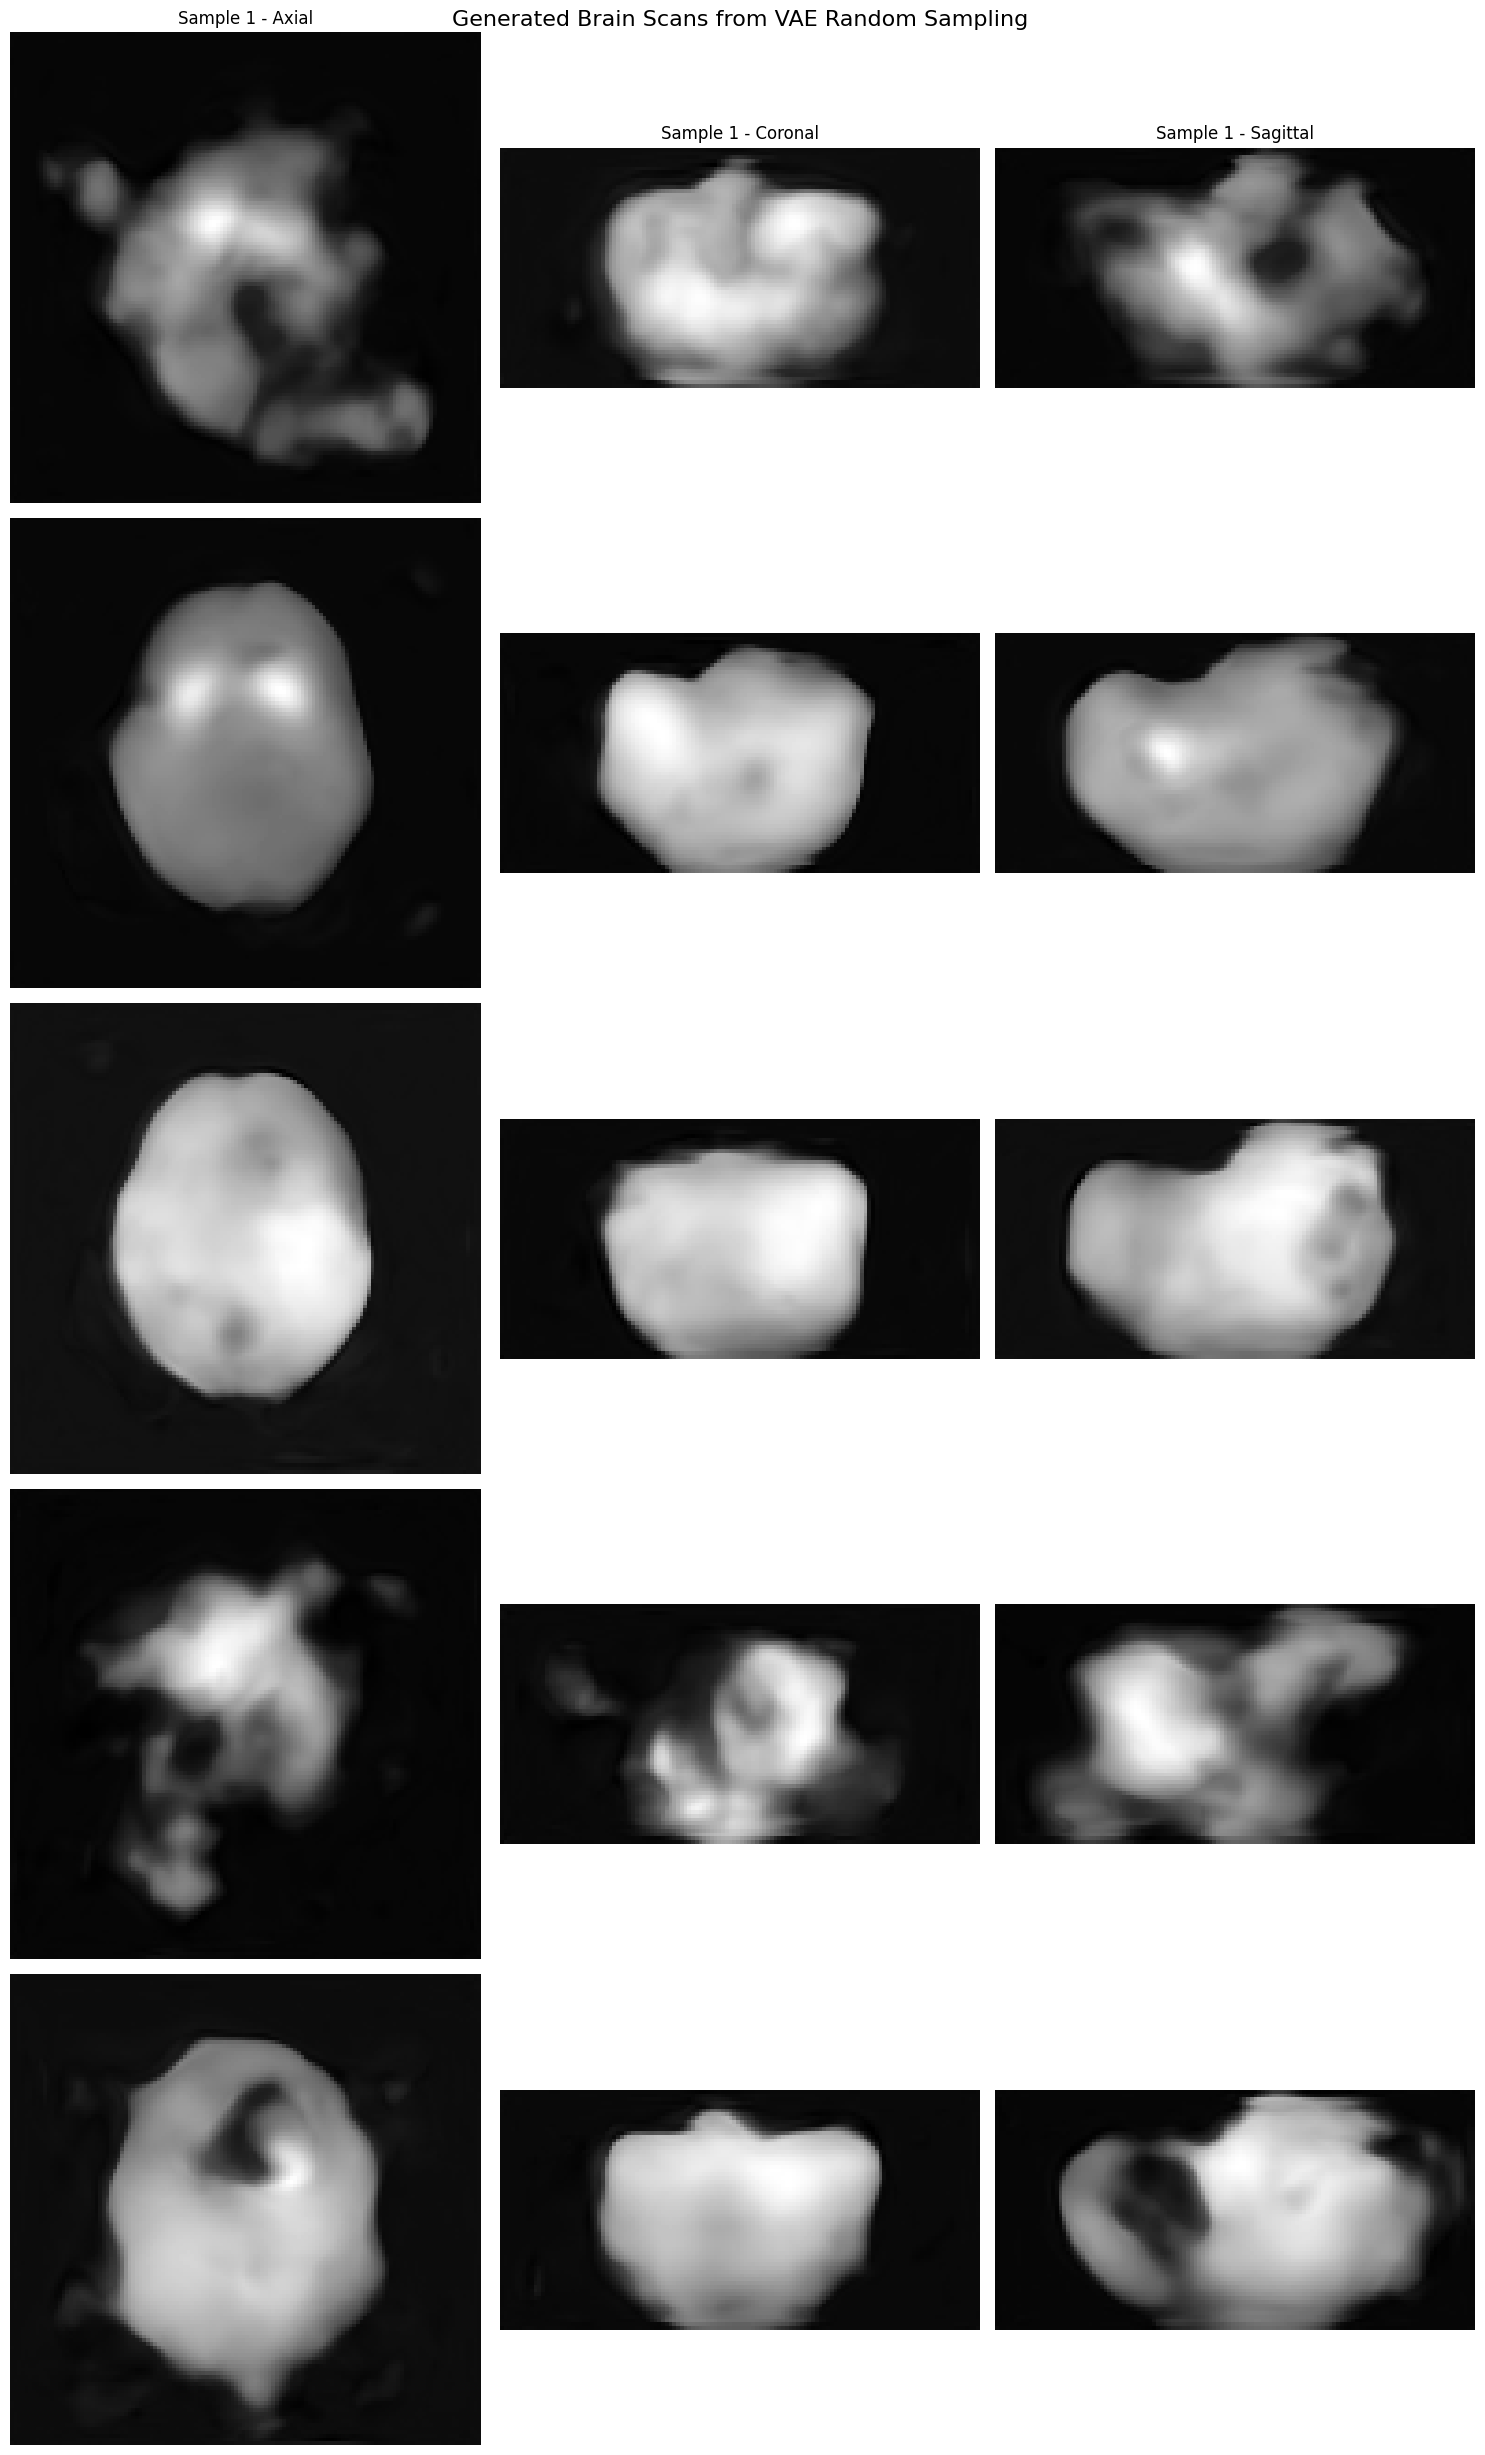


Comparing interpolation capabilities...


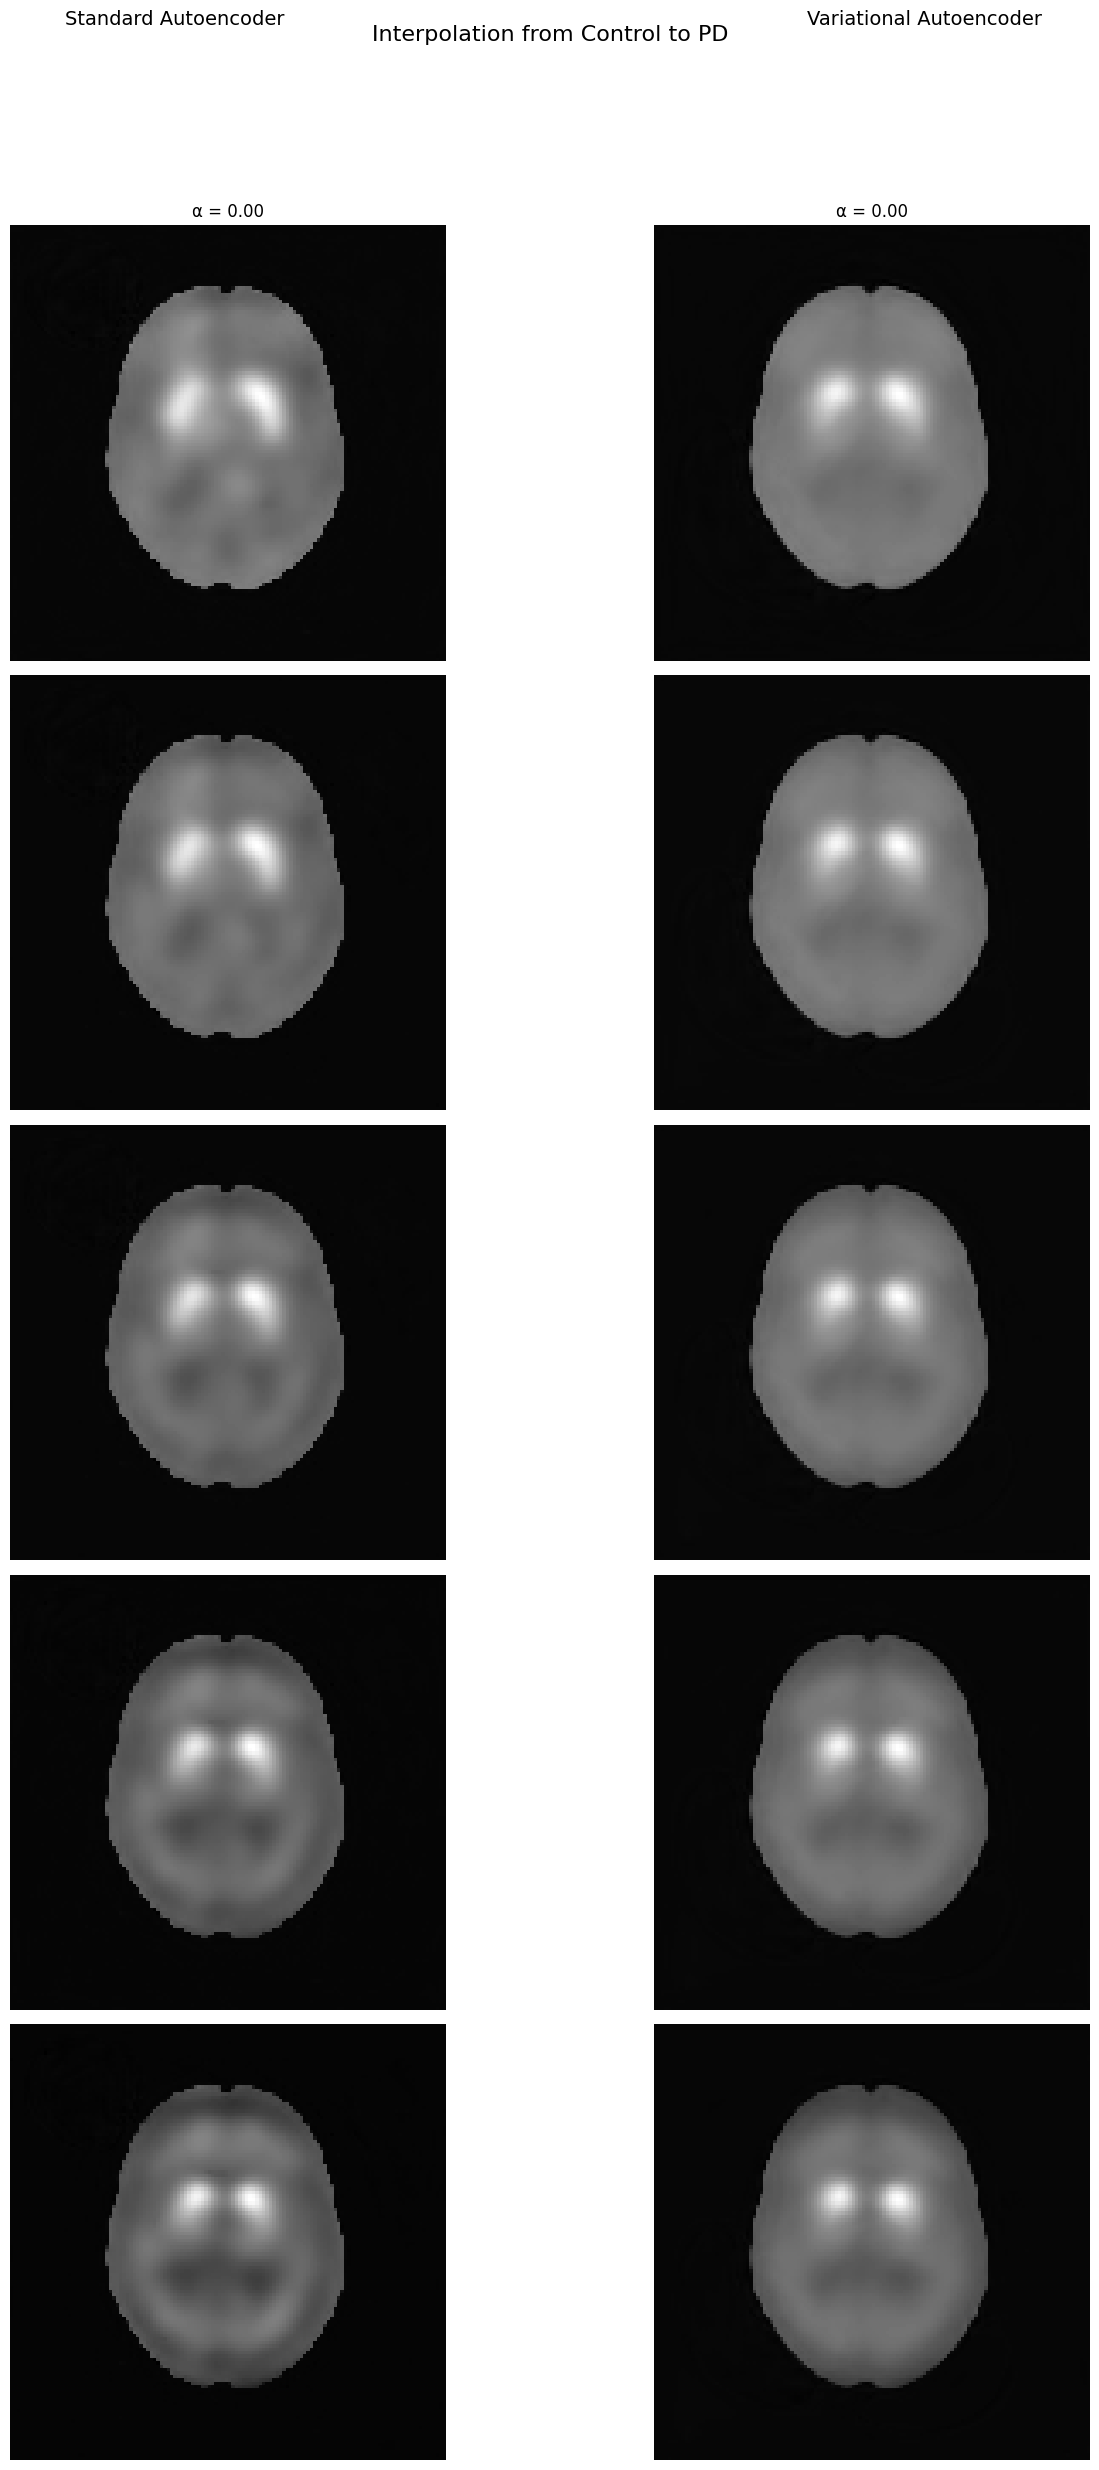

In [35]:
# Run VAE evaluation
if __name__ == "__main__":
    # Uncomment this code to run the VAE evaluation
    # First, load both models
    print("Loading trained Autoencoder...")
    ae_model, ae_metadata = load_trained_model('checkpoints', 'autoencoder_v1', latent_dim=256)
    
    print("\nLoading trained VAE...")
    vae_model, vae_metadata = load_trained_vae('checkpoints', 'vae_model_v1', latent_dim=256)
    
    # Compare reconstructions
    print("\nVisualizing VAE reconstructions...")
    visualize_vae_reconstructions(vae_model, val_loader, num_samples=3)
    
    # Extract latent vectors from both models
    print("\nExtracting latent vectors from Autoencoder...")
    ae_vectors, labels, paths = extract_latent_vectors(ae_model, val_loader, max_samples=200)
    
    print("\nExtracting latent vectors from VAE...")
    vae_vectors, vae_labels, vae_paths = extract_vae_latent_vectors(vae_model, val_loader, max_samples=200)
    
    # Compare latent spaces
    print("\nComparing latent spaces with t-SNE...")
    ae_tsne, vae_tsne = compare_latent_spaces(ae_vectors, vae_vectors, labels, method='tsne')
    
    print("\nComparing latent spaces with PCA...")
    ae_pca, vae_pca = compare_latent_spaces(ae_vectors, vae_vectors, labels, method='pca')
    
    # Generate synthetic samples from VAE
    print("\nGenerating synthetic brain scans from VAE...")
    synthetic_samples = generate_vae_samples(vae_model, num_samples=5)
    
    # Compare interpolation capabilities
    print("\nComparing interpolation capabilities...")
    ae_interp, vae_interp = interpolate_between_groups(ae_model, vae_model, val_loader, 
                                                     start_group='Control', end_group='PD', steps=5)

In [67]:
# Cell 22: Training Loop
def train_vae(model, train_loader, val_loader, config=None):
    """Training loop with memory optimization for 4070Ti."""
    if config is None:
        config = VAEConfig()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Initialize components
    criterion = VAELoss(config.beta_start, config.beta_end, config.beta_steps)
    optimizer = create_vae_optimizer(model, config)
    scheduler = create_vae_scheduler(optimizer)
    scaler = torch.cuda.amp.GradScaler(enabled=config.use_amp)
    checkpoint_handler = CheckpointHandler(config.checkpoint_dir, config.model_name)

    # Training tracking
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    # Load checkpoint if available
    start_epoch = 0
    checkpoint_data = checkpoint_handler.load(model, optimizer, scheduler)
    if checkpoint_data:
        start_epoch = checkpoint_data['epoch'] + 1
        train_losses = checkpoint_data['train_losses']
        val_losses = checkpoint_data['val_losses']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, config.epochs):
            # Training phase
            model.train()
            train_loss = 0
            train_recon_loss = 0
            train_kl_loss = 0

            train_pbar = tqdm(train_loader,
                            desc=f'Epoch {epoch+1}/{config.epochs} [Train]',
                            leave=False)

            for i, batch in enumerate(train_pbar):
                try:
                    volumes = batch['volume'].to(device, non_blocking=True)

                    # Forward pass with mixed precision
                    with torch.cuda.amp.autocast(enabled=config.use_amp):
                        recon, mu, log_var = model(volumes)
                        loss, recon_l, kl_l, beta = criterion(recon, volumes, mu, log_var)
                        loss = loss / config.accumulation_steps

                    # Backward pass
                    scaler.scale(loss).backward()

                    # Gradient accumulation
                    if (i + 1) % config.accumulation_steps == 0:
                        scaler.step(optimizer)
                        scaler.update()
                        optimizer.zero_grad()

                    # Track losses
                    train_loss += loss.item() * config.accumulation_steps
                    train_recon_loss += recon_l.item()
                    train_kl_loss += kl_l.item()

                    # Update progress bar
                    train_pbar.set_postfix({
                        'loss': loss.item() * config.accumulation_steps,
                        'recon': recon_l.item(),
                        'kl': kl_l.item(),
                        'beta': beta
                    })

                    # Clean up
                    del volumes, recon, mu, log_var
                    torch.cuda.empty_cache()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"\nOOM in batch {i}. Cleaning up...")
                        if 'volumes' in locals():
                            del volumes
                        if 'recon' in locals():
                            del recon
                        torch.cuda.empty_cache()
                        continue
                    raise e

            # Validation phase
            model.eval()
            val_loss = 0

            val_pbar = tqdm(val_loader,
                          desc=f'Epoch {epoch+1}/{config.epochs} [Val]',
                          leave=False)

            with torch.no_grad():
                for batch in val_pbar:
                    try:
                        volumes = batch['volume'].to(device)
                        recon, mu, log_var = model(volumes)
                        loss, _, _, _ = criterion(recon, volumes, mu, log_var)
                        val_loss += loss.item()

                        val_pbar.set_postfix({'loss': loss.item()})

                        del volumes, recon, mu, log_var
                        torch.cuda.empty_cache()

                    except RuntimeError as e:
                        if "out of memory" in str(e):
                            print("\nOOM during validation. Cleaning up...")
                            if 'volumes' in locals():
                                del volumes
                            if 'recon' in locals():
                                del recon
                            torch.cuda.empty_cache()
                            continue
                        raise e

            # Calculate average losses
            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)

            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Save checkpoint
            checkpoint_handler.save(
                model, optimizer, scheduler,
                epoch, train_losses, val_losses
            )

            # Early stopping check
            if avg_val_loss < best_val_loss - config.min_delta:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model
                torch.save(model.state_dict(),
                         os.path.join(config.checkpoint_dir, f'{config.model_name}_best.pth'))
            else:
                patience_counter += 1
                if patience_counter >= config.patience:
                    print(f"\nEarly stopping triggered at epoch {epoch+1}")
                    break

            # Print epoch summary
            print(f"\nEpoch [{epoch+1}/{config.epochs}]")
            print(f"Train Loss: {avg_train_loss:.6f}")
            print(f"Val Loss: {avg_val_loss:.6f}")
            print(f"Beta: {beta:.4f}")
            print_gpu_memory_stats()  # From previous implementation

    except KeyboardInterrupt:
        print("\nTraining interrupted by user!")

    finally:
        # Plot training history
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(config.checkpoint_dir, f"{config.model_name}_training_history.png"))
        plt.show()

    return train_losses, val_losses

def create_vae_optimizer(model, config):
    """Create optimizer for VAE training."""
    return torch.optim.Adam(model.parameters(), lr=config.learning_rate)

def create_vae_scheduler(optimizer):
    """Create learning rate scheduler for VAE training."""
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=5,
        verbose=True
    )

### Training

Epoch 1/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 1/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [1/300]
Train Loss: 0.140066
Val Loss: 0.178836
Beta: 0.0020
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 2/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 2/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [2/300]
Train Loss: 0.030608
Val Loss: 0.023290
Beta: 0.0021
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 3/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 3/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [3/300]
Train Loss: 0.018679
Val Loss: 0.015803
Beta: 0.0021
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 4/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 4/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [4/300]
Train Loss: 0.015757
Val Loss: 0.013621
Beta: 0.0022
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 5/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 5/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [5/300]
Train Loss: 0.014430
Val Loss: 0.012914
Beta: 0.0022
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 6/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 6/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [6/300]
Train Loss: 0.013729
Val Loss: 0.012245
Beta: 0.0023
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 7/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 7/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [7/300]
Train Loss: 0.013036
Val Loss: 0.011726
Beta: 0.0023
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 8/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 8/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [8/300]
Train Loss: 0.012576
Val Loss: 0.011265
Beta: 0.0023
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 9/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 9/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [9/300]
Train Loss: 0.012097
Val Loss: 0.011004
Beta: 0.0024
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 10/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 10/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [10/300]
Train Loss: 0.011716
Val Loss: 0.010463
Beta: 0.0024
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 11/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 11/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [11/300]
Train Loss: 0.011496
Val Loss: 0.010338
Beta: 0.0025
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 12/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 12/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [12/300]
Train Loss: 0.011328
Val Loss: 0.010069
Beta: 0.0025
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 13/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 13/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [13/300]
Train Loss: 0.011043
Val Loss: 0.010078
Beta: 0.0026
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 14/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 14/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [14/300]
Train Loss: 0.010863
Val Loss: 0.009613
Beta: 0.0026
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 15/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 15/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [15/300]
Train Loss: 0.010693
Val Loss: 0.009785
Beta: 0.0027
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 16/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 16/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [16/300]
Train Loss: 0.010676
Val Loss: 0.009441
Beta: 0.0027
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 17/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 17/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [17/300]
Train Loss: 0.010429
Val Loss: 0.009258
Beta: 0.0027
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 18/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 18/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [18/300]
Train Loss: 0.010356
Val Loss: 0.009497
Beta: 0.0028
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 19/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 19/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [19/300]
Train Loss: 0.010241
Val Loss: 0.009182
Beta: 0.0028
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 20/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 20/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [20/300]
Train Loss: 0.010052
Val Loss: 0.009346
Beta: 0.0029
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 21/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 21/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [21/300]
Train Loss: 0.009918
Val Loss: 0.009449
Beta: 0.0029
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 22/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 22/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [22/300]
Train Loss: 0.009804
Val Loss: 0.008918
Beta: 0.0030
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 23/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 23/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [23/300]
Train Loss: 0.009712
Val Loss: 0.008776
Beta: 0.0030
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 24/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 24/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [24/300]
Train Loss: 0.009634
Val Loss: 0.008923
Beta: 0.0030
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 25/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 25/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [25/300]
Train Loss: 0.009616
Val Loss: 0.008557
Beta: 0.0031
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 26/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 26/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [26/300]
Train Loss: 0.009517
Val Loss: 0.008564
Beta: 0.0031
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 27/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 27/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [27/300]
Train Loss: 0.009365
Val Loss: 0.008707
Beta: 0.0032
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 28/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 28/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [28/300]
Train Loss: 0.009399
Val Loss: 0.008462
Beta: 0.0032
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 29/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 29/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [29/300]
Train Loss: 0.009289
Val Loss: 0.008549
Beta: 0.0033
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 30/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 30/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [30/300]
Train Loss: 0.009312
Val Loss: 0.008484
Beta: 0.0033
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 31/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 31/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [31/300]
Train Loss: 0.009314
Val Loss: 0.009279
Beta: 0.0034
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 32/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 32/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [32/300]
Train Loss: 0.009326
Val Loss: 0.008704
Beta: 0.0034
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 33/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 33/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [33/300]
Train Loss: 0.009136
Val Loss: 0.008256
Beta: 0.0034
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 34/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 34/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [34/300]
Train Loss: 0.009035
Val Loss: 0.008218
Beta: 0.0035
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 35/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 35/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [35/300]
Train Loss: 0.008995
Val Loss: 0.008014
Beta: 0.0035
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 36/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 36/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [36/300]
Train Loss: 0.008946
Val Loss: 0.008343
Beta: 0.0036
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 37/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 37/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [37/300]
Train Loss: 0.008987
Val Loss: 0.008153
Beta: 0.0036
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 38/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 38/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [38/300]
Train Loss: 0.008891
Val Loss: 0.008123
Beta: 0.0037
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 39/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 39/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [39/300]
Train Loss: 0.008758
Val Loss: 0.008077
Beta: 0.0037
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 40/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 40/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [40/300]
Train Loss: 0.008781
Val Loss: 0.007820
Beta: 0.0037
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 41/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 41/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [41/300]
Train Loss: 0.008705
Val Loss: 0.008024
Beta: 0.0038
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 42/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 42/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [42/300]
Train Loss: 0.008856
Val Loss: 0.008130
Beta: 0.0038
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 43/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 43/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [43/300]
Train Loss: 0.008842
Val Loss: 0.007786
Beta: 0.0039
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 44/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 44/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [44/300]
Train Loss: 0.008697
Val Loss: 0.007573
Beta: 0.0039
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 45/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 45/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [45/300]
Train Loss: 0.008583
Val Loss: 0.007674
Beta: 0.0040
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 46/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 46/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [46/300]
Train Loss: 0.008516
Val Loss: 0.008009
Beta: 0.0040
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 47/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 47/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [47/300]
Train Loss: 0.008547
Val Loss: 0.007822
Beta: 0.0041
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 48/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 48/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [48/300]
Train Loss: 0.008554
Val Loss: 0.007928
Beta: 0.0041
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 49/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 49/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [49/300]
Train Loss: 0.008605
Val Loss: 0.008009
Beta: 0.0041
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 50/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 50/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [50/300]
Train Loss: 0.008597
Val Loss: 0.007485
Beta: 0.0042
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 51/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 51/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [51/300]
Train Loss: 0.008446
Val Loss: 0.007360
Beta: 0.0042
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 52/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 52/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [52/300]
Train Loss: 0.008397
Val Loss: 0.007662
Beta: 0.0043
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 53/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 53/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [53/300]
Train Loss: 0.008362
Val Loss: 0.007551
Beta: 0.0043
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 54/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 54/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [54/300]
Train Loss: 0.008540
Val Loss: 0.007937
Beta: 0.0044
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 55/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 55/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [55/300]
Train Loss: 0.008555
Val Loss: 0.007546
Beta: 0.0044
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 56/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 56/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [56/300]
Train Loss: 0.008326
Val Loss: 0.007482
Beta: 0.0045
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 57/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 57/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [57/300]
Train Loss: 0.008264
Val Loss: 0.007508
Beta: 0.0045
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 58/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 58/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [58/300]
Train Loss: 0.008130
Val Loss: 0.007344
Beta: 0.0045
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 59/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 59/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [59/300]
Train Loss: 0.008129
Val Loss: 0.007339
Beta: 0.0046
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 60/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 60/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [60/300]
Train Loss: 0.008038
Val Loss: 0.007367
Beta: 0.0046
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 61/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 61/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [61/300]
Train Loss: 0.008096
Val Loss: 0.007312
Beta: 0.0047
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 62/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 62/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [62/300]
Train Loss: 0.008023
Val Loss: 0.007298
Beta: 0.0047
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 63/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 63/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [63/300]
Train Loss: 0.008035
Val Loss: 0.007212
Beta: 0.0048
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 64/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 64/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [64/300]
Train Loss: 0.007975
Val Loss: 0.007326
Beta: 0.0048
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 65/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 65/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [65/300]
Train Loss: 0.008024
Val Loss: 0.007148
Beta: 0.0049
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 66/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 66/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [66/300]
Train Loss: 0.008002
Val Loss: 0.007187
Beta: 0.0049
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 67/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 67/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [67/300]
Train Loss: 0.007994
Val Loss: 0.007178
Beta: 0.0049
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 68/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 68/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [68/300]
Train Loss: 0.007970
Val Loss: 0.007169
Beta: 0.0050
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 69/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 69/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [69/300]
Train Loss: 0.008036
Val Loss: 0.007343
Beta: 0.0050
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 70/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 70/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [70/300]
Train Loss: 0.008062
Val Loss: 0.007290
Beta: 0.0051
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 71/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 71/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [71/300]
Train Loss: 0.008000
Val Loss: 0.007095
Beta: 0.0051
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 72/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 72/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [72/300]
Train Loss: 0.007965
Val Loss: 0.007317
Beta: 0.0052
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 73/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 73/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [73/300]
Train Loss: 0.008026
Val Loss: 0.007073
Beta: 0.0052
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 74/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 74/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [74/300]
Train Loss: 0.007972
Val Loss: 0.007135
Beta: 0.0052
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 75/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 75/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [75/300]
Train Loss: 0.007999
Val Loss: 0.007210
Beta: 0.0053
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 76/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 76/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [76/300]
Train Loss: 0.007979
Val Loss: 0.007048
Beta: 0.0053
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 77/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 77/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [77/300]
Train Loss: 0.007959
Val Loss: 0.007051
Beta: 0.0054
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 78/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 78/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [78/300]
Train Loss: 0.007963
Val Loss: 0.007221
Beta: 0.0054
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 79/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 79/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [79/300]
Train Loss: 0.007946
Val Loss: 0.007328
Beta: 0.0055
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 80/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 80/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [80/300]
Train Loss: 0.007981
Val Loss: 0.007169
Beta: 0.0055
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 81/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 81/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [81/300]
Train Loss: 0.007973
Val Loss: 0.007424
Beta: 0.0056
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 82/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 82/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [82/300]
Train Loss: 0.007897
Val Loss: 0.007044
Beta: 0.0056
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 83/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 83/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [83/300]
Train Loss: 0.007938
Val Loss: 0.007032
Beta: 0.0056
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 84/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 84/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [84/300]
Train Loss: 0.007988
Val Loss: 0.007107
Beta: 0.0057
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 85/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 85/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [85/300]
Train Loss: 0.007933
Val Loss: 0.006952
Beta: 0.0057
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 86/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 86/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [86/300]
Train Loss: 0.008007
Val Loss: 0.007259
Beta: 0.0058
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 87/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 87/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [87/300]
Train Loss: 0.007975
Val Loss: 0.007233
Beta: 0.0058
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 88/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 88/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [88/300]
Train Loss: 0.007888
Val Loss: 0.007073
Beta: 0.0059
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 89/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 89/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [89/300]
Train Loss: 0.007979
Val Loss: 0.007161
Beta: 0.0059
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 90/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 90/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [90/300]
Train Loss: 0.007828
Val Loss: 0.007397
Beta: 0.0060
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 91/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 91/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [91/300]
Train Loss: 0.007904
Val Loss: 0.007143
Beta: 0.0060
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 92/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 92/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [92/300]
Train Loss: 0.007794
Val Loss: 0.006844
Beta: 0.0060
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 93/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 93/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [93/300]
Train Loss: 0.007745
Val Loss: 0.006884
Beta: 0.0061
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 94/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 94/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [94/300]
Train Loss: 0.007723
Val Loss: 0.006883
Beta: 0.0061
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 95/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 95/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [95/300]
Train Loss: 0.007855
Val Loss: 0.006913
Beta: 0.0062
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 96/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 96/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [96/300]
Train Loss: 0.007772
Val Loss: 0.006841
Beta: 0.0062
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 97/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 97/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [97/300]
Train Loss: 0.007781
Val Loss: 0.006958
Beta: 0.0063
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 98/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 98/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [98/300]
Train Loss: 0.007774
Val Loss: 0.006826
Beta: 0.0063
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 99/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 99/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [99/300]
Train Loss: 0.007755
Val Loss: 0.006953
Beta: 0.0063
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 100/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 100/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [100/300]
Train Loss: 0.007791
Val Loss: 0.006972
Beta: 0.0064
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 101/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 101/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [101/300]
Train Loss: 0.007787
Val Loss: 0.006929
Beta: 0.0064
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 102/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 102/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [102/300]
Train Loss: 0.007808
Val Loss: 0.006836
Beta: 0.0065
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 103/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 103/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [103/300]
Train Loss: 0.007755
Val Loss: 0.006836
Beta: 0.0065
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 104/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 104/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [104/300]
Train Loss: 0.007845
Val Loss: 0.006888
Beta: 0.0066
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 105/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 105/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [105/300]
Train Loss: 0.007749
Val Loss: 0.006828
Beta: 0.0066
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 106/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 106/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [106/300]
Train Loss: 0.007709
Val Loss: 0.006901
Beta: 0.0067
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 107/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 107/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [107/300]
Train Loss: 0.007693
Val Loss: 0.006820
Beta: 0.0067
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 108/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 108/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [108/300]
Train Loss: 0.007737
Val Loss: 0.006912
Beta: 0.0067
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 109/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 109/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [109/300]
Train Loss: 0.007690
Val Loss: 0.006806
Beta: 0.0068
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 110/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 110/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [110/300]
Train Loss: 0.007770
Val Loss: 0.006902
Beta: 0.0068
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 111/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 111/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [111/300]
Train Loss: 0.007750
Val Loss: 0.006936
Beta: 0.0069
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 112/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 112/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [112/300]
Train Loss: 0.007752
Val Loss: 0.006847
Beta: 0.0069
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 113/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 113/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [113/300]
Train Loss: 0.007779
Val Loss: 0.006956
Beta: 0.0070
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 114/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 114/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [114/300]
Train Loss: 0.007757
Val Loss: 0.006843
Beta: 0.0070
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 115/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 115/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [115/300]
Train Loss: 0.007716
Val Loss: 0.006829
Beta: 0.0070
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 116/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 116/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [116/300]
Train Loss: 0.007737
Val Loss: 0.006863
Beta: 0.0071
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 117/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 117/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [117/300]
Train Loss: 0.007723
Val Loss: 0.006868
Beta: 0.0071
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 118/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 118/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [118/300]
Train Loss: 0.007742
Val Loss: 0.006838
Beta: 0.0072
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 119/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 119/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [119/300]
Train Loss: 0.007760
Val Loss: 0.006840
Beta: 0.0072
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 120/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 120/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [120/300]
Train Loss: 0.007772
Val Loss: 0.006880
Beta: 0.0073
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 121/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 121/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [121/300]
Train Loss: 0.007746
Val Loss: 0.006881
Beta: 0.0073
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 122/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 122/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [122/300]
Train Loss: 0.007764
Val Loss: 0.006882
Beta: 0.0074
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 123/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 123/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [123/300]
Train Loss: 0.007724
Val Loss: 0.006878
Beta: 0.0074
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 124/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 124/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [124/300]
Train Loss: 0.007756
Val Loss: 0.006905
Beta: 0.0074
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 125/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 125/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [125/300]
Train Loss: 0.007783
Val Loss: 0.006938
Beta: 0.0075
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 126/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 126/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [126/300]
Train Loss: 0.007792
Val Loss: 0.006939
Beta: 0.0075
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 127/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 127/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [127/300]
Train Loss: 0.007784
Val Loss: 0.006890
Beta: 0.0076
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 128/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 128/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [128/300]
Train Loss: 0.007830
Val Loss: 0.006922
Beta: 0.0076
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 129/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 129/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [129/300]
Train Loss: 0.007775
Val Loss: 0.006934
Beta: 0.0077
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 130/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 130/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [130/300]
Train Loss: 0.007757
Val Loss: 0.006869
Beta: 0.0077
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 131/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 131/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [131/300]
Train Loss: 0.007829
Val Loss: 0.006913
Beta: 0.0078
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 132/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 132/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [132/300]
Train Loss: 0.007819
Val Loss: 0.006927
Beta: 0.0078
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 133/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 133/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [133/300]
Train Loss: 0.007845
Val Loss: 0.006915
Beta: 0.0078
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 134/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 134/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [134/300]
Train Loss: 0.007854
Val Loss: 0.006931
Beta: 0.0079
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 135/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 135/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [135/300]
Train Loss: 0.007835
Val Loss: 0.006942
Beta: 0.0079
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 136/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 136/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [136/300]
Train Loss: 0.007865
Val Loss: 0.006953
Beta: 0.0080
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 137/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 137/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [137/300]
Train Loss: 0.007870
Val Loss: 0.006977
Beta: 0.0080
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 138/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 138/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Epoch [138/300]
Train Loss: 0.007871
Val Loss: 0.006958
Beta: 0.0081
GPU Memory Allocated: 898.47 MB
GPU Memory Reserved: 4284.00 MB


Epoch 139/300 [Train]:   0%|          | 0/35 [00:00<?, ?it/s]

Epoch 139/300 [Val]:   0%|          | 0/9 [00:00<?, ?it/s]


Early stopping triggered at epoch 139


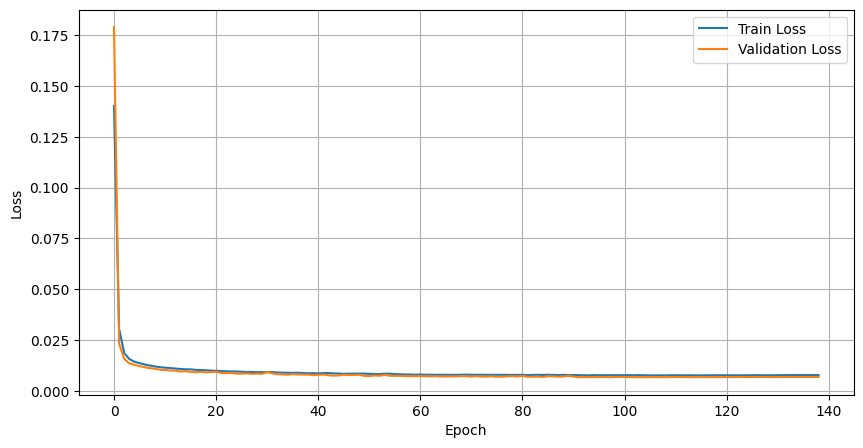

In [68]:
# TRAINING

if __name__ == "__main__":
    # Initialize model and config
    model = VAE()
    config = VAEConfig()

    # Train model
    train_losses, val_losses = train_vae(model, train_loader, val_loader, config)

In [58]:
# Cell 23: Model Evaluation and Reconstruction Visualization
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def load_trained_vae(checkpoint_dir, model_name='vae'):
    """Load trained VAE model and metadata"""
    checkpoint_path = Path(checkpoint_dir) / f"{model_name}_checkpoint.pth"
    metadata_path = Path(checkpoint_dir) / f"{model_name}_metadata.json"

    # Load model
    model = VAE()
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    # Load training history
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    return model, metadata

def visualize_reconstructions(model, val_loader, num_samples=3):
    """Visualize original vs reconstructed volumes with added uncertainty visualization"""
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            volumes = batch['volume'].to(device)
            # Generate multiple reconstructions to assess variance
            reconstructions = []
            for _ in range(5):  # Generate 5 reconstructions per sample
                recon, _, _ = model(volumes)
                reconstructions.append(recon.cpu().numpy())
            reconstructions = np.stack(reconstructions)

            # Process num_samples samples
            for idx in range(min(num_samples, volumes.shape[0])):
                fig = plt.figure(figsize=(15, 8))

                # Get middle slices
                orig_vol = volumes[idx, 0].cpu().numpy()
                recon_mean = reconstructions[:, idx, 0].mean(axis=0)
                recon_std = reconstructions[:, idx, 0].std(axis=0)

                # Plot axial, sagittal, and coronal views
                views = ['Axial', 'Sagittal', 'Coronal']
                slices_orig = [
                    orig_vol[34, :, :],
                    orig_vol[:, 50, :],
                    orig_vol[:, :, 75]                    
                ]
                slices_recon = [
                    recon_mean[34, :, :],
                    recon_mean[:,50, :],
                    recon_mean[:, :, 75]
                ]
                slices_std = [
                    recon_std[34, :, :],
                    recon_std[:, 50, :],
                    recon_std[:, :, 75]
                ]

                for i, (view, orig_slice, recon_slice, std_slice) in enumerate(zip(views, slices_orig, slices_recon, slices_std)):
                    # Original
                    plt.subplot(3, 3, i+1)
                    plt.imshow(orig_slice, cmap='gray',vmin=0,vmax=4)
                    plt.title(f'Original {view}')
                    plt.axis('off')

                    # Reconstructed
                    plt.subplot(3, 3, i+4)
                    plt.imshow(recon_slice, cmap='gray',vmin=0,vmax=4)
                    plt.title(f'Reconstructed {view}')
                    plt.axis('off')

                    # Uncertainty
                    plt.subplot(3, 3, i+7)
                    plt.imshow(std_slice, cmap='viridis')
                    plt.title(f'Uncertainty {view}')
                    plt.colorbar()
                    plt.axis('off')

                plt.suptitle(f'Sample {idx+1} - Original vs Reconstructed with Uncertainty', y=1.02)
                plt.tight_layout()
                plt.show()

            break  # Only process first batch

In [59]:
# Cell 24: Quantitative Metrics
def compute_metrics(model, val_loader):
    """Compute quantitative metrics including reconstruction error and KL divergence"""
    device = next(model.parameters()).device
    mse_criterion = nn.MSELoss(reduction='none')

    total_mse = 0
    total_kl = 0
    total_samples = 0

    region_errors = {
        'Left Striatum': [],
        'Right Striatum': [],
        'Background': []
    }

    # Define regions of interest (approximate coordinates for DaTSCAN)
    regions = {
        'Left Striatum': (slice(54, 74), slice(54, 74), slice(44, 64)),
        'Right Striatum': (slice(54, 74), slice(54, 74), slice(64, 84)),
        'Background': (slice(0, 20), slice(0, 20), slice(0, 20))
    }

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Computing metrics"):
            volumes = batch['volume'].to(device)
            recon, mu, log_var = model(volumes)

            # Overall MSE
            mse = mse_criterion(recon, volumes).mean(dim=(1,2,3,4))

            # KL divergence
            kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1)

            total_mse += mse.sum().item()
            total_kl += kl.sum().item()
            total_samples += volumes.shape[0]

            # Region-specific analysis
            for vol_idx in range(volumes.shape[0]):
                orig = volumes[vol_idx, 0].cpu().numpy()
                recon_vol = recon[vol_idx, 0].cpu().numpy()

                for region_name, coords in regions.items():
                    orig_region = orig[coords]
                    recon_region = recon_vol[coords]
                    mse = np.mean((orig_region - recon_region) ** 2)
                    region_errors[region_name].append(mse)

    # Calculate average metrics
    avg_mse = total_mse / total_samples
    avg_kl = total_kl / total_samples

    print(f"\nOverall Metrics:")
    print(f"Average MSE: {avg_mse:.6f}")
    print(f"Average KL Divergence: {avg_kl:.6f}")
    print(f"RMSE: {np.sqrt(avg_mse):.6f}")

    print("\nRegion-Specific MSE:")
    for region in regions.keys():
        errors = region_errors[region]
        print(f"\n{region}:")
        print(f"Mean MSE: {np.mean(errors):.6f}")
        print(f"Std MSE: {np.std(errors):.6f}")
        print(f"Min MSE: {np.min(errors):.6f}")
        print(f"Max MSE: {np.max(errors):.6f}")

    return avg_mse, avg_kl, region_errors

In [60]:
# Cell 25: Latent Space Analysis
def analyze_latent_space(model, val_loader, num_samples=1000):
    """Analyze the structure of the learned latent space"""
    device = next(model.parameters()).device
    latent_vectors = []
    labels = []
    reconstructions = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Collecting latent vectors"):
            volumes = batch['volume'].to(device)
            mu, log_var = model.encoder(volumes)
            z = model.reparameterize(mu, log_var)

            latent_vectors.append(z.cpu().numpy())
            labels.extend(batch['label'])

            if len(np.concatenate(latent_vectors)) >= num_samples:
                break

    latent_vectors = np.concatenate(latent_vectors)[:num_samples]
    labels = np.array(labels[:num_samples])

    # Plot latent space distribution
    plt.figure(figsize=(15, 5))

    # Plot distribution of first two dimensions
    plt.subplot(131)
    labels_categorical = pd.Categorical(labels).codes
    plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels_categorical, alpha=0.6)
    plt.title('First Two Latent Dimensions')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # Plot average activation per dimension
    plt.subplot(132)
    avg_activation = np.mean(np.abs(latent_vectors), axis=0)
    plt.bar(range(len(avg_activation)), avg_activation)
    plt.title('Average Activation per Dimension')
    plt.xlabel('Dimension')
    plt.ylabel('Average Activation')

    # Plot variance explained
    plt.subplot(133)
    var_explained = np.var(latent_vectors, axis=0)
    plt.plot(np.cumsum(var_explained) / np.sum(var_explained))
    plt.title('Cumulative Variance Explained')
    plt.xlabel('Number of Dimensions')
    plt.ylabel('Cumulative Variance Ratio')

    plt.tight_layout()
    plt.show()

    return latent_vectors, labels

Visualizing reconstructions...


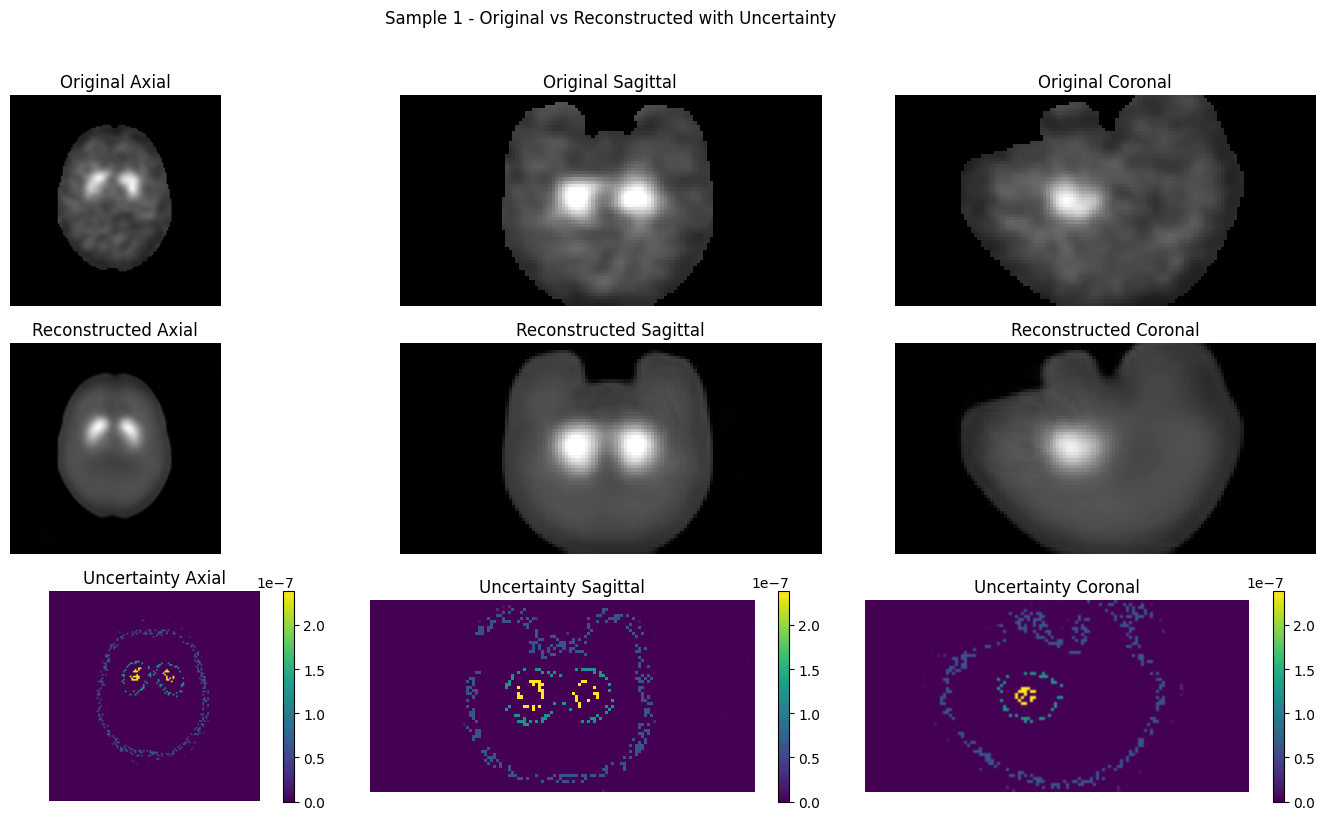

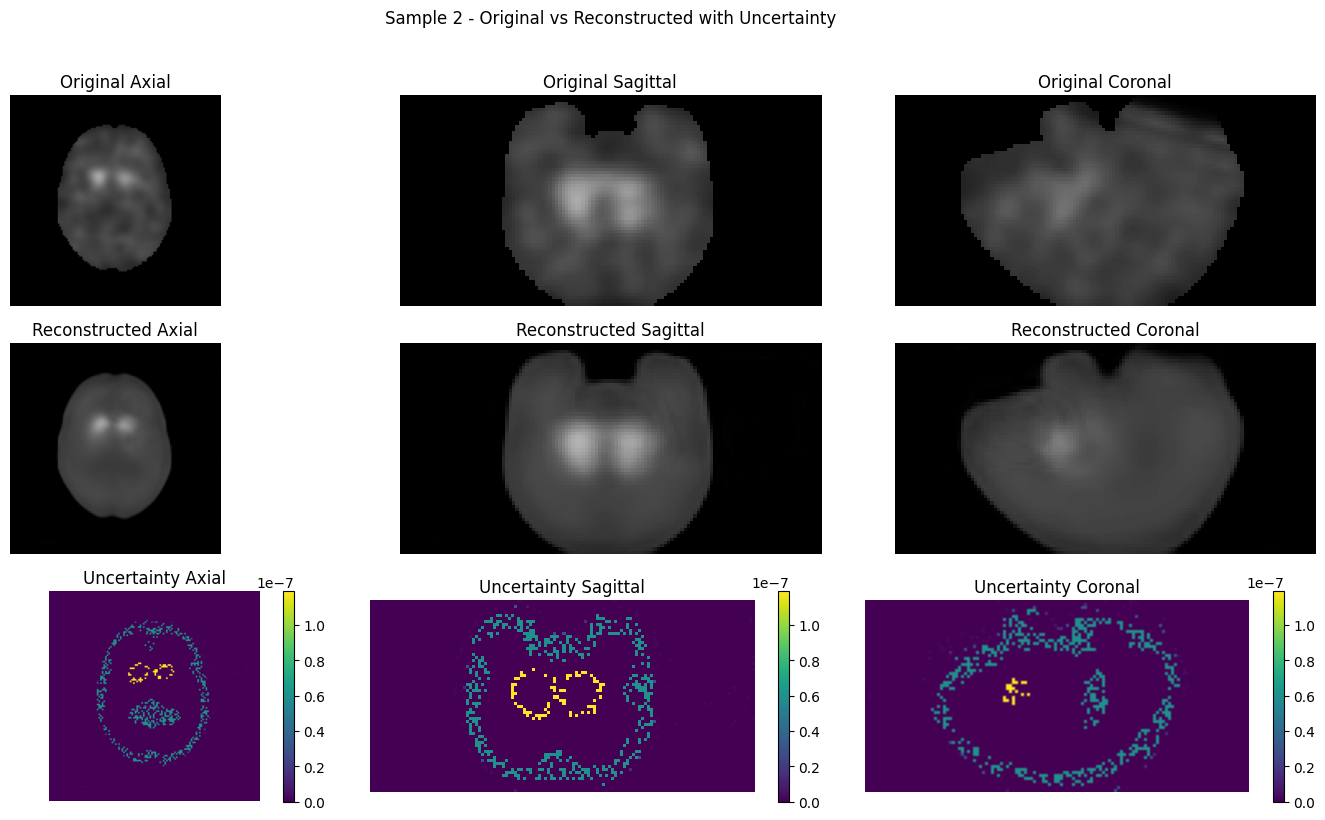

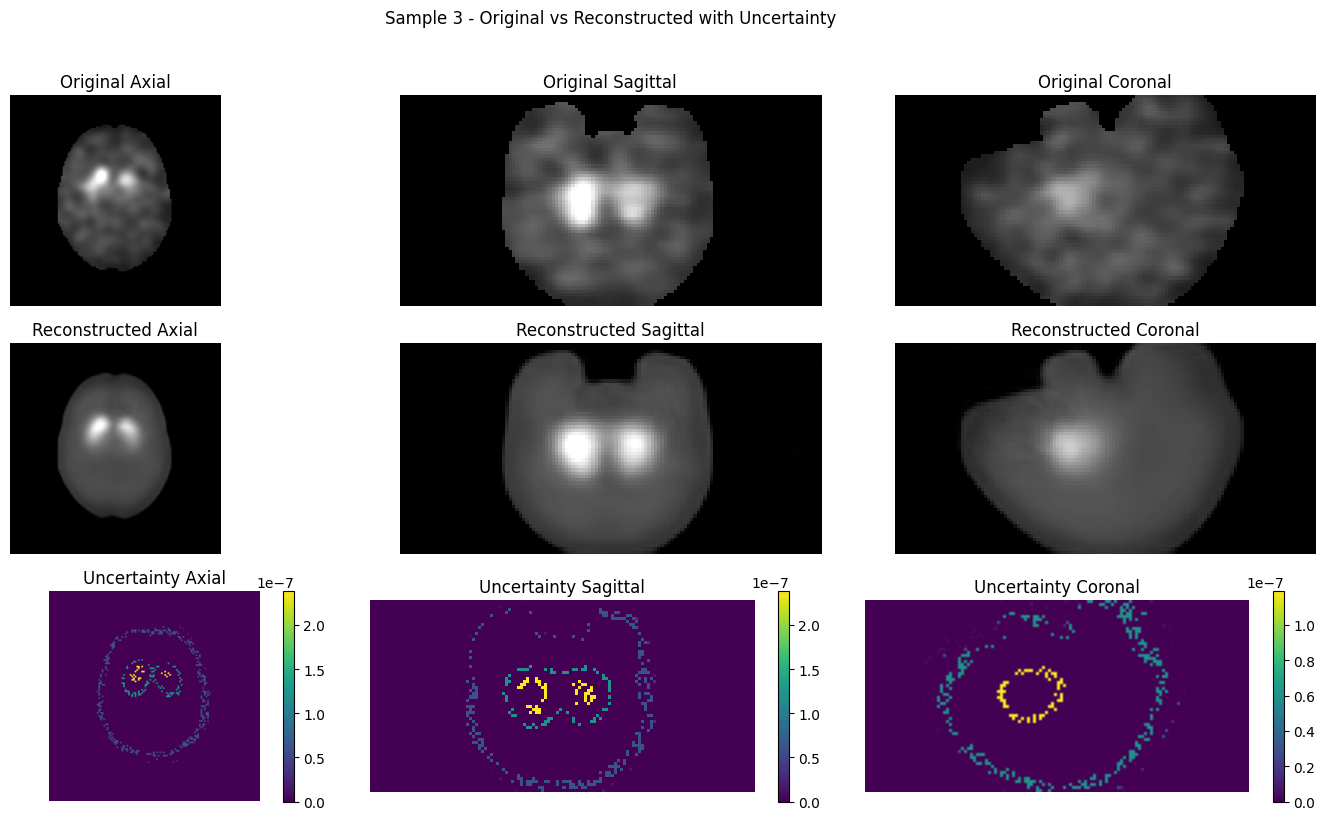


Computing metrics...


Computing metrics:   0%|          | 0/9 [00:00<?, ?it/s]


Overall Metrics:
Average MSE: 0.005575
Average KL Divergence: 42.183844
RMSE: 0.074663

Region-Specific MSE:

Left Striatum:
Mean MSE: 0.015925
Std MSE: 0.008363
Min MSE: 0.005127
Max MSE: 0.069629

Right Striatum:
Mean MSE: 0.017664
Std MSE: 0.009838
Min MSE: 0.005724
Max MSE: 0.074766

Background:
Mean MSE: 0.000027
Std MSE: 0.000003
Min MSE: 0.000023
Max MSE: 0.000039

Analyzing latent space...


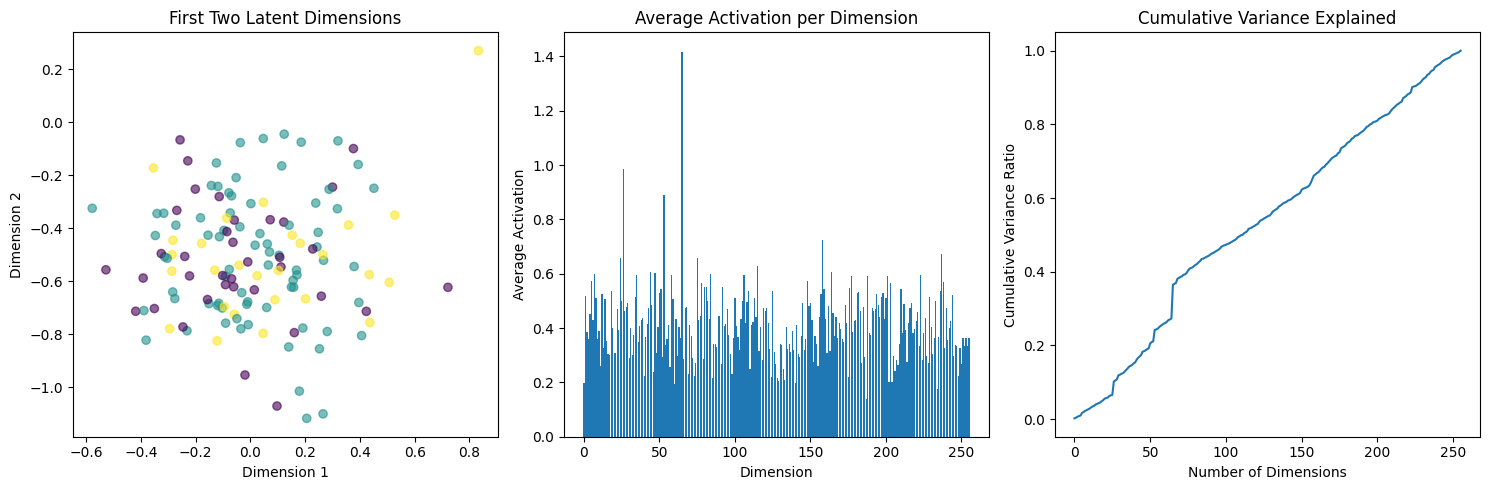

In [69]:
# Cell 26: Run Evaluation
if __name__ == "__main__":
    # Load trained model
    model, metadata = load_trained_vae('checkpoints',model_name='vae_Beta001')
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print("Visualizing reconstructions...")
    visualize_reconstructions(model, val_loader)

    print("\nComputing metrics...")
    avg_mse, avg_kl, region_errors = compute_metrics(model, val_loader)

    print("\nAnalyzing latent space...")
    latent_vectors, labels = analyze_latent_space(model, val_loader)

## 3. AE Semi-Supervised